In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv("./train.csv", parse_dates=[0]) # 日付をdatetime型で取得
test=pd.read_csv("./test.csv", parse_dates=[0])
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2466 non-null   datetime64[ns]
 1   y         2101 non-null   float64       
 2   client    2466 non-null   int64         
 3   close     2466 non-null   int64         
 4   price_am  2466 non-null   int64         
 5   price_pm  2466 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.9 KB


,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,-1,-1
1,2010-07-02,18.0,0,0,-1,-1
2,2010-07-03,20.0,0,0,-1,-1
3,2010-07-04,20.0,0,0,-1,-1
4,2010-07-05,14.0,0,0,-1,-1
5,2010-07-06,14.0,0,0,-1,-1
6,2010-07-07,4.0,0,0,-1,-1
7,2010-07-08,10.0,0,0,-1,-1
8,2010-07-09,12.0,0,0,-1,-1
9,2010-07-10,21.0,0,0,-1,-1


In [3]:
df.loc[df['price_am'] == -1, 'price_am'] = np.nan
df.loc[df['price_pm'] == -1, 'price_pm'] = np.nan
df.loc[df['close'] == 1, 'price_am'] = 0
df.loc[df['close'] == 1, 'price_pm'] = 0
df.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,NaN,NaN
1,2010-07-02,18.0,0,0,NaN,NaN
2,2010-07-03,20.0,0,0,NaN,NaN
3,2010-07-04,20.0,0,0,NaN,NaN
4,2010-07-05,14.0,0,0,NaN,NaN


In [4]:
### datimeをdatetime64[ns]型に変更。

In [5]:
#df['datetime'] = df.datetime.map(dt.datetime.timestamp)
#df['datetime'] = df['datetime'].dt.to_pydatetime()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [6]:
#df=df.drop(['datetime','year'], axis=1)
df=df.drop(['datetime'], axis=1)

### Fill na

In [7]:
df['price_am'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.fillna(x.mean()))
df['price_pm'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.fillna(x.mean()))

### New features

In [8]:
df['price'] = (df['price_am'] + df['price_pm'])/2

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         2101 non-null   float64
 1   client    2466 non-null   int64  
 2   close     2466 non-null   int64  
 3   price_am  2466 non-null   float64
 4   price_pm  2466 non-null   float64
 5   year      2466 non-null   int64  
 6   month     2466 non-null   int64  
 7   day       2466 non-null   int64  
 8   weekday   2466 non-null   int64  
 9   price     2466 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 211.9 KB


In [10]:
df['client'] = df['client'].astype(str)
df['close'] = df['close'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)

In [11]:
pd.set_option('display.max_rows', None)
print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
print(df.groupby(['year'])['price_am','price_pm','y'].mean())

               price_am  price_pm          y
month weekday                               
1     0        0.129032  0.000000  23.423077
      1        0.096774  0.064516  21.846154
      2        0.033333  0.000000  22.692308
      3        0.161290  0.096774  21.296296
      4        0.258065  0.161290  27.444444
      5        0.806452  0.419355  36.296296
      6        0.375000  0.218750  32.666667
10    0        0.518519  0.192308  28.538462
      1        0.192308  0.076923  25.769231
      2        0.185185  0.074074  28.148148
      3        0.222222  0.148148  29.481481
      4        0.500000  0.269231  32.222222
      5        1.629630  1.111111  39.000000
      6        1.346154  0.730769  35.269231
11    0        0.120000  0.040000  28.576923
      1        0.153846  0.076923  24.000000
      2        0.153846  0.076923  24.280000
      3        0.160000  0.080000  26.120000
      4        0.423077  0.269231  32.269231
      5        1.423077  1.000000  38.884615
      6   

<ipython-input-11-ab1e28b0b82f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
<ipython-input-11-ab1e28b0b82f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['year'])['price_am','price_pm','y'].mean())


In [12]:
#divide dataset into two parts(categorical, contineous)
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['client', 'close', 'month', 'weekday']

NumericaL:
['y', 'price_am', 'price_pm', 'year', 'day', 'price']


### Pandas Profining

In [13]:
#import pandas_profiling

#df.profile_report()

### Heat map for Correlation coefficient

<AxesSubplot:>

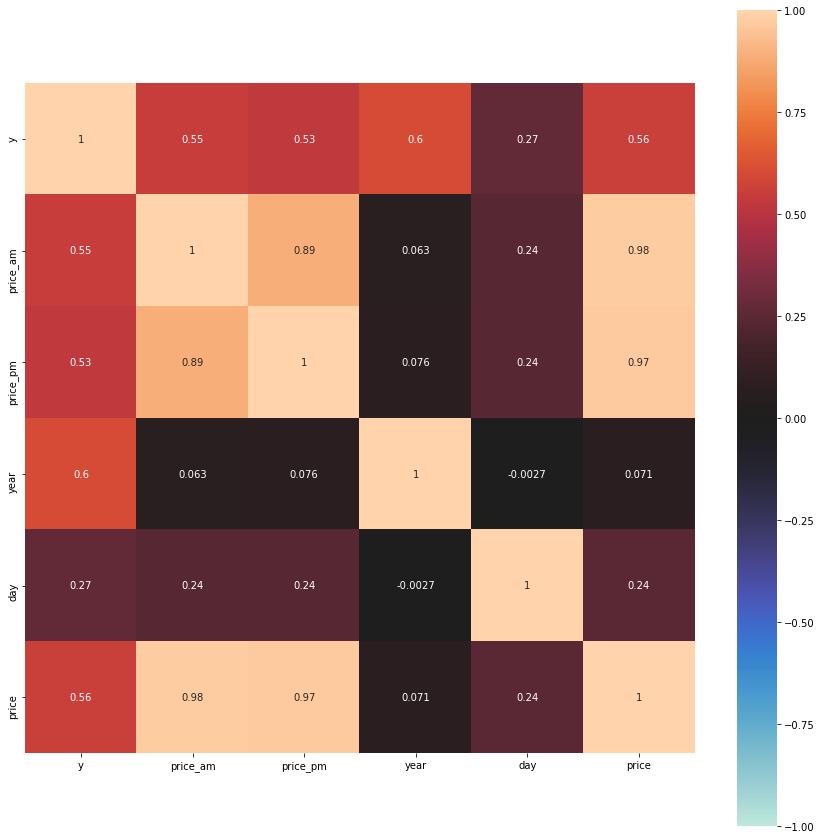

In [14]:
df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Histogram

C:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


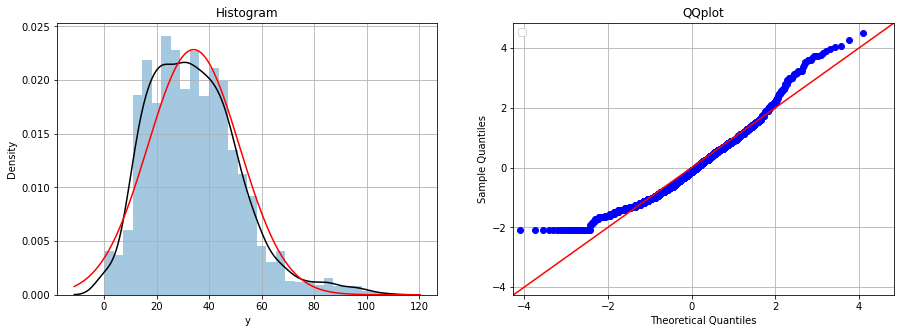

In [15]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
# Histogram
sns.distplot(
    train['y'], label='y',
    kde_kws={'label': 'kde','color':'k'},
    fit=norm,fit_kws={'label': 'norm','color':'red'},
    ax = ax[0]
)
ax[0].set_title("Histogram")
ax[0].grid(True)

# QQplot
sm.qqplot(train['y'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[1])
ax[1].set_title("QQplot")
ax[1].grid(True)

plt.legend() # 凡例を表示
plt.show() #グラフ表示

### Dummy

In [16]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

In [17]:
df.head(10)

,y,price_am,price_pm,year,day,price,client_1,close_1,month_10,month_11,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,1,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,2,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,3,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,4,1.166667,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,5,0.269231,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,14.0,0.333333,0.148148,2010,6,0.240741,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
6,4.0,0.259259,0.111111,2010,7,0.185185,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7,10.0,0.192308,0.076923,2010,8,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
8,12.0,0.692308,0.423077,2010,9,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9,21.0,1.807692,1.192308,2010,10,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


### Separate Data

In [18]:
train = df[:len(train)]
test = df[len(train):]

In [19]:
y_train = train['y']
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

In [20]:
### 線形回帰

In [21]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [22]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          2101 non-null   float64
 1   price_am   2466 non-null   float64
 2   price_pm   2466 non-null   float64
 3   year       2466 non-null   int64  
 4   day        2466 non-null   int64  
 5   price      2466 non-null   float64
 6   client_1   2466 non-null   uint8  
 7   close_1    2466 non-null   uint8  
 8   month_10   2466 non-null   uint8  
 9   month_11   2466 non-null   uint8  
 10  month_12   2466 non-null   uint8  
 11  month_2    2466 non-null   uint8  
 12  month_3    2466 non-null   uint8  
 13  month_4    2466 non-null   uint8  
 14  month_5    2466 non-null   uint8  
 15  month_6    2466 non-null   uint8  
 16  month_7    2466 non-null   uint8  
 17  month_8    2466 non-null   uint8  
 18  month_9    2466 non-null   uint8  
 19  weekday_1  2466 non-null   uint8  
 20  weekday_2

,y,price_am,price_pm,year,day,price,client_1,close_1,month_10,month_11,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,1,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,2,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,3,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,4,1.166667,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,5,0.269231,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
# データセットの標準化準備
scaler= StandardScaler()
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)


In [24]:
# Lasso 交差検証準備
# clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv = 5)

params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Lasso(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
lasso_tuned = clf.best_estimator_

# 予測値を反映
y_lasso_pred = lasso_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_lasso_test_pred = lasso_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_lasso_pred)))
#print(cross_val_score(clf, X_train_scaler, y_train, cv=5))

{'alpha': 0.025118864315094896}
R^2 = 0.7394474182666275
MAE = 6.866211410897769


In [25]:
import optuna.integration.lightgbm as lgb # Optuna 
#import lightgbm as lgb 
from sklearn.model_selection import KFold

evals_result = {} #結果を格納するための辞書

In [26]:
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [27]:
def ScalerFit(X_tr, X_tst):
    scaler.fit(X_tr)
    scaler.fit(X_tst)
    X_tr_scaler = scaler.transform(X_tr)
    X_tst_scaler  = scaler.transform(X_tst)
    return X_tr_scaler, X_tst_scaler

In [28]:
def SVC_fit(random_sts):
    # SVM
    params_grid = [
        {'C': [1, 10, 100], 'kernel':['linear']},
        {'C': [1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
    ]
    # パラメータチューニング
    clf = GridSearchCV(
        estimator = SVC(),
        param_grid = params_grid,
        cv = 5,
        scoring='r2',
        n_jobs = -1
        )

    # フィッテイング
    clf.fit(X_train_scaler, y_train) 

    # チューニングしたモデル
    best_param = clf.best_params_
    svc_tuned = clf.best_estimator_

    # 予測値を反映
    y_pred = svc_tuned.predict(X_train_scaler) # Trainデータに対して予測
    y_test_pred = svc_tuned.predict(X_test_scaler) # Testデータに対して予測

    print(best_param)
    print("Score = {}".format(clf.score(X_train_scaler, y_train)))
    print("MAE = {}".format(mean_absolute_error(y_train, y_pred)))
    mae_result = mean_absolute_error(y_train, y_pred)
    
    X_train['svc'] = y_pred
    X_test['svc'] = y_test_pred

    return y_pred, y_test_pred, mae_result
    

In [29]:
def lightGBM_fit(random_sts):
    y_lgb_preds = []
    models = []
    y_lgb_oof_train = np.zeros((len(X_train),))
    cv = KFold(n_splits=5, shuffle=True, random_state=random_sts)

    params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective': 'regression',
        'metric' : 'rmse',
        'max_bin' : 255,
        'num_leaves' : 31,
        'learning_rate' : 0.05,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : -1
    }

    # Cross Validation
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.iloc[train_index, :]
        X_val = X_train.iloc[valid_index, :]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[valid_index]
    
        # Train Dataset
        lgb_train = lgb.Dataset(X_tr, y_tr)

        # Evaluation Dataset (early_stopping_rounds)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
 #       evals_result = {} #結果を格納するための辞書
        # train
        gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
        # Out-of-hold of train data
        y_lgb_oof_train[valid_index] = \
            gbm.predict(X_val, num_iteration=gbm.best_iteration)

    
        # Prediction for X_test data
        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
        # Append Prediction data 
        y_lgb_preds.append(y_pred)
        models.append(gbm)

    mae_result = mean_absolute_error(y_train, y_lgb_oof_train)
    print("MAE = {}".format(mae_result))
    
    X_train['lgb'] = y_lgb_oof_train
    X_test['lgb'] = sum(y_lgb_preds)/len(y_lgb_preds)

    return y_lgb_oof_train, y_lgb_preds, mae_result

In [30]:
svc_mae_result = []
lgb_mae_result = []
for i in range(0,5):
    y_svc_pred, y_svc_test_pred,mae_result = SVC_fit(i)
    X_train_scaler, X_test_scaler = ScalerFit(X_train, X_test)
    svc_mae_result.append(mae_result)
    print(X_train.tail())
    y_lgb_oof_train, y_lgb_preds, mae_result = lightGBM_fit(i)
    X_train_scaler, X_test_scaler = ScalerFit(X_train, X_test)
    lgb_mae_result.append(mae_result)
    print(X_train.tail())

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


[I 2021-06-21 17:28:38,711] A new study created in memory with name: no-name-e4ab6b51-7fdd-4474-b795-155f1c058a4b
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Score = 0.7963529810129524
MAE = 4.991432651118515
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_7  month_8  month_9  weekday_1  \
2096         0         0  ...        0        0        0          0   
2097         0         0  ...        0        0        0          0   
2098         0         0  ...        0        0        0          1   
2099         0         0  ...        0        0        0          0   
2100         0         0  ...        0        0        0          0   

      weekday_2  weekday_3  weekday_4  weekday_5  weekday_6    svc  
20

feature_fraction, val_score: 6.498153:  14%|######4                                      | 1/7 [00:00<00:04,  1.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37247	eval's rmse: 6.78091
[200]	train's rmse: 4.45313	eval's rmse: 6.60172
[300]	train's rmse: 3.9164	eval's rmse: 6.55947
[400]	train's rmse: 3.5314	eval's rmse: 6.49557
[500]	train's rmse: 3.22284	eval's rmse: 6.48321


feature_fraction, val_score: 6.468234:  29%|############8                                | 2/7 [00:01<00:04,  1.10it/s]

Early stopping, best iteration is:
[485]	train's rmse: 3.26797	eval's rmse: 6.46823
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45764	eval's rmse: 6.81949
[200]	train's rmse: 4.54633	eval's rmse: 6.64039
[300]	train's rmse: 4.03473	eval's rmse: 6.59749
[400]	train's rmse: 3.65022	eval's rmse: 6.56862


feature_fraction, val_score: 6.468234:  43%|###################2                         | 3/7 [00:02<00:03,  1.14it/s]

Early stopping, best iteration is:
[390]	train's rmse: 3.68702	eval's rmse: 6.55444
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50194	eval's rmse: 6.76325
[200]	train's rmse: 4.59465	eval's rmse: 6.59436
[300]	train's rmse: 4.08452	eval's rmse: 6.52631
[400]	train's rmse: 3.70481	eval's rmse: 6.50984
[500]	train's rmse: 3.41679	eval's rmse: 6.49142
Early stopping, best iteration is:
[490]	train's rmse: 3.44383	eval's rmse: 6.48175


feature_fraction, val_score: 6.468234:  57%|#########################7                   | 4/7 [00:03<00:02,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44766	eval's rmse: 6.86183
[200]	train's rmse: 4.51974	eval's rmse: 6.66619
[300]	train's rmse: 3.99069	eval's rmse: 6.59273
[400]	train's rmse: 3.59769	eval's rmse: 6.5582
Early stopping, best iteration is:
[390]	train's rmse: 3.63697	eval's rmse: 6.54257


feature_fraction, val_score: 6.468234:  71%|################################1            | 5/7 [00:04<00:01,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04495	eval's rmse: 6.97901
[200]	train's rmse: 5.17342	eval's rmse: 6.6922
[300]	train's rmse: 4.66167	eval's rmse: 6.64436


feature_fraction, val_score: 6.468234:  86%|######################################5      | 6/7 [00:05<00:00,  1.20it/s]

[400]	train's rmse: 4.31503	eval's rmse: 6.60626
Early stopping, best iteration is:
[391]	train's rmse: 4.33885	eval's rmse: 6.59345


[I 2021-06-21 17:28:43,896] Trial 5 finished with value: 6.5934517515224655 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 6.4682342580598196.
feature_fraction, val_score: 6.468234:  86%|######################################5      | 6/7 [00:05<00:00,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74079	eval's rmse: 6.78836
[200]	train's rmse: 4.87227	eval's rmse: 6.60575
[300]	train's rmse: 4.36881	eval's rmse: 6.55521


num_leaves, val_score: 6.468234:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[400]	train's rmse: 4.00895	eval's rmse: 6.53685
Early stopping, best iteration is:
[334]	train's rmse: 4.23522	eval's rmse: 6.51442
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:   5%|##5                                               | 1/20 [00:00<00:14,  1.31it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:  10%|#####                                             | 2/20 [00:01<00:13,  1.36it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:  15%|#######5                                          | 3/20 [00:02<00:12,  1.37it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:  20%|##########                                        | 4/20 [00:02<00:11,  1.35it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:  25%|############5                                     | 5/20 [00:03<00:11,  1.32it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:  30%|###############                                   | 6/20 [00:04<00:10,  1.34it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.76859	eval's rmse: 7.26698
[200]	train's rmse: 6.2618	eval's rmse: 7.04817
[300]	train's rmse: 5.96175	eval's rmse: 6.87897
[400]	train's rmse: 5.70822	eval's rmse: 6.77188
[500]	train's rmse: 5.52772	eval's rmse: 6.75388


num_leaves, val_score: 6.468234:  35%|#################5                                | 7/20 [00:04<00:08,  1.50it/s]

[600]	train's rmse: 5.36325	eval's rmse: 6.68663
[700]	train's rmse: 5.22742	eval's rmse: 6.67563
Early stopping, best iteration is:
[643]	train's rmse: 5.30051	eval's rmse: 6.66002
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554
[300]	train's rmse: 3.45915	eval's rmse: 6.53446

num_leaves, val_score: 6.468234:  40%|####################                              | 8/20 [00:05<00:08,  1.42it/s]


Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:  45%|######################5                           | 9/20 [00:06<00:08,  1.37it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07892	eval's rmse: 6.7094
[200]	train's rmse: 4.05813	eval's rmse: 6.56928


num_leaves, val_score: 6.468234:  50%|########################5                        | 10/20 [00:07<00:07,  1.40it/s]

[300]	train's rmse: 3.4577	eval's rmse: 6.55506
Early stopping, best iteration is:
[214]	train's rmse: 3.94934	eval's rmse: 6.54074
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554
[300]	train's rmse: 3.45915	eval's rmse: 6.53446


num_leaves, val_score: 6.468234:  55%|##########################9                      | 11/20 [00:07<00:06,  1.38it/s]

Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:  60%|#############################4                   | 12/20 [00:08<00:05,  1.39it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.468234:  65%|###############################8                 | 13/20 [00:09<00:05,  1.37it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09563	eval's rmse: 6.95496
[200]	train's rmse: 5.42126	eval's rmse: 6.68187
[300]	train's rmse: 5.00298	eval's rmse: 6.57535
[400]	train's rmse: 4.69015	eval's rmse: 6.47714
[500]	train's rmse: 4.43906	eval's rmse: 6.44225
[600]	train's rmse: 4.23356	eval's rmse: 6.44646


num_leaves, val_score: 6.421828:  70%|##################################3              | 14/20 [00:10<00:04,  1.39it/s]

[700]	train's rmse: 4.05038	eval's rmse: 6.44661
Early stopping, best iteration is:
[620]	train's rmse: 4.1941	eval's rmse: 6.42183
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.421828:  75%|####################################7            | 15/20 [00:10<00:03,  1.35it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.72651	eval's rmse: 6.89761
[200]	train's rmse: 4.92004	eval's rmse: 6.63453
[300]	train's rmse: 4.44852	eval's rmse: 6.54667


num_leaves, val_score: 6.421828:  80%|#######################################2         | 16/20 [00:11<00:02,  1.41it/s]

[400]	train's rmse: 4.0918	eval's rmse: 6.4991
Early stopping, best iteration is:
[390]	train's rmse: 4.12678	eval's rmse: 6.47899
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.64028	eval's rmse: 7.21414
[200]	train's rmse: 6.1173	eval's rmse: 6.98659
[300]	train's rmse: 5.79153	eval's rmse: 6.82953
[400]	train's rmse: 5.52846	eval's rmse: 6.72093
[500]	train's rmse: 5.34505	eval's rmse: 6.68286
[600]	train's rmse: 5.18527	eval's rmse: 6.60445
[700]	train's rmse: 5.0376	eval's rmse: 6.58818


num_leaves, val_score: 6.421828:  85%|#########################################6       | 17/20 [00:12<00:01,  1.51it/s]

Early stopping, best iteration is:
[685]	train's rmse: 5.05493	eval's rmse: 6.56512
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.51374	eval's rmse: 6.83021
[200]	train's rmse: 4.62495	eval's rmse: 6.61044
[300]	train's rmse: 4.09025	eval's rmse: 6.55285
[400]	train's rmse: 3.71645	eval's rmse: 6.51309


num_leaves, val_score: 6.421828:  90%|############################################1    | 18/20 [00:12<00:01,  1.45it/s]

Early stopping, best iteration is:
[390]	train's rmse: 3.75274	eval's rmse: 6.49362
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07726	eval's rmse: 6.71648
[200]	train's rmse: 4.06756	eval's rmse: 6.55554


num_leaves, val_score: 6.421828:  95%|##############################################5  | 19/20 [00:13<00:00,  1.44it/s]

[300]	train's rmse: 3.45915	eval's rmse: 6.53446
Early stopping, best iteration is:
[235]	train's rmse: 3.8254	eval's rmse: 6.51726
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42033	eval's rmse: 6.78296
[200]	train's rmse: 4.49521	eval's rmse: 6.60826


bagging, val_score: 6.421828:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[300]	train's rmse: 3.95748	eval's rmse: 6.56666
Early stopping, best iteration is:
[260]	train's rmse: 4.15326	eval's rmse: 6.54937
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.17547	eval's rmse: 7.00984
[200]	train's rmse: 5.5363	eval's rmse: 6.83208
[300]	train's rmse: 5.14081	eval's rmse: 6.76622
[400]	train's rmse: 4.84369	eval's rmse: 6.7116
[500]	train's rmse: 4.58926	eval's rmse: 6.69906
[600]	train's rmse: 4.38281	eval's rmse: 6.66804
[700]	train's rmse: 4.20524	eval's rmse: 6.65239
Early stopping, best iteration is:
[685]	train's rmse: 4.23602	eval's rmse: 6.63173


bagging, val_score: 6.421828:  10%|#####3                                               | 1/10 [00:00<00:07,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01414	eval's rmse: 6.90894
[200]	train's rmse: 5.32137	eval's rmse: 6.66883
[300]	train's rmse: 4.88856	eval's rmse: 6.50946
[400]	train's rmse: 4.56669	eval's rmse: 6.44256
[500]	train's rmse: 4.31732	eval's rmse: 6.41063


bagging, val_score: 6.382370:  20%|##########6                                          | 2/10 [00:01<00:06,  1.32it/s]

[600]	train's rmse: 4.09581	eval's rmse: 6.38809
[700]	train's rmse: 3.91846	eval's rmse: 6.39515
Early stopping, best iteration is:
[609]	train's rmse: 4.0793	eval's rmse: 6.38237
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04763	eval's rmse: 6.97277
[200]	train's rmse: 5.35774	eval's rmse: 6.7086
[300]	train's rmse: 4.95003	eval's rmse: 6.61051
[400]	train's rmse: 4.64885	eval's rmse: 6.54484
[500]	train's rmse: 4.41441	eval's rmse: 6.50561
[600]	train's rmse: 4.20081	eval's rmse: 6.43414


bagging, val_score: 6.382370:  30%|###############9                                     | 3/10 [00:02<00:05,  1.35it/s]

[700]	train's rmse: 4.02403	eval's rmse: 6.46886
Early stopping, best iteration is:
[600]	train's rmse: 4.20081	eval's rmse: 6.43414
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.07364	eval's rmse: 7.00555
[200]	train's rmse: 5.36279	eval's rmse: 6.71085
[300]	train's rmse: 4.93977	eval's rmse: 6.59856
[400]	train's rmse: 4.64832	eval's rmse: 6.5458
[500]	train's rmse: 4.41511	eval's rmse: 6.53846
[600]	train's rmse: 4.20794	eval's rmse: 6.5202
Early stopping, best iteration is:
[546]	train's rmse: 4.31435	eval's rmse: 6.48311


bagging, val_score: 6.382370:  40%|#####################2                               | 4/10 [00:02<00:04,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03613	eval's rmse: 6.96079
[200]	train's rmse: 5.3484	eval's rmse: 6.70295
[300]	train's rmse: 4.93263	eval's rmse: 6.57183
[400]	train's rmse: 4.62653	eval's rmse: 6.52847
[500]	train's rmse: 4.38451	eval's rmse: 6.505
[600]	train's rmse: 4.16678	eval's rmse: 6.48489
[700]	train's rmse: 4.00081	eval's rmse: 6.45307
[800]	train's rmse: 3.84653	eval's rmse: 6.45819
Early stopping, best iteration is:
[700]	train's rmse: 4.00081	eval's rmse: 6.45307


bagging, val_score: 6.382370:  50%|##########################5                          | 5/10 [00:03<00:03,  1.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.065	eval's rmse: 6.97266
[200]	train's rmse: 5.36414	eval's rmse: 6.6433
[300]	train's rmse: 4.94336	eval's rmse: 6.51658
[400]	train's rmse: 4.6289	eval's rmse: 6.48644
[500]	train's rmse: 4.38252	eval's rmse: 6.46448
Early stopping, best iteration is:
[457]	train's rmse: 4.48454	eval's rmse: 6.44876


bagging, val_score: 6.382370:  60%|###############################8                     | 6/10 [00:04<00:02,  1.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02254	eval's rmse: 6.87584
[200]	train's rmse: 5.34059	eval's rmse: 6.63797
[300]	train's rmse: 4.92378	eval's rmse: 6.4986
[400]	train's rmse: 4.61512	eval's rmse: 6.41591
[500]	train's rmse: 4.36223	eval's rmse: 6.41132
Early stopping, best iteration is:
[456]	train's rmse: 4.46618	eval's rmse: 6.37946


bagging, val_score: 6.379463:  70%|#####################################                | 7/10 [00:04<00:01,  1.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27549	eval's rmse: 7.18014
[200]	train's rmse: 5.67056	eval's rmse: 7.02762
[300]	train's rmse: 5.24319	eval's rmse: 6.82132
[400]	train's rmse: 4.96628	eval's rmse: 6.78953
[500]	train's rmse: 4.74995	eval's rmse: 6.76033


bagging, val_score: 6.379463:  80%|##########################################4          | 8/10 [00:05<00:01,  1.51it/s]

[600]	train's rmse: 4.55239	eval's rmse: 6.7171
[700]	train's rmse: 4.383	eval's rmse: 6.74474
Early stopping, best iteration is:
[624]	train's rmse: 4.50431	eval's rmse: 6.67353
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01299	eval's rmse: 6.88333
[200]	train's rmse: 5.33025	eval's rmse: 6.67219
[300]	train's rmse: 4.94346	eval's rmse: 6.54057
[400]	train's rmse: 4.65096	eval's rmse: 6.47248
[500]	train's rmse: 4.42729	eval's rmse: 6.45925
[600]	train's rmse: 4.22166	eval's rmse: 6.45914
Early stopping, best iteration is:
[558]	train's rmse: 4.29982	eval's rmse: 6.44574


bagging, val_score: 6.379463:  90%|###############################################7     | 9/10 [00:06<00:00,  1.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00447	eval's rmse: 6.88258
[200]	train's rmse: 5.29549	eval's rmse: 6.62761
[300]	train's rmse: 4.87163	eval's rmse: 6.51505
[400]	train's rmse: 4.58575	eval's rmse: 6.47946
[500]	train's rmse: 4.33799	eval's rmse: 6.45288


feature_fraction_stage2, val_score: 6.379463:   0%|                                              | 0/3 [00:00<?, ?it/s]

[600]	train's rmse: 4.13061	eval's rmse: 6.42526
Early stopping, best iteration is:
[595]	train's rmse: 4.14107	eval's rmse: 6.41626
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02801	eval's rmse: 6.89896
[200]	train's rmse: 5.32301	eval's rmse: 6.62645
[300]	train's rmse: 4.90763	eval's rmse: 6.53206


feature_fraction_stage2, val_score: 6.379463:  33%|############6                         | 1/3 [00:00<00:01,  1.86it/s]

[400]	train's rmse: 4.60115	eval's rmse: 6.4406
[500]	train's rmse: 4.36184	eval's rmse: 6.40812
Early stopping, best iteration is:
[455]	train's rmse: 4.46515	eval's rmse: 6.39107
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02254	eval's rmse: 6.87584
[200]	train's rmse: 5.34059	eval's rmse: 6.63797
[300]	train's rmse: 4.92378	eval's rmse: 6.4986
[400]	train's rmse: 4.61512	eval's rmse: 6.41591
[500]	train's rmse: 4.36223	eval's rmse: 6.41132
Early stopping, best iteration is:
[456]	train's rmse: 4.46618	eval's rmse: 6.37946


feature_fraction_stage2, val_score: 6.379463:  67%|#########################3            | 2/3 [00:01<00:00,  1.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.011	eval's rmse: 6.87742
[200]	train's rmse: 5.31415	eval's rmse: 6.615
[300]	train's rmse: 4.90748	eval's rmse: 6.51258
[400]	train's rmse: 4.59512	eval's rmse: 6.44105
[500]	train's rmse: 4.35601	eval's rmse: 6.43266
Early stopping, best iteration is:
[456]	train's rmse: 4.45335	eval's rmse: 6.39789

regularization_factors, val_score: 6.379463:   0%|                                              | 0/20 [00:00<?, ?it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01946	eval's rmse: 6.87603
[200]	train's rmse: 5.34498	eval's rmse: 6.62835
[300]	train's rmse: 4.92696	eval's rmse: 6.49862
[400]	train's rmse: 4.61591	eval's rmse: 6.40121
[500]	train's rmse: 4.37001	eval's rmse: 6.41452
[600]	train's rmse: 4.16252	eval's rmse: 6.37726


regularization_factors, val_score: 6.327589:   5%|#9                                    | 1/20 [00:00<00:14,  1.31it/s]

[700]	train's rmse: 3.98778	eval's rmse: 6.35211
Early stopping, best iteration is:
[675]	train's rmse: 4.02891	eval's rmse: 6.32759
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02877	eval's rmse: 6.87154
[200]	train's rmse: 5.34277	eval's rmse: 6.64318
[300]	train's rmse: 4.92361	eval's rmse: 6.48415


regularization_factors, val_score: 6.327589:   5%|#9                                    | 1/20 [00:01<00:14,  1.31it/s]

[400]	train's rmse: 4.61626	eval's rmse: 6.4289
[500]	train's rmse: 4.3654	eval's rmse: 6.41458
Early stopping, best iteration is:
[456]	train's rmse: 4.47176	eval's rmse: 6.38716


regularization_factors, val_score: 6.327589:  10%|###8                                  | 2/20 [00:01<00:11,  1.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04901	eval's rmse: 6.92554
[200]	train's rmse: 5.37018	eval's rmse: 6.66468
[300]	train's rmse: 4.96379	eval's rmse: 6.54641
[400]	train's rmse: 4.65667	eval's rmse: 6.45905
[500]	train's rmse: 4.42951	eval's rmse: 6.43543


regularization_factors, val_score: 6.327589:  15%|#####7                                | 3/20 [00:01<00:10,  1.61it/s]

Early stopping, best iteration is:
[456]	train's rmse: 4.52824	eval's rmse: 6.40178
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02262	eval's rmse: 6.87582
[200]	train's rmse: 5.32318	eval's rmse: 6.61127
[300]	train's rmse: 4.90765	eval's rmse: 6.48234
[400]	train's rmse: 4.60138	eval's rmse: 6.39432


regularization_factors, val_score: 6.327589:  20%|#######6                              | 4/20 [00:02<00:09,  1.66it/s]

[500]	train's rmse: 4.35483	eval's rmse: 6.40488
Early stopping, best iteration is:
[458]	train's rmse: 4.45371	eval's rmse: 6.36431
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.14126	eval's rmse: 6.95544
[200]	train's rmse: 5.48601	eval's rmse: 6.68442
[300]	train's rmse: 5.09354	eval's rmse: 6.60776
[400]	train's rmse: 4.79712	eval's rmse: 6.50327
[500]	train's rmse: 4.57709	eval's rmse: 6.46222
[600]	train's rmse: 4.38635	eval's rmse: 6.42756


regularization_factors, val_score: 6.327589:  25%|#########5                            | 5/20 [00:03<00:10,  1.50it/s]

[700]	train's rmse: 4.23113	eval's rmse: 6.39792
Early stopping, best iteration is:
[690]	train's rmse: 4.24617	eval's rmse: 6.38796
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02254	eval's rmse: 6.87584
[200]	train's rmse: 5.34059	eval's rmse: 6.63797
[300]	train's rmse: 4.92378	eval's rmse: 6.4986


regularization_factors, val_score: 6.327589:  30%|###########4                          | 6/20 [00:03<00:08,  1.59it/s]

[400]	train's rmse: 4.61512	eval's rmse: 6.41591
[500]	train's rmse: 4.36223	eval's rmse: 6.41132
Early stopping, best iteration is:
[456]	train's rmse: 4.46618	eval's rmse: 6.37946
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01222	eval's rmse: 6.8917
[200]	train's rmse: 5.31543	eval's rmse: 6.63379
[300]	train's rmse: 4.91058	eval's rmse: 6.50803
[400]	train's rmse: 4.60407	eval's rmse: 6.43329
[500]	train's rmse: 4.36189	eval's rmse: 6.44583


regularization_factors, val_score: 6.327589:  35%|#############3                        | 7/20 [00:04<00:08,  1.62it/s]

Early stopping, best iteration is:
[457]	train's rmse: 4.45926	eval's rmse: 6.41517
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02255	eval's rmse: 6.87584
[200]	train's rmse: 5.33316	eval's rmse: 6.5987
[300]	train's rmse: 4.90525	eval's rmse: 6.46162
[400]	train's rmse: 4.60585	eval's rmse: 6.37689


regularization_factors, val_score: 6.327589:  40%|###############2                      | 8/20 [00:05<00:07,  1.65it/s]

[500]	train's rmse: 4.36286	eval's rmse: 6.37064
Early stopping, best iteration is:
[456]	train's rmse: 4.4653	eval's rmse: 6.3354
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02254	eval's rmse: 6.87584
[200]	train's rmse: 5.33315	eval's rmse: 6.5987
[300]	train's rmse: 4.90524	eval's rmse: 6.46162


regularization_factors, val_score: 6.327589:  45%|#################1                    | 9/20 [00:05<00:06,  1.67it/s]

[400]	train's rmse: 4.60584	eval's rmse: 6.37689
[500]	train's rmse: 4.36286	eval's rmse: 6.37064
Early stopping, best iteration is:
[456]	train's rmse: 4.4653	eval's rmse: 6.3354
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02254	eval's rmse: 6.87584
[200]	train's rmse: 5.34059	eval's rmse: 6.63797
[300]	train's rmse: 4.92378	eval's rmse: 6.4986
[400]	train's rmse: 4.61512	eval's rmse: 6.41591
[500]	train's rmse: 4.36223	eval's rmse: 6.41132
Early stopping, best iteration is:
[456]	train's rmse: 4.46618	eval's rmse: 6.37946

regularization_factors, val_score: 6.327589:  50%|##################5                  | 10/20 [00:06<00:05,  1.68it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03874	eval's rmse: 6.86982
[200]	train's rmse: 5.33881	eval's rmse: 6.56801
[300]	train's rmse: 4.92535	eval's rmse: 6.45865


regularization_factors, val_score: 6.327589:  55%|####################3                | 11/20 [00:06<00:05,  1.67it/s][I 2021-06-21 17:29:14,110] Trial 50 finished with value: 6.329553797239137 and parameters: {'lambda_l1': 0.18503830224186313, 'lambda_l2': 2.6265873882364726e-05}. Best is trial 40 with value: 6.327589448295661.


[400]	train's rmse: 4.6169	eval's rmse: 6.36478
[500]	train's rmse: 4.3667	eval's rmse: 6.35199
Early stopping, best iteration is:
[456]	train's rmse: 4.46643	eval's rmse: 6.32955


regularization_factors, val_score: 6.327589:  55%|####################3                | 11/20 [00:06<00:05,  1.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0203	eval's rmse: 6.88852
[200]	train's rmse: 5.34459	eval's rmse: 6.6094
[300]	train's rmse: 4.92714	eval's rmse: 6.47587
[400]	train's rmse: 4.6142	eval's rmse: 6.40801
[500]	train's rmse: 4.3643	eval's rmse: 6.40982


regularization_factors, val_score: 6.327589:  60%|######################2              | 12/20 [00:07<00:04,  1.67it/s]

Early stopping, best iteration is:
[456]	train's rmse: 4.46575	eval's rmse: 6.35679
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04225	eval's rmse: 6.87131
[200]	train's rmse: 5.34258	eval's rmse: 6.60273
[300]	train's rmse: 4.9185	eval's rmse: 6.49268
[400]	train's rmse: 4.60314	eval's rmse: 6.42497


regularization_factors, val_score: 6.327589:  65%|########################             | 13/20 [00:07<00:04,  1.67it/s]

[500]	train's rmse: 4.36372	eval's rmse: 6.42947
Early stopping, best iteration is:
[456]	train's rmse: 4.46433	eval's rmse: 6.38934
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03872	eval's rmse: 6.86981
[200]	train's rmse: 5.33426	eval's rmse: 6.61085
[300]	train's rmse: 4.91811	eval's rmse: 6.44934


regularization_factors, val_score: 6.327589:  65%|########################             | 13/20 [00:08<00:04,  1.67it/s]

[400]	train's rmse: 4.60895	eval's rmse: 6.3815
[500]	train's rmse: 4.3667	eval's rmse: 6.37418
Early stopping, best iteration is:
[456]	train's rmse: 4.47329	eval's rmse: 6.33971


regularization_factors, val_score: 6.327589:  70%|#########################9           | 14/20 [00:08<00:03,  1.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02808	eval's rmse: 6.87321
[200]	train's rmse: 5.32581	eval's rmse: 6.6198
[300]	train's rmse: 4.91273	eval's rmse: 6.47958
[400]	train's rmse: 4.59391	eval's rmse: 6.4027
[500]	train's rmse: 4.35808	eval's rmse: 6.38498


regularization_factors, val_score: 6.327589:  75%|###########################7         | 15/20 [00:09<00:02,  1.67it/s]

Early stopping, best iteration is:
[459]	train's rmse: 4.45578	eval's rmse: 6.34751
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04965	eval's rmse: 6.89969
[200]	train's rmse: 5.37263	eval's rmse: 6.6578
[300]	train's rmse: 4.95813	eval's rmse: 6.51972
[400]	train's rmse: 4.63931	eval's rmse: 6.46637
[500]	train's rmse: 4.39854	eval's rmse: 6.43153
[600]	train's rmse: 4.18041	eval's rmse: 6.39603
[700]	train's rmse: 4.01074	eval's rmse: 6.39092


regularization_factors, val_score: 6.327589:  80%|#############################6       | 16/20 [00:10<00:02,  1.44it/s]

[800]	train's rmse: 3.85559	eval's rmse: 6.38334
Early stopping, best iteration is:
[778]	train's rmse: 3.88825	eval's rmse: 6.36245
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02219	eval's rmse: 6.86979
[200]	train's rmse: 5.32438	eval's rmse: 6.569
[300]	train's rmse: 4.90254	eval's rmse: 6.46217


regularization_factors, val_score: 6.327589:  85%|###############################4     | 17/20 [00:10<00:02,  1.50it/s]

[400]	train's rmse: 4.58603	eval's rmse: 6.38602
[500]	train's rmse: 4.34279	eval's rmse: 6.38563
Early stopping, best iteration is:
[449]	train's rmse: 4.45837	eval's rmse: 6.35909
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02255	eval's rmse: 6.87584
[200]	train's rmse: 5.33316	eval's rmse: 6.5987
[300]	train's rmse: 4.90525	eval's rmse: 6.46162
[400]	train's rmse: 4.60585	eval's rmse: 6.37689
[500]	train's rmse: 4.36286	eval's rmse: 6.37064


regularization_factors, val_score: 6.327589:  90%|#################################3   | 18/20 [00:11<00:01,  1.54it/s]

Early stopping, best iteration is:
[456]	train's rmse: 4.46531	eval's rmse: 6.3354
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01751	eval's rmse: 6.88916
[200]	train's rmse: 5.33265	eval's rmse: 6.62132
[300]	train's rmse: 4.9204	eval's rmse: 6.51719
[400]	train's rmse: 4.60357	eval's rmse: 6.45203
[500]	train's rmse: 4.35409	eval's rmse: 6.41971
[600]	train's rmse: 4.14767	eval's rmse: 6.39858
[700]	train's rmse: 3.97268	eval's rmse: 6.38797
Early stopping, best iteration is:
[621]	train's rmse: 4.11202	eval's rmse: 6.36902


regularization_factors, val_score: 6.327589:  95%|###################################1 | 19/20 [00:12<00:00,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03233	eval's rmse: 6.88694
[200]	train's rmse: 5.35218	eval's rmse: 6.62223
[300]	train's rmse: 4.93929	eval's rmse: 6.51682
[400]	train's rmse: 4.62987	eval's rmse: 6.47137
[500]	train's rmse: 4.38406	eval's rmse: 6.47568
Early stopping, best iteration is:
[456]	train's rmse: 4.48475	eval's rmse: 6.43839

min_data_in_leaf, val_score: 6.327589:   0%|                                                     | 0/5 [00:00<?, ?it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57331	eval's rmse: 7.16882
[200]	train's rmse: 5.92498	eval's rmse: 6.87667
[300]	train's rmse: 5.51099	eval's rmse: 6.73766
[400]	train's rmse: 5.19731	eval's rmse: 6.61639
[500]	train's rmse: 4.95572	eval's rmse: 6.55577
[600]	train's rmse: 4.75762	eval's rmse: 6.52334
[700]	train's rmse: 4.57709	eval's rmse: 6.5009
[800]	train's rmse: 4.42092	eval's rmse: 6.48027
[900]	train's rmse: 4.28322	eval's rmse: 6.45894
[1000]	train's rmse: 4.15938	eval's rmse: 6.47969
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.15938	eval's rmse: 6.47969


min_data_in_leaf, val_score: 6.327589:  20%|#########                                    | 1/5 [00:01<00:04,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.36408	eval's rmse: 7.53776
[200]	train's rmse: 6.85699	eval's rmse: 7.21413
[300]	train's rmse: 6.54893	eval's rmse: 7.07249
[400]	train's rmse: 6.30331	eval's rmse: 6.99469
[500]	train's rmse: 6.10671	eval's rmse: 6.90348
[600]	train's rmse: 5.93044	eval's rmse: 6.85593
[700]	train's rmse: 5.76917	eval's rmse: 6.82171
[800]	train's rmse: 5.63626	eval's rmse: 6.78223
[900]	train's rmse: 5.51915	eval's rmse: 6.77611
[1000]	train's rmse: 5.40897	eval's rmse: 6.76284
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.40897	eval's rmse: 6.76284


min_data_in_leaf, val_score: 6.327589:  40%|##################                           | 2/5 [00:02<00:03,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.76667	eval's rmse: 6.74669
[200]	train's rmse: 4.9473	eval's rmse: 6.56327


min_data_in_leaf, val_score: 6.327589:  40%|##################                           | 2/5 [00:02<00:03,  1.02s/it]

[300]	train's rmse: 4.43747	eval's rmse: 6.5273
[400]	train's rmse: 4.04138	eval's rmse: 6.43336
Early stopping, best iteration is:
[396]	train's rmse: 4.05873	eval's rmse: 6.4309


min_data_in_leaf, val_score: 6.327589:  60%|###########################                  | 3/5 [00:02<00:01,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.11197	eval's rmse: 7.01242
[200]	train's rmse: 5.45472	eval's rmse: 6.74992
[300]	train's rmse: 5.06661	eval's rmse: 6.63012


min_data_in_leaf, val_score: 6.327589:  60%|###########################                  | 3/5 [00:03<00:01,  1.25it/s]

[400]	train's rmse: 4.75092	eval's rmse: 6.54474
[500]	train's rmse: 4.50651	eval's rmse: 6.56088
Early stopping, best iteration is:
[461]	train's rmse: 4.59545	eval's rmse: 6.52184


min_data_in_leaf, val_score: 6.327589:  80%|####################################         | 4/5 [00:03<00:00,  1.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.85331	eval's rmse: 6.88549
[200]	train's rmse: 5.08562	eval's rmse: 6.61696
[300]	train's rmse: 4.63755	eval's rmse: 6.52494
[400]	train's rmse: 4.27058	eval's rmse: 6.40011
[500]	train's rmse: 3.9958	eval's rmse: 6.39576


min_data_in_leaf, val_score: 6.327589: 100%|#############################################| 5/5 [00:04<00:00,  1.17it/s]

[600]	train's rmse: 3.76548	eval's rmse: 6.39106
Early stopping, best iteration is:
[519]	train's rmse: 3.95311	eval's rmse: 6.37853


[I 2021-06-21 17:29:24,377] Trial 64 finished with value: 6.37853336445994 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 6.37853336445994.
min_data_in_leaf, val_score: 6.327589: 100%|#############################################| 5/5 [00:04<00:00,  1.14it/s]
[I 2021-06-21 17:29:24,487] A new study created in memory with name: no-name-24000683-0348-4f8a-af38-33606f325ba0
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.54885	eval's rmse: 6.87349
[200]	train's rmse: 4.67649	eval's rmse: 6.63822
[300]	train's rmse: 4.16974	eval's rmse: 6.53907


feature_fraction, val_score: 6.528613:  14%|######4                                      | 1/7 [00:00<00:05,  1.04it/s]

[400]	train's rmse: 3.81062	eval's rmse: 6.53183
Early stopping, best iteration is:
[308]	train's rmse: 4.13961	eval's rmse: 6.52861
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89431	eval's rmse: 6.9842
[200]	train's rmse: 5.10197	eval's rmse: 6.71154
[300]	train's rmse: 4.62238	eval's rmse: 6.56877
[400]	train's rmse: 4.27596	eval's rmse: 6.52551
[500]	train's rmse: 4.01282	eval's rmse: 6.52623
[600]	train's rmse: 3.77912	eval's rmse: 6.53476
Early stopping, best iteration is:
[527]	train's rmse: 3.93826	eval's rmse: 6.51675


feature_fraction, val_score: 6.516751:  29%|############8                                | 2/7 [00:03<00:08,  1.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3321	eval's rmse: 6.79827
[200]	train's rmse: 4.40127	eval's rmse: 6.66266
[300]	train's rmse: 3.85499	eval's rmse: 6.61957


feature_fraction, val_score: 6.516751:  43%|###################2                         | 3/7 [00:04<00:06,  1.74s/it]

Early stopping, best iteration is:
[257]	train's rmse: 4.07243	eval's rmse: 6.60788
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.36734	eval's rmse: 6.86869
[200]	train's rmse: 4.46502	eval's rmse: 6.67403
[300]	train's rmse: 3.92342	eval's rmse: 6.61517


feature_fraction, val_score: 6.516751:  57%|#########################7                   | 4/7 [00:05<00:04,  1.40s/it]

Early stopping, best iteration is:
[266]	train's rmse: 4.09304	eval's rmse: 6.59594
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34541	eval's rmse: 6.77813
[200]	train's rmse: 4.48318	eval's rmse: 6.61042
[300]	train's rmse: 3.96038	eval's rmse: 6.54951
[400]	train's rmse: 3.58539	eval's rmse: 6.55837


feature_fraction, val_score: 6.516751:  71%|################################1            | 5/7 [00:06<00:02,  1.18s/it]

Early stopping, best iteration is:
[359]	train's rmse: 3.72537	eval's rmse: 6.54394
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.65914	eval's rmse: 6.86994
[200]	train's rmse: 4.78935	eval's rmse: 6.61456
[300]	train's rmse: 4.28823	eval's rmse: 6.48204
[400]	train's rmse: 3.93306	eval's rmse: 6.45578


feature_fraction, val_score: 6.453957:  86%|######################################5      | 6/7 [00:07<00:01,  1.09s/it]

[500]	train's rmse: 3.67318	eval's rmse: 6.48325
Early stopping, best iteration is:
[402]	train's rmse: 3.92822	eval's rmse: 6.45396
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.41536	eval's rmse: 6.81758
[200]	train's rmse: 4.57039	eval's rmse: 6.66021


num_leaves, val_score: 6.453957:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 4.02398	eval's rmse: 6.5907
Early stopping, best iteration is:
[265]	train's rmse: 4.1882	eval's rmse: 6.57082
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.453957:   5%|##5                                               | 1/20 [00:01<00:21,  1.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.453957:  10%|#####                                             | 2/20 [00:07<01:20,  4.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.453957:  15%|#######5                                          | 3/20 [00:10<00:58,  3.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.453957:  20%|##########                                        | 4/20 [00:12<00:47,  2.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.62399	eval's rmse: 6.86228
[200]	train's rmse: 4.74898	eval's rmse: 6.64909
[300]	train's rmse: 4.22369	eval's rmse: 6.53273
[400]	train's rmse: 3.86147	eval's rmse: 6.51188
[500]	train's rmse: 3.59428	eval's rmse: 6.53854
Early stopping, best iteration is:
[402]	train's rmse: 3.85646	eval's rmse: 6.5095


num_leaves, val_score: 6.453957:  25%|############5                                     | 5/20 [00:14<00:37,  2.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.453957:  30%|###############                                   | 6/20 [00:16<00:32,  2.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.453957:  35%|#################5                                | 7/20 [00:18<00:29,  2.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.453957:  40%|####################                              | 8/20 [00:20<00:26,  2.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.453957:  45%|######################5                           | 9/20 [00:22<00:23,  2.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.80517	eval's rmse: 6.89505
[200]	train's rmse: 5.0265	eval's rmse: 6.67738
[300]	train's rmse: 4.56954	eval's rmse: 6.53297
[400]	train's rmse: 4.2431	eval's rmse: 6.47105
[500]	train's rmse: 3.99861	eval's rmse: 6.46964
[600]	train's rmse: 3.77947	eval's rmse: 6.45954
Early stopping, best iteration is:
[576]	train's rmse: 3.82852	eval's rmse: 6.44501


num_leaves, val_score: 6.445009:  50%|########################5                        | 10/20 [00:23<00:20,  2.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21844	eval's rmse: 7.00267
[200]	train's rmse: 5.60094	eval's rmse: 6.7313
[300]	train's rmse: 5.23768	eval's rmse: 6.56182
[400]	train's rmse: 4.9576	eval's rmse: 6.45573
[500]	train's rmse: 4.75599	eval's rmse: 6.40181
[600]	train's rmse: 4.5803	eval's rmse: 6.39496
[700]	train's rmse: 4.43017	eval's rmse: 6.3793
[800]	train's rmse: 4.30291	eval's rmse: 6.35679
Early stopping, best iteration is:
[790]	train's rmse: 4.31715	eval's rmse: 6.35011


num_leaves, val_score: 6.350114:  55%|##########################9                      | 11/20 [00:26<00:18,  2.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48996	eval's rmse: 7.1408
[200]	train's rmse: 5.96733	eval's rmse: 6.90462
[300]	train's rmse: 5.65392	eval's rmse: 6.76391
[400]	train's rmse: 5.4097	eval's rmse: 6.64981
[500]	train's rmse: 5.23936	eval's rmse: 6.57701
[600]	train's rmse: 5.08008	eval's rmse: 6.52849
[700]	train's rmse: 4.94316	eval's rmse: 6.45753
[800]	train's rmse: 4.82783	eval's rmse: 6.40738
[900]	train's rmse: 4.71484	eval's rmse: 6.40806
[1000]	train's rmse: 4.62234	eval's rmse: 6.39895
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.62234	eval's rmse: 6.39895


num_leaves, val_score: 6.350114:  60%|#############################4                   | 12/20 [00:27<00:14,  1.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.59773	eval's rmse: 7.19548
[200]	train's rmse: 6.10038	eval's rmse: 6.96978
[300]	train's rmse: 5.81336	eval's rmse: 6.87014
[400]	train's rmse: 5.58365	eval's rmse: 6.74422
[500]	train's rmse: 5.40735	eval's rmse: 6.6574
[600]	train's rmse: 5.25991	eval's rmse: 6.60797
[700]	train's rmse: 5.13203	eval's rmse: 6.52368
[800]	train's rmse: 5.02137	eval's rmse: 6.47347
[900]	train's rmse: 4.91409	eval's rmse: 6.44896


num_leaves, val_score: 6.350114:  65%|###############################8                 | 13/20 [00:28<00:11,  1.63s/it]

[1000]	train's rmse: 4.82044	eval's rmse: 6.43343
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.82044	eval's rmse: 6.43343
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.350114:  70%|##################################3              | 14/20 [00:30<00:09,  1.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.94756	eval's rmse: 7.87187
[200]	train's rmse: 7.17507	eval's rmse: 7.37206
[300]	train's rmse: 7.04261	eval's rmse: 7.268
[400]	train's rmse: 6.96861	eval's rmse: 7.21141
[500]	train's rmse: 6.91713	eval's rmse: 7.18333
[600]	train's rmse: 6.87696	eval's rmse: 7.1599
[700]	train's rmse: 6.84868	eval's rmse: 7.15663


num_leaves, val_score: 6.350114:  75%|####################################7            | 15/20 [00:30<00:06,  1.34s/it]

[800]	train's rmse: 6.82545	eval's rmse: 7.14269
[900]	train's rmse: 6.80594	eval's rmse: 7.11969
[1000]	train's rmse: 6.7886	eval's rmse: 7.11221
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.7886	eval's rmse: 7.11221
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.54767	eval's rmse: 6.88618
[200]	train's rmse: 4.60851	eval's rmse: 6.67053
[300]	train's rmse: 4.0571	eval's rmse: 6.58289
[400]	train's rmse: 3.66744	eval's rmse: 6.57377
[500]	train's rmse: 3.39396	eval's rmse: 6.6006
Early stopping, best iteration is:
[410]	train's rmse: 3.6409	eval's rmse: 6.56986


num_leaves, val_score: 6.350114:  80%|#######################################2         | 16/20 [00:32<00:05,  1.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.350114:  85%|#########################################6       | 17/20 [00:33<00:03,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41922	eval's rmse: 7.12968
[200]	train's rmse: 5.86597	eval's rmse: 6.88797
[300]	train's rmse: 5.54632	eval's rmse: 6.72386
[400]	train's rmse: 5.29791	eval's rmse: 6.6026
[500]	train's rmse: 5.11728	eval's rmse: 6.52534
[600]	train's rmse: 4.95462	eval's rmse: 6.49389
[700]	train's rmse: 4.8157	eval's rmse: 6.45359
[800]	train's rmse: 4.69395	eval's rmse: 6.41811
[900]	train's rmse: 4.58083	eval's rmse: 6.41543


num_leaves, val_score: 6.350114:  90%|############################################1    | 18/20 [00:34<00:02,  1.20s/it]

[1000]	train's rmse: 4.48049	eval's rmse: 6.40854
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.48049	eval's rmse: 6.40854
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


num_leaves, val_score: 6.350114:  95%|##############################################5  | 19/20 [00:36<00:01,  1.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53222	eval's rmse: 6.89485
[200]	train's rmse: 4.60346	eval's rmse: 6.69189
[300]	train's rmse: 4.04347	eval's rmse: 6.59867
[400]	train's rmse: 3.63867	eval's rmse: 6.56166
[500]	train's rmse: 3.35489	eval's rmse: 6.59906
Early stopping, best iteration is:
[402]	train's rmse: 3.63392	eval's rmse: 6.56027


bagging, val_score: 6.350114:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.40528	eval's rmse: 7.1106
[200]	train's rmse: 5.75915	eval's rmse: 6.87801
[300]	train's rmse: 5.39525	eval's rmse: 6.69357
[400]	train's rmse: 5.14342	eval's rmse: 6.65453
[500]	train's rmse: 4.92683	eval's rmse: 6.57421
[600]	train's rmse: 4.75231	eval's rmse: 6.536
[700]	train's rmse: 4.60828	eval's rmse: 6.48922
[800]	train's rmse: 4.47758	eval's rmse: 6.48108
[900]	train's rmse: 4.36971	eval's rmse: 6.48805
Early stopping, best iteration is:
[828]	train's rmse: 4.44658	eval's rmse: 6.45485


bagging, val_score: 6.350114:  10%|#####3                                               | 1/10 [00:01<00:09,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35004	eval's rmse: 7.04791
[200]	train's rmse: 5.76294	eval's rmse: 6.85003
[300]	train's rmse: 5.4021	eval's rmse: 6.70579
[400]	train's rmse: 5.1521	eval's rmse: 6.59582
[500]	train's rmse: 4.95681	eval's rmse: 6.55041


bagging, val_score: 6.350114:  20%|##########6                                          | 2/10 [00:01<00:07,  1.08it/s]

[600]	train's rmse: 4.78459	eval's rmse: 6.57394
Early stopping, best iteration is:
[511]	train's rmse: 4.9416	eval's rmse: 6.54418
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53284	eval's rmse: 7.16434
[200]	train's rmse: 5.97314	eval's rmse: 7.03076
[300]	train's rmse: 5.61498	eval's rmse: 6.91549
[400]	train's rmse: 5.33971	eval's rmse: 6.8594
[500]	train's rmse: 5.12859	eval's rmse: 6.78631
[600]	train's rmse: 4.96038	eval's rmse: 6.7107
[700]	train's rmse: 4.8061	eval's rmse: 6.71078
[800]	train's rmse: 4.67429	eval's rmse: 6.70024
[900]	train's rmse: 4.55845	eval's rmse: 6.64551


bagging, val_score: 6.350114:  20%|##########6                                          | 2/10 [00:02<00:07,  1.08it/s]

[1000]	train's rmse: 4.45687	eval's rmse: 6.63214
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.45687	eval's rmse: 6.63214


bagging, val_score: 6.350114:  30%|###############9                                     | 3/10 [00:02<00:07,  1.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37962	eval's rmse: 7.08567
[200]	train's rmse: 5.77324	eval's rmse: 6.85197
[300]	train's rmse: 5.41764	eval's rmse: 6.72582
[400]	train's rmse: 5.15247	eval's rmse: 6.628
[500]	train's rmse: 4.94773	eval's rmse: 6.55717
[600]	train's rmse: 4.76257	eval's rmse: 6.52456
[700]	train's rmse: 4.61005	eval's rmse: 6.51222
[800]	train's rmse: 4.48122	eval's rmse: 6.48318


bagging, val_score: 6.350114:  40%|#####################2                               | 4/10 [00:03<00:05,  1.05it/s]

[900]	train's rmse: 4.36181	eval's rmse: 6.47096
Early stopping, best iteration is:
[860]	train's rmse: 4.40929	eval's rmse: 6.45417
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54197	eval's rmse: 7.07905
[200]	train's rmse: 5.97028	eval's rmse: 6.90844
[300]	train's rmse: 5.62701	eval's rmse: 6.74789


bagging, val_score: 6.350114:  40%|#####################2                               | 4/10 [00:04<00:05,  1.05it/s]

[400]	train's rmse: 5.36816	eval's rmse: 6.64787
[500]	train's rmse: 5.16678	eval's rmse: 6.60604
Early stopping, best iteration is:
[497]	train's rmse: 5.1732	eval's rmse: 6.60268


bagging, val_score: 6.350114:  50%|##########################5                          | 5/10 [00:04<00:04,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60755	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74818	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253


bagging, val_score: 6.339043:  50%|##########################5                          | 5/10 [00:05<00:04,  1.25it/s]

[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


bagging, val_score: 6.339043:  60%|###############################8                     | 6/10 [00:05<00:03,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.44933	eval's rmse: 7.12345
[200]	train's rmse: 5.84712	eval's rmse: 6.89025
[300]	train's rmse: 5.46527	eval's rmse: 6.73941
[400]	train's rmse: 5.20683	eval's rmse: 6.67828
[500]	train's rmse: 5.00816	eval's rmse: 6.67892
[600]	train's rmse: 4.83169	eval's rmse: 6.62753
[700]	train's rmse: 4.68862	eval's rmse: 6.6075
[800]	train's rmse: 4.56158	eval's rmse: 6.6081
[900]	train's rmse: 4.44472	eval's rmse: 6.58464
[1000]	train's rmse: 4.34044	eval's rmse: 6.56969
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.34044	eval's rmse: 6.56969


bagging, val_score: 6.339043:  70%|#####################################                | 7/10 [00:07<00:03,  1.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19121	eval's rmse: 6.94148
[200]	train's rmse: 5.55876	eval's rmse: 6.65698
[300]	train's rmse: 5.19201	eval's rmse: 6.53519
[400]	train's rmse: 4.9138	eval's rmse: 6.48272
[500]	train's rmse: 4.70466	eval's rmse: 6.43358
[600]	train's rmse: 4.51999	eval's rmse: 6.39147
[700]	train's rmse: 4.36984	eval's rmse: 6.38808
[800]	train's rmse: 4.23842	eval's rmse: 6.38958


bagging, val_score: 6.339043:  80%|##########################################4          | 8/10 [00:07<00:02,  1.01s/it]

Early stopping, best iteration is:
[752]	train's rmse: 4.29952	eval's rmse: 6.37328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.29937	eval's rmse: 7.06916
[200]	train's rmse: 5.67076	eval's rmse: 6.82247
[300]	train's rmse: 5.31268	eval's rmse: 6.65505
[400]	train's rmse: 5.05693	eval's rmse: 6.58404
[500]	train's rmse: 4.83287	eval's rmse: 6.50746
[600]	train's rmse: 4.64916	eval's rmse: 6.44915
[700]	train's rmse: 4.49973	eval's rmse: 6.43508


bagging, val_score: 6.339043:  90%|###############################################7     | 9/10 [00:08<00:00,  1.09it/s]

Early stopping, best iteration is:
[695]	train's rmse: 4.50815	eval's rmse: 6.42087
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48308	eval's rmse: 7.17431
[200]	train's rmse: 5.89222	eval's rmse: 7.02964
[300]	train's rmse: 5.53251	eval's rmse: 6.9081
[400]	train's rmse: 5.24702	eval's rmse: 6.80223
[500]	train's rmse: 5.03731	eval's rmse: 6.709
[600]	train's rmse: 4.87556	eval's rmse: 6.63996
[700]	train's rmse: 4.71783	eval's rmse: 6.63491


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[800]	train's rmse: 4.58583	eval's rmse: 6.6376
Early stopping, best iteration is:
[752]	train's rmse: 4.64445	eval's rmse: 6.60786


feature_fraction_stage2, val_score: 6.339043:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26106	eval's rmse: 7.06471
[200]	train's rmse: 5.66605	eval's rmse: 6.81267
[300]	train's rmse: 5.30711	eval's rmse: 6.64823
[400]	train's rmse: 5.05455	eval's rmse: 6.58494
[500]	train's rmse: 4.84712	eval's rmse: 6.51519
[600]	train's rmse: 4.67158	eval's rmse: 6.45174
[700]	train's rmse: 4.52449	eval's rmse: 6.44232
[800]	train's rmse: 4.3988	eval's rmse: 6.40986
[900]	train's rmse: 4.28548	eval's rmse: 6.39882


feature_fraction_stage2, val_score: 6.339043:  17%|######3                               | 1/6 [00:01<00:06,  1.24s/it]

[1000]	train's rmse: 4.1903	eval's rmse: 6.39341
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.1903	eval's rmse: 6.39341
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60755	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74818	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


feature_fraction_stage2, val_score: 6.339043:  33%|############6                         | 2/6 [00:02<00:05,  1.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26106	eval's rmse: 7.06471
[200]	train's rmse: 5.66605	eval's rmse: 6.81267
[300]	train's rmse: 5.30711	eval's rmse: 6.64823
[400]	train's rmse: 5.05455	eval's rmse: 6.58494
[500]	train's rmse: 4.84712	eval's rmse: 6.51519
[600]	train's rmse: 4.67158	eval's rmse: 6.45174
[700]	train's rmse: 4.52449	eval's rmse: 6.44232
[800]	train's rmse: 4.3988	eval's rmse: 6.40986
[900]	train's rmse: 4.28548	eval's rmse: 6.39882


feature_fraction_stage2, val_score: 6.339043:  33%|############6                         | 2/6 [00:04<00:05,  1.29s/it]

[1000]	train's rmse: 4.1903	eval's rmse: 6.39341
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.1903	eval's rmse: 6.39341


feature_fraction_stage2, val_score: 6.339043:  50%|###################                   | 3/6 [00:04<00:04,  1.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15119	eval's rmse: 6.9859
[200]	train's rmse: 5.53475	eval's rmse: 6.71684
[300]	train's rmse: 5.16587	eval's rmse: 6.54781
[400]	train's rmse: 4.89904	eval's rmse: 6.51375
[500]	train's rmse: 4.68416	eval's rmse: 6.4406
[600]	train's rmse: 4.50366	eval's rmse: 6.37758
[700]	train's rmse: 4.34927	eval's rmse: 6.37436
[800]	train's rmse: 4.21499	eval's rmse: 6.34431
[900]	train's rmse: 4.09956	eval's rmse: 6.33897
[1000]	train's rmse: 3.98915	eval's rmse: 6.35697
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.98915	eval's rmse: 6.35697


feature_fraction_stage2, val_score: 6.339043:  67%|#########################3            | 4/6 [00:05<00:02,  1.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19799	eval's rmse: 6.97152
[200]	train's rmse: 5.62317	eval's rmse: 6.76114
[300]	train's rmse: 5.25965	eval's rmse: 6.6003
[400]	train's rmse: 4.99642	eval's rmse: 6.56099
[500]	train's rmse: 4.78354	eval's rmse: 6.47674
[600]	train's rmse: 4.59995	eval's rmse: 6.43483
[700]	train's rmse: 4.45026	eval's rmse: 6.41765
[800]	train's rmse: 4.33505	eval's rmse: 6.38307


feature_fraction_stage2, val_score: 6.339043:  83%|###############################6      | 5/6 [00:06<00:01,  1.21s/it]

Early stopping, best iteration is:
[788]	train's rmse: 4.35126	eval's rmse: 6.37408
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15119	eval's rmse: 6.9859
[200]	train's rmse: 5.53475	eval's rmse: 6.71684
[300]	train's rmse: 5.16587	eval's rmse: 6.54781
[400]	train's rmse: 4.89904	eval's rmse: 6.51375
[500]	train's rmse: 4.68416	eval's rmse: 6.4406
[600]	train's rmse: 4.50366	eval's rmse: 6.37758
[700]	train's rmse: 4.34927	eval's rmse: 6.37436
[800]	train's rmse: 4.21499	eval's rmse: 6.34431
[900]	train's rmse: 4.09956	eval's rmse: 6.33897
[1000]	train's rmse: 3.98915	eval's rmse: 6.35697
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.98915	eval's rmse: 6.35697


regularization_factors, val_score: 6.339043:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.23954	eval's rmse: 7.03716
[200]	train's rmse: 5.64871	eval's rmse: 6.82081
[300]	train's rmse: 5.27971	eval's rmse: 6.63362
[400]	train's rmse: 5.01498	eval's rmse: 6.58562
[500]	train's rmse: 4.81329	eval's rmse: 6.50194
[600]	train's rmse: 4.64062	eval's rmse: 6.46489
[700]	train's rmse: 4.49503	eval's rmse: 6.4574
[800]	train's rmse: 4.37164	eval's rmse: 6.43005
[900]	train's rmse: 4.26718	eval's rmse: 6.41326
[1000]	train's rmse: 4.16862	eval's rmse: 6.41082
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.16862	eval's rmse: 6.41082


regularization_factors, val_score: 6.339043:   5%|#9                                    | 1/20 [00:01<00:30,  1.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19695	eval's rmse: 7.03019
[200]	train's rmse: 5.58613	eval's rmse: 6.81286
[300]	train's rmse: 5.23195	eval's rmse: 6.6286
[400]	train's rmse: 4.95521	eval's rmse: 6.56897
[500]	train's rmse: 4.74451	eval's rmse: 6.48597
[600]	train's rmse: 4.55388	eval's rmse: 6.43419
[700]	train's rmse: 4.40045	eval's rmse: 6.41862
[800]	train's rmse: 4.27036	eval's rmse: 6.38433
Early stopping, best iteration is:
[786]	train's rmse: 4.2898	eval's rmse: 6.38286


regularization_factors, val_score: 6.339043:  10%|###8                                  | 2/20 [00:02<00:25,  1.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20547	eval's rmse: 7.03041
[200]	train's rmse: 5.61917	eval's rmse: 6.80434
[300]	train's rmse: 5.24701	eval's rmse: 6.6315
[400]	train's rmse: 4.96694	eval's rmse: 6.57456
[500]	train's rmse: 4.75306	eval's rmse: 6.50153
[600]	train's rmse: 4.57448	eval's rmse: 6.46814
[700]	train's rmse: 4.42018	eval's rmse: 6.44818
[800]	train's rmse: 4.28645	eval's rmse: 6.41762
[900]	train's rmse: 4.17141	eval's rmse: 6.40225
[1000]	train's rmse: 4.06562	eval's rmse: 6.39792
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.06562	eval's rmse: 6.39792


regularization_factors, val_score: 6.339043:  15%|#####7                                | 3/20 [00:04<00:27,  1.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60756	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.56142	eval's rmse: 6.3957
[700]	train's rmse: 4.4047	eval's rmse: 6.38424
[800]	train's rmse: 4.27286	eval's rmse: 6.35083
Early stopping, best iteration is:
[786]	train's rmse: 4.28981	eval's rmse: 6.34346


regularization_factors, val_score: 6.339043:  20%|#######6                              | 4/20 [00:06<00:23,  1.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21172	eval's rmse: 7.04498
[200]	train's rmse: 5.60369	eval's rmse: 6.8078
[300]	train's rmse: 5.24332	eval's rmse: 6.63745
[400]	train's rmse: 4.97301	eval's rmse: 6.58061
[500]	train's rmse: 4.75734	eval's rmse: 6.50087
[600]	train's rmse: 4.58016	eval's rmse: 6.45264
[700]	train's rmse: 4.42511	eval's rmse: 6.43695
[800]	train's rmse: 4.29068	eval's rmse: 6.4038
[900]	train's rmse: 4.17567	eval's rmse: 6.3943
[1000]	train's rmse: 4.0698	eval's rmse: 6.40719
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.0698	eval's rmse: 6.40719


regularization_factors, val_score: 6.339043:  25%|#########5                            | 5/20 [00:07<00:21,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60756	eval's rmse: 6.78369
[300]	train's rmse: 5.23562	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55869	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.2713	eval's rmse: 6.35226
[900]	train's rmse: 4.16247	eval's rmse: 6.34122
[1000]	train's rmse: 4.0581	eval's rmse: 6.34296
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.0581	eval's rmse: 6.34296


regularization_factors, val_score: 6.339043:  30%|###########4                          | 6/20 [00:08<00:20,  1.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24949	eval's rmse: 7.00651
[200]	train's rmse: 5.64842	eval's rmse: 6.77749
[300]	train's rmse: 5.29057	eval's rmse: 6.61127
[400]	train's rmse: 5.01811	eval's rmse: 6.55211
[500]	train's rmse: 4.8044	eval's rmse: 6.47515
[600]	train's rmse: 4.62342	eval's rmse: 6.43337
[700]	train's rmse: 4.47228	eval's rmse: 6.42252
[800]	train's rmse: 4.33939	eval's rmse: 6.37593
[900]	train's rmse: 4.22693	eval's rmse: 6.3534


regularization_factors, val_score: 6.339043:  30%|###########4                          | 6/20 [00:10<00:20,  1.44s/it]

[1000]	train's rmse: 4.12095	eval's rmse: 6.35451
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.12095	eval's rmse: 6.35451


regularization_factors, val_score: 6.339043:  35%|#############3                        | 7/20 [00:10<00:18,  1.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60755	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


regularization_factors, val_score: 6.339043:  40%|###############2                      | 8/20 [00:11<00:15,  1.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21129	eval's rmse: 7.04121
[200]	train's rmse: 5.60143	eval's rmse: 6.80653
[300]	train's rmse: 5.23267	eval's rmse: 6.62922
[400]	train's rmse: 4.96429	eval's rmse: 6.58116
[500]	train's rmse: 4.74758	eval's rmse: 6.49976
[600]	train's rmse: 4.56266	eval's rmse: 6.46579
[700]	train's rmse: 4.40702	eval's rmse: 6.43624
[800]	train's rmse: 4.27512	eval's rmse: 6.39943
[900]	train's rmse: 4.15947	eval's rmse: 6.38159
[1000]	train's rmse: 4.05613	eval's rmse: 6.39378
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05613	eval's rmse: 6.39378


regularization_factors, val_score: 6.339043:  45%|#################1                    | 9/20 [00:12<00:13,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20176	eval's rmse: 7.02378
[200]	train's rmse: 5.60126	eval's rmse: 6.80639
[300]	train's rmse: 5.23353	eval's rmse: 6.59771
[400]	train's rmse: 4.95624	eval's rmse: 6.55198
[500]	train's rmse: 4.74192	eval's rmse: 6.48282
[600]	train's rmse: 4.55234	eval's rmse: 6.43246
[700]	train's rmse: 4.39995	eval's rmse: 6.4013
[800]	train's rmse: 4.27002	eval's rmse: 6.37171
[900]	train's rmse: 4.15628	eval's rmse: 6.35655
[1000]	train's rmse: 4.05505	eval's rmse: 6.37409

regularization_factors, val_score: 6.339043:  45%|#################1                    | 9/20 [00:13<00:13,  1.25s/it]


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05505	eval's rmse: 6.37409


regularization_factors, val_score: 6.339043:  50%|##################5                  | 10/20 [00:13<00:12,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60755	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


regularization_factors, val_score: 6.339043:  55%|####################3                | 11/20 [00:14<00:11,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60755	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


regularization_factors, val_score: 6.339043:  60%|######################2              | 12/20 [00:15<00:09,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60755	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


regularization_factors, val_score: 6.339043:  65%|########################             | 13/20 [00:17<00:08,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21332	eval's rmse: 7.04787
[200]	train's rmse: 5.60549	eval's rmse: 6.79423
[300]	train's rmse: 5.23997	eval's rmse: 6.59802
[400]	train's rmse: 4.96019	eval's rmse: 6.52559
[500]	train's rmse: 4.74303	eval's rmse: 6.44271
[600]	train's rmse: 4.56222	eval's rmse: 6.39707
[700]	train's rmse: 4.40724	eval's rmse: 6.37213
[800]	train's rmse: 4.27332	eval's rmse: 6.3564
[900]	train's rmse: 4.15676	eval's rmse: 6.34617
[1000]	train's rmse: 4.05045	eval's rmse: 6.35682
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05045	eval's rmse: 6.35682


regularization_factors, val_score: 6.339043:  70%|#########################9           | 14/20 [00:18<00:07,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60755	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74818	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253


regularization_factors, val_score: 6.339043:  70%|#########################9           | 14/20 [00:19<00:07,  1.21s/it]

[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


regularization_factors, val_score: 6.339043:  75%|###########################7         | 15/20 [00:19<00:06,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60755	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


regularization_factors, val_score: 6.339043:  80%|#############################6       | 16/20 [00:20<00:04,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60756	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253


regularization_factors, val_score: 6.339043:  85%|###############################4     | 17/20 [00:21<00:03,  1.19s/it]

[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21583	eval's rmse: 7.04755
[200]	train's rmse: 5.60671	eval's rmse: 6.7801
[300]	train's rmse: 5.24839	eval's rmse: 6.60137
[400]	train's rmse: 4.96969	eval's rmse: 6.54124
[500]	train's rmse: 4.75517	eval's rmse: 6.45728
[600]	train's rmse: 4.57187	eval's rmse: 6.4039
[700]	train's rmse: 4.4161	eval's rmse: 6.39636
[800]	train's rmse: 4.28205	eval's rmse: 6.36486
[900]	train's rmse: 4.16746	eval's rmse: 6.3423
[1000]	train's rmse: 4.05869	eval's rmse: 6.34521
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05869	eval's rmse: 6.34521


regularization_factors, val_score: 6.339043:  90%|#################################3   | 18/20 [00:23<00:02,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60756	eval's rmse: 6.78369
[300]	train's rmse: 5.23561	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05287	eval's rmse: 6.33904


regularization_factors, val_score: 6.339043:  95%|###################################1 | 19/20 [00:24<00:01,  1.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21581	eval's rmse: 7.04755
[200]	train's rmse: 5.60756	eval's rmse: 6.78369
[300]	train's rmse: 5.23562	eval's rmse: 6.60329
[400]	train's rmse: 4.9583	eval's rmse: 6.53366
[500]	train's rmse: 4.74819	eval's rmse: 6.44535
[600]	train's rmse: 4.55868	eval's rmse: 6.39445
[700]	train's rmse: 4.40448	eval's rmse: 6.38331
[800]	train's rmse: 4.27014	eval's rmse: 6.35098
[900]	train's rmse: 4.1564	eval's rmse: 6.34253
[1000]	train's rmse: 4.05259	eval's rmse: 6.34054
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.05259	eval's rmse: 6.34054


min_data_in_leaf, val_score: 6.339043:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.08767	eval's rmse: 6.94749
[200]	train's rmse: 5.41448	eval's rmse: 6.7459
[300]	train's rmse: 5.03117	eval's rmse: 6.5921
[400]	train's rmse: 4.71737	eval's rmse: 6.53147
[500]	train's rmse: 4.48077	eval's rmse: 6.49054
[600]	train's rmse: 4.27872	eval's rmse: 6.43677
[700]	train's rmse: 4.10559	eval's rmse: 6.4237
[800]	train's rmse: 3.95475	eval's rmse: 6.40824
[900]	train's rmse: 3.82078	eval's rmse: 6.38899
[1000]	train's rmse: 3.70535	eval's rmse: 6.39571
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.70535	eval's rmse: 6.39571


min_data_in_leaf, val_score: 6.339043:  20%|#########                                    | 1/5 [00:01<00:04,  1.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.76144	eval's rmse: 7.29688
[200]	train's rmse: 6.2107	eval's rmse: 7.13728
[300]	train's rmse: 5.84724	eval's rmse: 6.94606
[400]	train's rmse: 5.59251	eval's rmse: 6.87418
[500]	train's rmse: 5.37396	eval's rmse: 6.81468
[600]	train's rmse: 5.1795	eval's rmse: 6.77722
[700]	train's rmse: 5.02583	eval's rmse: 6.73909
[800]	train's rmse: 4.89252	eval's rmse: 6.71197
[900]	train's rmse: 4.77415	eval's rmse: 6.70024
Early stopping, best iteration is:
[890]	train's rmse: 4.78935	eval's rmse: 6.69307


min_data_in_leaf, val_score: 6.339043:  40%|##################                           | 2/5 [00:02<00:03,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.41665	eval's rmse: 7.89068
[200]	train's rmse: 6.97768	eval's rmse: 7.79394
[300]	train's rmse: 6.7033	eval's rmse: 7.67013
[400]	train's rmse: 6.4995	eval's rmse: 7.60148
[500]	train's rmse: 6.32458	eval's rmse: 7.55249
[600]	train's rmse: 6.17311	eval's rmse: 7.51624
[700]	train's rmse: 6.05502	eval's rmse: 7.49258
[800]	train's rmse: 5.93576	eval's rmse: 7.47961
[900]	train's rmse: 5.82859	eval's rmse: 7.45234


min_data_in_leaf, val_score: 6.339043:  60%|###########################                  | 3/5 [00:03<00:02,  1.12s/it]

[1000]	train's rmse: 5.734	eval's rmse: 7.43318
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.734	eval's rmse: 7.43318
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0177	eval's rmse: 6.94495
[200]	train's rmse: 5.31804	eval's rmse: 6.7253
[300]	train's rmse: 4.90039	eval's rmse: 6.64855
[400]	train's rmse: 4.55495	eval's rmse: 6.57749
[500]	train's rmse: 4.29374	eval's rmse: 6.51123
[600]	train's rmse: 4.05477	eval's rmse: 6.45461
[700]	train's rmse: 3.85912	eval's rmse: 6.44391
[800]	train's rmse: 3.68421	eval's rmse: 6.43139
[900]	train's rmse: 3.53655	eval's rmse: 6.40553
[1000]	train's rmse: 3.39815	eval's rmse: 6.41814
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.39815	eval's rmse: 6.41814


min_data_in_leaf, val_score: 6.339043:  80%|####################################         | 4/5 [00:04<00:01,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32849	eval's rmse: 7.12002
[200]	train's rmse: 5.73467	eval's rmse: 6.87535
[300]	train's rmse: 5.38144	eval's rmse: 6.6642
[400]	train's rmse: 5.11936	eval's rmse: 6.6026
[500]	train's rmse: 4.90655	eval's rmse: 6.52377
[600]	train's rmse: 4.72897	eval's rmse: 6.48819
[700]	train's rmse: 4.5836	eval's rmse: 6.46227
[800]	train's rmse: 4.45461	eval's rmse: 6.43221
[900]	train's rmse: 4.34088	eval's rmse: 6.41158


min_data_in_leaf, val_score: 6.339043: 100%|#############################################| 5/5 [00:05<00:00,  1.07s/it]

[1000]	train's rmse: 4.23992	eval's rmse: 6.41218
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.23992	eval's rmse: 6.41218



[I 2021-06-21 17:30:58,792] A new study created in memory with name: no-name-ad1f24b8-703b-4135-aac6-41d545317460
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.12051	eval's rmse: 6.66979
[200]	train's rmse: 5.27001	eval's rmse: 6.21838
[300]	train's rmse: 4.7637	eval's rmse: 6.12376
[400]	train's rmse: 4.4039	eval's rmse: 6.09025


feature_fraction, val_score: 6.088348:   0%|                                                     | 0/7 [00:01<?, ?it/s]

Early stopping, best iteration is:
[399]	train's rmse: 4.40694	eval's rmse: 6.08835


feature_fraction, val_score: 6.088348:  14%|######4                                      | 1/7 [00:01<00:06,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53583	eval's rmse: 6.3244
[200]	train's rmse: 4.57456	eval's rmse: 6.09207


feature_fraction, val_score: 6.077280:  29%|############8                                | 2/7 [00:01<00:04,  1.22it/s]

Early stopping, best iteration is:
[179]	train's rmse: 4.71582	eval's rmse: 6.07728
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.60065	eval's rmse: 6.32126
[200]	train's rmse: 4.69593	eval's rmse: 6.07693


feature_fraction, val_score: 6.064419:  43%|###################2                         | 3/7 [00:02<00:03,  1.17it/s]

[300]	train's rmse: 4.16273	eval's rmse: 6.07217
Early stopping, best iteration is:
[214]	train's rmse: 4.60832	eval's rmse: 6.06442
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.8503	eval's rmse: 6.43158
[200]	train's rmse: 4.94854	eval's rmse: 6.14003
[300]	train's rmse: 4.43018	eval's rmse: 6.07095


feature_fraction, val_score: 6.064054:  43%|###################2                         | 3/7 [00:03<00:03,  1.17it/s]

[400]	train's rmse: 4.06496	eval's rmse: 6.06541
Early stopping, best iteration is:
[345]	train's rmse: 4.25867	eval's rmse: 6.06405


feature_fraction, val_score: 6.064054:  57%|#########################7                   | 4/7 [00:03<00:02,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.52125	eval's rmse: 6.30323
[200]	train's rmse: 4.57712	eval's rmse: 6.07846
[300]	train's rmse: 4.01134	eval's rmse: 6.08629
Early stopping, best iteration is:
[270]	train's rmse: 4.1567	eval's rmse: 6.04756


feature_fraction, val_score: 6.047565:  71%|################################1            | 5/7 [00:04<00:02,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.71899	eval's rmse: 6.35584
[200]	train's rmse: 4.80928	eval's rmse: 6.06779
[300]	train's rmse: 4.28335	eval's rmse: 6.06782


feature_fraction, val_score: 6.045682:  86%|######################################5      | 6/7 [00:05<00:00,  1.03it/s]

Early stopping, best iteration is:
[206]	train's rmse: 4.76771	eval's rmse: 6.04568
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.52699	eval's rmse: 6.26902
[200]	train's rmse: 4.58784	eval's rmse: 6.07334


num_leaves, val_score: 6.045682:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 4.06483	eval's rmse: 6.05408
Early stopping, best iteration is:
[209]	train's rmse: 4.53271	eval's rmse: 6.04815
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046


num_leaves, val_score: 6.045682:   5%|##5                                               | 1/20 [00:01<00:19,  1.02s/it]

Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046
Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073


num_leaves, val_score: 6.045682:  10%|#####                                             | 2/20 [00:01<00:17,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046
Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073


num_leaves, val_score: 6.045682:  15%|#######5                                          | 3/20 [00:02<00:16,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046
Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073


num_leaves, val_score: 6.045682:  20%|##########                                        | 4/20 [00:03<00:16,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046
Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073


num_leaves, val_score: 6.045682:  25%|############5                                     | 5/20 [00:05<00:15,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046
Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073


num_leaves, val_score: 6.045682:  30%|###############                                   | 6/20 [00:06<00:14,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046


num_leaves, val_score: 6.045682:  35%|#################5                                | 7/20 [00:07<00:13,  1.01s/it]

Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57265	eval's rmse: 6.37363
[200]	train's rmse: 4.5652	eval's rmse: 6.09777


num_leaves, val_score: 6.045682:  40%|####################                              | 8/20 [00:07<00:10,  1.10it/s]

[300]	train's rmse: 4.01433	eval's rmse: 6.07941
Early stopping, best iteration is:
[263]	train's rmse: 4.19584	eval's rmse: 6.06658
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046
Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073


num_leaves, val_score: 6.045682:  45%|######################5                           | 9/20 [00:08<00:09,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046


num_leaves, val_score: 6.045682:  50%|########################5                        | 10/20 [00:09<00:08,  1.14it/s]

Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.80558	eval's rmse: 6.67285
[200]	train's rmse: 6.3212	eval's rmse: 6.28902
[300]	train's rmse: 6.00791	eval's rmse: 6.17511
[400]	train's rmse: 5.77496	eval's rmse: 6.0626
[500]	train's rmse: 5.57065	eval's rmse: 5.99574
[600]	train's rmse: 5.40569	eval's rmse: 5.94764
[700]	train's rmse: 5.26923	eval's rmse: 5.93987


num_leaves, val_score: 5.902213:  55%|##########################9                      | 11/20 [00:10<00:07,  1.24it/s]

[800]	train's rmse: 5.1436	eval's rmse: 5.90909
[900]	train's rmse: 5.03856	eval's rmse: 5.91352
Early stopping, best iteration is:
[828]	train's rmse: 5.11063	eval's rmse: 5.90221
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46863	eval's rmse: 6.51021
[200]	train's rmse: 5.8596	eval's rmse: 6.16211
[300]	train's rmse: 5.48445	eval's rmse: 6.04127
[400]	train's rmse: 5.20996	eval's rmse: 5.95735
[500]	train's rmse: 4.98168	eval's rmse: 5.9224


num_leaves, val_score: 5.902213:  60%|#############################4                   | 12/20 [00:10<00:05,  1.34it/s]

[600]	train's rmse: 4.79471	eval's rmse: 5.94955
Early stopping, best iteration is:
[537]	train's rmse: 4.90974	eval's rmse: 5.91714
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.92961	eval's rmse: 6.7902
[200]	train's rmse: 6.46568	eval's rmse: 6.38037
[300]	train's rmse: 6.17112	eval's rmse: 6.23863
[400]	train's rmse: 5.9627	eval's rmse: 6.16077
[500]	train's rmse: 5.77107	eval's rmse: 6.08842
[600]	train's rmse: 5.61433	eval's rmse: 6.03031
[700]	train's rmse: 5.48473	eval's rmse: 6.02379
[800]	train's rmse: 5.356	eval's rmse: 5.99275
[900]	train's rmse: 5.25344	eval's rmse: 5.97269
[1000]	train's rmse: 5.15106	eval's rmse: 5.97461
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.15106	eval's rmse: 5.97461


num_leaves, val_score: 5.902213:  65%|###############################8                 | 13/20 [00:11<00:05,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.05995	eval's rmse: 6.8712
[200]	train's rmse: 6.63122	eval's rmse: 6.46778
[300]	train's rmse: 6.36274	eval's rmse: 6.30564
[400]	train's rmse: 6.17289	eval's rmse: 6.21584
[500]	train's rmse: 6.00051	eval's rmse: 6.12778
[600]	train's rmse: 5.85925	eval's rmse: 6.07566
[700]	train's rmse: 5.74326	eval's rmse: 6.05814
[800]	train's rmse: 5.62443	eval's rmse: 6.01913
[900]	train's rmse: 5.52659	eval's rmse: 5.98422


num_leaves, val_score: 5.902213:  70%|##################################3              | 14/20 [00:12<00:05,  1.16it/s]

[1000]	train's rmse: 5.42692	eval's rmse: 5.97026
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.42692	eval's rmse: 5.97026
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57265	eval's rmse: 6.37363
[200]	train's rmse: 4.5652	eval's rmse: 6.09777
[300]	train's rmse: 4.01433	eval's rmse: 6.07941
Early stopping, best iteration is:
[263]	train's rmse: 4.19584	eval's rmse: 6.06658


num_leaves, val_score: 5.902213:  75%|####################################7            | 15/20 [00:13<00:04,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.58534	eval's rmse: 6.37527
[200]	train's rmse: 4.61273	eval's rmse: 6.08005


num_leaves, val_score: 5.902213:  80%|#######################################2         | 16/20 [00:14<00:03,  1.09it/s]

[300]	train's rmse: 4.05444	eval's rmse: 6.08499
Early stopping, best iteration is:
[245]	train's rmse: 4.35641	eval's rmse: 6.04517
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046
Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073


num_leaves, val_score: 5.902213:  85%|#########################################6       | 17/20 [00:15<00:02,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.17051	eval's rmse: 7.01186
[200]	train's rmse: 6.79713	eval's rmse: 6.60235
[300]	train's rmse: 6.5652	eval's rmse: 6.42322
[400]	train's rmse: 6.39331	eval's rmse: 6.32313
[500]	train's rmse: 6.24429	eval's rmse: 6.24265
[600]	train's rmse: 6.12951	eval's rmse: 6.20238
[700]	train's rmse: 6.03108	eval's rmse: 6.17201
[800]	train's rmse: 5.92536	eval's rmse: 6.12502
[900]	train's rmse: 5.83689	eval's rmse: 6.10408


num_leaves, val_score: 5.902213:  90%|############################################1    | 18/20 [00:16<00:01,  1.18it/s]

[1000]	train's rmse: 5.75153	eval's rmse: 6.06767
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.75153	eval's rmse: 6.06767
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55244	eval's rmse: 6.35762
[200]	train's rmse: 4.53543	eval's rmse: 6.08673
[300]	train's rmse: 3.97383	eval's rmse: 6.10046
Early stopping, best iteration is:
[259]	train's rmse: 4.18685	eval's rmse: 6.06073


num_leaves, val_score: 5.902213:  95%|##############################################5  | 19/20 [00:17<00:00,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87275	eval's rmse: 6.36886
[200]	train's rmse: 5.03574	eval's rmse: 6.0508
[300]	train's rmse: 4.56199	eval's rmse: 6.01704
Early stopping, best iteration is:
[241]	train's rmse: 4.82948	eval's rmse: 5.99243


bagging, val_score: 5.902213:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79567	eval's rmse: 6.70855
[200]	train's rmse: 6.30166	eval's rmse: 6.34746
[300]	train's rmse: 6.01828	eval's rmse: 6.21106
[400]	train's rmse: 5.76737	eval's rmse: 6.08266
[500]	train's rmse: 5.57312	eval's rmse: 6.01916
[600]	train's rmse: 5.4115	eval's rmse: 5.96772
[700]	train's rmse: 5.27943	eval's rmse: 5.92927
[800]	train's rmse: 5.15679	eval's rmse: 5.93108
Early stopping, best iteration is:
[732]	train's rmse: 5.23564	eval's rmse: 5.9212


bagging, val_score: 5.902213:  10%|#####3                                               | 1/10 [00:00<00:08,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88237	eval's rmse: 6.77203
[200]	train's rmse: 6.39498	eval's rmse: 6.43549
[300]	train's rmse: 6.09396	eval's rmse: 6.25836
[400]	train's rmse: 5.8621	eval's rmse: 6.18928
[500]	train's rmse: 5.68323	eval's rmse: 6.10995
[600]	train's rmse: 5.54041	eval's rmse: 6.06669
[700]	train's rmse: 5.41212	eval's rmse: 6.00302
[800]	train's rmse: 5.30695	eval's rmse: 5.96187
[900]	train's rmse: 5.19603	eval's rmse: 5.93238
[1000]	train's rmse: 5.11028	eval's rmse: 5.94126
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.11028	eval's rmse: 5.94126


bagging, val_score: 5.902213:  20%|##########6                                          | 2/10 [00:01<00:07,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.7916	eval's rmse: 6.72065
[200]	train's rmse: 6.31047	eval's rmse: 6.30769
[300]	train's rmse: 5.99716	eval's rmse: 6.15225
[400]	train's rmse: 5.76078	eval's rmse: 6.09489
[500]	train's rmse: 5.56887	eval's rmse: 6.00297
[600]	train's rmse: 5.39985	eval's rmse: 5.97188
[700]	train's rmse: 5.25853	eval's rmse: 5.9377


bagging, val_score: 5.902213:  30%|###############9                                     | 3/10 [00:02<00:06,  1.04it/s]

[800]	train's rmse: 5.12979	eval's rmse: 5.9486
Early stopping, best iteration is:
[749]	train's rmse: 5.19493	eval's rmse: 5.92478
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88813	eval's rmse: 6.79481
[200]	train's rmse: 6.44877	eval's rmse: 6.46798
[300]	train's rmse: 6.15214	eval's rmse: 6.32
[400]	train's rmse: 5.93629	eval's rmse: 6.22739
[500]	train's rmse: 5.76057	eval's rmse: 6.15349
[600]	train's rmse: 5.61855	eval's rmse: 6.09616


bagging, val_score: 5.902213:  40%|#####################2                               | 4/10 [00:03<00:05,  1.14it/s][I 2021-06-21 17:31:26,829] Trial 30 finished with value: 6.025702796454151 and parameters: {'bagging_fraction': 0.5055989225996159, 'bagging_freq': 4}. Best is trial 27 with value: 5.921200628174535.


[700]	train's rmse: 5.48733	eval's rmse: 6.03586
[800]	train's rmse: 5.36692	eval's rmse: 6.03355
Early stopping, best iteration is:
[712]	train's rmse: 5.47177	eval's rmse: 6.0257


bagging, val_score: 5.902213:  40%|#####################2                               | 4/10 [00:03<00:05,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.75666	eval's rmse: 6.67516
[200]	train's rmse: 6.25869	eval's rmse: 6.28948
[300]	train's rmse: 5.96426	eval's rmse: 6.1364
[400]	train's rmse: 5.72495	eval's rmse: 6.0804
[500]	train's rmse: 5.5517	eval's rmse: 6.03616
[600]	train's rmse: 5.37848	eval's rmse: 5.99554
[700]	train's rmse: 5.24069	eval's rmse: 5.9743
[800]	train's rmse: 5.11292	eval's rmse: 5.92377
[900]	train's rmse: 5.00205	eval's rmse: 5.91115

bagging, val_score: 5.902213:  50%|##########################5                          | 5/10 [00:04<00:04,  1.11it/s]


[1000]	train's rmse: 4.89916	eval's rmse: 5.90515
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.89916	eval's rmse: 5.90515
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68673
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97192	eval's rmse: 6.17181
[400]	train's rmse: 5.71981	eval's rmse: 6.05235
[500]	train's rmse: 5.52348	eval's rmse: 5.99012
[600]	train's rmse: 5.35391	eval's rmse: 5.94667
[700]	train's rmse: 5.21254	eval's rmse: 5.90369
[800]	train's rmse: 5.09403	eval's rmse: 5.89494


bagging, val_score: 5.872654:  50%|##########################5                          | 5/10 [00:05<00:04,  1.11it/s]

[900]	train's rmse: 4.98365	eval's rmse: 5.88153
Early stopping, best iteration is:
[882]	train's rmse: 5.00208	eval's rmse: 5.87265


bagging, val_score: 5.872654:  60%|###############################8                     | 6/10 [00:05<00:03,  1.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84222	eval's rmse: 6.76466
[200]	train's rmse: 6.36447	eval's rmse: 6.4024
[300]	train's rmse: 6.06302	eval's rmse: 6.25899
[400]	train's rmse: 5.83376	eval's rmse: 6.12547
[500]	train's rmse: 5.64193	eval's rmse: 6.09534
[600]	train's rmse: 5.47856	eval's rmse: 6.02513
[700]	train's rmse: 5.34708	eval's rmse: 6.00554
[800]	train's rmse: 5.22449	eval's rmse: 5.98966


bagging, val_score: 5.872654:  60%|###############################8                     | 6/10 [00:06<00:03,  1.10it/s]

[900]	train's rmse: 5.11543	eval's rmse: 5.96495
[1000]	train's rmse: 5.02063	eval's rmse: 5.98089
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.02063	eval's rmse: 5.98089


bagging, val_score: 5.872654:  70%|#####################################                | 7/10 [00:06<00:02,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.99971	eval's rmse: 6.92971
[200]	train's rmse: 6.53753	eval's rmse: 6.59853
[300]	train's rmse: 6.26566	eval's rmse: 6.46351
[400]	train's rmse: 6.03926	eval's rmse: 6.30403
[500]	train's rmse: 5.84831	eval's rmse: 6.24432
[600]	train's rmse: 5.70486	eval's rmse: 6.20631
[700]	train's rmse: 5.57163	eval's rmse: 6.18169
[800]	train's rmse: 5.4599	eval's rmse: 6.1558
[900]	train's rmse: 5.35661	eval's rmse: 6.12376
[1000]	train's rmse: 5.2673	eval's rmse: 6.13119
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.2673	eval's rmse: 6.13119


bagging, val_score: 5.872654:  80%|##########################################4          | 8/10 [00:07<00:01,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.04675	eval's rmse: 6.96291
[200]	train's rmse: 6.61983	eval's rmse: 6.59953
[300]	train's rmse: 6.36021	eval's rmse: 6.49991
[400]	train's rmse: 6.11026	eval's rmse: 6.34688
[500]	train's rmse: 5.92719	eval's rmse: 6.29435


bagging, val_score: 5.872654:  80%|##########################################4          | 8/10 [00:08<00:01,  1.02it/s]

[600]	train's rmse: 5.77799	eval's rmse: 6.19287
[700]	train's rmse: 5.65676	eval's rmse: 6.20822
Early stopping, best iteration is:
[649]	train's rmse: 5.72549	eval's rmse: 6.15869


bagging, val_score: 5.872654:  90%|###############################################7     | 9/10 [00:08<00:00,  1.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.7689	eval's rmse: 6.69251
[200]	train's rmse: 6.2923	eval's rmse: 6.33747
[300]	train's rmse: 6.00025	eval's rmse: 6.22401
[400]	train's rmse: 5.75594	eval's rmse: 6.11842
[500]	train's rmse: 5.56251	eval's rmse: 6.07335
[600]	train's rmse: 5.38391	eval's rmse: 6.01879
[700]	train's rmse: 5.23781	eval's rmse: 6.00493


feature_fraction_stage2, val_score: 5.872654:   0%|                                              | 0/6 [00:00<?, ?it/s]

[800]	train's rmse: 5.11058	eval's rmse: 5.98704
Early stopping, best iteration is:
[747]	train's rmse: 5.17554	eval's rmse: 5.9733
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.76456	eval's rmse: 6.60107
[200]	train's rmse: 6.26943	eval's rmse: 6.2862
[300]	train's rmse: 5.96626	eval's rmse: 6.16181
[400]	train's rmse: 5.71023	eval's rmse: 6.04969
[500]	train's rmse: 5.50886	eval's rmse: 6.00577
[600]	train's rmse: 5.33701	eval's rmse: 5.97468
[700]	train's rmse: 5.19104	eval's rmse: 5.93208
[800]	train's rmse: 5.06826	eval's rmse: 5.93079
Early stopping, best iteration is:
[745]	train's rmse: 5.13259	eval's rmse: 5.91698


feature_fraction_stage2, val_score: 5.872654:  17%|######3                               | 1/6 [00:00<00:04,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68673
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97192	eval's rmse: 6.17181
[400]	train's rmse: 5.71981	eval's rmse: 6.05235
[500]	train's rmse: 5.52348	eval's rmse: 5.99012
[600]	train's rmse: 5.35391	eval's rmse: 5.94667
[700]	train's rmse: 5.21254	eval's rmse: 5.90369
[800]	train's rmse: 5.09403	eval's rmse: 5.89494
[900]	train's rmse: 4.98365	eval's rmse: 5.88153
Early stopping, best iteration is:
[882]	train's rmse: 5.00208	eval's rmse: 5.87265


feature_fraction_stage2, val_score: 5.872654:  33%|############6                         | 2/6 [00:01<00:03,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68673
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97192	eval's rmse: 6.17181
[400]	train's rmse: 5.71981	eval's rmse: 6.05235
[500]	train's rmse: 5.52348	eval's rmse: 5.99012
[600]	train's rmse: 5.35391	eval's rmse: 5.94667
[700]	train's rmse: 5.21254	eval's rmse: 5.90369
[800]	train's rmse: 5.09403	eval's rmse: 5.89494
[900]	train's rmse: 4.98365	eval's rmse: 5.88153
Early stopping, best iteration is:
[882]	train's rmse: 5.00208	eval's rmse: 5.87265


feature_fraction_stage2, val_score: 5.872654:  50%|###################                   | 3/6 [00:02<00:02,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8412	eval's rmse: 6.74945
[200]	train's rmse: 6.33948	eval's rmse: 6.35702
[300]	train's rmse: 6.03041	eval's rmse: 6.20637
[400]	train's rmse: 5.79231	eval's rmse: 6.10101
[500]	train's rmse: 5.60019	eval's rmse: 6.04593
[600]	train's rmse: 5.4373	eval's rmse: 6.0202
[700]	train's rmse: 5.29625	eval's rmse: 5.97248
[800]	train's rmse: 5.17809	eval's rmse: 5.96769
[900]	train's rmse: 5.06662	eval's rmse: 5.95005
Early stopping, best iteration is:
[882]	train's rmse: 5.08507	eval's rmse: 5.9419


feature_fraction_stage2, val_score: 5.872654:  67%|#########################3            | 4/6 [00:03<00:02,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.75891	eval's rmse: 6.65083
[200]	train's rmse: 6.26189	eval's rmse: 6.30358
[300]	train's rmse: 5.96609	eval's rmse: 6.17436
[400]	train's rmse: 5.71537	eval's rmse: 6.07883
[500]	train's rmse: 5.52073	eval's rmse: 6.02333
[600]	train's rmse: 5.34911	eval's rmse: 5.98954
[700]	train's rmse: 5.19976	eval's rmse: 5.92124


feature_fraction_stage2, val_score: 5.872654:  83%|###############################6      | 5/6 [00:05<00:01,  1.07s/it]

[800]	train's rmse: 5.08381	eval's rmse: 5.91697
Early stopping, best iteration is:
[738]	train's rmse: 5.15089	eval's rmse: 5.90658
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8163	eval's rmse: 6.7309
[200]	train's rmse: 6.30627	eval's rmse: 6.31365
[300]	train's rmse: 6.00507	eval's rmse: 6.17443
[400]	train's rmse: 5.76237	eval's rmse: 6.06229
[500]	train's rmse: 5.5662	eval's rmse: 6.00789
[600]	train's rmse: 5.402	eval's rmse: 5.98023
[700]	train's rmse: 5.25088	eval's rmse: 5.91427
[800]	train's rmse: 5.13083	eval's rmse: 5.91455
Early stopping, best iteration is:
[748]	train's rmse: 5.19149	eval's rmse: 5.9063


regularization_factors, val_score: 5.872654:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78807	eval's rmse: 6.67939
[200]	train's rmse: 6.28777	eval's rmse: 6.32136
[300]	train's rmse: 5.97128	eval's rmse: 6.17899
[400]	train's rmse: 5.72999	eval's rmse: 6.06494


regularization_factors, val_score: 5.872654:   5%|#9                                    | 1/20 [00:00<00:11,  1.63it/s]

[500]	train's rmse: 5.52482	eval's rmse: 5.99332
[600]	train's rmse: 5.3512	eval's rmse: 5.97263
Early stopping, best iteration is:
[560]	train's rmse: 5.41615	eval's rmse: 5.95475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.7935	eval's rmse: 6.70327
[200]	train's rmse: 6.28162	eval's rmse: 6.31566
[300]	train's rmse: 5.9563	eval's rmse: 6.15765
[400]	train's rmse: 5.70294	eval's rmse: 6.04848
[500]	train's rmse: 5.50886	eval's rmse: 5.975


regularization_factors, val_score: 5.872654:  10%|###8                                  | 2/20 [00:01<00:10,  1.73it/s][I 2021-06-21 17:31:39,596] Trial 44 finished with value: 5.894197297253036 and parameters: {'lambda_l1': 9.757305805729778e-07, 'lambda_l2': 0.04466743678614242}. Best is trial 44 with value: 5.894197297253036.


[600]	train's rmse: 5.33567	eval's rmse: 5.95294
[700]	train's rmse: 5.19357	eval's rmse: 5.8989
[800]	train's rmse: 5.07711	eval's rmse: 5.90298
Early stopping, best iteration is:
[747]	train's rmse: 5.13598	eval's rmse: 5.8942


regularization_factors, val_score: 5.872654:  10%|###8                                  | 2/20 [00:01<00:10,  1.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79863	eval's rmse: 6.70869
[200]	train's rmse: 6.29954	eval's rmse: 6.33083
[300]	train's rmse: 5.98226	eval's rmse: 6.16858
[400]	train's rmse: 5.73904	eval's rmse: 6.05621
[500]	train's rmse: 5.54357	eval's rmse: 5.98757
[600]	train's rmse: 5.37484	eval's rmse: 5.96646
[700]	train's rmse: 5.23192	eval's rmse: 5.92687
[800]	train's rmse: 5.11358	eval's rmse: 5.92846
Early stopping, best iteration is:
[737]	train's rmse: 5.18198	eval's rmse: 5.91698


regularization_factors, val_score: 5.872654:  15%|#####7                                | 3/20 [00:01<00:09,  1.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79383	eval's rmse: 6.68678
[200]	train's rmse: 6.29035	eval's rmse: 6.32285
[300]	train's rmse: 5.972	eval's rmse: 6.17184
[400]	train's rmse: 5.72082	eval's rmse: 6.04879
[500]	train's rmse: 5.52164	eval's rmse: 5.98427
[600]	train's rmse: 5.35858	eval's rmse: 5.94605
[700]	train's rmse: 5.21624	eval's rmse: 5.89786


regularization_factors, val_score: 5.872654:  20%|#######6                              | 4/20 [00:02<00:09,  1.77it/s]

[800]	train's rmse: 5.09633	eval's rmse: 5.88924
Early stopping, best iteration is:
[744]	train's rmse: 5.15857	eval's rmse: 5.88156
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79381	eval's rmse: 6.68676
[200]	train's rmse: 6.29032	eval's rmse: 6.32283
[300]	train's rmse: 5.97196	eval's rmse: 6.17183
[400]	train's rmse: 5.72077	eval's rmse: 6.04877
[500]	train's rmse: 5.52203	eval's rmse: 5.97909


regularization_factors, val_score: 5.862790:  20%|#######6                              | 4/20 [00:02<00:09,  1.77it/s]

[600]	train's rmse: 5.35508	eval's rmse: 5.93761
[700]	train's rmse: 5.2092	eval's rmse: 5.87595
[800]	train's rmse: 5.08767	eval's rmse: 5.88274
Early stopping, best iteration is:
[742]	train's rmse: 5.15435	eval's rmse: 5.86279


regularization_factors, val_score: 5.862790:  25%|#########5                            | 5/20 [00:02<00:08,  1.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79753	eval's rmse: 6.68545
[200]	train's rmse: 6.30782	eval's rmse: 6.31571
[300]	train's rmse: 6.00256	eval's rmse: 6.16285
[400]	train's rmse: 5.75955	eval's rmse: 6.0437
[500]	train's rmse: 5.55939	eval's rmse: 5.99604
[600]	train's rmse: 5.38576	eval's rmse: 5.95675
[700]	train's rmse: 5.24574	eval's rmse: 5.91646
[800]	train's rmse: 5.12766	eval's rmse: 5.90247
[900]	train's rmse: 5.02226	eval's rmse: 5.89326
[1000]	train's rmse: 4.92556	eval's rmse: 5.89098
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.92556	eval's rmse: 5.89098


regularization_factors, val_score: 5.862790:  30%|###########4                          | 6/20 [00:03<00:09,  1.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68673
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97192	eval's rmse: 6.17181
[400]	train's rmse: 5.71981	eval's rmse: 6.05235
[500]	train's rmse: 5.52348	eval's rmse: 5.99012
[600]	train's rmse: 5.35391	eval's rmse: 5.94667


regularization_factors, val_score: 5.862790:  30%|###########4                          | 6/20 [00:04<00:09,  1.54it/s]

[700]	train's rmse: 5.21254	eval's rmse: 5.90369
[800]	train's rmse: 5.09403	eval's rmse: 5.89494
[900]	train's rmse: 4.98365	eval's rmse: 5.88153
Early stopping, best iteration is:
[882]	train's rmse: 5.00208	eval's rmse: 5.87265


regularization_factors, val_score: 5.862790:  35%|#############3                        | 7/20 [00:04<00:09,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79401	eval's rmse: 6.687
[200]	train's rmse: 6.28506	eval's rmse: 6.31953
[300]	train's rmse: 5.97026	eval's rmse: 6.16162
[400]	train's rmse: 5.71968	eval's rmse: 6.03896
[500]	train's rmse: 5.51495	eval's rmse: 5.96199
[600]	train's rmse: 5.34626	eval's rmse: 5.93483
[700]	train's rmse: 5.20385	eval's rmse: 5.89115
[800]	train's rmse: 5.08786	eval's rmse: 5.8807


regularization_factors, val_score: 5.852292:  40%|###############2                      | 8/20 [00:05<00:08,  1.42it/s]

[900]	train's rmse: 4.97727	eval's rmse: 5.8581
Early stopping, best iteration is:
[882]	train's rmse: 4.99473	eval's rmse: 5.85229
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.81699	eval's rmse: 6.7248
[200]	train's rmse: 6.33941	eval's rmse: 6.33679
[300]	train's rmse: 6.04242	eval's rmse: 6.19256
[400]	train's rmse: 5.81677	eval's rmse: 6.08097
[500]	train's rmse: 5.62024	eval's rmse: 6.01403
[600]	train's rmse: 5.46597	eval's rmse: 5.99498
[700]	train's rmse: 5.32922	eval's rmse: 5.94287
[800]	train's rmse: 5.21753	eval's rmse: 5.92777


regularization_factors, val_score: 5.852292:  45%|#################1                    | 9/20 [00:05<00:07,  1.44it/s]

[900]	train's rmse: 5.1156	eval's rmse: 5.91043
[1000]	train's rmse: 5.02194	eval's rmse: 5.89828
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.02194	eval's rmse: 5.89828
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78431	eval's rmse: 6.68264
[200]	train's rmse: 6.28533	eval's rmse: 6.30381
[300]	train's rmse: 5.96995	eval's rmse: 6.14267
[400]	train's rmse: 5.73079	eval's rmse: 6.03718
[500]	train's rmse: 5.53397	eval's rmse: 5.96381
[600]	train's rmse: 5.36623	eval's rmse: 5.95834
[700]	train's rmse: 5.22601	eval's rmse: 5.90983
[800]	train's rmse: 5.11174	eval's rmse: 5.90701
Early stopping, best iteration is:
[739]	train's rmse: 5.17696	eval's rmse: 5.897


regularization_factors, val_score: 5.852292:  50%|##################5                  | 10/20 [00:06<00:06,  1.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83503	eval's rmse: 6.73932
[200]	train's rmse: 6.33216	eval's rmse: 6.33452
[300]	train's rmse: 6.01853	eval's rmse: 6.16459
[400]	train's rmse: 5.77594	eval's rmse: 6.06791
[500]	train's rmse: 5.58292	eval's rmse: 6.0106
[600]	train's rmse: 5.41756	eval's rmse: 5.98009
[700]	train's rmse: 5.28496	eval's rmse: 5.94218
[800]	train's rmse: 5.16902	eval's rmse: 5.92771


regularization_factors, val_score: 5.852292:  55%|####################3                | 11/20 [00:07<00:05,  1.51it/s]

[900]	train's rmse: 5.06214	eval's rmse: 5.91024
[1000]	train's rmse: 4.96419	eval's rmse: 5.90978
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.96419	eval's rmse: 5.90978
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68674
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97192	eval's rmse: 6.17181
[400]	train's rmse: 5.71982	eval's rmse: 6.05236
[500]	train's rmse: 5.52349	eval's rmse: 5.99012
[600]	train's rmse: 5.35392	eval's rmse: 5.94667
[700]	train's rmse: 5.21255	eval's rmse: 5.90369
[800]	train's rmse: 5.09404	eval's rmse: 5.89494
[900]	train's rmse: 4.98366	eval's rmse: 5.88153


regularization_factors, val_score: 5.852292:  60%|######################2              | 12/20 [00:07<00:05,  1.52it/s]

Early stopping, best iteration is:
[882]	train's rmse: 5.00209	eval's rmse: 5.87265
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68674
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97192	eval's rmse: 6.17181
[400]	train's rmse: 5.72072	eval's rmse: 6.04876
[500]	train's rmse: 5.52198	eval's rmse: 5.97908
[600]	train's rmse: 5.35503	eval's rmse: 5.93761


regularization_factors, val_score: 5.852292:  65%|########################             | 13/20 [00:08<00:04,  1.58it/s]

[700]	train's rmse: 5.20915	eval's rmse: 5.87595
[800]	train's rmse: 5.08761	eval's rmse: 5.88274
Early stopping, best iteration is:
[742]	train's rmse: 5.15429	eval's rmse: 5.86279
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78181	eval's rmse: 6.68044
[200]	train's rmse: 6.28472	eval's rmse: 6.31652
[300]	train's rmse: 5.97174	eval's rmse: 6.15675
[400]	train's rmse: 5.72486	eval's rmse: 6.04945
[500]	train's rmse: 5.52835	eval's rmse: 5.98338


regularization_factors, val_score: 5.852292:  70%|#########################9           | 14/20 [00:08<00:03,  1.64it/s][I 2021-06-21 17:31:47,346] Trial 56 finished with value: 5.903524258574256 and parameters: {'lambda_l1': 0.0013311732390352226, 'lambda_l2': 4.562365120826533e-05}. Best is trial 50 with value: 5.852291853963577.


[600]	train's rmse: 5.35454	eval's rmse: 5.96534
[700]	train's rmse: 5.21198	eval's rmse: 5.91289
[800]	train's rmse: 5.09549	eval's rmse: 5.91787
Early stopping, best iteration is:
[737]	train's rmse: 5.16516	eval's rmse: 5.90352


regularization_factors, val_score: 5.852292:  70%|#########################9           | 14/20 [00:08<00:03,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68674
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97192	eval's rmse: 6.17181
[400]	train's rmse: 5.72072	eval's rmse: 6.04876
[500]	train's rmse: 5.52199	eval's rmse: 5.97908
[600]	train's rmse: 5.35503	eval's rmse: 5.93761
[700]	train's rmse: 5.20915	eval's rmse: 5.87595
[800]	train's rmse: 5.08762	eval's rmse: 5.88274

regularization_factors, val_score: 5.852292:  75%|###########################7         | 15/20 [00:09<00:02,  1.68it/s]


Early stopping, best iteration is:
[742]	train's rmse: 5.1543	eval's rmse: 5.86279
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.7819	eval's rmse: 6.68053
[200]	train's rmse: 6.27627	eval's rmse: 6.3133
[300]	train's rmse: 5.96103	eval's rmse: 6.16757
[400]	train's rmse: 5.71229	eval's rmse: 6.06009
[500]	train's rmse: 5.52174	eval's rmse: 6.00767
[600]	train's rmse: 5.34222	eval's rmse: 5.97807

regularization_factors, val_score: 5.852292:  80%|#############################6       | 16/20 [00:10<00:02,  1.71it/s][I 2021-06-21 17:31:48,471] Trial 58 finished with value: 5.9073178520595615 and parameters: {'lambda_l1': 0.039579668137863636, 'lambda_l2': 1.3434879773820029e-08}. Best is trial 50 with value: 5.852291853963577.



[700]	train's rmse: 5.19907	eval's rmse: 5.92272
[800]	train's rmse: 5.07488	eval's rmse: 5.91693
Early stopping, best iteration is:
[747]	train's rmse: 5.14007	eval's rmse: 5.90732


regularization_factors, val_score: 5.852292:  80%|#############################6       | 16/20 [00:10<00:02,  1.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68673
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97192	eval's rmse: 6.17181
[400]	train's rmse: 5.71981	eval's rmse: 6.05235
[500]	train's rmse: 5.52348	eval's rmse: 5.99012
[600]	train's rmse: 5.35391	eval's rmse: 5.94667
[700]	train's rmse: 5.21254	eval's rmse: 5.90369


regularization_factors, val_score: 5.852292:  85%|###############################4     | 17/20 [00:10<00:01,  1.63it/s]

[800]	train's rmse: 5.09403	eval's rmse: 5.89494
[900]	train's rmse: 4.98365	eval's rmse: 5.88153
Early stopping, best iteration is:
[882]	train's rmse: 5.00208	eval's rmse: 5.87265
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79189	eval's rmse: 6.69188
[200]	train's rmse: 6.27987	eval's rmse: 6.3157
[300]	train's rmse: 5.9641	eval's rmse: 6.16198
[400]	train's rmse: 5.71235	eval's rmse: 6.04141
[500]	train's rmse: 5.51793	eval's rmse: 5.98018
[600]	train's rmse: 5.35104	eval's rmse: 5.96158
[700]	train's rmse: 5.21284	eval's rmse: 5.90852


regularization_factors, val_score: 5.852292:  90%|#################################3   | 18/20 [00:11<00:01,  1.66it/s]

[800]	train's rmse: 5.09595	eval's rmse: 5.9009
Early stopping, best iteration is:
[747]	train's rmse: 5.15529	eval's rmse: 5.89333
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8947	eval's rmse: 6.76411
[200]	train's rmse: 6.41034	eval's rmse: 6.36193
[300]	train's rmse: 6.11459	eval's rmse: 6.19385
[400]	train's rmse: 5.88107	eval's rmse: 6.05095
[500]	train's rmse: 5.69054	eval's rmse: 5.98883
[600]	train's rmse: 5.52947	eval's rmse: 5.95883
[700]	train's rmse: 5.39617	eval's rmse: 5.9071
[800]	train's rmse: 5.28219	eval's rmse: 5.8894
[900]	train's rmse: 5.17629	eval's rmse: 5.88857
[1000]	train's rmse: 5.0797	eval's rmse: 5.87678
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.0797	eval's rmse: 5.87678


regularization_factors, val_score: 5.852292:  95%|###################################1 | 19/20 [00:11<00:00,  1.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.79379	eval's rmse: 6.68674
[200]	train's rmse: 6.29029	eval's rmse: 6.32281
[300]	train's rmse: 5.97193	eval's rmse: 6.17181
[400]	train's rmse: 5.72073	eval's rmse: 6.04876
[500]	train's rmse: 5.52199	eval's rmse: 5.97908
[600]	train's rmse: 5.35504	eval's rmse: 5.93761
[700]	train's rmse: 5.20915	eval's rmse: 5.87595
[800]	train's rmse: 5.08762	eval's rmse: 5.88274
Early stopping, best iteration is:
[742]	train's rmse: 5.1543	eval's rmse: 5.86279


min_data_in_leaf, val_score: 5.852292:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.57708	eval's rmse: 7.54917
[200]	train's rmse: 7.22165	eval's rmse: 7.22445
[300]	train's rmse: 7.00181	eval's rmse: 7.05223
[400]	train's rmse: 6.82728	eval's rmse: 6.94164
[500]	train's rmse: 6.67559	eval's rmse: 6.86029
[600]	train's rmse: 6.55255	eval's rmse: 6.81202
[700]	train's rmse: 6.43006	eval's rmse: 6.74234


min_data_in_leaf, val_score: 5.852292:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[800]	train's rmse: 6.33604	eval's rmse: 6.70354
[900]	train's rmse: 6.24387	eval's rmse: 6.66339
[1000]	train's rmse: 6.16346	eval's rmse: 6.63733
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.16346	eval's rmse: 6.63733


min_data_in_leaf, val_score: 5.852292:  20%|#########                                    | 1/5 [00:00<00:02,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.11104	eval's rmse: 6.99005
[200]	train's rmse: 6.68824	eval's rmse: 6.58704
[300]	train's rmse: 6.4495	eval's rmse: 6.45791
[400]	train's rmse: 6.23994	eval's rmse: 6.33072
[500]	train's rmse: 6.07151	eval's rmse: 6.27509
[600]	train's rmse: 5.91764	eval's rmse: 6.19807
[700]	train's rmse: 5.79323	eval's rmse: 6.1451
[800]	train's rmse: 5.68775	eval's rmse: 6.13975


min_data_in_leaf, val_score: 5.852292:  40%|##################                           | 2/5 [00:01<00:02,  1.45it/s]

[900]	train's rmse: 5.58122	eval's rmse: 6.09816
[1000]	train's rmse: 5.48817	eval's rmse: 6.0733
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.48817	eval's rmse: 6.0733
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88438	eval's rmse: 6.80663
[200]	train's rmse: 6.39091	eval's rmse: 6.4275
[300]	train's rmse: 6.09075	eval's rmse: 6.26428
[400]	train's rmse: 5.84963	eval's rmse: 6.10685
[500]	train's rmse: 5.6598	eval's rmse: 6.04235
[600]	train's rmse: 5.50438	eval's rmse: 5.99274
[700]	train's rmse: 5.37958	eval's rmse: 5.93766
[800]	train's rmse: 5.26759	eval's rmse: 5.93061
Early stopping, best iteration is:
[736]	train's rmse: 5.33422	eval's rmse: 5.91843


min_data_in_leaf, val_score: 5.852292:  60%|###########################                  | 3/5 [00:01<00:01,  1.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65809	eval's rmse: 6.63166
[200]	train's rmse: 6.06965	eval's rmse: 6.28833
[300]	train's rmse: 5.68121	eval's rmse: 6.10896
[400]	train's rmse: 5.39663	eval's rmse: 6.00423
[500]	train's rmse: 5.13974	eval's rmse: 5.96171
[600]	train's rmse: 4.91043	eval's rmse: 5.92857
[700]	train's rmse: 4.73678	eval's rmse: 5.87319
[800]	train's rmse: 4.58234	eval's rmse: 5.88635
Early stopping, best iteration is:
[716]	train's rmse: 4.70588	eval's rmse: 5.86821


min_data_in_leaf, val_score: 5.852292:  80%|####################################         | 4/5 [00:02<00:00,  1.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67222	eval's rmse: 6.62009
[200]	train's rmse: 6.11769	eval's rmse: 6.2662
[300]	train's rmse: 5.77331	eval's rmse: 6.09663
[400]	train's rmse: 5.51155	eval's rmse: 6.01087
[500]	train's rmse: 5.28124	eval's rmse: 5.95437
[600]	train's rmse: 5.06616	eval's rmse: 5.91345
[700]	train's rmse: 4.91199	eval's rmse: 5.87927
Early stopping, best iteration is:
[685]	train's rmse: 4.9404	eval's rmse: 5.86997


min_data_in_leaf, val_score: 5.852292: 100%|#############################################| 5/5 [00:02<00:00,  1.67it/s]
[I 2021-06-21 17:31:54,000] A new study created in memory with name: no-name-59743d28-ca39-4a7f-a7d0-6c0e26d9c965
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.29721	eval's rmse: 7.25605
[200]	train's rmse: 4.42635	eval's rmse: 7.01068
[300]	train's rmse: 3.91286	eval's rmse: 6.87894
[400]	train's rmse: 3.54567	eval's rmse: 6.83273
Early stopping, best iteration is:
[390]	train's rmse: 3.57879	eval's rmse: 6.82793


feature_fraction, val_score: 6.827927:  14%|######4                                      | 1/7 [00:00<00:04,  1.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31691	eval's rmse: 7.31276
[200]	train's rmse: 4.44773	eval's rmse: 7.07773
[300]	train's rmse: 3.94631	eval's rmse: 6.97938
[400]	train's rmse: 3.58327	eval's rmse: 6.93058
Early stopping, best iteration is:
[385]	train's rmse: 3.63799	eval's rmse: 6.9232


feature_fraction, val_score: 6.827927:  29%|############8                                | 2/7 [00:01<00:03,  1.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43814	eval's rmse: 7.25543
[200]	train's rmse: 4.60076	eval's rmse: 7.00864
[300]	train's rmse: 4.1104	eval's rmse: 6.90119


feature_fraction, val_score: 6.827927:  43%|###################2                         | 3/7 [00:02<00:02,  1.41it/s]

[400]	train's rmse: 3.77368	eval's rmse: 6.89404
Early stopping, best iteration is:
[314]	train's rmse: 4.04957	eval's rmse: 6.88249
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.83645	eval's rmse: 7.49023
[200]	train's rmse: 5.05945	eval's rmse: 7.2095
[300]	train's rmse: 4.58564	eval's rmse: 7.05205
[400]	train's rmse: 4.25762	eval's rmse: 6.99732
[500]	train's rmse: 4.00355	eval's rmse: 6.94385
[600]	train's rmse: 3.80192	eval's rmse: 6.88804
[700]	train's rmse: 3.63634	eval's rmse: 6.86995
Early stopping, best iteration is:
[653]	train's rmse: 3.71348	eval's rmse: 6.85346


feature_fraction, val_score: 6.827927:  57%|#########################7                   | 4/7 [00:03<00:02,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.36114	eval's rmse: 7.3254
[200]	train's rmse: 4.50669	eval's rmse: 7.06217
[300]	train's rmse: 4.00677	eval's rmse: 6.95646
[400]	train's rmse: 3.64059	eval's rmse: 6.89725
[500]	train's rmse: 3.35982	eval's rmse: 6.87065


feature_fraction, val_score: 6.827927:  71%|################################1            | 5/7 [00:04<00:01,  1.09it/s]

[600]	train's rmse: 3.12449	eval's rmse: 6.8669
Early stopping, best iteration is:
[519]	train's rmse: 3.31452	eval's rmse: 6.85414
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.54787	eval's rmse: 7.36752
[200]	train's rmse: 4.73225	eval's rmse: 7.10099
[300]	train's rmse: 4.25245	eval's rmse: 6.95248
[400]	train's rmse: 3.92224	eval's rmse: 6.90723
[500]	train's rmse: 3.66799	eval's rmse: 6.8665
[600]	train's rmse: 3.44342	eval's rmse: 6.83726
[700]	train's rmse: 3.26548	eval's rmse: 6.81134
[800]	train's rmse: 3.10374	eval's rmse: 6.79209
Early stopping, best iteration is:
[765]	train's rmse: 3.15494	eval's rmse: 6.78792


feature_fraction, val_score: 6.787919:  86%|######################################5      | 6/7 [00:05<00:01,  1.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31289	eval's rmse: 7.34577
[200]	train's rmse: 4.38399	eval's rmse: 7.07683
[300]	train's rmse: 3.85532	eval's rmse: 6.98186


num_leaves, val_score: 6.787919:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[400]	train's rmse: 3.47141	eval's rmse: 6.98901
Early stopping, best iteration is:
[370]	train's rmse: 3.57673	eval's rmse: 6.9477
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:   5%|##5                                               | 1/20 [00:01<00:29,  1.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55077	eval's rmse: 7.35292
[200]	train's rmse: 4.72942	eval's rmse: 7.05729
[300]	train's rmse: 4.26016	eval's rmse: 6.91739
[400]	train's rmse: 3.93907	eval's rmse: 6.91097
[500]	train's rmse: 3.68688	eval's rmse: 6.87316
[600]	train's rmse: 3.47242	eval's rmse: 6.83572
[700]	train's rmse: 3.29066	eval's rmse: 6.82568
[800]	train's rmse: 3.12951	eval's rmse: 6.80413
Early stopping, best iteration is:
[768]	train's rmse: 3.17388	eval's rmse: 6.79502


num_leaves, val_score: 6.787919:  10%|#####                                             | 2/20 [00:02<00:25,  1.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:  15%|#######5                                          | 3/20 [00:04<00:25,  1.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:  20%|##########                                        | 4/20 [00:05<00:23,  1.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:  25%|############5                                     | 5/20 [00:07<00:22,  1.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:  30%|###############                                   | 6/20 [00:09<00:21,  1.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:  35%|#################5                                | 7/20 [00:10<00:20,  1.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:  40%|####################                              | 8/20 [00:12<00:18,  1.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:  45%|######################5                           | 9/20 [00:13<00:17,  1.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.787919:  50%|########################5                        | 10/20 [00:15<00:16,  1.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15592	eval's rmse: 7.44614
[200]	train's rmse: 5.55144	eval's rmse: 7.16567
[300]	train's rmse: 5.19095	eval's rmse: 7.01673
[400]	train's rmse: 4.93211	eval's rmse: 6.97032
[500]	train's rmse: 4.73617	eval's rmse: 6.92028
[600]	train's rmse: 4.56646	eval's rmse: 6.86539
[700]	train's rmse: 4.43492	eval's rmse: 6.82078
[800]	train's rmse: 4.30469	eval's rmse: 6.78795
[900]	train's rmse: 4.19976	eval's rmse: 6.77382


num_leaves, val_score: 6.756223:  55%|##########################9                      | 11/20 [00:16<00:12,  1.40s/it]

[1000]	train's rmse: 4.10218	eval's rmse: 6.75622
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.10218	eval's rmse: 6.75622
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.81942	eval's rmse: 8.55274
[200]	train's rmse: 7.04645	eval's rmse: 7.96163
[300]	train's rmse: 6.90539	eval's rmse: 7.90155
[400]	train's rmse: 6.83745	eval's rmse: 7.8486
[500]	train's rmse: 6.7931	eval's rmse: 7.84266
[600]	train's rmse: 6.75952	eval's rmse: 7.79425


num_leaves, val_score: 6.756223:  60%|#############################4                   | 12/20 [00:16<00:08,  1.11s/it]

[700]	train's rmse: 6.73441	eval's rmse: 7.78746
[800]	train's rmse: 6.7132	eval's rmse: 7.7613
[900]	train's rmse: 6.69397	eval's rmse: 7.76827
[1000]	train's rmse: 6.67926	eval's rmse: 7.75426
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.67926	eval's rmse: 7.75426
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9594	eval's rmse: 7.41772
[200]	train's rmse: 5.28906	eval's rmse: 7.1447
[300]	train's rmse: 4.90032	eval's rmse: 6.99247
[400]	train's rmse: 4.62432	eval's rmse: 6.95353
[500]	train's rmse: 4.40312	eval's rmse: 6.89318
[600]	train's rmse: 4.2308	eval's rmse: 6.83573
[700]	train's rmse: 4.08064	eval's rmse: 6.79871
[800]	train's rmse: 3.94786	eval's rmse: 6.79181
[900]	train's rmse: 3.82938	eval's rmse: 6.77862


num_leaves, val_score: 6.756223:  65%|###############################8                 | 13/20 [00:17<00:07,  1.10s/it]

[1000]	train's rmse: 3.72374	eval's rmse: 6.77566
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.72374	eval's rmse: 6.77566
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56504	eval's rmse: 7.59359
[200]	train's rmse: 6.08066	eval's rmse: 7.32364
[300]	train's rmse: 5.77461	eval's rmse: 7.19604
[400]	train's rmse: 5.54119	eval's rmse: 7.07595
[500]	train's rmse: 5.36643	eval's rmse: 7.04898
[600]	train's rmse: 5.20835	eval's rmse: 6.98354
[700]	train's rmse: 5.08152	eval's rmse: 6.92506


num_leaves, val_score: 6.756223:  70%|##################################3              | 14/20 [00:18<00:05,  1.04it/s]

[800]	train's rmse: 4.97625	eval's rmse: 6.89366
[900]	train's rmse: 4.88043	eval's rmse: 6.87746
[1000]	train's rmse: 4.79541	eval's rmse: 6.83815
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.79541	eval's rmse: 6.83815


[I 2021-06-21 17:32:19,035] Trial 20 finished with value: 6.8381491978640625 and parameters: {'num_leaves': 7}. Best is trial 17 with value: 6.756223286489803.
num_leaves, val_score: 6.756223:  70%|##################################3              | 14/20 [00:18<00:05,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44585	eval's rmse: 7.37774
[200]	train's rmse: 4.56158	eval's rmse: 7.09699
[300]	train's rmse: 4.03804	eval's rmse: 6.97323
[400]	train's rmse: 3.67424	eval's rmse: 6.93586
[500]	train's rmse: 3.39535	eval's rmse: 6.90517
[600]	train's rmse: 3.14546	eval's rmse: 6.86058
[700]	train's rmse: 2.94799	eval's rmse: 6.86027
[800]	train's rmse: 2.77382	eval's rmse: 6.84806
Early stopping, best iteration is:
[765]	train's rmse: 2.82948	eval's rmse: 6.83866


num_leaves, val_score: 6.756223:  75%|####################################7            | 15/20 [00:20<00:05,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.756223:  80%|#######################################2         | 16/20 [00:21<00:05,  1.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56504	eval's rmse: 7.59359
[200]	train's rmse: 6.08066	eval's rmse: 7.32364
[300]	train's rmse: 5.77461	eval's rmse: 7.19604
[400]	train's rmse: 5.54119	eval's rmse: 7.07595
[500]	train's rmse: 5.36643	eval's rmse: 7.04898
[600]	train's rmse: 5.20835	eval's rmse: 6.98354
[700]	train's rmse: 5.08152	eval's rmse: 6.92506


num_leaves, val_score: 6.756223:  85%|#########################################6       | 17/20 [00:22<00:03,  1.09s/it]

[800]	train's rmse: 4.97625	eval's rmse: 6.89366
[900]	train's rmse: 4.88043	eval's rmse: 6.87746
[1000]	train's rmse: 4.79541	eval's rmse: 6.83815
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.79541	eval's rmse: 6.83815
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.5138	eval's rmse: 7.36798
[200]	train's rmse: 4.67069	eval's rmse: 7.08283
[300]	train's rmse: 4.16913	eval's rmse: 6.94842
[400]	train's rmse: 3.83142	eval's rmse: 6.90172
[500]	train's rmse: 3.56707	eval's rmse: 6.86488
[600]	train's rmse: 3.33626	eval's rmse: 6.84323
[700]	train's rmse: 3.15263	eval's rmse: 6.83058
[800]	train's rmse: 2.98848	eval's rmse: 6.82003
[900]	train's rmse: 2.8477	eval's rmse: 6.812
[1000]	train's rmse: 2.71627	eval's rmse: 6.81353
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.71627	eval's rmse: 6.81353


num_leaves, val_score: 6.756223:  90%|############################################1    | 18/20 [00:24<00:02,  1.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


num_leaves, val_score: 6.756223:  95%|##############################################5  | 19/20 [00:25<00:01,  1.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42582	eval's rmse: 7.34247
[200]	train's rmse: 4.53346	eval's rmse: 7.10451
[300]	train's rmse: 3.99638	eval's rmse: 6.9615
[400]	train's rmse: 3.63121	eval's rmse: 6.91302
[500]	train's rmse: 3.35441	eval's rmse: 6.87373
[600]	train's rmse: 3.10982	eval's rmse: 6.85557
[700]	train's rmse: 2.91258	eval's rmse: 6.83345
Early stopping, best iteration is:
[662]	train's rmse: 2.98805	eval's rmse: 6.81877


bagging, val_score: 6.756223:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.13068	eval's rmse: 7.37529
[200]	train's rmse: 5.52907	eval's rmse: 7.07858
[300]	train's rmse: 5.16487	eval's rmse: 6.93367
[400]	train's rmse: 4.90278	eval's rmse: 6.85302
[500]	train's rmse: 4.70367	eval's rmse: 6.81138
[600]	train's rmse: 4.5312	eval's rmse: 6.77705
[700]	train's rmse: 4.39698	eval's rmse: 6.7423
[800]	train's rmse: 4.27251	eval's rmse: 6.71919
[900]	train's rmse: 4.17053	eval's rmse: 6.69939


bagging, val_score: 6.703412:  10%|#####3                                               | 1/10 [00:00<00:08,  1.11it/s]

[1000]	train's rmse: 4.07291	eval's rmse: 6.70341
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.07291	eval's rmse: 6.70341
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25215	eval's rmse: 7.54827
[200]	train's rmse: 5.66329	eval's rmse: 7.31314
[300]	train's rmse: 5.31851	eval's rmse: 7.18885
[400]	train's rmse: 5.05261	eval's rmse: 7.09706
[500]	train's rmse: 4.86175	eval's rmse: 7.05402
[600]	train's rmse: 4.70018	eval's rmse: 7.00833
[700]	train's rmse: 4.5614	eval's rmse: 6.98627
[800]	train's rmse: 4.44979	eval's rmse: 6.96109
[900]	train's rmse: 4.32896	eval's rmse: 6.91056
[1000]	train's rmse: 4.23668	eval's rmse: 6.88536
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.23668	eval's rmse: 6.88536


bagging, val_score: 6.703412:  20%|##########6                                          | 2/10 [00:01<00:07,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.33362	eval's rmse: 7.60637
[200]	train's rmse: 5.75462	eval's rmse: 7.3815
[300]	train's rmse: 5.40448	eval's rmse: 7.21716
[400]	train's rmse: 5.13908	eval's rmse: 7.11504
[500]	train's rmse: 4.94651	eval's rmse: 7.05047
[600]	train's rmse: 4.7709	eval's rmse: 6.99807
[700]	train's rmse: 4.62349	eval's rmse: 6.96691
[800]	train's rmse: 4.49668	eval's rmse: 6.93844
[900]	train's rmse: 4.38548	eval's rmse: 6.89093


bagging, val_score: 6.703412:  30%|###############9                                     | 3/10 [00:02<00:06,  1.10it/s]

[1000]	train's rmse: 4.28832	eval's rmse: 6.86278
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.28832	eval's rmse: 6.86278
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15395	eval's rmse: 7.41298
[200]	train's rmse: 5.53301	eval's rmse: 7.13818
[300]	train's rmse: 5.17843	eval's rmse: 6.99845
[400]	train's rmse: 4.92329	eval's rmse: 6.92229
[500]	train's rmse: 4.7306	eval's rmse: 6.87776
[600]	train's rmse: 4.57217	eval's rmse: 6.83082
[700]	train's rmse: 4.43513	eval's rmse: 6.80723
[800]	train's rmse: 4.31531	eval's rmse: 6.75031
[900]	train's rmse: 4.21268	eval's rmse: 6.73787


bagging, val_score: 6.703412:  40%|#####################2                               | 4/10 [00:03<00:05,  1.10it/s]

[1000]	train's rmse: 4.11142	eval's rmse: 6.71285
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.11142	eval's rmse: 6.71285
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.16819	eval's rmse: 7.47106
[200]	train's rmse: 5.57586	eval's rmse: 7.21711
[300]	train's rmse: 5.18415	eval's rmse: 7.07471
[400]	train's rmse: 4.92648	eval's rmse: 6.98815
[500]	train's rmse: 4.73708	eval's rmse: 6.93279
[600]	train's rmse: 4.56345	eval's rmse: 6.90645
[700]	train's rmse: 4.43111	eval's rmse: 6.87983
[800]	train's rmse: 4.30691	eval's rmse: 6.84188
[900]	train's rmse: 4.19569	eval's rmse: 6.81536
[1000]	train's rmse: 4.10127	eval's rmse: 6.79771
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.10127	eval's rmse: 6.79771


bagging, val_score: 6.703412:  50%|##########################5                          | 5/10 [00:04<00:04,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.22501	eval's rmse: 7.54063
[200]	train's rmse: 5.61923	eval's rmse: 7.20776
[300]	train's rmse: 5.25586	eval's rmse: 7.11493
[400]	train's rmse: 4.97924	eval's rmse: 7.00213
[500]	train's rmse: 4.79578	eval's rmse: 6.95677
[600]	train's rmse: 4.62927	eval's rmse: 6.8889
[700]	train's rmse: 4.49487	eval's rmse: 6.86648
[800]	train's rmse: 4.37647	eval's rmse: 6.83299
[900]	train's rmse: 4.26474	eval's rmse: 6.80466
[1000]	train's rmse: 4.16842	eval's rmse: 6.80721
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.16842	eval's rmse: 6.80721


bagging, val_score: 6.703412:  60%|###############################8                     | 6/10 [00:05<00:03,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26103	eval's rmse: 7.54273
[200]	train's rmse: 5.65077	eval's rmse: 7.32679
[300]	train's rmse: 5.28601	eval's rmse: 7.1319
[400]	train's rmse: 5.02128	eval's rmse: 7.06098
[500]	train's rmse: 4.82639	eval's rmse: 7.00502
[600]	train's rmse: 4.65575	eval's rmse: 7.00277
[700]	train's rmse: 4.5255	eval's rmse: 6.96707
[800]	train's rmse: 4.4003	eval's rmse: 6.92241
[900]	train's rmse: 4.29451	eval's rmse: 6.89463
[1000]	train's rmse: 4.2017	eval's rmse: 6.86611
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.2017	eval's rmse: 6.86611


bagging, val_score: 6.703412:  70%|#####################################                | 7/10 [00:06<00:02,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.23632	eval's rmse: 7.5389
[200]	train's rmse: 5.62606	eval's rmse: 7.33107
[300]	train's rmse: 5.25443	eval's rmse: 7.14303
[400]	train's rmse: 5.008	eval's rmse: 7.07053
[500]	train's rmse: 4.81142	eval's rmse: 7.02042
[600]	train's rmse: 4.64094	eval's rmse: 6.97892
[700]	train's rmse: 4.50144	eval's rmse: 6.92002
[800]	train's rmse: 4.38364	eval's rmse: 6.907
[900]	train's rmse: 4.27679	eval's rmse: 6.85855


bagging, val_score: 6.703412:  80%|##########################################4          | 8/10 [00:07<00:01,  1.08it/s]

[1000]	train's rmse: 4.18112	eval's rmse: 6.84957
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.18112	eval's rmse: 6.84957
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.12171	eval's rmse: 7.36663
[200]	train's rmse: 5.5155	eval's rmse: 7.10705
[300]	train's rmse: 5.14594	eval's rmse: 6.9625
[400]	train's rmse: 4.88807	eval's rmse: 6.88388
[500]	train's rmse: 4.68781	eval's rmse: 6.82409
[600]	train's rmse: 4.516	eval's rmse: 6.78777
[700]	train's rmse: 4.37447	eval's rmse: 6.74536
[800]	train's rmse: 4.25524	eval's rmse: 6.70992
[900]	train's rmse: 4.14514	eval's rmse: 6.69835
[1000]	train's rmse: 4.04478	eval's rmse: 6.67407
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.04478	eval's rmse: 6.67407


bagging, val_score: 6.674072:  90%|###############################################7     | 9/10 [00:08<00:00,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4202	eval's rmse: 7.75179
[200]	train's rmse: 5.89092	eval's rmse: 7.473
[300]	train's rmse: 5.55047	eval's rmse: 7.2934
[400]	train's rmse: 5.29051	eval's rmse: 7.22641
[500]	train's rmse: 5.0944	eval's rmse: 7.17093
[600]	train's rmse: 4.94606	eval's rmse: 7.15083
[700]	train's rmse: 4.8091	eval's rmse: 7.09068
[800]	train's rmse: 4.68596	eval's rmse: 7.02175


feature_fraction_stage2, val_score: 6.674072:   0%|                                              | 0/6 [00:00<?, ?it/s]

[900]	train's rmse: 4.58248	eval's rmse: 6.94141
Early stopping, best iteration is:
[890]	train's rmse: 4.59297	eval's rmse: 6.93127
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09174	eval's rmse: 7.34735
[200]	train's rmse: 5.4949	eval's rmse: 7.0976
[300]	train's rmse: 5.12077	eval's rmse: 6.95866
[400]	train's rmse: 4.85608	eval's rmse: 6.86282
[500]	train's rmse: 4.64714	eval's rmse: 6.80465
[600]	train's rmse: 4.46858	eval's rmse: 6.75649
[700]	train's rmse: 4.32801	eval's rmse: 6.73356
[800]	train's rmse: 4.20084	eval's rmse: 6.70257
[900]	train's rmse: 4.09163	eval's rmse: 6.68801
[1000]	train's rmse: 3.99074	eval's rmse: 6.66207
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99074	eval's rmse: 6.66207


feature_fraction_stage2, val_score: 6.662074:  17%|######3                               | 1/6 [00:00<00:04,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09174	eval's rmse: 7.34735
[200]	train's rmse: 5.4949	eval's rmse: 7.0976
[300]	train's rmse: 5.12077	eval's rmse: 6.95866
[400]	train's rmse: 4.85608	eval's rmse: 6.86282
[500]	train's rmse: 4.64714	eval's rmse: 6.80465
[600]	train's rmse: 4.46858	eval's rmse: 6.75649
[700]	train's rmse: 4.32801	eval's rmse: 6.73356
[800]	train's rmse: 4.20084	eval's rmse: 6.70257
[900]	train's rmse: 4.09163	eval's rmse: 6.68801


feature_fraction_stage2, val_score: 6.662074:  33%|############6                         | 2/6 [00:01<00:03,  1.13it/s]

[1000]	train's rmse: 3.99074	eval's rmse: 6.66207
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99074	eval's rmse: 6.66207
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19788	eval's rmse: 7.42848
[200]	train's rmse: 5.59597	eval's rmse: 7.14703
[300]	train's rmse: 5.24704	eval's rmse: 7.01632
[400]	train's rmse: 4.99658	eval's rmse: 6.92445
[500]	train's rmse: 4.79677	eval's rmse: 6.84529
[600]	train's rmse: 4.63099	eval's rmse: 6.79638
[700]	train's rmse: 4.49647	eval's rmse: 6.7516
[800]	train's rmse: 4.38211	eval's rmse: 6.72993
[900]	train's rmse: 4.2779	eval's rmse: 6.71257


feature_fraction_stage2, val_score: 6.662074:  50%|###################                   | 3/6 [00:02<00:02,  1.07it/s]

[1000]	train's rmse: 4.18543	eval's rmse: 6.68566
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.18543	eval's rmse: 6.68566
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.12171	eval's rmse: 7.36663
[200]	train's rmse: 5.5155	eval's rmse: 7.10705
[300]	train's rmse: 5.14594	eval's rmse: 6.9625
[400]	train's rmse: 4.88807	eval's rmse: 6.88388
[500]	train's rmse: 4.68781	eval's rmse: 6.82409
[600]	train's rmse: 4.516	eval's rmse: 6.78777
[700]	train's rmse: 4.37447	eval's rmse: 6.74536
[800]	train's rmse: 4.25524	eval's rmse: 6.70992
[900]	train's rmse: 4.14514	eval's rmse: 6.69835


feature_fraction_stage2, val_score: 6.662074:  67%|#########################3            | 4/6 [00:04<00:02,  1.08s/it]

[1000]	train's rmse: 4.04478	eval's rmse: 6.67407
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.04478	eval's rmse: 6.67407
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19788	eval's rmse: 7.42848
[200]	train's rmse: 5.59597	eval's rmse: 7.14703
[300]	train's rmse: 5.24704	eval's rmse: 7.01632
[400]	train's rmse: 4.99658	eval's rmse: 6.92445
[500]	train's rmse: 4.79677	eval's rmse: 6.84529
[600]	train's rmse: 4.63099	eval's rmse: 6.79638
[700]	train's rmse: 4.49647	eval's rmse: 6.7516
[800]	train's rmse: 4.38211	eval's rmse: 6.72993
[900]	train's rmse: 4.2779	eval's rmse: 6.71257
[1000]	train's rmse: 4.18543	eval's rmse: 6.68566
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.18543	eval's rmse: 6.68566


feature_fraction_stage2, val_score: 6.662074:  83%|###############################6      | 5/6 [00:04<00:01,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1403	eval's rmse: 7.36167
[200]	train's rmse: 5.52671	eval's rmse: 7.11005
[300]	train's rmse: 5.18043	eval's rmse: 6.97387
[400]	train's rmse: 4.92625	eval's rmse: 6.88292
[500]	train's rmse: 4.72816	eval's rmse: 6.83159
[600]	train's rmse: 4.55309	eval's rmse: 6.79246
[700]	train's rmse: 4.41503	eval's rmse: 6.75327
[800]	train's rmse: 4.2989	eval's rmse: 6.72445
[900]	train's rmse: 4.19796	eval's rmse: 6.71167
[1000]	train's rmse: 4.09938	eval's rmse: 6.68565
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.09938	eval's rmse: 6.68565


regularization_factors, val_score: 6.662074:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10603	eval's rmse: 7.35093
[200]	train's rmse: 5.4942	eval's rmse: 7.10634
[300]	train's rmse: 5.12293	eval's rmse: 6.96329
[400]	train's rmse: 4.86046	eval's rmse: 6.85112
[500]	train's rmse: 4.66112	eval's rmse: 6.79269
[600]	train's rmse: 4.48482	eval's rmse: 6.76252
[700]	train's rmse: 4.34753	eval's rmse: 6.73426
[800]	train's rmse: 4.218	eval's rmse: 6.69756
[900]	train's rmse: 4.11079	eval's rmse: 6.69188
[1000]	train's rmse: 4.01071	eval's rmse: 6.66981
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.01071	eval's rmse: 6.66981


regularization_factors, val_score: 6.662074:   5%|#9                                    | 1/20 [00:00<00:17,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09174	eval's rmse: 7.34735
[200]	train's rmse: 5.4949	eval's rmse: 7.09761
[300]	train's rmse: 5.12078	eval's rmse: 6.95866
[400]	train's rmse: 4.86042	eval's rmse: 6.85713
[500]	train's rmse: 4.65088	eval's rmse: 6.79995
[600]	train's rmse: 4.47317	eval's rmse: 6.76019
[700]	train's rmse: 4.33415	eval's rmse: 6.73984
[800]	train's rmse: 4.20561	eval's rmse: 6.69824
[900]	train's rmse: 4.09184	eval's rmse: 6.67952
[1000]	train's rmse: 3.99105	eval's rmse: 6.65639
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99105	eval's rmse: 6.65639


regularization_factors, val_score: 6.656389:  10%|###8                                  | 2/20 [00:02<00:19,  1.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09174	eval's rmse: 7.34735
[200]	train's rmse: 5.4949	eval's rmse: 7.09761
[300]	train's rmse: 5.12077	eval's rmse: 6.95866
[400]	train's rmse: 4.85608	eval's rmse: 6.86283
[500]	train's rmse: 4.64714	eval's rmse: 6.80465
[600]	train's rmse: 4.46858	eval's rmse: 6.75649
[700]	train's rmse: 4.32802	eval's rmse: 6.73356
[800]	train's rmse: 4.20085	eval's rmse: 6.70257
[900]	train's rmse: 4.09163	eval's rmse: 6.68801
[1000]	train's rmse: 3.99162	eval's rmse: 6.66448
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99162	eval's rmse: 6.66448


regularization_factors, val_score: 6.656389:  15%|#####7                                | 3/20 [00:03<00:18,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09174	eval's rmse: 7.34735
[200]	train's rmse: 5.4949	eval's rmse: 7.09761
[300]	train's rmse: 5.12077	eval's rmse: 6.95866
[400]	train's rmse: 4.85608	eval's rmse: 6.86282
[500]	train's rmse: 4.64714	eval's rmse: 6.80465
[600]	train's rmse: 4.46953	eval's rmse: 6.75635
[700]	train's rmse: 4.32889	eval's rmse: 6.74315
[800]	train's rmse: 4.2034	eval's rmse: 6.70973
[900]	train's rmse: 4.09375	eval's rmse: 6.68243
[1000]	train's rmse: 3.99464	eval's rmse: 6.66309
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99464	eval's rmse: 6.66309


regularization_factors, val_score: 6.656389:  20%|#######6                              | 4/20 [00:04<00:16,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10107	eval's rmse: 7.34656
[200]	train's rmse: 5.50081	eval's rmse: 7.09711
[300]	train's rmse: 5.1397	eval's rmse: 6.96498
[400]	train's rmse: 4.87444	eval's rmse: 6.85728
[500]	train's rmse: 4.67173	eval's rmse: 6.79773
[600]	train's rmse: 4.49358	eval's rmse: 6.7593
[700]	train's rmse: 4.35041	eval's rmse: 6.72874
[800]	train's rmse: 4.22396	eval's rmse: 6.69269
[900]	train's rmse: 4.11259	eval's rmse: 6.66353


regularization_factors, val_score: 6.636146:  25%|#########5                            | 5/20 [00:05<00:14,  1.02it/s]

[1000]	train's rmse: 4.00634	eval's rmse: 6.63615
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.00634	eval's rmse: 6.63615
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09175	eval's rmse: 7.34736
[200]	train's rmse: 5.49851	eval's rmse: 7.11112
[300]	train's rmse: 5.13168	eval's rmse: 6.96511
[400]	train's rmse: 4.85611	eval's rmse: 6.87173
[500]	train's rmse: 4.65105	eval's rmse: 6.80446
[600]	train's rmse: 4.46671	eval's rmse: 6.76465
[700]	train's rmse: 4.3232	eval's rmse: 6.73496
[800]	train's rmse: 4.19763	eval's rmse: 6.70901
[900]	train's rmse: 4.08557	eval's rmse: 6.68121
[1000]	train's rmse: 3.98062	eval's rmse: 6.65976
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.98062	eval's rmse: 6.65976


regularization_factors, val_score: 6.636146:  30%|###########4                          | 6/20 [00:05<00:13,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.11067	eval's rmse: 7.34885
[200]	train's rmse: 5.50459	eval's rmse: 7.08922
[300]	train's rmse: 5.1358	eval's rmse: 6.94271
[400]	train's rmse: 4.88214	eval's rmse: 6.84431
[500]	train's rmse: 4.67886	eval's rmse: 6.78349
[600]	train's rmse: 4.50088	eval's rmse: 6.74279
[700]	train's rmse: 4.36599	eval's rmse: 6.70964
[800]	train's rmse: 4.23658	eval's rmse: 6.68592
[900]	train's rmse: 4.12595	eval's rmse: 6.6694
[1000]	train's rmse: 4.03021	eval's rmse: 6.65136
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.03021	eval's rmse: 6.65136


regularization_factors, val_score: 6.636146:  35%|#############3                        | 7/20 [00:06<00:12,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09174	eval's rmse: 7.34735
[200]	train's rmse: 5.4949	eval's rmse: 7.0976
[300]	train's rmse: 5.12077	eval's rmse: 6.95866
[400]	train's rmse: 4.85608	eval's rmse: 6.86282
[500]	train's rmse: 4.64714	eval's rmse: 6.80465
[600]	train's rmse: 4.46858	eval's rmse: 6.75649
[700]	train's rmse: 4.32801	eval's rmse: 6.73356
[800]	train's rmse: 4.20084	eval's rmse: 6.70257
[900]	train's rmse: 4.09163	eval's rmse: 6.68801
[1000]	train's rmse: 3.99074	eval's rmse: 6.66207
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99074	eval's rmse: 6.66207


regularization_factors, val_score: 6.636146:  40%|###############2                      | 8/20 [00:07<00:11,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10919	eval's rmse: 7.36411
[200]	train's rmse: 5.51429	eval's rmse: 7.10725
[300]	train's rmse: 5.16699	eval's rmse: 6.96143
[400]	train's rmse: 4.91235	eval's rmse: 6.87208
[500]	train's rmse: 4.7203	eval's rmse: 6.80284
[600]	train's rmse: 4.55311	eval's rmse: 6.77708
[700]	train's rmse: 4.4159	eval's rmse: 6.74534
[800]	train's rmse: 4.30022	eval's rmse: 6.70518
[900]	train's rmse: 4.19316	eval's rmse: 6.6909


regularization_factors, val_score: 6.636146:  45%|#################1                    | 9/20 [00:08<00:10,  1.10it/s]

[1000]	train's rmse: 4.09949	eval's rmse: 6.67339
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.09949	eval's rmse: 6.67339
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.08885	eval's rmse: 7.3355
[200]	train's rmse: 5.48383	eval's rmse: 7.10049
[300]	train's rmse: 5.11713	eval's rmse: 6.95958
[400]	train's rmse: 4.85531	eval's rmse: 6.86895
[500]	train's rmse: 4.65097	eval's rmse: 6.8073
[600]	train's rmse: 4.47881	eval's rmse: 6.78149
[700]	train's rmse: 4.3363	eval's rmse: 6.75047
[800]	train's rmse: 4.20883	eval's rmse: 6.70843
[900]	train's rmse: 4.09843	eval's rmse: 6.69973
[1000]	train's rmse: 3.99601	eval's rmse: 6.67457

regularization_factors, val_score: 6.636146:  50%|##################5                  | 10/20 [00:09<00:09,  1.08it/s][I 2021-06-21 17:32:52,468] Trial 52 finished with value: 6.674571758491408 and parameters: {'lambda_l1': 0.0001610271737369885, 'lambda_l2': 0.03341697326562555}. Best is trial 47 with value: 6.63614624855166.



Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99601	eval's rmse: 6.67457


regularization_factors, val_score: 6.636146:  50%|##################5                  | 10/20 [00:09<00:09,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.22676	eval's rmse: 7.45167
[200]	train's rmse: 5.63087	eval's rmse: 7.18224
[300]	train's rmse: 5.28002	eval's rmse: 7.01585
[400]	train's rmse: 5.01813	eval's rmse: 6.90854
[500]	train's rmse: 4.81607	eval's rmse: 6.83485
[600]	train's rmse: 4.63658	eval's rmse: 6.79818
[700]	train's rmse: 4.49666	eval's rmse: 6.76658
[800]	train's rmse: 4.37186	eval's rmse: 6.74036
[900]	train's rmse: 4.26283	eval's rmse: 6.72565
[1000]	train's rmse: 4.16583	eval's rmse: 6.71059
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.16583	eval's rmse: 6.71059


regularization_factors, val_score: 6.636146:  55%|####################3                | 11/20 [00:10<00:08,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.13255	eval's rmse: 7.36787
[200]	train's rmse: 5.55495	eval's rmse: 7.1359
[300]	train's rmse: 5.20523	eval's rmse: 6.99994
[400]	train's rmse: 4.96336	eval's rmse: 6.93228
[500]	train's rmse: 4.76909	eval's rmse: 6.86216
[600]	train's rmse: 4.60276	eval's rmse: 6.83044
[700]	train's rmse: 4.46547	eval's rmse: 6.79787
[800]	train's rmse: 4.34992	eval's rmse: 6.76718
[900]	train's rmse: 4.24955	eval's rmse: 6.73945
[1000]	train's rmse: 4.15714	eval's rmse: 6.7194
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.15714	eval's rmse: 6.7194


regularization_factors, val_score: 6.636146:  60%|######################2              | 12/20 [00:11<00:07,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10091	eval's rmse: 7.34647
[200]	train's rmse: 5.50051	eval's rmse: 7.09701
[300]	train's rmse: 5.13576	eval's rmse: 6.96356
[400]	train's rmse: 4.8663	eval's rmse: 6.86263
[500]	train's rmse: 4.66843	eval's rmse: 6.80106
[600]	train's rmse: 4.48987	eval's rmse: 6.74721
[700]	train's rmse: 4.35046	eval's rmse: 6.71791
[800]	train's rmse: 4.22589	eval's rmse: 6.68387
[900]	train's rmse: 4.11092	eval's rmse: 6.67517
[1000]	train's rmse: 4.00873	eval's rmse: 6.65426
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.00873	eval's rmse: 6.65426


regularization_factors, val_score: 6.636146:  65%|########################             | 13/20 [00:12<00:06,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.11044	eval's rmse: 7.35789
[200]	train's rmse: 5.50633	eval's rmse: 7.10631
[300]	train's rmse: 5.13549	eval's rmse: 6.96437
[400]	train's rmse: 4.86825	eval's rmse: 6.855
[500]	train's rmse: 4.66824	eval's rmse: 6.81113
[600]	train's rmse: 4.48939	eval's rmse: 6.77126
[700]	train's rmse: 4.35051	eval's rmse: 6.73646
[800]	train's rmse: 4.22292	eval's rmse: 6.69744
[900]	train's rmse: 4.11059	eval's rmse: 6.67866
[1000]	train's rmse: 4.00608	eval's rmse: 6.66005
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.00608	eval's rmse: 6.66005


regularization_factors, val_score: 6.636146:  70%|#########################9           | 14/20 [00:13<00:05,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.08961	eval's rmse: 7.3418
[200]	train's rmse: 5.49342	eval's rmse: 7.11283
[300]	train's rmse: 5.1237	eval's rmse: 6.9595
[400]	train's rmse: 4.85453	eval's rmse: 6.87126
[500]	train's rmse: 4.64776	eval's rmse: 6.81069
[600]	train's rmse: 4.46946	eval's rmse: 6.76997
[700]	train's rmse: 4.32207	eval's rmse: 6.74074
[800]	train's rmse: 4.19739	eval's rmse: 6.69719
[900]	train's rmse: 4.08667	eval's rmse: 6.6693
[1000]	train's rmse: 3.98557	eval's rmse: 6.64304
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.98557	eval's rmse: 6.64304


regularization_factors, val_score: 6.636146:  75%|###########################7         | 15/20 [00:14<00:04,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.17469	eval's rmse: 7.44158
[200]	train's rmse: 5.57241	eval's rmse: 7.15599
[300]	train's rmse: 5.22154	eval's rmse: 7.01326
[400]	train's rmse: 4.94721	eval's rmse: 6.87998
[500]	train's rmse: 4.74796	eval's rmse: 6.81792
[600]	train's rmse: 4.57233	eval's rmse: 6.78337
[700]	train's rmse: 4.43208	eval's rmse: 6.75071
[800]	train's rmse: 4.3057	eval's rmse: 6.72391
[900]	train's rmse: 4.19368	eval's rmse: 6.7052


regularization_factors, val_score: 6.636146:  80%|#############################6       | 16/20 [00:15<00:03,  1.08it/s]

[1000]	train's rmse: 4.09522	eval's rmse: 6.68706
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.09522	eval's rmse: 6.68706
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.08964	eval's rmse: 7.34181
[200]	train's rmse: 5.49347	eval's rmse: 7.11284
[300]	train's rmse: 5.12376	eval's rmse: 6.95951
[400]	train's rmse: 4.85469	eval's rmse: 6.87127
[500]	train's rmse: 4.65315	eval's rmse: 6.8081
[600]	train's rmse: 4.47586	eval's rmse: 6.77642
[700]	train's rmse: 4.33434	eval's rmse: 6.75141
[800]	train's rmse: 4.20634	eval's rmse: 6.70287
[900]	train's rmse: 4.09517	eval's rmse: 6.68676
[1000]	train's rmse: 3.99396	eval's rmse: 6.66812
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99396	eval's rmse: 6.66812


regularization_factors, val_score: 6.636146:  85%|###############################4     | 17/20 [00:16<00:02,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1109	eval's rmse: 7.37584
[200]	train's rmse: 5.51216	eval's rmse: 7.12433
[300]	train's rmse: 5.14151	eval's rmse: 6.96716
[400]	train's rmse: 4.87529	eval's rmse: 6.87662
[500]	train's rmse: 4.67343	eval's rmse: 6.79693
[600]	train's rmse: 4.49119	eval's rmse: 6.76463
[700]	train's rmse: 4.35077	eval's rmse: 6.72403
[800]	train's rmse: 4.22129	eval's rmse: 6.70108
[900]	train's rmse: 4.11377	eval's rmse: 6.68741


regularization_factors, val_score: 6.636146:  90%|#################################3   | 18/20 [00:17<00:01,  1.08it/s]

[1000]	train's rmse: 4.00921	eval's rmse: 6.64885
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.00921	eval's rmse: 6.64885
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09178	eval's rmse: 7.34738
[200]	train's rmse: 5.49276	eval's rmse: 7.09727
[300]	train's rmse: 5.12823	eval's rmse: 6.97249
[400]	train's rmse: 4.86325	eval's rmse: 6.86994
[500]	train's rmse: 4.65781	eval's rmse: 6.81457
[600]	train's rmse: 4.47384	eval's rmse: 6.78853
[700]	train's rmse: 4.32584	eval's rmse: 6.76261
[800]	train's rmse: 4.19733	eval's rmse: 6.73184
[900]	train's rmse: 4.08448	eval's rmse: 6.71794
[1000]	train's rmse: 3.98261	eval's rmse: 6.68831
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.98261	eval's rmse: 6.68831


regularization_factors, val_score: 6.636146:  95%|###################################1 | 19/20 [00:17<00:00,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09654	eval's rmse: 7.33924
[200]	train's rmse: 5.4869	eval's rmse: 7.08517
[300]	train's rmse: 5.11708	eval's rmse: 6.94428
[400]	train's rmse: 4.86645	eval's rmse: 6.8509
[500]	train's rmse: 4.65811	eval's rmse: 6.80174
[600]	train's rmse: 4.48071	eval's rmse: 6.75612
[700]	train's rmse: 4.33857	eval's rmse: 6.72932
[800]	train's rmse: 4.21158	eval's rmse: 6.69332
[900]	train's rmse: 4.10025	eval's rmse: 6.66814


min_data_in_leaf, val_score: 6.636146:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[1000]	train's rmse: 3.99764	eval's rmse: 6.65073
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.99764	eval's rmse: 6.65073
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.59808	eval's rmse: 7.74517
[200]	train's rmse: 6.04533	eval's rmse: 7.43867
[300]	train's rmse: 5.70392	eval's rmse: 7.27657
[400]	train's rmse: 5.44207	eval's rmse: 7.14682
[500]	train's rmse: 5.24372	eval's rmse: 7.05446
[600]	train's rmse: 5.06767	eval's rmse: 6.99704
[700]	train's rmse: 4.92451	eval's rmse: 6.94747
[800]	train's rmse: 4.80187	eval's rmse: 6.92395
[900]	train's rmse: 4.69251	eval's rmse: 6.88535
[1000]	train's rmse: 4.58921	eval's rmse: 6.84166
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.58921	eval's rmse: 6.84166


min_data_in_leaf, val_score: 6.636146:  20%|#########                                    | 1/5 [00:00<00:03,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18548	eval's rmse: 7.52229
[200]	train's rmse: 5.57874	eval's rmse: 7.27621
[300]	train's rmse: 5.22416	eval's rmse: 7.14085
[400]	train's rmse: 4.97502	eval's rmse: 7.06464
[500]	train's rmse: 4.78265	eval's rmse: 7.00864
[600]	train's rmse: 4.61085	eval's rmse: 6.9687
[700]	train's rmse: 4.46524	eval's rmse: 6.92985
[800]	train's rmse: 4.34136	eval's rmse: 6.9052
[900]	train's rmse: 4.24005	eval's rmse: 6.88187
[1000]	train's rmse: 4.14415	eval's rmse: 6.84833
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.14415	eval's rmse: 6.84833


min_data_in_leaf, val_score: 6.636146:  40%|##################                           | 2/5 [00:01<00:02,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99062	eval's rmse: 7.36149
[200]	train's rmse: 5.34285	eval's rmse: 7.07796
[300]	train's rmse: 4.94854	eval's rmse: 6.94375
[400]	train's rmse: 4.65737	eval's rmse: 6.87407
[500]	train's rmse: 4.43457	eval's rmse: 6.84036
[600]	train's rmse: 4.22947	eval's rmse: 6.81277
[700]	train's rmse: 4.07052	eval's rmse: 6.76753
[800]	train's rmse: 3.91231	eval's rmse: 6.73493
[900]	train's rmse: 3.77674	eval's rmse: 6.71144
[1000]	train's rmse: 3.65671	eval's rmse: 6.69147

min_data_in_leaf, val_score: 6.636146:  60%|###########################                  | 3/5 [00:02<00:01,  1.11it/s]


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.65671	eval's rmse: 6.69147
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93235	eval's rmse: 7.33679
[200]	train's rmse: 5.24725	eval's rmse: 7.01489
[300]	train's rmse: 4.82988	eval's rmse: 6.91615
[400]	train's rmse: 4.50798	eval's rmse: 6.86414
[500]	train's rmse: 4.25888	eval's rmse: 6.7871
[600]	train's rmse: 4.03167	eval's rmse: 6.74579
[700]	train's rmse: 3.84613	eval's rmse: 6.70593
[800]	train's rmse: 3.67134	eval's rmse: 6.67991
[900]	train's rmse: 3.51545	eval's rmse: 6.66102
[1000]	train's rmse: 3.37659	eval's rmse: 6.64676
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.37659	eval's rmse: 6.64676


min_data_in_leaf, val_score: 6.636146:  80%|####################################         | 4/5 [00:03<00:00,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.27042	eval's rmse: 8.17188
[200]	train's rmse: 6.83118	eval's rmse: 7.94603
[300]	train's rmse: 6.55151	eval's rmse: 7.81474
[400]	train's rmse: 6.3343	eval's rmse: 7.71814
[500]	train's rmse: 6.16516	eval's rmse: 7.64073
[600]	train's rmse: 6.0022	eval's rmse: 7.57466
[700]	train's rmse: 5.87661	eval's rmse: 7.51895
[800]	train's rmse: 5.76913	eval's rmse: 7.46266
[900]	train's rmse: 5.6689	eval's rmse: 7.42834


min_data_in_leaf, val_score: 6.636146: 100%|#############################################| 5/5 [00:04<00:00,  1.11it/s]

[1000]	train's rmse: 5.57361	eval's rmse: 7.38585
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.57361	eval's rmse: 7.38585



[I 2021-06-21 17:33:06,382] A new study created in memory with name: no-name-c4982d12-0099-460d-8bbf-389ca5847b71
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.5003	eval's rmse: 6.57608
[200]	train's rmse: 4.66653	eval's rmse: 6.40277
[300]	train's rmse: 4.13223	eval's rmse: 6.3603
[400]	train's rmse: 3.76228	eval's rmse: 6.3404
[500]	train's rmse: 3.47278	eval's rmse: 6.27652


feature_fraction, val_score: 6.262548:   0%|                                                     | 0/7 [00:01<?, ?it/s]

[600]	train's rmse: 3.2182	eval's rmse: 6.27512
Early stopping, best iteration is:
[520]	train's rmse: 3.41708	eval's rmse: 6.26255


feature_fraction, val_score: 6.262548:  14%|######4                                      | 1/7 [00:01<00:06,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46092	eval's rmse: 6.65012
[200]	train's rmse: 4.58711	eval's rmse: 6.49314
[300]	train's rmse: 4.053	eval's rmse: 6.45687
[400]	train's rmse: 3.66501	eval's rmse: 6.39914
[500]	train's rmse: 3.35855	eval's rmse: 6.36832
[600]	train's rmse: 3.09425	eval's rmse: 6.36006
[700]	train's rmse: 2.88211	eval's rmse: 6.35036


feature_fraction, val_score: 6.262548:  14%|######4                                      | 1/7 [00:02<00:06,  1.01s/it]

[800]	train's rmse: 2.69402	eval's rmse: 6.36806
Early stopping, best iteration is:
[705]	train's rmse: 2.87239	eval's rmse: 6.33882


feature_fraction, val_score: 6.262548:  29%|############8                                | 2/7 [00:02<00:05,  1.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43857	eval's rmse: 6.70537
[200]	train's rmse: 4.53902	eval's rmse: 6.57787
[300]	train's rmse: 3.98564	eval's rmse: 6.51287
[400]	train's rmse: 3.58331	eval's rmse: 6.44908
[500]	train's rmse: 3.26208	eval's rmse: 6.40409
[600]	train's rmse: 3.00511	eval's rmse: 6.39136
[700]	train's rmse: 2.79592	eval's rmse: 6.37823
[800]	train's rmse: 2.61113	eval's rmse: 6.39872
Early stopping, best iteration is:
[708]	train's rmse: 2.7796	eval's rmse: 6.36816


feature_fraction, val_score: 6.262548:  43%|###################2                         | 3/7 [00:03<00:04,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46061	eval's rmse: 6.60705
[200]	train's rmse: 4.58934	eval's rmse: 6.43747
[300]	train's rmse: 4.06502	eval's rmse: 6.40244
[400]	train's rmse: 3.68884	eval's rmse: 6.39069
[500]	train's rmse: 3.39292	eval's rmse: 6.35299
[600]	train's rmse: 3.13532	eval's rmse: 6.32736
[700]	train's rmse: 2.92635	eval's rmse: 6.33174
[800]	train's rmse: 2.74557	eval's rmse: 6.32538
Early stopping, best iteration is:
[781]	train's rmse: 2.77646	eval's rmse: 6.3188


feature_fraction, val_score: 6.262548:  57%|#########################7                   | 4/7 [00:05<00:03,  1.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.60524	eval's rmse: 6.59837
[200]	train's rmse: 4.77524	eval's rmse: 6.40202
[300]	train's rmse: 4.26959	eval's rmse: 6.32487


feature_fraction, val_score: 6.262548:  71%|################################1            | 5/7 [00:05<00:02,  1.08s/it]

[400]	train's rmse: 3.92528	eval's rmse: 6.34305
Early stopping, best iteration is:
[330]	train's rmse: 4.16396	eval's rmse: 6.31358
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.73159	eval's rmse: 6.66122
[200]	train's rmse: 4.90973	eval's rmse: 6.40797
[300]	train's rmse: 4.40675	eval's rmse: 6.34933
[400]	train's rmse: 4.05184	eval's rmse: 6.34438
Early stopping, best iteration is:
[330]	train's rmse: 4.29714	eval's rmse: 6.31994


feature_fraction, val_score: 6.262548:  86%|######################################5      | 6/7 [00:06<00:00,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04285	eval's rmse: 6.79404
[200]	train's rmse: 5.20571	eval's rmse: 6.4732
[300]	train's rmse: 4.70908	eval's rmse: 6.36488


num_leaves, val_score: 6.262548:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[400]	train's rmse: 4.37298	eval's rmse: 6.36116
Early stopping, best iteration is:
[330]	train's rmse: 4.5931	eval's rmse: 6.34357
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.85047	eval's rmse: 6.63358
[200]	train's rmse: 5.13681	eval's rmse: 6.4511
[300]	train's rmse: 4.69619	eval's rmse: 6.38059
[400]	train's rmse: 4.37185	eval's rmse: 6.31437
[500]	train's rmse: 4.11907	eval's rmse: 6.2714
[600]	train's rmse: 3.90775	eval's rmse: 6.26586

num_leaves, val_score: 6.248232:   5%|##5                                               | 1/20 [00:00<00:14,  1.33it/s]


Early stopping, best iteration is:
[536]	train's rmse: 4.03875	eval's rmse: 6.24823
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98317	eval's rmse: 6.64236
[200]	train's rmse: 5.31199	eval's rmse: 6.44193
[300]	train's rmse: 4.8859	eval's rmse: 6.34552
[400]	train's rmse: 4.58474	eval's rmse: 6.30087
[500]	train's rmse: 4.34514	eval's rmse: 6.25637
[600]	train's rmse: 4.14129	eval's rmse: 6.2465


num_leaves, val_score: 6.224987:  10%|#####                                             | 2/20 [00:01<00:13,  1.33it/s]

[700]	train's rmse: 3.97326	eval's rmse: 6.23649
Early stopping, best iteration is:
[640]	train's rmse: 4.06633	eval's rmse: 6.22499
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754
[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958


num_leaves, val_score: 6.224987:  15%|#######5                                          | 3/20 [00:02<00:13,  1.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754


num_leaves, val_score: 6.224987:  20%|##########                                        | 4/20 [00:03<00:13,  1.20it/s]

[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754


num_leaves, val_score: 6.224987:  25%|############5                                     | 5/20 [00:04<00:13,  1.12it/s]

[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754
[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958


num_leaves, val_score: 6.224987:  30%|###############                                   | 6/20 [00:05<00:13,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44934	eval's rmse: 6.58677
[200]	train's rmse: 4.5689	eval's rmse: 6.40917
[300]	train's rmse: 4.02286	eval's rmse: 6.35559


num_leaves, val_score: 6.224987:  35%|#################5                                | 7/20 [00:05<00:11,  1.17it/s]

[400]	train's rmse: 3.63648	eval's rmse: 6.34451
Early stopping, best iteration is:
[318]	train's rmse: 3.9412	eval's rmse: 6.32627
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754
[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958


num_leaves, val_score: 6.224987:  40%|####################                              | 8/20 [00:06<00:10,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754


num_leaves, val_score: 6.224987:  45%|######################5                           | 9/20 [00:07<00:09,  1.13it/s]

[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754
[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958


num_leaves, val_score: 6.224987:  50%|########################5                        | 10/20 [00:08<00:08,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754


num_leaves, val_score: 6.224987:  55%|##########################9                      | 11/20 [00:09<00:08,  1.11it/s]

[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.81495	eval's rmse: 6.60651
[200]	train's rmse: 5.09528	eval's rmse: 6.46928
[300]	train's rmse: 4.63858	eval's rmse: 6.41088
[400]	train's rmse: 4.31439	eval's rmse: 6.33968
[500]	train's rmse: 4.0507	eval's rmse: 6.29249


num_leaves, val_score: 6.224987:  60%|#############################4                   | 12/20 [00:10<00:06,  1.17it/s]

[600]	train's rmse: 3.82904	eval's rmse: 6.29368
Early stopping, best iteration is:
[533]	train's rmse: 3.97178	eval's rmse: 6.2793
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.89577	eval's rmse: 8.04296
[200]	train's rmse: 7.28806	eval's rmse: 7.28314
[300]	train's rmse: 7.15052	eval's rmse: 7.16079
[400]	train's rmse: 7.07992	eval's rmse: 7.08837
[500]	train's rmse: 7.02778	eval's rmse: 7.04966
[600]	train's rmse: 6.99081	eval's rmse: 7.02798
[700]	train's rmse: 6.96178	eval's rmse: 7.01995
[800]	train's rmse: 6.93713	eval's rmse: 7.01367
Early stopping, best iteration is:
[780]	train's rmse: 6.94196	eval's rmse: 7.00587


num_leaves, val_score: 6.224987:  65%|###############################8                 | 13/20 [00:10<00:04,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.8865	eval's rmse: 6.59405
[200]	train's rmse: 5.18677	eval's rmse: 6.41923
[300]	train's rmse: 4.75652	eval's rmse: 6.34697
[400]	train's rmse: 4.44022	eval's rmse: 6.30188
[500]	train's rmse: 4.18877	eval's rmse: 6.26183
[600]	train's rmse: 3.96968	eval's rmse: 6.24231
[700]	train's rmse: 3.79184	eval's rmse: 6.22411
[800]	train's rmse: 3.63898	eval's rmse: 6.21283


num_leaves, val_score: 6.207449:  70%|##################################3              | 14/20 [00:11<00:04,  1.25it/s]

Early stopping, best iteration is:
[783]	train's rmse: 3.66259	eval's rmse: 6.20745
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754


num_leaves, val_score: 6.207449:  75%|####################################7            | 15/20 [00:12<00:04,  1.20it/s]

[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.89577	eval's rmse: 8.04296
[200]	train's rmse: 7.28806	eval's rmse: 7.28314
[300]	train's rmse: 7.15052	eval's rmse: 7.16079
[400]	train's rmse: 7.07992	eval's rmse: 7.08837
[500]	train's rmse: 7.02778	eval's rmse: 7.04966
[600]	train's rmse: 6.99081	eval's rmse: 7.02798
[700]	train's rmse: 6.96178	eval's rmse: 7.01995
[800]	train's rmse: 6.93713	eval's rmse: 7.01367
Early stopping, best iteration is:
[780]	train's rmse: 6.94196	eval's rmse: 7.00587


num_leaves, val_score: 6.207449:  80%|#######################################2         | 16/20 [00:13<00:03,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.6104
[200]	train's rmse: 4.37144	eval's rmse: 6.44607
[300]	train's rmse: 3.78326	eval's rmse: 6.41946
[400]	train's rmse: 3.36775	eval's rmse: 6.39746
[500]	train's rmse: 3.05694	eval's rmse: 6.40909
Early stopping, best iteration is:
[415]	train's rmse: 3.32109	eval's rmse: 6.39402


num_leaves, val_score: 6.207449:  85%|#########################################6       | 17/20 [00:14<00:03,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.33755	eval's rmse: 6.60836
[200]	train's rmse: 4.39372	eval's rmse: 6.44679
[300]	train's rmse: 3.80517	eval's rmse: 6.4477
Early stopping, best iteration is:
[218]	train's rmse: 4.26925	eval's rmse: 6.42607

num_leaves, val_score: 6.207449:  90%|############################################1    | 18/20 [00:15<00:01,  1.10it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754
[400]	train's rmse: 3.38507	eval's rmse: 6.40361

num_leaves, val_score: 6.207449:  95%|##############################################5  | 19/20 [00:16<00:00,  1.08it/s]


Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3345	eval's rmse: 6.61044
[200]	train's rmse: 4.38167	eval's rmse: 6.45541
[300]	train's rmse: 3.80154	eval's rmse: 6.39754


num_leaves, val_score: 6.207449:  95%|##############################################5  | 19/20 [00:17<00:00,  1.08it/s]

[400]	train's rmse: 3.38507	eval's rmse: 6.40361
Early stopping, best iteration is:
[310]	train's rmse: 3.75326	eval's rmse: 6.37958


bagging, val_score: 6.207449:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00102	eval's rmse: 6.70828
[200]	train's rmse: 5.30002	eval's rmse: 6.47907
[300]	train's rmse: 4.87615	eval's rmse: 6.38611
[400]	train's rmse: 4.54528	eval's rmse: 6.29314
[500]	train's rmse: 4.29564	eval's rmse: 6.25807
[600]	train's rmse: 4.08413	eval's rmse: 6.2345
[700]	train's rmse: 3.89891	eval's rmse: 6.22467


bagging, val_score: 6.207449:  10%|#####3                                               | 1/10 [00:01<00:10,  1.16s/it]

Early stopping, best iteration is:
[635]	train's rmse: 4.01446	eval's rmse: 6.20846
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.91538	eval's rmse: 6.66455
[200]	train's rmse: 5.22017	eval's rmse: 6.44516
[300]	train's rmse: 4.78969	eval's rmse: 6.36122
[400]	train's rmse: 4.47619	eval's rmse: 6.29927
[500]	train's rmse: 4.22301	eval's rmse: 6.25673
[600]	train's rmse: 4.01201	eval's rmse: 6.22942
[700]	train's rmse: 3.84293	eval's rmse: 6.21364
Early stopping, best iteration is:
[677]	train's rmse: 3.8779	eval's rmse: 6.1929


bagging, val_score: 6.192900:  20%|##########6                                          | 2/10 [00:02<00:08,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03779	eval's rmse: 6.67483
[200]	train's rmse: 5.3345	eval's rmse: 6.52278
[300]	train's rmse: 4.91116	eval's rmse: 6.41544
[400]	train's rmse: 4.60056	eval's rmse: 6.31798
[500]	train's rmse: 4.36514	eval's rmse: 6.29526
[600]	train's rmse: 4.15448	eval's rmse: 6.28673
[700]	train's rmse: 3.97007	eval's rmse: 6.28121


bagging, val_score: 6.192900:  20%|##########6                                          | 2/10 [00:03<00:08,  1.01s/it]

[800]	train's rmse: 3.82463	eval's rmse: 6.28348
Early stopping, best iteration is:
[780]	train's rmse: 3.8525	eval's rmse: 6.25808


bagging, val_score: 6.192900:  30%|###############9                                     | 3/10 [00:03<00:07,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.80459	eval's rmse: 6.63167
[200]	train's rmse: 5.09411	eval's rmse: 6.44561
[300]	train's rmse: 4.6911	eval's rmse: 6.39588
[400]	train's rmse: 4.4025	eval's rmse: 6.37261
[500]	train's rmse: 4.17266	eval's rmse: 6.33867
[600]	train's rmse: 3.97876	eval's rmse: 6.33183
[700]	train's rmse: 3.81831	eval's rmse: 6.33045
[800]	train's rmse: 3.68884	eval's rmse: 6.32338
[900]	train's rmse: 3.56834	eval's rmse: 6.32196
Early stopping, best iteration is:
[825]	train's rmse: 3.65975	eval's rmse: 6.31482


bagging, val_score: 6.192900:  40%|#####################2                               | 4/10 [00:04<00:06,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.88575	eval's rmse: 6.60571
[200]	train's rmse: 5.17054	eval's rmse: 6.41608
[300]	train's rmse: 4.72943	eval's rmse: 6.3214
[400]	train's rmse: 4.41397	eval's rmse: 6.26017
[500]	train's rmse: 4.16289	eval's rmse: 6.24987


bagging, val_score: 6.192900:  50%|##########################5                          | 5/10 [00:04<00:04,  1.11it/s]

Early stopping, best iteration is:
[466]	train's rmse: 4.24453	eval's rmse: 6.23362
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.81976	eval's rmse: 6.62025
[200]	train's rmse: 5.10338	eval's rmse: 6.46972
[300]	train's rmse: 4.66625	eval's rmse: 6.34321
[400]	train's rmse: 4.35747	eval's rmse: 6.28749
[500]	train's rmse: 4.11765	eval's rmse: 6.26235
[600]	train's rmse: 3.90999	eval's rmse: 6.22714
[700]	train's rmse: 3.74384	eval's rmse: 6.21318
[800]	train's rmse: 3.59374	eval's rmse: 6.21311
Early stopping, best iteration is:
[734]	train's rmse: 3.68828	eval's rmse: 6.20077


bagging, val_score: 6.192900:  60%|###############################8                     | 6/10 [00:05<00:03,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89055	eval's rmse: 6.71803
[200]	train's rmse: 5.17377	eval's rmse: 6.49677
[300]	train's rmse: 4.75001	eval's rmse: 6.45053
[400]	train's rmse: 4.42579	eval's rmse: 6.38207


bagging, val_score: 6.192900:  70%|#####################################                | 7/10 [00:06<00:02,  1.21it/s]

[500]	train's rmse: 4.17513	eval's rmse: 6.35914
Early stopping, best iteration is:
[474]	train's rmse: 4.23858	eval's rmse: 6.32373
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15205	eval's rmse: 6.80603
[200]	train's rmse: 5.48956	eval's rmse: 6.62874
[300]	train's rmse: 5.06841	eval's rmse: 6.52934
[400]	train's rmse: 4.75866	eval's rmse: 6.46085
[500]	train's rmse: 4.51327	eval's rmse: 6.42314
[600]	train's rmse: 4.31183	eval's rmse: 6.36479


bagging, val_score: 6.192900:  80%|##########################################4          | 8/10 [00:07<00:01,  1.14it/s]

Early stopping, best iteration is:
[599]	train's rmse: 4.31389	eval's rmse: 6.36227
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19062	eval's rmse: 6.82959
[200]	train's rmse: 5.51834	eval's rmse: 6.66302
[300]	train's rmse: 5.0825	eval's rmse: 6.57543
[400]	train's rmse: 4.78717	eval's rmse: 6.46368
[500]	train's rmse: 4.54927	eval's rmse: 6.3987
[600]	train's rmse: 4.34056	eval's rmse: 6.38082


bagging, val_score: 6.192900:  90%|###############################################7     | 9/10 [00:08<00:00,  1.06it/s]

Early stopping, best iteration is:
[599]	train's rmse: 4.34243	eval's rmse: 6.37624
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28982	eval's rmse: 6.88546
[200]	train's rmse: 5.61652	eval's rmse: 6.67168
[300]	train's rmse: 5.20647	eval's rmse: 6.5368
[400]	train's rmse: 4.88411	eval's rmse: 6.5496
Early stopping, best iteration is:
[309]	train's rmse: 5.17298	eval's rmse: 6.52764


feature_fraction_stage2, val_score: 6.192900:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81522	eval's rmse: 6.33806
[400]	train's rmse: 4.50078	eval's rmse: 6.28776
[500]	train's rmse: 4.246	eval's rmse: 6.24037
[600]	train's rmse: 4.03182	eval's rmse: 6.21015
[700]	train's rmse: 3.86343	eval's rmse: 6.18517
[800]	train's rmse: 3.708	eval's rmse: 6.18138


feature_fraction_stage2, val_score: 6.173005:  17%|######3                               | 1/6 [00:00<00:04,  1.07it/s]

Early stopping, best iteration is:
[730]	train's rmse: 3.8103	eval's rmse: 6.17301
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.91538	eval's rmse: 6.66455
[200]	train's rmse: 5.22017	eval's rmse: 6.44516
[300]	train's rmse: 4.78969	eval's rmse: 6.36122
[400]	train's rmse: 4.47619	eval's rmse: 6.29927
[500]	train's rmse: 4.22301	eval's rmse: 6.25673
[600]	train's rmse: 4.01201	eval's rmse: 6.22942
[700]	train's rmse: 3.84293	eval's rmse: 6.21364
Early stopping, best iteration is:
[677]	train's rmse: 3.8779	eval's rmse: 6.1929


feature_fraction_stage2, val_score: 6.173005:  33%|############6                         | 2/6 [00:01<00:03,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.88564	eval's rmse: 6.66912
[200]	train's rmse: 5.19975	eval's rmse: 6.47074
[300]	train's rmse: 4.76123	eval's rmse: 6.36418
[400]	train's rmse: 4.44259	eval's rmse: 6.31008
[500]	train's rmse: 4.19227	eval's rmse: 6.28644
[600]	train's rmse: 3.98167	eval's rmse: 6.25989
[700]	train's rmse: 3.8074	eval's rmse: 6.25399


feature_fraction_stage2, val_score: 6.173005:  50%|###################                   | 3/6 [00:02<00:02,  1.07it/s]

Early stopping, best iteration is:
[653]	train's rmse: 3.88527	eval's rmse: 6.2295
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95855	eval's rmse: 6.62882
[200]	train's rmse: 5.23044	eval's rmse: 6.41086
[300]	train's rmse: 4.80072	eval's rmse: 6.3457
[400]	train's rmse: 4.50111	eval's rmse: 6.31442
[500]	train's rmse: 4.26072	eval's rmse: 6.29368
[600]	train's rmse: 4.0488	eval's rmse: 6.2517


feature_fraction_stage2, val_score: 6.173005:  67%|#########################3            | 4/6 [00:03<00:01,  1.12it/s]

[700]	train's rmse: 3.8849	eval's rmse: 6.26754
Early stopping, best iteration is:
[638]	train's rmse: 3.98208	eval's rmse: 6.23802
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95855	eval's rmse: 6.62882
[200]	train's rmse: 5.23044	eval's rmse: 6.41086
[300]	train's rmse: 4.80072	eval's rmse: 6.3457
[400]	train's rmse: 4.50111	eval's rmse: 6.31442
[500]	train's rmse: 4.26072	eval's rmse: 6.29368
[600]	train's rmse: 4.0488	eval's rmse: 6.2517
[700]	train's rmse: 3.8849	eval's rmse: 6.26754
Early stopping, best iteration is:
[638]	train's rmse: 3.98208	eval's rmse: 6.23802


feature_fraction_stage2, val_score: 6.173005:  83%|###############################6      | 5/6 [00:04<00:00,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.88564	eval's rmse: 6.66912
[200]	train's rmse: 5.19975	eval's rmse: 6.47074
[300]	train's rmse: 4.76123	eval's rmse: 6.36418
[400]	train's rmse: 4.44259	eval's rmse: 6.31008
[500]	train's rmse: 4.19227	eval's rmse: 6.28644
[600]	train's rmse: 3.98167	eval's rmse: 6.25989
[700]	train's rmse: 3.8074	eval's rmse: 6.25399


regularization_factors, val_score: 6.173005:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[653]	train's rmse: 3.88527	eval's rmse: 6.2295
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.96517	eval's rmse: 6.66081
[200]	train's rmse: 5.26911	eval's rmse: 6.40813
[300]	train's rmse: 4.85349	eval's rmse: 6.33448
[400]	train's rmse: 4.54525	eval's rmse: 6.27892
[500]	train's rmse: 4.29902	eval's rmse: 6.26711
[600]	train's rmse: 4.0846	eval's rmse: 6.23704
[700]	train's rmse: 3.91931	eval's rmse: 6.22828
Early stopping, best iteration is:
[647]	train's rmse: 3.99991	eval's rmse: 6.20726


regularization_factors, val_score: 6.173005:   5%|#9                                    | 1/20 [00:00<00:16,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81522	eval's rmse: 6.33806
[400]	train's rmse: 4.50078	eval's rmse: 6.28776
[500]	train's rmse: 4.246	eval's rmse: 6.24037
[600]	train's rmse: 4.03182	eval's rmse: 6.21015
[700]	train's rmse: 3.86343	eval's rmse: 6.18517


regularization_factors, val_score: 6.173005:  10%|###8                                  | 2/20 [00:02<00:18,  1.05s/it]

[800]	train's rmse: 3.708	eval's rmse: 6.18138
Early stopping, best iteration is:
[730]	train's rmse: 3.8103	eval's rmse: 6.17301


[I 2021-06-21 17:33:47,395] Trial 44 finished with value: 6.173005185529632 and parameters: {'lambda_l1': 1.681467570878131e-07, 'lambda_l2': 2.4810389468830495e-07}. Best is trial 44 with value: 6.173005185529632.
regularization_factors, val_score: 6.173005:  10%|###8                                  | 2/20 [00:02<00:18,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.11833	eval's rmse: 6.71005
[200]	train's rmse: 5.41426	eval's rmse: 6.43214
[300]	train's rmse: 4.98323	eval's rmse: 6.3433
[400]	train's rmse: 4.68578	eval's rmse: 6.31049
[500]	train's rmse: 4.43527	eval's rmse: 6.30307
[600]	train's rmse: 4.22467	eval's rmse: 6.26592
[700]	train's rmse: 4.04997	eval's rmse: 6.23976
[800]	train's rmse: 3.90027	eval's rmse: 6.23078
[900]	train's rmse: 3.77238	eval's rmse: 6.21817


regularization_factors, val_score: 6.173005:  10%|###8                                  | 2/20 [00:03<00:18,  1.05s/it]

[1000]	train's rmse: 3.65694	eval's rmse: 6.22235
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.65694	eval's rmse: 6.22235


regularization_factors, val_score: 6.173005:  15%|#####7                                | 3/20 [00:03<00:22,  1.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81649	eval's rmse: 6.33669
[400]	train's rmse: 4.49751	eval's rmse: 6.29357
[500]	train's rmse: 4.24509	eval's rmse: 6.24683
[600]	train's rmse: 4.02949	eval's rmse: 6.22257
[700]	train's rmse: 3.86346	eval's rmse: 6.21789


regularization_factors, val_score: 6.173005:  20%|#######6                              | 4/20 [00:04<00:18,  1.17s/it]

Early stopping, best iteration is:
[647]	train's rmse: 3.94463	eval's rmse: 6.19061
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81649	eval's rmse: 6.33669
[400]	train's rmse: 4.49751	eval's rmse: 6.29357
[500]	train's rmse: 4.24509	eval's rmse: 6.24683
[600]	train's rmse: 4.02949	eval's rmse: 6.22257


regularization_factors, val_score: 6.173005:  25%|#########5                            | 5/20 [00:05<00:15,  1.06s/it]

[700]	train's rmse: 3.86346	eval's rmse: 6.21789
Early stopping, best iteration is:
[647]	train's rmse: 3.94463	eval's rmse: 6.19061
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93472	eval's rmse: 6.62962
[200]	train's rmse: 5.23627	eval's rmse: 6.4035
[300]	train's rmse: 4.82464	eval's rmse: 6.33634
[400]	train's rmse: 4.51565	eval's rmse: 6.31039
[500]	train's rmse: 4.27467	eval's rmse: 6.27616
[600]	train's rmse: 4.06349	eval's rmse: 6.2517


regularization_factors, val_score: 6.173005:  30%|###########4                          | 6/20 [00:06<00:13,  1.00it/s]

[700]	train's rmse: 3.89387	eval's rmse: 6.22847
Early stopping, best iteration is:
[650]	train's rmse: 3.97458	eval's rmse: 6.20912


[I 2021-06-21 17:33:51,706] Trial 48 finished with value: 6.209115297475699 and parameters: {'lambda_l1': 0.2671712620639181, 'lambda_l2': 4.984338226588625e-06}. Best is trial 44 with value: 6.173005185529632.
regularization_factors, val_score: 6.173005:  30%|###########4                          | 6/20 [00:06<00:13,  1.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94441	eval's rmse: 6.63463
[200]	train's rmse: 5.24585	eval's rmse: 6.45166
[300]	train's rmse: 4.81635	eval's rmse: 6.38759
[400]	train's rmse: 4.50634	eval's rmse: 6.33614
[500]	train's rmse: 4.25275	eval's rmse: 6.30057
[600]	train's rmse: 4.03977	eval's rmse: 6.25778
[700]	train's rmse: 3.86587	eval's rmse: 6.24224
Early stopping, best iteration is:
[643]	train's rmse: 3.9571	eval's rmse: 6.22117


regularization_factors, val_score: 6.173005:  35%|#############3                        | 7/20 [00:07<00:12,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81522	eval's rmse: 6.33806
[400]	train's rmse: 4.50078	eval's rmse: 6.28776
[500]	train's rmse: 4.246	eval's rmse: 6.24037
[600]	train's rmse: 4.03182	eval's rmse: 6.21015
[700]	train's rmse: 3.86343	eval's rmse: 6.18517


regularization_factors, val_score: 6.173005:  40%|###############2                      | 8/20 [00:08<00:11,  1.03it/s]

[800]	train's rmse: 3.708	eval's rmse: 6.18138
Early stopping, best iteration is:
[730]	train's rmse: 3.8103	eval's rmse: 6.17301
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95733	eval's rmse: 6.66451
[200]	train's rmse: 5.24452	eval's rmse: 6.42193
[300]	train's rmse: 4.82696	eval's rmse: 6.34769
[400]	train's rmse: 4.50891	eval's rmse: 6.29759
[500]	train's rmse: 4.2638	eval's rmse: 6.27257
[600]	train's rmse: 4.0516	eval's rmse: 6.23932
Early stopping, best iteration is:
[585]	train's rmse: 4.08351	eval's rmse: 6.22168


regularization_factors, val_score: 6.173005:  45%|#################1                    | 9/20 [00:09<00:10,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81522	eval's rmse: 6.33806
[400]	train's rmse: 4.50078	eval's rmse: 6.28776
[500]	train's rmse: 4.246	eval's rmse: 6.24037
[600]	train's rmse: 4.03182	eval's rmse: 6.21015
[700]	train's rmse: 3.86343	eval's rmse: 6.18517
[800]	train's rmse: 3.708	eval's rmse: 6.18138
Early stopping, best iteration is:
[730]	train's rmse: 3.8103	eval's rmse: 6.17301


regularization_factors, val_score: 6.173005:  50%|##################5                  | 10/20 [00:10<00:09,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93621	eval's rmse: 6.62192
[200]	train's rmse: 5.23983	eval's rmse: 6.38825
[300]	train's rmse: 4.81507	eval's rmse: 6.30526
[400]	train's rmse: 4.50953	eval's rmse: 6.29223
[500]	train's rmse: 4.25763	eval's rmse: 6.23567
[600]	train's rmse: 4.03607	eval's rmse: 6.20599


regularization_factors, val_score: 6.173005:  55%|####################3                | 11/20 [00:11<00:08,  1.04it/s]

[700]	train's rmse: 3.8681	eval's rmse: 6.21436
Early stopping, best iteration is:
[619]	train's rmse: 4.00266	eval's rmse: 6.18215
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81649	eval's rmse: 6.33669
[400]	train's rmse: 4.49751	eval's rmse: 6.29357
[500]	train's rmse: 4.24509	eval's rmse: 6.24683
[600]	train's rmse: 4.02949	eval's rmse: 6.22257


regularization_factors, val_score: 6.173005:  60%|######################2              | 12/20 [00:11<00:07,  1.06it/s]

[700]	train's rmse: 3.86346	eval's rmse: 6.21789
Early stopping, best iteration is:
[647]	train's rmse: 3.94463	eval's rmse: 6.19061
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93616	eval's rmse: 6.62191
[200]	train's rmse: 5.24084	eval's rmse: 6.37648
[300]	train's rmse: 4.81224	eval's rmse: 6.32311
[400]	train's rmse: 4.50334	eval's rmse: 6.28759
[500]	train's rmse: 4.25168	eval's rmse: 6.2626
[600]	train's rmse: 4.03649	eval's rmse: 6.22029
[700]	train's rmse: 3.8668	eval's rmse: 6.23475
Early stopping, best iteration is:
[625]	train's rmse: 3.98784	eval's rmse: 6.20488


regularization_factors, val_score: 6.173005:  65%|########################             | 13/20 [00:12<00:06,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81522	eval's rmse: 6.33806
[400]	train's rmse: 4.50078	eval's rmse: 6.28776
[500]	train's rmse: 4.246	eval's rmse: 6.24037
[600]	train's rmse: 4.03182	eval's rmse: 6.21015
[700]	train's rmse: 3.86343	eval's rmse: 6.18517


regularization_factors, val_score: 6.173005:  70%|#########################9           | 14/20 [00:13<00:05,  1.06it/s]

[800]	train's rmse: 3.708	eval's rmse: 6.18138
Early stopping, best iteration is:
[730]	train's rmse: 3.8103	eval's rmse: 6.17301
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81649	eval's rmse: 6.33669
[400]	train's rmse: 4.49751	eval's rmse: 6.29357
[500]	train's rmse: 4.24509	eval's rmse: 6.24683
[600]	train's rmse: 4.02895	eval's rmse: 6.22637
[700]	train's rmse: 3.85524	eval's rmse: 6.21065


regularization_factors, val_score: 6.173005:  75%|###########################7         | 15/20 [00:14<00:04,  1.01it/s]

[800]	train's rmse: 3.69534	eval's rmse: 6.22623
Early stopping, best iteration is:
[731]	train's rmse: 3.79855	eval's rmse: 6.19837
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81522	eval's rmse: 6.33806
[400]	train's rmse: 4.50078	eval's rmse: 6.28776
[500]	train's rmse: 4.246	eval's rmse: 6.24037
[600]	train's rmse: 4.03182	eval's rmse: 6.21015
[700]	train's rmse: 3.86343	eval's rmse: 6.18517
[800]	train's rmse: 3.708	eval's rmse: 6.18138

regularization_factors, val_score: 6.173005:  80%|#############################6       | 16/20 [00:15<00:03,  1.01it/s]


Early stopping, best iteration is:
[730]	train's rmse: 3.8103	eval's rmse: 6.17301
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93616	eval's rmse: 6.6219
[200]	train's rmse: 5.23471	eval's rmse: 6.38514
[300]	train's rmse: 4.81	eval's rmse: 6.32755
[400]	train's rmse: 4.50312	eval's rmse: 6.29935
[500]	train's rmse: 4.25167	eval's rmse: 6.25735
[600]	train's rmse: 4.03863	eval's rmse: 6.22278
[700]	train's rmse: 3.8658	eval's rmse: 6.21393


regularization_factors, val_score: 6.173005:  85%|###############################4     | 17/20 [00:17<00:03,  1.01s/it]

Early stopping, best iteration is:
[650]	train's rmse: 3.94772	eval's rmse: 6.19029
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93423	eval's rmse: 6.63569
[200]	train's rmse: 5.24117	eval's rmse: 6.41697
[300]	train's rmse: 4.81937	eval's rmse: 6.35656
[400]	train's rmse: 4.50415	eval's rmse: 6.31618
[500]	train's rmse: 4.25328	eval's rmse: 6.26803
[600]	train's rmse: 4.03961	eval's rmse: 6.22067
[700]	train's rmse: 3.8665	eval's rmse: 6.18692


regularization_factors, val_score: 6.173005:  90%|#################################3   | 18/20 [00:18<00:02,  1.00s/it]

Early stopping, best iteration is:
[650]	train's rmse: 3.94685	eval's rmse: 6.17451
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81522	eval's rmse: 6.33806
[400]	train's rmse: 4.50078	eval's rmse: 6.28776
[500]	train's rmse: 4.246	eval's rmse: 6.24037
[600]	train's rmse: 4.03182	eval's rmse: 6.21015
[700]	train's rmse: 3.86343	eval's rmse: 6.18517
[800]	train's rmse: 3.708	eval's rmse: 6.18138


regularization_factors, val_score: 6.173005:  95%|###################################1 | 19/20 [00:19<00:01,  1.02s/it]

Early stopping, best iteration is:
[730]	train's rmse: 3.8103	eval's rmse: 6.17301
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93155	eval's rmse: 6.61966
[200]	train's rmse: 5.24154	eval's rmse: 6.40993
[300]	train's rmse: 4.81649	eval's rmse: 6.33669
[400]	train's rmse: 4.49751	eval's rmse: 6.29357
[500]	train's rmse: 4.24509	eval's rmse: 6.24683
[600]	train's rmse: 4.02949	eval's rmse: 6.22257


regularization_factors, val_score: 6.173005:  95%|###################################1 | 19/20 [00:19<00:01,  1.02s/it]

[700]	train's rmse: 3.86346	eval's rmse: 6.21789
Early stopping, best iteration is:
[647]	train's rmse: 3.94463	eval's rmse: 6.19061


min_data_in_leaf, val_score: 6.173005:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.58352	eval's rmse: 6.5242
[200]	train's rmse: 4.77847	eval's rmse: 6.30091
[300]	train's rmse: 4.27412	eval's rmse: 6.23908
[400]	train's rmse: 3.88152	eval's rmse: 6.16664
[500]	train's rmse: 3.55969	eval's rmse: 6.15245


min_data_in_leaf, val_score: 6.150426:  20%|#########                                    | 1/5 [00:00<00:02,  1.45it/s]

[600]	train's rmse: 3.28927	eval's rmse: 6.16954
Early stopping, best iteration is:
[527]	train's rmse: 3.47547	eval's rmse: 6.15043
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.07137	eval's rmse: 6.73548
[200]	train's rmse: 5.38595	eval's rmse: 6.47403
[300]	train's rmse: 4.97042	eval's rmse: 6.40048
[400]	train's rmse: 4.65584	eval's rmse: 6.36844
[500]	train's rmse: 4.41186	eval's rmse: 6.33792
[600]	train's rmse: 4.19786	eval's rmse: 6.31185
[700]	train's rmse: 4.01968	eval's rmse: 6.3035
Early stopping, best iteration is:
[672]	train's rmse: 4.06563	eval's rmse: 6.28777


min_data_in_leaf, val_score: 6.150426:  40%|##################                           | 2/5 [00:01<00:02,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.50403	eval's rmse: 7.78943
[200]	train's rmse: 7.10632	eval's rmse: 7.53515
[300]	train's rmse: 6.87452	eval's rmse: 7.45525
[400]	train's rmse: 6.69177	eval's rmse: 7.35865
[500]	train's rmse: 6.54773	eval's rmse: 7.29542
[600]	train's rmse: 6.42367	eval's rmse: 7.21032
[700]	train's rmse: 6.28756	eval's rmse: 7.18034
[800]	train's rmse: 6.1866	eval's rmse: 7.16296


min_data_in_leaf, val_score: 6.150426:  60%|###########################                  | 3/5 [00:02<00:01,  1.22it/s]

[900]	train's rmse: 6.09855	eval's rmse: 7.11831
[1000]	train's rmse: 6.00896	eval's rmse: 7.11142
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.00896	eval's rmse: 7.11142
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.74471	eval's rmse: 7.25987
[200]	train's rmse: 6.14292	eval's rmse: 6.9817
[300]	train's rmse: 5.72777	eval's rmse: 6.87442
[400]	train's rmse: 5.40655	eval's rmse: 6.75499
[500]	train's rmse: 5.15727	eval's rmse: 6.67985
[600]	train's rmse: 4.94354	eval's rmse: 6.6285
[700]	train's rmse: 4.768	eval's rmse: 6.59236
[800]	train's rmse: 4.60421	eval's rmse: 6.54288
[900]	train's rmse: 4.4678	eval's rmse: 6.52244
[1000]	train's rmse: 4.35267	eval's rmse: 6.51435
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.35267	eval's rmse: 6.51435


min_data_in_leaf, val_score: 6.150426:  80%|####################################         | 4/5 [00:03<00:01,  1.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.67781	eval's rmse: 6.56709
[200]	train's rmse: 4.93943	eval's rmse: 6.40053
[300]	train's rmse: 4.4747	eval's rmse: 6.32803
[400]	train's rmse: 4.11633	eval's rmse: 6.32184
Early stopping, best iteration is:
[318]	train's rmse: 4.40528	eval's rmse: 6.30736


min_data_in_leaf, val_score: 6.150426: 100%|#############################################| 5/5 [00:04<00:00,  1.19it/s]
C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


MAE = 4.720110520980347
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

      weekday_3  weekday_4  weekday_5  weekday_6    svc        lgb  
2096          0  

[I 2021-06-21 17:36:24,004] A new study created in memory with name: no-name-b5a41797-e20e-4901-b020-9276badcc0a7
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Score = 0.8102558288352354
MAE = 5.088053307948596
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

      weekday_3  weekday_4  weekday_5  weekday_6    svc    

feature_fraction, val_score: 6.710154:  14%|######4                                      | 1/7 [00:00<00:02,  2.63it/s]

[100]	train's rmse: 5.21501	eval's rmse: 6.73828
Early stopping, best iteration is:
[92]	train's rmse: 5.28681	eval's rmse: 6.71015


[I 2021-06-21 17:36:24,392] Trial 0 finished with value: 6.710153661380074 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 6.710153661380074.
feature_fraction, val_score: 6.710154:  14%|######4                                      | 1/7 [00:00<00:02,  2.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1335	eval's rmse: 6.70755


feature_fraction, val_score: 6.675018:  29%|############8                                | 2/7 [00:00<00:01,  2.68it/s]

Early stopping, best iteration is:
[81]	train's rmse: 5.31519	eval's rmse: 6.67502
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19515	eval's rmse: 6.7171

feature_fraction, val_score: 6.675018:  43%|###################2                         | 3/7 [00:01<00:01,  2.92it/s]


Early stopping, best iteration is:
[69]	train's rmse: 5.49353	eval's rmse: 6.6899
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.647781:  57%|#########################7                   | 4/7 [00:01<00:00,  3.06it/s]

[100]	train's rmse: 5.11512	eval's rmse: 6.70113
Early stopping, best iteration is:
[59]	train's rmse: 5.56572	eval's rmse: 6.64778
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.28953	eval's rmse: 6.70947
Early stopping, best iteration is:
[85]	train's rmse: 5.41488	eval's rmse: 6.70463

feature_fraction, val_score: 6.647781:  71%|################################1            | 5/7 [00:01<00:00,  2.49it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44107	eval's rmse: 6.70238


feature_fraction, val_score: 6.647781:  86%|######################################5      | 6/7 [00:02<00:00,  2.10it/s]

[200]	train's rmse: 4.84351	eval's rmse: 6.75842
Early stopping, best iteration is:
[129]	train's rmse: 5.23389	eval's rmse: 6.68381
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.117	eval's rmse: 6.73605
Early stopping, best iteration is:
[57]	train's rmse: 5.59801	eval's rmse: 6.67981
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:   5%|##5                                               | 1/20 [00:00<00:07,  2.38it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:  10%|#####                                             | 2/20 [00:00<00:07,  2.51it/s]

[100]	train's rmse: 5.05417	eval's rmse: 6.71409
Early stopping, best iteration is:
[60]	train's rmse: 5.51356	eval's rmse: 6.65566
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:  15%|#######5                                          | 3/20 [00:01<00:06,  2.44it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:  20%|##########                                        | 4/20 [00:01<00:06,  2.51it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:  25%|############5                                     | 5/20 [00:02<00:06,  2.45it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:  30%|###############                                   | 6/20 [00:02<00:05,  2.41it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:  35%|#################5                                | 7/20 [00:02<00:05,  2.46it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.647781:  40%|####################                              | 8/20 [00:03<00:04,  2.49it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.587897:  45%|######################5                           | 9/20 [00:03<00:03,  2.97it/s]

[100]	train's rmse: 5.77636	eval's rmse: 6.63171
Early stopping, best iteration is:
[70]	train's rmse: 5.91527	eval's rmse: 6.5879
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.587897:  50%|########################5                        | 10/20 [00:03<00:03,  2.79it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.587897:  55%|##########################9                      | 11/20 [00:04<00:02,  3.11it/s]

[100]	train's rmse: 5.54202	eval's rmse: 6.64666
Early stopping, best iteration is:
[67]	train's rmse: 5.76742	eval's rmse: 6.59785
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46522	eval's rmse: 6.81606


num_leaves, val_score: 6.510387:  60%|#############################4                   | 12/20 [00:04<00:02,  3.56it/s]

[200]	train's rmse: 6.07122	eval's rmse: 6.51239
[300]	train's rmse: 6.04097	eval's rmse: 6.52045
Early stopping, best iteration is:
[209]	train's rmse: 6.06607	eval's rmse: 6.51039
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.510387:  65%|###############################8                 | 13/20 [00:04<00:02,  3.12it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97808	eval's rmse: 6.56921
[200]	train's rmse: 5.78817	eval's rmse: 6.59271
Early stopping, best iteration is:
[139]	train's rmse: 5.89724	eval's rmse: 6.54427


num_leaves, val_score: 6.510387:  70%|##################################3              | 14/20 [00:04<00:01,  3.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.79674	eval's rmse: 6.82986


num_leaves, val_score: 6.510387:  75%|####################################7            | 15/20 [00:05<00:01,  3.08it/s]

Early stopping, best iteration is:
[59]	train's rmse: 5.34008	eval's rmse: 6.69261
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46522	eval's rmse: 6.81606
[200]	train's rmse: 6.07122	eval's rmse: 6.51239
[300]	train's rmse: 6.04097	eval's rmse: 6.52045
Early stopping, best iteration is:
[209]	train's rmse: 6.06607	eval's rmse: 6.51039


num_leaves, val_score: 6.510387:  80%|#######################################2         | 16/20 [00:05<00:01,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.79677	eval's rmse: 6.82998


num_leaves, val_score: 6.510387:  85%|#########################################6       | 17/20 [00:05<00:00,  3.22it/s]

Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.510387:  90%|############################################1    | 18/20 [00:06<00:00,  3.00it/s]

[100]	train's rmse: 4.79677	eval's rmse: 6.82998
Early stopping, best iteration is:
[59]	train's rmse: 5.34011	eval's rmse: 6.69272
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.88298	eval's rmse: 6.79573


num_leaves, val_score: 6.510387:  95%|##############################################5  | 19/20 [00:06<00:00,  2.92it/s]

Early stopping, best iteration is:
[60]	train's rmse: 5.38993	eval's rmse: 6.66914
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46522	eval's rmse: 6.81606
[200]	train's rmse: 6.07122	eval's rmse: 6.51239
[300]	train's rmse: 6.04097	eval's rmse: 6.52045
Early stopping, best iteration is:
[209]	train's rmse: 6.06607	eval's rmse: 6.51039


bagging, val_score: 6.510387:  10%|#####3                                               | 1/10 [00:00<00:01,  6.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47311	eval's rmse: 6.81143
[200]	train's rmse: 6.09466	eval's rmse: 6.51825
[300]	train's rmse: 6.06427	eval's rmse: 6.52905
Early stopping, best iteration is:
[212]	train's rmse: 6.08814	eval's rmse: 6.51383
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46628	eval's rmse: 6.7649


bagging, val_score: 6.456494:  20%|##########6                                          | 2/10 [00:00<00:01,  5.65it/s]

[200]	train's rmse: 6.06411	eval's rmse: 6.46213
[300]	train's rmse: 6.03456	eval's rmse: 6.46123
Early stopping, best iteration is:
[270]	train's rmse: 6.04181	eval's rmse: 6.45649
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47124	eval's rmse: 6.82945
[200]	train's rmse: 6.06549	eval's rmse: 6.50913
Early stopping, best iteration is:
[197]	train's rmse: 6.06715	eval's rmse: 6.50909


bagging, val_score: 6.456494:  40%|#####################2                               | 4/10 [00:00<00:00,  6.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48966	eval's rmse: 6.77528
[200]	train's rmse: 6.15127	eval's rmse: 6.53545
Early stopping, best iteration is:
[192]	train's rmse: 6.15501	eval's rmse: 6.53391
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.456494:  50%|##########################5                          | 5/10 [00:00<00:00,  5.97it/s]

[100]	train's rmse: 6.46764	eval's rmse: 6.78841
[200]	train's rmse: 6.05874	eval's rmse: 6.49083
[300]	train's rmse: 6.03128	eval's rmse: 6.49591
Early stopping, best iteration is:
[233]	train's rmse: 6.04446	eval's rmse: 6.48818
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.52222	eval's rmse: 6.77475
[200]	train's rmse: 6.24605	eval's rmse: 6.57506


bagging, val_score: 6.456494:  60%|###############################8                     | 6/10 [00:01<00:00,  5.75it/s]

[300]	train's rmse: 6.21038	eval's rmse: 6.57703
Early stopping, best iteration is:
[258]	train's rmse: 6.21714	eval's rmse: 6.55883
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.51964	eval's rmse: 6.79028
[200]	train's rmse: 6.2085	eval's rmse: 6.55577
[300]	train's rmse: 6.18414	eval's rmse: 6.55512
Early stopping, best iteration is:
[250]	train's rmse: 6.19239	eval's rmse: 6.54887

bagging, val_score: 6.456494:  80%|##########################################4          | 8/10 [00:01<00:00,  5.97it/s][I 2021-06-21 17:36:35,014] Trial 34 finished with value: 6.620628412914821 and parameters: {'bagging_fraction': 0.4044703098686731, 'bagging_freq': 5}. Best is trial 28 with value: 6.456493738206841.



Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57099	eval's rmse: 6.86656
[200]	train's rmse: 6.27868	eval's rmse: 6.62836
[300]	train's rmse: 6.24141	eval's rmse: 6.64188
Early stopping, best iteration is:
[209]	train's rmse: 6.27655	eval's rmse: 6.62063


bagging, val_score: 6.456494:  90%|###############################################7     | 9/10 [00:01<00:00,  6.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48649	eval's rmse: 6.81041
[200]	train's rmse: 6.11867	eval's rmse: 6.52123
[300]	train's rmse: 6.09244	eval's rmse: 6.5254
Early stopping, best iteration is:
[210]	train's rmse: 6.11397	eval's rmse: 6.51731
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49214	eval's rmse: 6.75715


feature_fraction_stage2, val_score: 6.456494:   0%|                                              | 0/3 [00:00<?, ?it/s]

[200]	train's rmse: 6.14244	eval's rmse: 6.52367
[300]	train's rmse: 6.11493	eval's rmse: 6.52482
[400]	train's rmse: 6.10026	eval's rmse: 6.54609
Early stopping, best iteration is:
[312]	train's rmse: 6.11322	eval's rmse: 6.51713
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46628	eval's rmse: 6.7649

feature_fraction_stage2, val_score: 6.456494:  33%|############6                         | 1/3 [00:00<00:00,  5.08it/s]


[200]	train's rmse: 6.06411	eval's rmse: 6.46213
[300]	train's rmse: 6.03456	eval's rmse: 6.46123
Early stopping, best iteration is:
[270]	train's rmse: 6.04181	eval's rmse: 6.45649
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46591	eval's rmse: 6.78619


feature_fraction_stage2, val_score: 6.456494:  67%|#########################3            | 2/3 [00:00<00:00,  5.20it/s]

[200]	train's rmse: 6.06538	eval's rmse: 6.47516
[300]	train's rmse: 6.03676	eval's rmse: 6.47073
Early stopping, best iteration is:
[271]	train's rmse: 6.04371	eval's rmse: 6.46591
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46676	eval's rmse: 6.76652
[200]	train's rmse: 6.06443	eval's rmse: 6.45636


regularization_factors, val_score: 6.450821:   0%|                                              | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 6.03525	eval's rmse: 6.45659
Early stopping, best iteration is:
[224]	train's rmse: 6.05391	eval's rmse: 6.45082
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46676	eval's rmse: 6.76652
[200]	train's rmse: 6.06443	eval's rmse: 6.45636
[300]	train's rmse: 6.03525	eval's rmse: 6.45659

regularization_factors, val_score: 6.450821:   5%|#9                                    | 1/20 [00:00<00:03,  5.65it/s]


Early stopping, best iteration is:
[224]	train's rmse: 6.05391	eval's rmse: 6.45082
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46612	eval's rmse: 6.76681
[200]	train's rmse: 6.06353	eval's rmse: 6.4592
[300]	train's rmse: 6.03458	eval's rmse: 6.45819
Early stopping, best iteration is:
[224]	train's rmse: 6.05305	eval's rmse: 6.45205

regularization_factors, val_score: 6.450821:  15%|#####7                                | 3/20 [00:00<00:02,  5.97it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46677	eval's rmse: 6.76653
[200]	train's rmse: 6.06444	eval's rmse: 6.45636
[300]	train's rmse: 6.03525	eval's rmse: 6.45659
Early stopping, best iteration is:
[224]	train's rmse: 6.05391	eval's rmse: 6.45082
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.450821:  20%|#######6                              | 4/20 [00:00<00:03,  4.32it/s]

[100]	train's rmse: 6.46676	eval's rmse: 6.76652
[200]	train's rmse: 6.06443	eval's rmse: 6.45636
[300]	train's rmse: 6.03525	eval's rmse: 6.45659
Early stopping, best iteration is:
[224]	train's rmse: 6.05391	eval's rmse: 6.45082
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46932	eval's rmse: 6.76899
[200]	train's rmse: 6.06459	eval's rmse: 6.46097


regularization_factors, val_score: 6.450821:  25%|#########5                            | 5/20 [00:01<00:03,  4.69it/s]

[300]	train's rmse: 6.03519	eval's rmse: 6.45754
Early stopping, best iteration is:
[223]	train's rmse: 6.05437	eval's rmse: 6.45168
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47109	eval's rmse: 6.778
[200]	train's rmse: 6.06685	eval's rmse: 6.47025
[300]	train's rmse: 6.03753	eval's rmse: 6.46423
Early stopping, best iteration is:
[223]	train's rmse: 6.05639	eval's rmse: 6.45901


regularization_factors, val_score: 6.450821:  35%|#############3                        | 7/20 [00:01<00:02,  5.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47773	eval's rmse: 6.77975
[200]	train's rmse: 6.06857	eval's rmse: 6.46531
[300]	train's rmse: 6.03895	eval's rmse: 6.46186
Early stopping, best iteration is:
[223]	train's rmse: 6.05785	eval's rmse: 6.45718
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46681	eval's rmse: 6.76655


regularization_factors, val_score: 6.450821:  40%|###############2                      | 8/20 [00:01<00:02,  5.47it/s]

[200]	train's rmse: 6.06444	eval's rmse: 6.45636
[300]	train's rmse: 6.03525	eval's rmse: 6.45659
Early stopping, best iteration is:
[224]	train's rmse: 6.05392	eval's rmse: 6.45083
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47392	eval's rmse: 6.77535
[200]	train's rmse: 6.06702	eval's rmse: 6.46566
[300]	train's rmse: 6.03795	eval's rmse: 6.46019


regularization_factors, val_score: 6.450547:  45%|#################1                    | 9/20 [00:01<00:02,  5.33it/s]

Early stopping, best iteration is:
[271]	train's rmse: 6.04464	eval's rmse: 6.4552
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46613	eval's rmse: 6.76652
[200]	train's rmse: 6.06324	eval's rmse: 6.45763
[300]	train's rmse: 6.03432	eval's rmse: 6.45672
Early stopping, best iteration is:
[222]	train's rmse: 6.05352	eval's rmse: 6.45055


regularization_factors, val_score: 6.450547:  55%|####################3                | 11/20 [00:02<00:01,  5.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50273	eval's rmse: 6.82469
[200]	train's rmse: 6.07	eval's rmse: 6.48709
[300]	train's rmse: 6.03706	eval's rmse: 6.47824
Early stopping, best iteration is:
[273]	train's rmse: 6.04384	eval's rmse: 6.47439
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.450547:  60%|######################2              | 12/20 [00:02<00:01,  5.18it/s]

[100]	train's rmse: 6.47211	eval's rmse: 6.79145
[200]	train's rmse: 6.06389	eval's rmse: 6.47081
[300]	train's rmse: 6.03419	eval's rmse: 6.46617
Early stopping, best iteration is:
[269]	train's rmse: 6.04156	eval's rmse: 6.46115
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46676	eval's rmse: 6.76652

regularization_factors, val_score: 6.450547:  65%|########################             | 13/20 [00:02<00:01,  5.23it/s]


[200]	train's rmse: 6.06443	eval's rmse: 6.45636
[300]	train's rmse: 6.03525	eval's rmse: 6.45659
Early stopping, best iteration is:
[224]	train's rmse: 6.05391	eval's rmse: 6.45082
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46676	eval's rmse: 6.76652


regularization_factors, val_score: 6.450547:  70%|#########################9           | 14/20 [00:02<00:01,  5.19it/s]

[200]	train's rmse: 6.06443	eval's rmse: 6.45636
[300]	train's rmse: 6.03525	eval's rmse: 6.45659
Early stopping, best iteration is:
[224]	train's rmse: 6.05391	eval's rmse: 6.45082
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46679	eval's rmse: 6.76719
[200]	train's rmse: 6.06394	eval's rmse: 6.45742


regularization_factors, val_score: 6.450547:  75%|###########################7         | 15/20 [00:02<00:00,  5.20it/s]

[300]	train's rmse: 6.0344	eval's rmse: 6.45773
Early stopping, best iteration is:
[223]	train's rmse: 6.05357	eval's rmse: 6.45144
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46676	eval's rmse: 6.76652
[200]	train's rmse: 6.06443	eval's rmse: 6.45636
[300]	train's rmse: 6.03525	eval's rmse: 6.45659
Early stopping, best iteration is:
[224]	train's rmse: 6.05391	eval's rmse: 6.45082


regularization_factors, val_score: 6.450547:  85%|###############################4     | 17/20 [00:03<00:00,  5.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46648	eval's rmse: 6.76696
[200]	train's rmse: 6.06389	eval's rmse: 6.45736
[300]	train's rmse: 6.03438	eval's rmse: 6.4577
Early stopping, best iteration is:
[223]	train's rmse: 6.05353	eval's rmse: 6.4514
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.450547:  90%|#################################3   | 18/20 [00:03<00:00,  5.23it/s]

[100]	train's rmse: 6.59832	eval's rmse: 6.89825
[200]	train's rmse: 6.09136	eval's rmse: 6.50208
[300]	train's rmse: 6.04393	eval's rmse: 6.48533
Early stopping, best iteration is:
[272]	train's rmse: 6.05194	eval's rmse: 6.48331
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.450547:  95%|###################################1 | 19/20 [00:03<00:00,  5.21it/s]

[100]	train's rmse: 6.46567	eval's rmse: 6.76618
[200]	train's rmse: 6.06379	eval's rmse: 6.45707
[300]	train's rmse: 6.03438	eval's rmse: 6.45731
Early stopping, best iteration is:
[223]	train's rmse: 6.0535	eval's rmse: 6.4507
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46559	eval's rmse: 6.76612


min_data_in_leaf, val_score: 6.450547:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 6.06378	eval's rmse: 6.45706
[300]	train's rmse: 6.03438	eval's rmse: 6.4573
Early stopping, best iteration is:
[223]	train's rmse: 6.05349	eval's rmse: 6.45069
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5769	eval's rmse: 6.86298
[200]	train's rmse: 6.2835	eval's rmse: 6.64353

min_data_in_leaf, val_score: 6.450547:  20%|#########                                    | 1/5 [00:00<00:00,  5.59it/s]


[300]	train's rmse: 6.25866	eval's rmse: 6.65908
Early stopping, best iteration is:
[202]	train's rmse: 6.28273	eval's rmse: 6.64265
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45346	eval's rmse: 6.78851
[200]	train's rmse: 6.02026	eval's rmse: 6.46848
[300]	train's rmse: 5.98801	eval's rmse: 6.46924


min_data_in_leaf, val_score: 6.450547:  60%|###########################                  | 3/5 [00:00<00:00,  6.21it/s]

Early stopping, best iteration is:
[221]	train's rmse: 6.00935	eval's rmse: 6.45992
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.9532	eval's rmse: 6.99026
[200]	train's rmse: 6.72721	eval's rmse: 6.919
Early stopping, best iteration is:
[182]	train's rmse: 6.73589	eval's rmse: 6.90846


min_data_in_leaf, val_score: 6.450547:  80%|####################################         | 4/5 [00:00<00:00,  5.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48755	eval's rmse: 6.75152
[200]	train's rmse: 6.1177	eval's rmse: 6.47031
[300]	train's rmse: 6.08922	eval's rmse: 6.48195
Early stopping, best iteration is:
[224]	train's rmse: 6.10751	eval's rmse: 6.46439
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45346	eval's rmse: 6.78851


min_data_in_leaf, val_score: 6.450547: 100%|#############################################| 5/5 [00:00<00:00,  5.79it/s]
[I 2021-06-21 17:36:40,672] A new study created in memory with name: no-name-f7ef76df-b349-48f1-ae01-c55a34a472c2
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[200]	train's rmse: 6.02628	eval's rmse: 6.46488
[300]	train's rmse: 5.99613	eval's rmse: 6.46559
Early stopping, best iteration is:
[228]	train's rmse: 6.01342	eval's rmse: 6.45561
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.796256:  14%|######4                                      | 1/7 [00:00<00:01,  3.34it/s]

[100]	train's rmse: 5.19844	eval's rmse: 6.83908
Early stopping, best iteration is:
[71]	train's rmse: 5.47653	eval's rmse: 6.79626
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.782947:  29%|############8                                | 2/7 [00:00<00:01,  3.28it/s]

[100]	train's rmse: 5.16162	eval's rmse: 6.82823
Early stopping, best iteration is:
[70]	train's rmse: 5.46496	eval's rmse: 6.78295
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.773934:  43%|###################2                         | 3/7 [00:00<00:01,  3.25it/s]

[100]	train's rmse: 5.14381	eval's rmse: 6.85729
Early stopping, best iteration is:
[76]	train's rmse: 5.36773	eval's rmse: 6.77393
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.773934:  57%|#########################7                   | 4/7 [00:01<00:00,  3.16it/s]

[100]	train's rmse: 5.25607	eval's rmse: 6.83403
Early stopping, best iteration is:
[88]	train's rmse: 5.34545	eval's rmse: 6.81409
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27566	eval's rmse: 6.78795


feature_fraction, val_score: 6.773934:  71%|################################1            | 5/7 [00:01<00:00,  2.95it/s]

[200]	train's rmse: 4.62794	eval's rmse: 6.85007
Early stopping, best iteration is:
[100]	train's rmse: 5.27566	eval's rmse: 6.78795
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.4361	eval's rmse: 6.8701


feature_fraction, val_score: 6.773934:  86%|######################################5      | 6/7 [00:02<00:00,  2.86it/s]

[200]	train's rmse: 4.83028	eval's rmse: 6.89547
Early stopping, best iteration is:
[128]	train's rmse: 5.23729	eval's rmse: 6.8515
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.773934:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.12614	eval's rmse: 6.87941
Early stopping, best iteration is:
[71]	train's rmse: 5.41653	eval's rmse: 6.80392
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.773934:   5%|##5                                               | 1/20 [00:00<00:08,  2.30it/s]

[100]	train's rmse: 4.82104	eval's rmse: 6.94546
Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997


[I 2021-06-21 17:36:43,440] Trial 7 finished with value: 6.869974363895668 and parameters: {'num_leaves': 117}. Best is trial 7 with value: 6.869974363895668.
num_leaves, val_score: 6.773934:   5%|##5                                               | 1/20 [00:00<00:08,  2.30it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.773934:  10%|#####                                             | 2/20 [00:00<00:07,  2.36it/s]

[100]	train's rmse: 4.82104	eval's rmse: 6.94546
Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.82104	eval's rmse: 6.94546


num_leaves, val_score: 6.773934:  15%|#######5                                          | 3/20 [00:01<00:07,  2.35it/s]

Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.773934:  15%|#######5                                          | 3/20 [00:01<00:07,  2.35it/s]

[100]	train's rmse: 4.82104	eval's rmse: 6.94546
Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997


num_leaves, val_score: 6.773934:  20%|##########                                        | 4/20 [00:01<00:06,  2.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.82104	eval's rmse: 6.94546


num_leaves, val_score: 6.773934:  25%|############5                                     | 5/20 [00:02<00:06,  2.31it/s]

Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.773934:  30%|###############                                   | 6/20 [00:02<00:05,  2.35it/s]

[100]	train's rmse: 4.82104	eval's rmse: 6.94546
Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.82104	eval's rmse: 6.94546


num_leaves, val_score: 6.773934:  35%|#################5                                | 7/20 [00:02<00:05,  2.38it/s]

Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.773934:  40%|####################                              | 8/20 [00:03<00:05,  2.37it/s]

[100]	train's rmse: 4.82104	eval's rmse: 6.94546
Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997


[I 2021-06-21 17:36:46,407] Trial 14 finished with value: 6.869974363895668 and parameters: {'num_leaves': 197}. Best is trial 7 with value: 6.869974363895668.
num_leaves, val_score: 6.773934:  40%|####################                              | 8/20 [00:03<00:05,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.82104	eval's rmse: 6.94546


num_leaves, val_score: 6.773934:  45%|######################5                           | 9/20 [00:03<00:04,  2.39it/s]

Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.773934:  45%|######################5                           | 9/20 [00:04<00:04,  2.39it/s]

[100]	train's rmse: 4.82104	eval's rmse: 6.94546
Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997


num_leaves, val_score: 6.701073:  55%|##########################9                      | 11/20 [00:04<00:03,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.73485	eval's rmse: 6.7335
Early stopping, best iteration is:
[72]	train's rmse: 5.87933	eval's rmse: 6.70107


num_leaves, val_score: 6.630225:  60%|#############################4                   | 12/20 [00:04<00:02,  3.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98784	eval's rmse: 6.63739
Early stopping, best iteration is:
[90]	train's rmse: 6.01096	eval's rmse: 6.63023
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.621991:  65%|###############################8                 | 13/20 [00:04<00:01,  3.81it/s]

[100]	train's rmse: 6.01834	eval's rmse: 6.62199
[200]	train's rmse: 5.85695	eval's rmse: 6.69973
Early stopping, best iteration is:
[100]	train's rmse: 6.01834	eval's rmse: 6.62199
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.06324	eval's rmse: 6.59736


num_leaves, val_score: 6.595300:  70%|##################################3              | 14/20 [00:04<00:01,  4.33it/s]

Early stopping, best iteration is:
[99]	train's rmse: 6.06476	eval's rmse: 6.5953
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03567	eval's rmse: 6.8615


num_leaves, val_score: 6.595300:  75%|####################################7            | 15/20 [00:05<00:01,  3.84it/s]

Early stopping, best iteration is:
[72]	train's rmse: 5.33921	eval's rmse: 6.77921
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.595300:  80%|#######################################2         | 16/20 [00:05<00:01,  3.35it/s]

[100]	train's rmse: 4.86853	eval's rmse: 6.93337
Early stopping, best iteration is:
[70]	train's rmse: 5.23425	eval's rmse: 6.84881
Training until validation scores don't improve for 100 rounds

num_leaves, val_score: 6.550011:  85%|#########################################6       | 17/20 [00:05<00:00,  3.76it/s]


[100]	train's rmse: 6.46908	eval's rmse: 7.01301
[200]	train's rmse: 6.08012	eval's rmse: 6.57169
[300]	train's rmse: 6.05497	eval's rmse: 6.55455
Early stopping, best iteration is:
[250]	train's rmse: 6.06477	eval's rmse: 6.55001
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.550011:  90%|############################################1    | 18/20 [00:06<00:00,  3.39it/s]

[100]	train's rmse: 4.9328	eval's rmse: 6.84785
Early stopping, best iteration is:
[71]	train's rmse: 5.26379	eval's rmse: 6.79345
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.550011:  90%|############################################1    | 18/20 [00:06<00:00,  3.39it/s]

[100]	train's rmse: 4.82104	eval's rmse: 6.94546
Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997


num_leaves, val_score: 6.550011:  95%|##############################################5  | 19/20 [00:06<00:00,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.82104	eval's rmse: 6.94546


bagging, val_score: 6.550011:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[76]	train's rmse: 5.10543	eval's rmse: 6.86997
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45509	eval's rmse: 7.01711
[200]	train's rmse: 6.0682	eval's rmse: 6.60722
[300]	train's rmse: 6.04614	eval's rmse: 6.601


bagging, val_score: 6.550011:  10%|#####3                                               | 1/10 [00:00<00:01,  4.95it/s]

Early stopping, best iteration is:
[239]	train's rmse: 6.05779	eval's rmse: 6.59363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45911	eval's rmse: 6.99274
[200]	train's rmse: 6.07047	eval's rmse: 6.57002
[300]	train's rmse: 6.04503	eval's rmse: 6.55914
Early stopping, best iteration is:
[284]	train's rmse: 6.0477	eval's rmse: 6.55384


bagging, val_score: 6.550011:  30%|###############9                                     | 3/10 [00:00<00:01,  5.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48046	eval's rmse: 6.95314
[200]	train's rmse: 6.1519	eval's rmse: 6.62554
[300]	train's rmse: 6.12474	eval's rmse: 6.61495
Early stopping, best iteration is:
[280]	train's rmse: 6.129	eval's rmse: 6.60949
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.550011:  40%|#####################2                               | 4/10 [00:00<00:01,  4.61it/s]

[100]	train's rmse: 6.46957	eval's rmse: 7.02579
[200]	train's rmse: 6.08586	eval's rmse: 6.59035
[300]	train's rmse: 6.06436	eval's rmse: 6.57684
[400]	train's rmse: 6.04893	eval's rmse: 6.57267
[500]	train's rmse: 6.03473	eval's rmse: 6.56932
Early stopping, best iteration is:
[463]	train's rmse: 6.04043	eval's rmse: 6.56899
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.550011:  50%|##########################5                          | 5/10 [00:01<00:01,  4.34it/s]

[100]	train's rmse: 6.47477	eval's rmse: 7.00931
[200]	train's rmse: 6.12351	eval's rmse: 6.65227
[300]	train's rmse: 6.09469	eval's rmse: 6.64472
[400]	train's rmse: 6.07811	eval's rmse: 6.6443
[500]	train's rmse: 6.06429	eval's rmse: 6.64602
Early stopping, best iteration is:
[454]	train's rmse: 6.07111	eval's rmse: 6.63163


bagging, val_score: 6.550011:  60%|###############################8                     | 6/10 [00:01<00:00,  4.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.52547	eval's rmse: 6.90804
[200]	train's rmse: 6.26661	eval's rmse: 6.65071
[300]	train's rmse: 6.23263	eval's rmse: 6.65497
Early stopping, best iteration is:
[279]	train's rmse: 6.23571	eval's rmse: 6.64529
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.550011:  70%|#####################################                | 7/10 [00:01<00:00,  4.93it/s]

[100]	train's rmse: 6.54058	eval's rmse: 7.03039
[200]	train's rmse: 6.21452	eval's rmse: 6.65608
[300]	train's rmse: 6.19339	eval's rmse: 6.66382
Early stopping, best iteration is:
[258]	train's rmse: 6.20139	eval's rmse: 6.64167
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53786	eval's rmse: 7.02109
[200]	train's rmse: 6.24513	eval's rmse: 6.67985


bagging, val_score: 6.550011:  80%|##########################################4          | 8/10 [00:01<00:00,  5.02it/s]

[300]	train's rmse: 6.21608	eval's rmse: 6.67634
Early stopping, best iteration is:
[269]	train's rmse: 6.22242	eval's rmse: 6.66433
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53408	eval's rmse: 6.93778
[200]	train's rmse: 6.2794	eval's rmse: 6.72908
[300]	train's rmse: 6.24432	eval's rmse: 6.71016
Early stopping, best iteration is:
[279]	train's rmse: 6.24841	eval's rmse: 6.70608


bagging, val_score: 6.550011: 100%|####################################################| 10/10 [00:02<00:00,  4.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47535	eval's rmse: 7.01468
[200]	train's rmse: 6.10549	eval's rmse: 6.61374
[300]	train's rmse: 6.08011	eval's rmse: 6.59632
[400]	train's rmse: 6.06064	eval's rmse: 6.58664
[500]	train's rmse: 6.04703	eval's rmse: 6.59615
Early stopping, best iteration is:
[404]	train's rmse: 6.0602	eval's rmse: 6.58543


[I 2021-06-21 17:36:52,191] Trial 36 finished with value: 6.585434100050456 and parameters: {'bagging_fraction': 0.7165270239584997, 'bagging_freq': 3}. Best is trial 28 with value: 6.5538428255060275.
feature_fraction_stage2, val_score: 6.550011:  17%|######3                               | 1/6 [00:00<00:00,  5.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46908	eval's rmse: 7.01301
[200]	train's rmse: 6.08012	eval's rmse: 6.57169
[300]	train's rmse: 6.05497	eval's rmse: 6.55455
Early stopping, best iteration is:
[250]	train's rmse: 6.06477	eval's rmse: 6.55001
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.539481:  33%|############6                         | 2/6 [00:00<00:00,  5.22it/s]

[100]	train's rmse: 6.45485	eval's rmse: 6.97894
[200]	train's rmse: 6.07257	eval's rmse: 6.56287
[300]	train's rmse: 6.04998	eval's rmse: 6.54365
Early stopping, best iteration is:
[291]	train's rmse: 6.05198	eval's rmse: 6.53948
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45485	eval's rmse: 6.97894


feature_fraction_stage2, val_score: 6.539481:  50%|###################                   | 3/6 [00:00<00:00,  5.04it/s]

[200]	train's rmse: 6.07257	eval's rmse: 6.56287
[300]	train's rmse: 6.04998	eval's rmse: 6.54365
Early stopping, best iteration is:
[291]	train's rmse: 6.05198	eval's rmse: 6.53948
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49749	eval's rmse: 7.07278
[200]	train's rmse: 6.09077	eval's rmse: 6.60254

feature_fraction_stage2, val_score: 6.539481:  67%|#########################3            | 4/6 [00:00<00:00,  4.78it/s]


[300]	train's rmse: 6.06349	eval's rmse: 6.57585
[400]	train's rmse: 6.04635	eval's rmse: 6.5691
Early stopping, best iteration is:
[365]	train's rmse: 6.05266	eval's rmse: 6.56805
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48565	eval's rmse: 7.01358


feature_fraction_stage2, val_score: 6.538732:  83%|###############################6      | 5/6 [00:00<00:00,  5.02it/s]

[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45731	eval's rmse: 7.00221
[200]	train's rmse: 6.07495	eval's rmse: 6.57926
[300]	train's rmse: 6.0527	eval's rmse: 6.56163


regularization_factors, val_score: 6.538732:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[295]	train's rmse: 6.05391	eval's rmse: 6.55868
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48568	eval's rmse: 7.01361
[200]	train's rmse: 6.09064	eval's rmse: 6.55892
[300]	train's rmse: 6.06271	eval's rmse: 6.54393
Early stopping, best iteration is:
[249]	train's rmse: 6.07485	eval's rmse: 6.53874

regularization_factors, val_score: 6.538732:   5%|#9                                    | 1/20 [00:00<00:03,  5.52it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48869	eval's rmse: 7.03751
[200]	train's rmse: 6.09272	eval's rmse: 6.56745
[300]	train's rmse: 6.06483	eval's rmse: 6.55165
Early stopping, best iteration is:
[291]	train's rmse: 6.06713	eval's rmse: 6.54799


regularization_factors, val_score: 6.538732:  15%|#####7                                | 3/20 [00:00<00:03,  5.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48593	eval's rmse: 7.01665
[200]	train's rmse: 6.09073	eval's rmse: 6.56414
[300]	train's rmse: 6.06304	eval's rmse: 6.5495
Early stopping, best iteration is:
[249]	train's rmse: 6.07512	eval's rmse: 6.54528
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.538732:  20%|#######6                              | 4/20 [00:00<00:03,  5.18it/s]

[100]	train's rmse: 6.48578	eval's rmse: 7.0165
[200]	train's rmse: 6.09072	eval's rmse: 6.56412
[300]	train's rmse: 6.06302	eval's rmse: 6.54984
Early stopping, best iteration is:
[292]	train's rmse: 6.06547	eval's rmse: 6.54548
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4884	eval's rmse: 7.04213


regularization_factors, val_score: 6.538732:  25%|#########5                            | 5/20 [00:00<00:02,  5.23it/s]

[200]	train's rmse: 6.09108	eval's rmse: 6.58713
[300]	train's rmse: 6.06301	eval's rmse: 6.57148
Early stopping, best iteration is:
[249]	train's rmse: 6.07491	eval's rmse: 6.56713
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48621	eval's rmse: 7.01678
[200]	train's rmse: 6.09035	eval's rmse: 6.56014


regularization_factors, val_score: 6.538732:  30%|###########4                          | 6/20 [00:01<00:02,  5.26it/s]

[300]	train's rmse: 6.06256	eval's rmse: 6.54561
Early stopping, best iteration is:
[249]	train's rmse: 6.07481	eval's rmse: 6.54007
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49194	eval's rmse: 7.03721
[200]	train's rmse: 6.09412	eval's rmse: 6.57523
[300]	train's rmse: 6.06636	eval's rmse: 6.55723

regularization_factors, val_score: 6.538732:  35%|#############3                        | 7/20 [00:01<00:02,  5.14it/s]


Early stopping, best iteration is:
[292]	train's rmse: 6.06854	eval's rmse: 6.55326
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48945	eval's rmse: 7.03812
[200]	train's rmse: 6.09301	eval's rmse: 6.56786
[300]	train's rmse: 6.06504	eval's rmse: 6.55189


regularization_factors, val_score: 6.538732:  40%|###############2                      | 8/20 [00:01<00:02,  5.15it/s]

Early stopping, best iteration is:
[291]	train's rmse: 6.06733	eval's rmse: 6.5478
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48565	eval's rmse: 7.01358
[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873


regularization_factors, val_score: 6.538732:  50%|##################5                  | 10/20 [00:01<00:01,  5.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48566	eval's rmse: 7.01358
[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.538732:  55%|####################3                | 11/20 [00:02<00:01,  5.30it/s]

[100]	train's rmse: 6.48565	eval's rmse: 7.01358
[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48565	eval's rmse: 7.01358


regularization_factors, val_score: 6.538732:  60%|######################2              | 12/20 [00:02<00:01,  5.20it/s]

[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48565	eval's rmse: 7.01358
[200]	train's rmse: 6.09063	eval's rmse: 6.55891


regularization_factors, val_score: 6.538732:  65%|########################             | 13/20 [00:02<00:01,  5.10it/s]

[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48565	eval's rmse: 7.01358
[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392


regularization_factors, val_score: 6.538732:  70%|#########################9           | 14/20 [00:02<00:01,  5.07it/s]

Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48565	eval's rmse: 7.01358
[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873


regularization_factors, val_score: 6.538732:  80%|#############################6       | 16/20 [00:03<00:00,  5.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48565	eval's rmse: 7.01358
[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.538732:  85%|###############################4     | 17/20 [00:03<00:00,  5.10it/s]

[100]	train's rmse: 6.48565	eval's rmse: 7.01358
[200]	train's rmse: 6.09063	eval's rmse: 6.55891
[300]	train's rmse: 6.0627	eval's rmse: 6.54392
Early stopping, best iteration is:
[249]	train's rmse: 6.07484	eval's rmse: 6.53873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5411	eval's rmse: 7.01154


regularization_factors, val_score: 6.504297:  90%|#################################3   | 18/20 [00:03<00:00,  4.66it/s]

[200]	train's rmse: 6.10887	eval's rmse: 6.53839
[300]	train's rmse: 6.07889	eval's rmse: 6.51222
[400]	train's rmse: 6.06265	eval's rmse: 6.50581
[500]	train's rmse: 6.04894	eval's rmse: 6.51922
Early stopping, best iteration is:
[405]	train's rmse: 6.06203	eval's rmse: 6.5043
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.51324	eval's rmse: 7.03204


regularization_factors, val_score: 6.504297:  95%|###################################1 | 19/20 [00:03<00:00,  4.66it/s]

[200]	train's rmse: 6.09839	eval's rmse: 6.55928
[300]	train's rmse: 6.0689	eval's rmse: 6.54055
Early stopping, best iteration is:
[292]	train's rmse: 6.07116	eval's rmse: 6.53664
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.60745	eval's rmse: 7.11948
[200]	train's rmse: 6.11452	eval's rmse: 6.60395


min_data_in_leaf, val_score: 6.504297:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[300]	train's rmse: 6.07423	eval's rmse: 6.56889
[400]	train's rmse: 6.055	eval's rmse: 6.56125
[500]	train's rmse: 6.04099	eval's rmse: 6.57056
Early stopping, best iteration is:
[405]	train's rmse: 6.05433	eval's rmse: 6.55974
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.7102	eval's rmse: 7.14184


min_data_in_leaf, val_score: 6.504297:  20%|#########                                    | 1/5 [00:00<00:00,  5.10it/s]

[200]	train's rmse: 6.39857	eval's rmse: 6.88717
[300]	train's rmse: 6.36787	eval's rmse: 6.87841
Early stopping, best iteration is:
[260]	train's rmse: 6.37938	eval's rmse: 6.87471
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.06003	eval's rmse: 7.65035
[200]	train's rmse: 6.83312	eval's rmse: 7.53172
[300]	train's rmse: 6.79687	eval's rmse: 7.51035


min_data_in_leaf, val_score: 6.504297:  40%|##################                           | 2/5 [00:00<00:00,  3.95it/s]

[400]	train's rmse: 6.77338	eval's rmse: 7.51455
[500]	train's rmse: 6.75764	eval's rmse: 7.50163
[600]	train's rmse: 6.74538	eval's rmse: 7.5054
Early stopping, best iteration is:
[550]	train's rmse: 6.75045	eval's rmse: 7.49618
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53927	eval's rmse: 7.01609


min_data_in_leaf, val_score: 6.471158:  60%|###########################                  | 3/5 [00:00<00:00,  3.93it/s]

[200]	train's rmse: 6.07197	eval's rmse: 6.50673
[300]	train's rmse: 6.03892	eval's rmse: 6.47622
[400]	train's rmse: 6.02051	eval's rmse: 6.47189
[500]	train's rmse: 6.00533	eval's rmse: 6.48711
Early stopping, best iteration is:
[413]	train's rmse: 6.01845	eval's rmse: 6.47116
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.467285:  80%|####################################         | 4/5 [00:00<00:00,  4.27it/s]

[100]	train's rmse: 6.53927	eval's rmse: 7.01609
[200]	train's rmse: 6.06902	eval's rmse: 6.50472
[300]	train's rmse: 6.03323	eval's rmse: 6.46878
Early stopping, best iteration is:
[294]	train's rmse: 6.03464	eval's rmse: 6.46728
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57869	eval's rmse: 7.01196


min_data_in_leaf, val_score: 6.467285: 100%|#############################################| 5/5 [00:01<00:00,  4.12it/s]
[I 2021-06-21 17:36:58,660] A new study created in memory with name: no-name-38fd7535-2313-47e8-9ce9-738bd0d7cc50
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[200]	train's rmse: 6.17976	eval's rmse: 6.59283
[300]	train's rmse: 6.14945	eval's rmse: 6.57551
[400]	train's rmse: 6.13171	eval's rmse: 6.56503
[500]	train's rmse: 6.11824	eval's rmse: 6.57078
Early stopping, best iteration is:
[440]	train's rmse: 6.12615	eval's rmse: 6.5629
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.22417	eval's rmse: 6.89074


feature_fraction, val_score: 6.847371:  14%|######4                                      | 1/7 [00:00<00:01,  3.32it/s]

Early stopping, best iteration is:
[77]	train's rmse: 5.45316	eval's rmse: 6.84737
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.06649	eval's rmse: 6.99173


feature_fraction, val_score: 6.843611:  29%|############8                                | 2/7 [00:00<00:01,  3.49it/s]

Early stopping, best iteration is:
[52]	train's rmse: 5.68471	eval's rmse: 6.84361
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.06679	eval's rmse: 6.96742


feature_fraction, val_score: 6.843611:  43%|###################2                         | 3/7 [00:00<00:01,  3.49it/s]

Early stopping, best iteration is:
[57]	train's rmse: 5.5668	eval's rmse: 6.85087
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.18172	eval's rmse: 6.89076


feature_fraction, val_score: 6.837706:  57%|#########################7                   | 4/7 [00:01<00:00,  3.52it/s]

Early stopping, best iteration is:
[57]	train's rmse: 5.70218	eval's rmse: 6.83771
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37686	eval's rmse: 6.89179


feature_fraction, val_score: 6.837706:  71%|################################1            | 5/7 [00:01<00:00,  3.33it/s]

Early stopping, best iteration is:
[88]	train's rmse: 5.47819	eval's rmse: 6.87767
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.09919	eval's rmse: 6.92396


feature_fraction, val_score: 6.812967:  86%|######################################5      | 6/7 [00:01<00:00,  3.40it/s]

Early stopping, best iteration is:
[54]	train's rmse: 5.67974	eval's rmse: 6.81297
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15611	eval's rmse: 6.88384

num_leaves, val_score: 6.812967:   0%|                                                          | 0/20 [00:00<?, ?it/s]


Early stopping, best iteration is:
[55]	train's rmse: 5.68403	eval's rmse: 6.82198
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.812967:   5%|##5                                               | 1/20 [00:00<00:06,  2.75it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.812967:  10%|#####                                             | 2/20 [00:00<00:06,  2.71it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.812967:  15%|#######5                                          | 3/20 [00:01<00:06,  2.67it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.752074:  20%|##########                                        | 4/20 [00:01<00:05,  3.16it/s]

[100]	train's rmse: 5.45874	eval's rmse: 6.82374
Early stopping, best iteration is:
[57]	train's rmse: 5.84483	eval's rmse: 6.75207
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.752074:  25%|############5                                     | 5/20 [00:01<00:05,  2.91it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.752074:  30%|###############                                   | 6/20 [00:02<00:04,  2.84it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.752074:  35%|#################5                                | 7/20 [00:02<00:04,  2.80it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.752074:  40%|####################                              | 8/20 [00:02<00:04,  2.74it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.752074:  45%|######################5                           | 9/20 [00:03<00:03,  2.77it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.752074:  50%|########################5                        | 10/20 [00:03<00:03,  2.74it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.663807:  55%|##########################9                      | 11/20 [00:03<00:02,  3.33it/s]

[100]	train's rmse: 6.04221	eval's rmse: 6.67805
Early stopping, best iteration is:
[80]	train's rmse: 6.10254	eval's rmse: 6.66381
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00482	eval's rmse: 6.70517
Early stopping, best iteration is:
[77]	train's rmse: 6.07563	eval's rmse: 6.67634


num_leaves, val_score: 6.643661:  65%|###############################8                 | 13/20 [00:04<00:01,  4.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50833	eval's rmse: 6.83984
[200]	train's rmse: 6.06008	eval's rmse: 6.64761
Early stopping, best iteration is:
[174]	train's rmse: 6.08346	eval's rmse: 6.64366
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.643661:  70%|##################################3              | 14/20 [00:04<00:01,  3.84it/s]

[100]	train's rmse: 4.83818	eval's rmse: 6.99572
Early stopping, best iteration is:
[52]	train's rmse: 5.57382	eval's rmse: 6.88275
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.643661:  75%|####################################7            | 15/20 [00:04<00:01,  3.43it/s]

[100]	train's rmse: 4.83149	eval's rmse: 7.03431
Early stopping, best iteration is:
[54]	train's rmse: 5.5105	eval's rmse: 6.89332
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.643661:  80%|#######################################2         | 16/20 [00:04<00:01,  3.86it/s]

[100]	train's rmse: 5.83877	eval's rmse: 6.74862
Early stopping, best iteration is:
[62]	train's rmse: 6.03127	eval's rmse: 6.67818
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.643661:  85%|#########################################6       | 17/20 [00:05<00:00,  3.49it/s]

[100]	train's rmse: 4.84331	eval's rmse: 7.00652
Early stopping, best iteration is:
[52]	train's rmse: 5.56948	eval's rmse: 6.88701
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.643661:  90%|############################################1    | 18/20 [00:05<00:00,  3.21it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.643661:  95%|##############################################5  | 19/20 [00:05<00:00,  3.35it/s]

[100]	train's rmse: 5.24115	eval's rmse: 6.90771
Early stopping, best iteration is:
[55]	train's rmse: 5.73102	eval's rmse: 6.82851
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.643661:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	train's rmse: 4.84903	eval's rmse: 7.00335
Early stopping, best iteration is:
[54]	train's rmse: 5.51855	eval's rmse: 6.89399
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.643661:  10%|#####3                                               | 1/10 [00:00<00:01,  5.99it/s]

[100]	train's rmse: 6.49165	eval's rmse: 6.87308
[200]	train's rmse: 6.07254	eval's rmse: 6.70534
Early stopping, best iteration is:
[185]	train's rmse: 6.08405	eval's rmse: 6.69868
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53518	eval's rmse: 6.85302
[200]	train's rmse: 6.18342	eval's rmse: 6.75053


bagging, val_score: 6.643661:  30%|###############9                                     | 3/10 [00:00<00:01,  6.30it/s]

Early stopping, best iteration is:
[196]	train's rmse: 6.18456	eval's rmse: 6.74951
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.51959	eval's rmse: 6.87328
[200]	train's rmse: 6.08461	eval's rmse: 6.67106
Early stopping, best iteration is:
[180]	train's rmse: 6.10212	eval's rmse: 6.66613
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.643661:  40%|#####################2                               | 4/10 [00:00<00:00,  6.03it/s]

[100]	train's rmse: 6.56702	eval's rmse: 6.81828
[200]	train's rmse: 6.25769	eval's rmse: 6.7477
[300]	train's rmse: 6.21877	eval's rmse: 6.76959
Early stopping, best iteration is:
[240]	train's rmse: 6.23161	eval's rmse: 6.73716
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.52638	eval's rmse: 6.84033
[200]	train's rmse: 6.1362	eval's rmse: 6.72179


bagging, val_score: 6.643661:  50%|##########################5                          | 5/10 [00:00<00:00,  5.42it/s]

[300]	train's rmse: 6.09603	eval's rmse: 6.70373
[400]	train's rmse: 6.07197	eval's rmse: 6.71342
Early stopping, best iteration is:
[345]	train's rmse: 6.0854	eval's rmse: 6.70072
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54012	eval's rmse: 6.8326
[200]	train's rmse: 6.19873	eval's rmse: 6.76195


bagging, val_score: 6.643661:  70%|#####################################                | 7/10 [00:01<00:00,  5.96it/s]

Early stopping, best iteration is:
[130]	train's rmse: 6.3006	eval's rmse: 6.7391
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48973	eval's rmse: 6.87924
[200]	train's rmse: 6.04392	eval's rmse: 6.68867
Early stopping, best iteration is:
[185]	train's rmse: 6.05579	eval's rmse: 6.68848


bagging, val_score: 6.643661:  80%|##########################################4          | 8/10 [00:01<00:00,  6.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48557	eval's rmse: 6.88858
[200]	train's rmse: 6.0316	eval's rmse: 6.69546
Early stopping, best iteration is:
[199]	train's rmse: 6.03225	eval's rmse: 6.69529
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50856	eval's rmse: 6.82282


bagging, val_score: 6.643661:  90%|###############################################7     | 9/10 [00:01<00:00,  6.01it/s]

[200]	train's rmse: 6.16045	eval's rmse: 6.71029
Early stopping, best iteration is:
[166]	train's rmse: 6.18603	eval's rmse: 6.69617
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50014	eval's rmse: 6.86819
[200]	train's rmse: 6.05428	eval's rmse: 6.69276
Early stopping, best iteration is:
[179]	train's rmse: 6.07267	eval's rmse: 6.68278


feature_fraction_stage2, val_score: 6.643661:  17%|######3                               | 1/6 [00:00<00:00,  7.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48617	eval's rmse: 6.83877
[200]	train's rmse: 6.04958	eval's rmse: 6.66019
Early stopping, best iteration is:
[148]	train's rmse: 6.12647	eval's rmse: 6.65041
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46536	eval's rmse: 6.84671


feature_fraction_stage2, val_score: 6.643661:  33%|############6                         | 2/6 [00:00<00:00,  7.24it/s]

[200]	train's rmse: 6.04078	eval's rmse: 6.67757
Early stopping, best iteration is:
[150]	train's rmse: 6.11142	eval's rmse: 6.67175
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56614	eval's rmse: 6.87934
[200]	train's rmse: 6.08362	eval's rmse: 6.67627
[300]	train's rmse: 6.04619	eval's rmse: 6.68835


feature_fraction_stage2, val_score: 6.643661:  67%|#########################3            | 4/6 [00:00<00:00,  6.46it/s][I 2021-06-21 17:37:09,297] Trial 40 finished with value: 6.677566902733907 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 6.650410235175306.


Early stopping, best iteration is:
[215]	train's rmse: 6.07602	eval's rmse: 6.67414
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5375	eval's rmse: 6.85123
[200]	train's rmse: 6.08131	eval's rmse: 6.68699
Early stopping, best iteration is:
[171]	train's rmse: 6.11091	eval's rmse: 6.67757


feature_fraction_stage2, val_score: 6.643661:  83%|###############################6      | 5/6 [00:00<00:00,  6.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5375	eval's rmse: 6.85123
[200]	train's rmse: 6.08131	eval's rmse: 6.68699
Early stopping, best iteration is:
[171]	train's rmse: 6.11091	eval's rmse: 6.67757
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50833	eval's rmse: 6.83984
[200]	train's rmse: 6.06008	eval's rmse: 6.64761


regularization_factors, val_score: 6.643661:   5%|#9                                    | 1/20 [00:00<00:02,  6.80it/s][I 2021-06-21 17:37:09,749] Trial 43 finished with value: 6.645960886271641 and parameters: {'lambda_l1': 2.4867556029370575e-05, 'lambda_l2': 0.05484037388298905}. Best is trial 43 with value: 6.645960886271641.


Early stopping, best iteration is:
[174]	train's rmse: 6.08346	eval's rmse: 6.64366
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50927	eval's rmse: 6.84003
[200]	train's rmse: 6.06162	eval's rmse: 6.65075
Early stopping, best iteration is:
[148]	train's rmse: 6.14374	eval's rmse: 6.64596


regularization_factors, val_score: 6.643660:  10%|###8                                  | 2/20 [00:00<00:02,  6.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50834	eval's rmse: 6.83984
[200]	train's rmse: 6.06008	eval's rmse: 6.64761
Early stopping, best iteration is:
[174]	train's rmse: 6.08347	eval's rmse: 6.64366
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.52975	eval's rmse: 6.86039


regularization_factors, val_score: 6.643660:  15%|#####7                                | 3/20 [00:00<00:02,  6.62it/s]

[200]	train's rmse: 6.06629	eval's rmse: 6.66986
Early stopping, best iteration is:
[170]	train's rmse: 6.09899	eval's rmse: 6.66609
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50833	eval's rmse: 6.83984
[200]	train's rmse: 6.06008	eval's rmse: 6.64761
Early stopping, best iteration is:
[174]	train's rmse: 6.08346	eval's rmse: 6.64366


regularization_factors, val_score: 6.643660:  25%|#########5                            | 5/20 [00:00<00:02,  6.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50834	eval's rmse: 6.83984
[200]	train's rmse: 6.06008	eval's rmse: 6.64761
Early stopping, best iteration is:
[174]	train's rmse: 6.08347	eval's rmse: 6.64366
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50913	eval's rmse: 6.84007


regularization_factors, val_score: 6.643660:  35%|#############3                        | 7/20 [00:01<00:01,  6.66it/s]

[200]	train's rmse: 6.06119	eval's rmse: 6.65265
Early stopping, best iteration is:
[148]	train's rmse: 6.14408	eval's rmse: 6.64389
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50833	eval's rmse: 6.83984
[200]	train's rmse: 6.06008	eval's rmse: 6.64761
Early stopping, best iteration is:
[174]	train's rmse: 6.08346	eval's rmse: 6.64366


regularization_factors, val_score: 6.643657:  40%|###############2                      | 8/20 [00:01<00:01,  6.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50836	eval's rmse: 6.83985
[200]	train's rmse: 6.06009	eval's rmse: 6.6476
Early stopping, best iteration is:
[174]	train's rmse: 6.08348	eval's rmse: 6.64366
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50939	eval's rmse: 6.84007


regularization_factors, val_score: 6.643657:  45%|#################1                    | 9/20 [00:01<00:01,  6.65it/s]

[200]	train's rmse: 6.06163	eval's rmse: 6.65072
Early stopping, best iteration is:
[148]	train's rmse: 6.14379	eval's rmse: 6.64595
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50833	eval's rmse: 6.83984
[200]	train's rmse: 6.06008	eval's rmse: 6.64761
Early stopping, best iteration is:
[174]	train's rmse: 6.08346	eval's rmse: 6.64366


regularization_factors, val_score: 6.643638:  55%|####################3                | 11/20 [00:01<00:01,  6.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50848	eval's rmse: 6.8399
[200]	train's rmse: 6.06012	eval's rmse: 6.64757
Early stopping, best iteration is:
[174]	train's rmse: 6.08353	eval's rmse: 6.64364
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.643634:  60%|######################2              | 12/20 [00:01<00:01,  6.12it/s]

[100]	train's rmse: 6.50851	eval's rmse: 6.83992
[200]	train's rmse: 6.06013	eval's rmse: 6.64757
Early stopping, best iteration is:
[174]	train's rmse: 6.08354	eval's rmse: 6.64363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50848	eval's rmse: 6.8399
[200]	train's rmse: 6.06012	eval's rmse: 6.64757


regularization_factors, val_score: 6.643634:  70%|#########################9           | 14/20 [00:02<00:00,  6.06it/s]

Early stopping, best iteration is:
[174]	train's rmse: 6.08353	eval's rmse: 6.64364
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50757	eval's rmse: 6.85796
[200]	train's rmse: 6.05643	eval's rmse: 6.66677
Early stopping, best iteration is:
[170]	train's rmse: 6.08614	eval's rmse: 6.66385


[I 2021-06-21 17:37:11,798] Trial 56 finished with value: 6.663850131752098 and parameters: {'lambda_l1': 4.817623250601715, 'lambda_l2': 0.0001326761259422971}. Best is trial 54 with value: 6.643633881450067.
regularization_factors, val_score: 6.643622:  75%|###########################7         | 15/20 [00:02<00:00,  6.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50858	eval's rmse: 6.83995
[200]	train's rmse: 6.06015	eval's rmse: 6.64755
Early stopping, best iteration is:
[174]	train's rmse: 6.08356	eval's rmse: 6.64362
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.51277	eval's rmse: 6.82579


regularization_factors, val_score: 6.643622:  80%|#############################6       | 16/20 [00:02<00:00,  5.72it/s]

[200]	train's rmse: 6.06284	eval's rmse: 6.65156
[300]	train's rmse: 6.03021	eval's rmse: 6.66595
Early stopping, best iteration is:
[245]	train's rmse: 6.04554	eval's rmse: 6.6511
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.509	eval's rmse: 6.84001
[200]	train's rmse: 6.06119	eval's rmse: 6.6512


regularization_factors, val_score: 6.643622:  85%|###############################4     | 17/20 [00:02<00:00,  5.84it/s]

Early stopping, best iteration is:
[148]	train's rmse: 6.14401	eval's rmse: 6.6439
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.63985	eval's rmse: 6.91437
[200]	train's rmse: 6.08516	eval's rmse: 6.68549
[300]	train's rmse: 6.03827	eval's rmse: 6.68662
Early stopping, best iteration is:
[250]	train's rmse: 6.0549	eval's rmse: 6.66847


regularization_factors, val_score: 6.643622:  95%|###################################1 | 19/20 [00:03<00:00,  5.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50841	eval's rmse: 6.83986
[200]	train's rmse: 6.06009	eval's rmse: 6.64759
Early stopping, best iteration is:
[174]	train's rmse: 6.08348	eval's rmse: 6.64365
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50913	eval's rmse: 6.84007


min_data_in_leaf, val_score: 6.643622:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 6.0612	eval's rmse: 6.65265
Early stopping, best iteration is:
[148]	train's rmse: 6.14409	eval's rmse: 6.6439
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49186	eval's rmse: 6.835
[200]	train's rmse: 6.02919	eval's rmse: 6.61529
Early stopping, best iteration is:
[190]	train's rmse: 6.0358	eval's rmse: 6.61416


min_data_in_leaf, val_score: 6.608074:  40%|##################                           | 2/5 [00:00<00:00,  5.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49186	eval's rmse: 6.835
[200]	train's rmse: 6.0223	eval's rmse: 6.61366
[300]	train's rmse: 5.9892	eval's rmse: 6.62141
Early stopping, best iteration is:
[265]	train's rmse: 5.9973	eval's rmse: 6.60807
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53287	eval's rmse: 6.8592


min_data_in_leaf, val_score: 6.608074:  80%|####################################         | 4/5 [00:00<00:00,  6.51it/s][I 2021-06-21 17:37:13,484] Trial 66 finished with value: 6.7563826694030364 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 6.608073579650236.


[200]	train's rmse: 6.13778	eval's rmse: 6.71564
Early stopping, best iteration is:
[150]	train's rmse: 6.20751	eval's rmse: 6.69452
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.69426	eval's rmse: 6.86279
[200]	train's rmse: 6.38114	eval's rmse: 6.75989
Early stopping, best iteration is:
[150]	train's rmse: 6.43326	eval's rmse: 6.75638


min_data_in_leaf, val_score: 6.608074: 100%|#############################################| 5/5 [00:00<00:00,  6.03it/s]
[I 2021-06-21 17:37:13,701] A new study created in memory with name: no-name-5efb57fd-7340-48a1-b1cf-99ba5f2d139d


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.08599	eval's rmse: 6.99204
[200]	train's rmse: 6.862	eval's rmse: 6.80488
[300]	train's rmse: 6.83008	eval's rmse: 6.8001
Early stopping, best iteration is:
[280]	train's rmse: 6.83459	eval's rmse: 6.7982


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.33987	eval's rmse: 6.24917


feature_fraction, val_score: 6.214213:  14%|######4                                      | 1/7 [00:00<00:01,  3.40it/s]

Early stopping, best iteration is:
[68]	train's rmse: 5.672	eval's rmse: 6.21421
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.26582	eval's rmse: 6.38043

feature_fraction, val_score: 6.214213:  29%|############8                                | 2/7 [00:00<00:01,  3.30it/s]


Early stopping, best iteration is:
[65]	train's rmse: 5.65557	eval's rmse: 6.26738
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.214213:  43%|###################2                         | 3/7 [00:00<00:01,  3.31it/s]

[100]	train's rmse: 5.24724	eval's rmse: 6.40841
Early stopping, best iteration is:
[62]	train's rmse: 5.66399	eval's rmse: 6.29569
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.202967:  57%|#########################7                   | 4/7 [00:01<00:00,  3.13it/s]

[100]	train's rmse: 5.56001	eval's rmse: 6.21357
[200]	train's rmse: 4.95627	eval's rmse: 6.32273
Early stopping, best iteration is:
[112]	train's rmse: 5.46406	eval's rmse: 6.20297
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.202967:  71%|################################1            | 5/7 [00:01<00:00,  3.05it/s]

[100]	train's rmse: 5.4109	eval's rmse: 6.24326
Early stopping, best iteration is:
[86]	train's rmse: 5.54016	eval's rmse: 6.2353
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.202967:  86%|######################################5      | 6/7 [00:01<00:00,  3.11it/s]

[100]	train's rmse: 5.21407	eval's rmse: 6.53074
Early stopping, best iteration is:
[61]	train's rmse: 5.65164	eval's rmse: 6.3933
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.202967:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.29448	eval's rmse: 6.32645
Early stopping, best iteration is:
[67]	train's rmse: 5.63316	eval's rmse: 6.26541
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.202967:   5%|##5                                               | 1/20 [00:00<00:07,  2.53it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.64049	eval's rmse: 6.18535


num_leaves, val_score: 6.174784:  10%|#####                                             | 2/20 [00:00<00:06,  2.80it/s]

[200]	train's rmse: 5.07721	eval's rmse: 6.26922
Early stopping, best iteration is:
[115]	train's rmse: 5.52462	eval's rmse: 6.17478
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.174784:  15%|#######5                                          | 3/20 [00:01<00:06,  2.68it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.174784:  20%|##########                                        | 4/20 [00:01<00:06,  2.65it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.174784:  20%|##########                                        | 4/20 [00:01<00:06,  2.65it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516


num_leaves, val_score: 6.174784:  25%|############5                                     | 5/20 [00:01<00:05,  2.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43961	eval's rmse: 6.22984


num_leaves, val_score: 6.174784:  30%|###############                                   | 6/20 [00:02<00:05,  2.62it/s]

Early stopping, best iteration is:
[88]	train's rmse: 5.55309	eval's rmse: 6.20687
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.174784:  35%|#################5                                | 7/20 [00:02<00:05,  2.60it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.174784:  40%|####################                              | 8/20 [00:03<00:04,  2.62it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.174784:  45%|######################5                           | 9/20 [00:03<00:04,  2.59it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42649	eval's rmse: 6.2424


num_leaves, val_score: 6.174784:  50%|########################5                        | 10/20 [00:03<00:03,  2.59it/s]

Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.174784:  55%|##########################9                      | 11/20 [00:04<00:03,  2.68it/s]

[100]	train's rmse: 5.51849	eval's rmse: 6.20773
Early stopping, best iteration is:
[86]	train's rmse: 5.64527	eval's rmse: 6.19818
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.029339:  60%|#############################4                   | 12/20 [00:04<00:02,  2.95it/s]

[100]	train's rmse: 6.48019	eval's rmse: 6.1999
[200]	train's rmse: 6.23778	eval's rmse: 6.08465
[300]	train's rmse: 6.10324	eval's rmse: 6.04076
[400]	train's rmse: 5.99922	eval's rmse: 6.04314
Early stopping, best iteration is:
[325]	train's rmse: 6.07272	eval's rmse: 6.02934


num_leaves, val_score: 6.029339:  65%|###############################8                 | 13/20 [00:04<00:02,  3.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.17158	eval's rmse: 6.11753
[200]	train's rmse: 5.81077	eval's rmse: 6.13809
Early stopping, best iteration is:
[139]	train's rmse: 5.99302	eval's rmse: 6.07989
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42649	eval's rmse: 6.2424


num_leaves, val_score: 6.029339:  70%|##################################3              | 14/20 [00:05<00:02,  2.94it/s]

Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48019	eval's rmse: 6.1999
[200]	train's rmse: 6.23778	eval's rmse: 6.08465


num_leaves, val_score: 6.029339:  75%|####################################7            | 15/20 [00:05<00:01,  3.17it/s]

[300]	train's rmse: 6.10324	eval's rmse: 6.04076
[400]	train's rmse: 5.99922	eval's rmse: 6.04314
Early stopping, best iteration is:
[325]	train's rmse: 6.07272	eval's rmse: 6.02934
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.029339:  80%|#######################################2         | 16/20 [00:05<00:01,  2.97it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.029339:  85%|#########################################6       | 17/20 [00:06<00:01,  2.86it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4108	eval's rmse: 6.1542
[200]	train's rmse: 6.13903	eval's rmse: 6.07762
[300]	train's rmse: 5.9853	eval's rmse: 6.05873
Early stopping, best iteration is:
[263]	train's rmse: 6.03623	eval's rmse: 6.05717

num_leaves, val_score: 6.029339:  90%|############################################1    | 18/20 [00:06<00:00,  3.05it/s]


Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.029339:  95%|##############################################5  | 19/20 [00:06<00:00,  2.89it/s]

[100]	train's rmse: 5.42649	eval's rmse: 6.2424
Early stopping, best iteration is:
[86]	train's rmse: 5.56194	eval's rmse: 6.22516
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.029339:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	train's rmse: 6.4108	eval's rmse: 6.1542
[200]	train's rmse: 6.13903	eval's rmse: 6.07762
[300]	train's rmse: 5.9853	eval's rmse: 6.05873
Early stopping, best iteration is:
[263]	train's rmse: 6.03623	eval's rmse: 6.05717
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.029339:  10%|#####3                                               | 1/10 [00:00<00:02,  4.02it/s]

[100]	train's rmse: 6.46723	eval's rmse: 6.19944
[200]	train's rmse: 6.21989	eval's rmse: 6.08637
[300]	train's rmse: 6.08422	eval's rmse: 6.05689
Early stopping, best iteration is:
[264]	train's rmse: 6.12533	eval's rmse: 6.04521
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.029339:  20%|##########6                                          | 2/10 [00:00<00:01,  4.37it/s]

[100]	train's rmse: 6.44537	eval's rmse: 6.18361
[200]	train's rmse: 6.19755	eval's rmse: 6.05755
[300]	train's rmse: 6.07132	eval's rmse: 6.05055
Early stopping, best iteration is:
[245]	train's rmse: 6.13059	eval's rmse: 6.04123
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.029339:  30%|###############9                                     | 3/10 [00:00<00:01,  4.42it/s]

[100]	train's rmse: 6.50087	eval's rmse: 6.2274
[200]	train's rmse: 6.23948	eval's rmse: 6.08861
[300]	train's rmse: 6.10886	eval's rmse: 6.09395
Early stopping, best iteration is:
[259]	train's rmse: 6.15778	eval's rmse: 6.0606
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.029339:  40%|#####################2                               | 4/10 [00:00<00:01,  4.44it/s]

[100]	train's rmse: 6.60913	eval's rmse: 6.33131
[200]	train's rmse: 6.34796	eval's rmse: 6.16614
[300]	train's rmse: 6.21526	eval's rmse: 6.14999
Early stopping, best iteration is:
[237]	train's rmse: 6.27788	eval's rmse: 6.13421
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.029339:  40%|#####################2                               | 4/10 [00:01<00:01,  4.44it/s]

[100]	train's rmse: 6.43346	eval's rmse: 6.18404
[200]	train's rmse: 6.20434	eval's rmse: 6.06391
[300]	train's rmse: 6.07078	eval's rmse: 6.04966
[400]	train's rmse: 5.96975	eval's rmse: 6.03619
Early stopping, best iteration is:
[369]	train's rmse: 5.99659	eval's rmse: 6.03154


bagging, val_score: 6.029339:  50%|##########################5                          | 5/10 [00:01<00:01,  4.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45073	eval's rmse: 6.19341
[200]	train's rmse: 6.20979	eval's rmse: 6.06897
[300]	train's rmse: 6.08509	eval's rmse: 6.05735
[400]	train's rmse: 5.97996	eval's rmse: 6.05415
Early stopping, best iteration is:
[327]	train's rmse: 6.05492	eval's rmse: 6.04291


bagging, val_score: 6.029339:  60%|###############################8                     | 6/10 [00:01<00:00,  4.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.44118	eval's rmse: 6.17469
[200]	train's rmse: 6.20039	eval's rmse: 6.04762
[300]	train's rmse: 6.0747	eval's rmse: 6.01011


bagging, val_score: 6.004416:  70%|#####################################                | 7/10 [00:01<00:00,  3.75it/s]

[400]	train's rmse: 5.96736	eval's rmse: 6.00652
[500]	train's rmse: 5.89008	eval's rmse: 6.01527
Early stopping, best iteration is:
[403]	train's rmse: 5.96421	eval's rmse: 6.00442
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53197	eval's rmse: 6.221


bagging, val_score: 6.004416:  80%|##########################################4          | 8/10 [00:01<00:00,  4.00it/s]

[200]	train's rmse: 6.28926	eval's rmse: 6.13192
[300]	train's rmse: 6.14438	eval's rmse: 6.13362
Early stopping, best iteration is:
[231]	train's rmse: 6.22542	eval's rmse: 6.10995
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49136	eval's rmse: 6.20121


bagging, val_score: 6.004416:  90%|###############################################7     | 9/10 [00:02<00:00,  4.24it/s]

[200]	train's rmse: 6.24106	eval's rmse: 6.06506
[300]	train's rmse: 6.10581	eval's rmse: 6.07246
Early stopping, best iteration is:
[203]	train's rmse: 6.23257	eval's rmse: 6.06229
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47595	eval's rmse: 6.1847
[200]	train's rmse: 6.22999	eval's rmse: 6.09265


feature_fraction_stage2, val_score: 6.004416:   0%|                                              | 0/3 [00:00<?, ?it/s]

[300]	train's rmse: 6.09967	eval's rmse: 6.08182
[400]	train's rmse: 5.99192	eval's rmse: 6.06923
[500]	train's rmse: 5.91512	eval's rmse: 6.07729
Early stopping, best iteration is:
[441]	train's rmse: 5.96054	eval's rmse: 6.05536
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 5.984632:  33%|############6                         | 1/3 [00:00<00:00,  3.97it/s]

[100]	train's rmse: 6.34114	eval's rmse: 6.08064
[200]	train's rmse: 6.14715	eval's rmse: 5.99611
[300]	train's rmse: 6.02038	eval's rmse: 5.98819
Early stopping, best iteration is:
[284]	train's rmse: 6.03795	eval's rmse: 5.98463
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 5.984632:  33%|############6                         | 1/3 [00:00<00:00,  3.97it/s]

[100]	train's rmse: 6.36794	eval's rmse: 6.13218
[200]	train's rmse: 6.15834	eval's rmse: 6.03734
[300]	train's rmse: 6.03948	eval's rmse: 6.01092
[400]	train's rmse: 5.94356	eval's rmse: 5.99755
[500]	train's rmse: 5.86429	eval's rmse: 6.00184
Early stopping, best iteration is:
[429]	train's rmse: 5.9211	eval's rmse: 5.99561


feature_fraction_stage2, val_score: 5.984632:  67%|#########################3            | 2/3 [00:00<00:00,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34114	eval's rmse: 6.08064
[200]	train's rmse: 6.14715	eval's rmse: 5.99611
[300]	train's rmse: 6.02038	eval's rmse: 5.98819
Early stopping, best iteration is:
[284]	train's rmse: 6.03795	eval's rmse: 5.98463


regularization_factors, val_score: 5.984632:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38872	eval's rmse: 6.12999
[200]	train's rmse: 6.18674	eval's rmse: 6.01368
[300]	train's rmse: 6.07896	eval's rmse: 6.0022
[400]	train's rmse: 5.99793	eval's rmse: 5.99796


regularization_factors, val_score: 5.984632:   5%|#9                                    | 1/20 [00:00<00:05,  3.33it/s]

Early stopping, best iteration is:
[380]	train's rmse: 6.01435	eval's rmse: 5.9967
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34114	eval's rmse: 6.08064
[200]	train's rmse: 6.14715	eval's rmse: 5.99611
[300]	train's rmse: 6.02038	eval's rmse: 5.98819


regularization_factors, val_score: 5.984632:  10%|###8                                  | 2/20 [00:00<00:04,  3.74it/s]

Early stopping, best iteration is:
[284]	train's rmse: 6.03795	eval's rmse: 5.98463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34114	eval's rmse: 6.08064
[200]	train's rmse: 6.14715	eval's rmse: 5.99611
[300]	train's rmse: 6.02038	eval's rmse: 5.98819


regularization_factors, val_score: 5.984632:  15%|#####7                                | 3/20 [00:00<00:04,  3.85it/s]

Early stopping, best iteration is:
[284]	train's rmse: 6.03795	eval's rmse: 5.98463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34116	eval's rmse: 6.08067
[200]	train's rmse: 6.14538	eval's rmse: 5.99807
[300]	train's rmse: 6.0236	eval's rmse: 5.97885

regularization_factors, val_score: 5.976294:  20%|#######6                              | 4/20 [00:01<00:04,  3.90it/s]


Early stopping, best iteration is:
[287]	train's rmse: 6.03623	eval's rmse: 5.97629
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34227	eval's rmse: 6.07859


regularization_factors, val_score: 5.963330:  25%|#########5                            | 5/20 [00:01<00:03,  3.80it/s]

[200]	train's rmse: 6.14573	eval's rmse: 5.99099
[300]	train's rmse: 6.02326	eval's rmse: 5.96781
[400]	train's rmse: 5.93034	eval's rmse: 5.96899
Early stopping, best iteration is:
[333]	train's rmse: 5.99048	eval's rmse: 5.96333
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 5.963330:  30%|###########4                          | 6/20 [00:01<00:03,  3.86it/s]

[100]	train's rmse: 6.34115	eval's rmse: 6.08066
[200]	train's rmse: 6.14535	eval's rmse: 5.99806
[300]	train's rmse: 6.02377	eval's rmse: 5.97954
Early stopping, best iteration is:
[279]	train's rmse: 6.04575	eval's rmse: 5.97762
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 5.963330:  35%|#############3                        | 7/20 [00:01<00:03,  3.93it/s]

[100]	train's rmse: 6.34114	eval's rmse: 6.08065
[200]	train's rmse: 6.14716	eval's rmse: 5.99611
[300]	train's rmse: 6.02039	eval's rmse: 5.98819
Early stopping, best iteration is:
[284]	train's rmse: 6.03795	eval's rmse: 5.98463
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 5.963330:  40%|###############2                      | 8/20 [00:02<00:03,  3.89it/s]

[100]	train's rmse: 6.3414	eval's rmse: 6.0809
[200]	train's rmse: 6.14586	eval's rmse: 5.99161
[300]	train's rmse: 6.02465	eval's rmse: 5.97968
[400]	train's rmse: 5.93008	eval's rmse: 5.98741
Early stopping, best iteration is:
[309]	train's rmse: 6.01694	eval's rmse: 5.97806
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 5.963330:  45%|#################1                    | 9/20 [00:02<00:02,  3.99it/s]

[100]	train's rmse: 6.34116	eval's rmse: 6.08067
[200]	train's rmse: 6.14536	eval's rmse: 5.99807
[300]	train's rmse: 6.02356	eval's rmse: 5.97885
Early stopping, best iteration is:
[287]	train's rmse: 6.03619	eval's rmse: 5.97629
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 5.963330:  50%|##################5                  | 10/20 [00:02<00:02,  3.99it/s]

[100]	train's rmse: 6.34116	eval's rmse: 6.08066
[200]	train's rmse: 6.14537	eval's rmse: 5.99807
[300]	train's rmse: 6.02357	eval's rmse: 5.97884
Early stopping, best iteration is:
[287]	train's rmse: 6.03621	eval's rmse: 5.97629
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34735	eval's rmse: 6.068
[200]	train's rmse: 6.14843	eval's rmse: 5.97722
[300]	train's rmse: 6.0262	eval's rmse: 5.95579


regularization_factors, val_score: 5.954431:  55%|####################3                | 11/20 [00:02<00:02,  3.71it/s]

[400]	train's rmse: 5.93536	eval's rmse: 5.96303
Early stopping, best iteration is:
[309]	train's rmse: 6.01698	eval's rmse: 5.95443
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34606	eval's rmse: 6.08119
[200]	train's rmse: 6.15256	eval's rmse: 5.99647


regularization_factors, val_score: 5.954431:  60%|######################2              | 12/20 [00:03<00:02,  3.78it/s]

[300]	train's rmse: 6.03077	eval's rmse: 5.96487
Early stopping, best iteration is:
[287]	train's rmse: 6.04183	eval's rmse: 5.96459
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34105	eval's rmse: 6.08205


regularization_factors, val_score: 5.954431:  65%|########################             | 13/20 [00:03<00:01,  3.74it/s]

[200]	train's rmse: 6.14334	eval's rmse: 6.00274
[300]	train's rmse: 6.02554	eval's rmse: 5.98489
Early stopping, best iteration is:
[298]	train's rmse: 6.02819	eval's rmse: 5.98387
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 5.954431:  70%|#########################9           | 14/20 [00:03<00:01,  3.92it/s]

[100]	train's rmse: 6.3413	eval's rmse: 6.08079
[200]	train's rmse: 6.14382	eval's rmse: 5.99947
[300]	train's rmse: 6.01823	eval's rmse: 5.99818
Early stopping, best iteration is:
[210]	train's rmse: 6.12727	eval's rmse: 5.99594
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36546	eval's rmse: 6.10685
[200]	train's rmse: 6.16652	eval's rmse: 6.00495
[300]	train's rmse: 6.04856	eval's rmse: 5.98901
[400]	train's rmse: 5.95681	eval's rmse: 5.98475
[500]	train's rmse: 5.88123	eval's rmse: 5.98186
Early stopping, best iteration is:
[478]	train's rmse: 5.89543	eval's rmse: 5.97925


regularization_factors, val_score: 5.954431:  75%|###########################7         | 15/20 [00:03<00:01,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34376	eval's rmse: 6.07518
[200]	train's rmse: 6.15692	eval's rmse: 5.98786
[300]	train's rmse: 6.03167	eval's rmse: 5.9731
[400]	train's rmse: 5.9395	eval's rmse: 5.96477


regularization_factors, val_score: 5.954431:  80%|#############################6       | 16/20 [00:04<00:01,  3.36it/s]

[500]	train's rmse: 5.85647	eval's rmse: 5.97962
Early stopping, best iteration is:
[403]	train's rmse: 5.93632	eval's rmse: 5.96335
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34866	eval's rmse: 6.0834
[200]	train's rmse: 6.16279	eval's rmse: 5.98612


regularization_factors, val_score: 5.954431:  85%|###############################4     | 17/20 [00:04<00:00,  3.44it/s]

[300]	train's rmse: 6.04825	eval's rmse: 5.97025
[400]	train's rmse: 5.96194	eval's rmse: 5.97147
Early stopping, best iteration is:
[312]	train's rmse: 6.03606	eval's rmse: 5.96382
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34114	eval's rmse: 6.08065


regularization_factors, val_score: 5.954431:  90%|#################################3   | 18/20 [00:04<00:00,  3.53it/s]

[200]	train's rmse: 6.14716	eval's rmse: 5.99611
[300]	train's rmse: 6.02039	eval's rmse: 5.98819
Early stopping, best iteration is:
[284]	train's rmse: 6.03795	eval's rmse: 5.98463
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 5.954431:  90%|#################################3   | 18/20 [00:05<00:00,  3.53it/s]

[100]	train's rmse: 6.34302	eval's rmse: 6.08004
[200]	train's rmse: 6.1477	eval's rmse: 5.99401
[300]	train's rmse: 6.02707	eval's rmse: 5.97149
[400]	train's rmse: 5.93461	eval's rmse: 5.96546
[500]	train's rmse: 5.85722	eval's rmse: 5.97733
Early stopping, best iteration is:
[400]	train's rmse: 5.93461	eval's rmse: 5.96546


regularization_factors, val_score: 5.954431:  95%|###################################1 | 19/20 [00:05<00:00,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34394	eval's rmse: 6.08208
[200]	train's rmse: 6.15174	eval's rmse: 5.99311
[300]	train's rmse: 6.0264	eval's rmse: 5.96797


min_data_in_leaf, val_score: 5.954431:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[400]	train's rmse: 5.93038	eval's rmse: 5.97079
Early stopping, best iteration is:
[324]	train's rmse: 5.99958	eval's rmse: 5.9651
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28355	eval's rmse: 6.07887
[200]	train's rmse: 6.08803	eval's rmse: 5.98162

min_data_in_leaf, val_score: 5.947859:  20%|#########                                    | 1/5 [00:00<00:01,  3.41it/s]


[300]	train's rmse: 5.95253	eval's rmse: 5.95829
[400]	train's rmse: 5.84283	eval's rmse: 5.94962
Early stopping, best iteration is:
[359]	train's rmse: 5.88517	eval's rmse: 5.94786
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56399	eval's rmse: 6.28961
[200]	train's rmse: 6.35786	eval's rmse: 6.17133
[300]	train's rmse: 6.24571	eval's rmse: 6.14288
[400]	train's rmse: 6.15821	eval's rmse: 6.1377
Early stopping, best iteration is:
[365]	train's rmse: 6.18215	eval's rmse: 6.12978


min_data_in_leaf, val_score: 5.947859:  40%|##################                           | 2/5 [00:00<00:00,  3.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.40776	eval's rmse: 6.16316
[200]	train's rmse: 6.20472	eval's rmse: 6.08306
[300]	train's rmse: 6.08982	eval's rmse: 6.06834


min_data_in_leaf, val_score: 5.947859:  60%|###########################                  | 3/5 [00:00<00:00,  3.57it/s]

Early stopping, best iteration is:
[286]	train's rmse: 6.10254	eval's rmse: 6.06553
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84674	eval's rmse: 6.67622
[200]	train's rmse: 6.67042	eval's rmse: 6.57613
[300]	train's rmse: 6.56678	eval's rmse: 6.53844
[400]	train's rmse: 6.48586	eval's rmse: 6.51475
[500]	train's rmse: 6.41836	eval's rmse: 6.50762
[600]	train's rmse: 6.36704	eval's rmse: 6.49815
[700]	train's rmse: 6.32445	eval's rmse: 6.50564

min_data_in_leaf, val_score: 5.947859:  80%|####################################         | 4/5 [00:01<00:00,  2.87it/s]


Early stopping, best iteration is:
[647]	train's rmse: 6.34598	eval's rmse: 6.49333
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28137	eval's rmse: 6.07898


min_data_in_leaf, val_score: 5.947859: 100%|#############################################| 5/5 [00:01<00:00,  3.13it/s]
[I 2021-06-21 17:37:33,409] A new study created in memory with name: no-name-8ab8cc30-8107-4cd5-bb2e-4642c990fb49
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[200]	train's rmse: 6.06872	eval's rmse: 6.00102
[300]	train's rmse: 5.91729	eval's rmse: 5.98335
[400]	train's rmse: 5.80599	eval's rmse: 5.97934
Early stopping, best iteration is:
[358]	train's rmse: 5.84998	eval's rmse: 5.97576
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19854	eval's rmse: 6.37899


feature_fraction, val_score: 6.332782:  14%|######4                                      | 1/7 [00:00<00:01,  3.26it/s]

Early stopping, best iteration is:
[71]	train's rmse: 5.50476	eval's rmse: 6.33278
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.23099	eval's rmse: 6.31799


feature_fraction, val_score: 6.310072:  29%|############8                                | 2/7 [00:00<00:01,  3.15it/s]

Early stopping, best iteration is:
[78]	train's rmse: 5.44531	eval's rmse: 6.31007
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.310072:  43%|###################2                         | 3/7 [00:00<00:01,  3.05it/s]

[100]	train's rmse: 5.15814	eval's rmse: 6.36396
Early stopping, best iteration is:
[75]	train's rmse: 5.43745	eval's rmse: 6.33955
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.289508:  57%|#########################7                   | 4/7 [00:01<00:01,  2.96it/s]

[100]	train's rmse: 5.32309	eval's rmse: 6.29433
[200]	train's rmse: 4.60308	eval's rmse: 6.37833
Early stopping, best iteration is:
[103]	train's rmse: 5.29633	eval's rmse: 6.28951
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53168	eval's rmse: 6.29028
[200]	train's rmse: 4.91112	eval's rmse: 6.28461
Early stopping, best iteration is:
[144]	train's rmse: 5.21832	eval's rmse: 6.25299


feature_fraction, val_score: 6.252987:  71%|################################1            | 5/7 [00:01<00:00,  2.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.36654	eval's rmse: 6.34433


feature_fraction, val_score: 6.252987:  86%|######################################5      | 6/7 [00:02<00:00,  2.83it/s]

[200]	train's rmse: 4.6875	eval's rmse: 6.40957
Early stopping, best iteration is:
[105]	train's rmse: 5.32709	eval's rmse: 6.33222
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.252987:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.29111	eval's rmse: 6.32194
Early stopping, best iteration is:
[77]	train's rmse: 5.51596	eval's rmse: 6.29739
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221
[200]	train's rmse: 4.69693	eval's rmse: 6.33348


num_leaves, val_score: 6.252987:   5%|##5                                               | 1/20 [00:00<00:09,  2.00it/s]

Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.96159	eval's rmse: 6.28559


num_leaves, val_score: 6.210003:  10%|#####                                             | 2/20 [00:00<00:06,  2.69it/s]

[200]	train's rmse: 5.5621	eval's rmse: 6.23684
Early stopping, best iteration is:
[172]	train's rmse: 5.65962	eval's rmse: 6.21
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221
[200]	train's rmse: 4.69693	eval's rmse: 6.33348


num_leaves, val_score: 6.210003:  15%|#######5                                          | 3/20 [00:01<00:07,  2.35it/s]

Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3836	eval's rmse: 6.29934
[200]	train's rmse: 4.68903	eval's rmse: 6.33393


num_leaves, val_score: 6.210003:  20%|##########                                        | 4/20 [00:01<00:07,  2.21it/s]

Early stopping, best iteration is:
[126]	train's rmse: 5.16411	eval's rmse: 6.26697
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221
[200]	train's rmse: 4.69693	eval's rmse: 6.33348


num_leaves, val_score: 6.210003:  25%|############5                                     | 5/20 [00:02<00:07,  2.12it/s]

Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.210003:  25%|############5                                     | 5/20 [00:02<00:07,  2.12it/s]

[100]	train's rmse: 5.52658	eval's rmse: 6.29945
[200]	train's rmse: 4.90016	eval's rmse: 6.30528
Early stopping, best iteration is:
[144]	train's rmse: 5.21297	eval's rmse: 6.26812


num_leaves, val_score: 6.210003:  30%|###############                                   | 6/20 [00:02<00:06,  2.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.48227	eval's rmse: 6.29328


num_leaves, val_score: 6.210003:  35%|#################5                                | 7/20 [00:03<00:05,  2.26it/s]

[200]	train's rmse: 4.83147	eval's rmse: 6.3026
Early stopping, best iteration is:
[144]	train's rmse: 5.14918	eval's rmse: 6.25939
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.210003:  35%|#################5                                | 7/20 [00:03<00:05,  2.26it/s]

[100]	train's rmse: 5.65055	eval's rmse: 6.30961
[200]	train's rmse: 5.09973	eval's rmse: 6.29494
Early stopping, best iteration is:
[144]	train's rmse: 5.36529	eval's rmse: 6.25615


num_leaves, val_score: 6.210003:  40%|####################                              | 8/20 [00:03<00:05,  2.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221


num_leaves, val_score: 6.210003:  45%|######################5                           | 9/20 [00:04<00:05,  1.98it/s]

[200]	train's rmse: 4.69693	eval's rmse: 6.33348
Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221


num_leaves, val_score: 6.210003:  50%|########################5                        | 10/20 [00:04<00:05,  1.70it/s]

[200]	train's rmse: 4.69693	eval's rmse: 6.33348
Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221


num_leaves, val_score: 6.210003:  55%|##########################9                      | 11/20 [00:05<00:05,  1.60it/s]

[200]	train's rmse: 4.69693	eval's rmse: 6.33348
Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.23158	eval's rmse: 6.34471
[200]	train's rmse: 5.93575	eval's rmse: 6.23571
[300]	train's rmse: 5.75921	eval's rmse: 6.26953


num_leaves, val_score: 6.210003:  60%|#############################4                   | 12/20 [00:05<00:04,  1.93it/s]

Early stopping, best iteration is:
[215]	train's rmse: 5.90621	eval's rmse: 6.23232
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50711	eval's rmse: 6.55306
[200]	train's rmse: 6.29989	eval's rmse: 6.35723
[300]	train's rmse: 6.19791	eval's rmse: 6.33632
[400]	train's rmse: 6.11258	eval's rmse: 6.32086
[500]	train's rmse: 6.05109	eval's rmse: 6.30267
[600]	train's rmse: 6.00063	eval's rmse: 6.32056


num_leaves, val_score: 6.210003:  65%|###############################8                 | 13/20 [00:06<00:03,  1.97it/s]

Early stopping, best iteration is:
[540]	train's rmse: 6.02562	eval's rmse: 6.29463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50711	eval's rmse: 6.55306
[200]	train's rmse: 6.29989	eval's rmse: 6.35723


num_leaves, val_score: 6.210003:  70%|##################################3              | 14/20 [00:06<00:02,  2.19it/s]

[300]	train's rmse: 6.19791	eval's rmse: 6.33632
[400]	train's rmse: 6.11258	eval's rmse: 6.32086
[500]	train's rmse: 6.05109	eval's rmse: 6.30267
[600]	train's rmse: 6.00063	eval's rmse: 6.32056
Early stopping, best iteration is:
[540]	train's rmse: 6.02562	eval's rmse: 6.29463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221
[200]	train's rmse: 4.69693	eval's rmse: 6.33348


num_leaves, val_score: 6.210003:  75%|####################################7            | 15/20 [00:07<00:02,  2.01it/s]

Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221


num_leaves, val_score: 6.210003:  80%|#######################################2         | 16/20 [00:08<00:02,  1.77it/s]

[200]	train's rmse: 4.69693	eval's rmse: 6.33348
Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41302	eval's rmse: 6.49956
[200]	train's rmse: 6.18895	eval's rmse: 6.32968
[300]	train's rmse: 6.05734	eval's rmse: 6.30632


num_leaves, val_score: 6.210003:  85%|#########################################6       | 17/20 [00:08<00:01,  1.55it/s]

[400]	train's rmse: 5.94655	eval's rmse: 6.30158
Early stopping, best iteration is:
[330]	train's rmse: 6.0228	eval's rmse: 6.29754
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221
[200]	train's rmse: 4.69693	eval's rmse: 6.33348


num_leaves, val_score: 6.210003:  90%|############################################1    | 18/20 [00:09<00:01,  1.59it/s]

Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221
[200]	train's rmse: 4.69693	eval's rmse: 6.33348


num_leaves, val_score: 6.210003:  95%|##############################################5  | 19/20 [00:10<00:00,  1.63it/s]

Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39398	eval's rmse: 6.29221
[200]	train's rmse: 4.69693	eval's rmse: 6.33348


bagging, val_score: 6.210003:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[142]	train's rmse: 5.05609	eval's rmse: 6.25773
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.210003:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	train's rmse: 6.00101	eval's rmse: 6.39313
[200]	train's rmse: 5.60853	eval's rmse: 6.36209
Early stopping, best iteration is:
[173]	train's rmse: 5.69263	eval's rmse: 6.34536


bagging, val_score: 6.210003:  10%|#####3                                               | 1/10 [00:00<00:02,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94338	eval's rmse: 6.25416
[200]	train's rmse: 5.53305	eval's rmse: 6.24824
Early stopping, best iteration is:
[126]	train's rmse: 5.80929	eval's rmse: 6.21486


bagging, val_score: 6.210003:  20%|##########6                                          | 2/10 [00:00<00:02,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9486	eval's rmse: 6.22245
[200]	train's rmse: 5.52415	eval's rmse: 6.21364
Early stopping, best iteration is:
[173]	train's rmse: 5.62295	eval's rmse: 6.18753


bagging, val_score: 6.187532:  30%|###############9                                     | 3/10 [00:00<00:01,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04996	eval's rmse: 6.39258
[200]	train's rmse: 5.65709	eval's rmse: 6.3673


bagging, val_score: 6.187532:  40%|#####################2                               | 4/10 [00:01<00:01,  3.41it/s]

[300]	train's rmse: 5.40239	eval's rmse: 6.38072
Early stopping, best iteration is:
[224]	train's rmse: 5.5793	eval's rmse: 6.34164
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00787	eval's rmse: 6.34847


bagging, val_score: 6.187532:  50%|##########################5                          | 5/10 [00:01<00:01,  3.56it/s]

[200]	train's rmse: 5.62536	eval's rmse: 6.33244
Early stopping, best iteration is:
[135]	train's rmse: 5.8418	eval's rmse: 6.31886
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99716	eval's rmse: 6.35211


bagging, val_score: 6.187532:  60%|###############################8                     | 6/10 [00:01<00:01,  3.66it/s]

[200]	train's rmse: 5.62108	eval's rmse: 6.34616
Early stopping, best iteration is:
[135]	train's rmse: 5.83476	eval's rmse: 6.31811
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03116	eval's rmse: 6.4455


bagging, val_score: 6.187532:  70%|#####################################                | 7/10 [00:02<00:00,  3.42it/s]

[200]	train's rmse: 5.65999	eval's rmse: 6.34907
[300]	train's rmse: 5.41592	eval's rmse: 6.35148
Early stopping, best iteration is:
[234]	train's rmse: 5.56683	eval's rmse: 6.32458
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.187532:  80%|##########################################4          | 8/10 [00:02<00:00,  3.45it/s]

[100]	train's rmse: 6.0773	eval's rmse: 6.4105
[200]	train's rmse: 5.71758	eval's rmse: 6.35113
Early stopping, best iteration is:
[173]	train's rmse: 5.79162	eval's rmse: 6.33738
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.187532:  90%|###############################################7     | 9/10 [00:02<00:00,  3.50it/s]

[100]	train's rmse: 5.95813	eval's rmse: 6.26309
[200]	train's rmse: 5.55264	eval's rmse: 6.29567
Early stopping, best iteration is:
[126]	train's rmse: 5.82548	eval's rmse: 6.24427
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.187532:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	train's rmse: 6.09112	eval's rmse: 6.4364
[200]	train's rmse: 5.75185	eval's rmse: 6.41671
Early stopping, best iteration is:
[123]	train's rmse: 6.01198	eval's rmse: 6.39868
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.187532:  33%|############6                         | 1/3 [00:00<00:00,  4.27it/s]

[100]	train's rmse: 5.83373	eval's rmse: 6.25504
[200]	train's rmse: 5.44054	eval's rmse: 6.29262
Early stopping, best iteration is:
[105]	train's rmse: 5.80744	eval's rmse: 6.25104
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.187532:  67%|#########################3            | 2/3 [00:00<00:00,  4.30it/s]

[100]	train's rmse: 5.87539	eval's rmse: 6.2097
[200]	train's rmse: 5.47771	eval's rmse: 6.27324
Early stopping, best iteration is:
[102]	train's rmse: 5.86289	eval's rmse: 6.20907
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.187532:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.83373	eval's rmse: 6.25504
[200]	train's rmse: 5.44054	eval's rmse: 6.29262
Early stopping, best iteration is:
[105]	train's rmse: 5.80744	eval's rmse: 6.25104
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.187532:   5%|#9                                    | 1/20 [00:00<00:05,  3.57it/s]

[100]	train's rmse: 5.94631	eval's rmse: 6.22492
[200]	train's rmse: 5.52645	eval's rmse: 6.22484
Early stopping, best iteration is:
[142]	train's rmse: 5.73182	eval's rmse: 6.20197
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.187532:  10%|###8                                  | 2/20 [00:00<00:05,  3.55it/s]

[100]	train's rmse: 5.95282	eval's rmse: 6.22609
[200]	train's rmse: 5.5261	eval's rmse: 6.21734
Early stopping, best iteration is:
[146]	train's rmse: 5.71903	eval's rmse: 6.19442
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.187532:  15%|#####7                                | 3/20 [00:00<00:04,  3.41it/s]

[100]	train's rmse: 5.94791	eval's rmse: 6.21851
[200]	train's rmse: 5.51749	eval's rmse: 6.2218
Early stopping, best iteration is:
[164]	train's rmse: 5.64664	eval's rmse: 6.18951
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.187532:  20%|#######6                              | 4/20 [00:01<00:04,  3.40it/s]

[100]	train's rmse: 5.94785	eval's rmse: 6.21735
[200]	train's rmse: 5.51778	eval's rmse: 6.21811
Early stopping, best iteration is:
[164]	train's rmse: 5.64538	eval's rmse: 6.19009
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.187532:  25%|#########5                            | 5/20 [00:01<00:04,  3.57it/s]

[100]	train's rmse: 5.97194	eval's rmse: 6.26142
[200]	train's rmse: 5.55826	eval's rmse: 6.24809
Early stopping, best iteration is:
[139]	train's rmse: 5.77469	eval's rmse: 6.22062
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.187532:  30%|###########4                          | 6/20 [00:01<00:03,  3.52it/s]

[100]	train's rmse: 5.95849	eval's rmse: 6.23295
[200]	train's rmse: 5.53482	eval's rmse: 6.21576
Early stopping, best iteration is:
[172]	train's rmse: 5.63556	eval's rmse: 6.1971
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.187532:  35%|#############3                        | 7/20 [00:01<00:03,  3.59it/s]

[100]	train's rmse: 5.94781	eval's rmse: 6.21733
[200]	train's rmse: 5.51829	eval's rmse: 6.23038
Early stopping, best iteration is:
[167]	train's rmse: 5.63634	eval's rmse: 6.19288
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.185779:  40%|###############2                      | 8/20 [00:02<00:03,  3.61it/s]

[100]	train's rmse: 5.94778	eval's rmse: 6.21565
[200]	train's rmse: 5.5231	eval's rmse: 6.22509
Early stopping, best iteration is:
[164]	train's rmse: 5.64884	eval's rmse: 6.18578
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.185779:  45%|#################1                    | 9/20 [00:02<00:03,  3.66it/s]

[100]	train's rmse: 5.97665	eval's rmse: 6.23721
[200]	train's rmse: 5.58427	eval's rmse: 6.2392
Early stopping, best iteration is:
[140]	train's rmse: 5.7824	eval's rmse: 6.21828
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.185779:  50%|##################5                  | 10/20 [00:02<00:02,  3.68it/s]

[100]	train's rmse: 5.9491	eval's rmse: 6.22387
[200]	train's rmse: 5.53864	eval's rmse: 6.23368
Early stopping, best iteration is:
[140]	train's rmse: 5.74563	eval's rmse: 6.20122
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.185779:  55%|####################3                | 11/20 [00:03<00:02,  3.54it/s]

[100]	train's rmse: 5.9478	eval's rmse: 6.21732
[200]	train's rmse: 5.51741	eval's rmse: 6.23326
Early stopping, best iteration is:
[146]	train's rmse: 5.71046	eval's rmse: 6.19253
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.185779:  60%|######################2              | 12/20 [00:03<00:02,  3.49it/s]

[100]	train's rmse: 5.9486	eval's rmse: 6.22245
[200]	train's rmse: 5.52415	eval's rmse: 6.21364
Early stopping, best iteration is:
[173]	train's rmse: 5.62295	eval's rmse: 6.18753
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9486	eval's rmse: 6.22245
[200]	train's rmse: 5.52415	eval's rmse: 6.21364


regularization_factors, val_score: 6.185779:  65%|########################             | 13/20 [00:03<00:02,  3.26it/s]

Early stopping, best iteration is:
[173]	train's rmse: 5.62295	eval's rmse: 6.18753
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94779	eval's rmse: 6.21732


regularization_factors, val_score: 6.185779:  70%|#########################9           | 14/20 [00:04<00:01,  3.29it/s]

[200]	train's rmse: 5.5177	eval's rmse: 6.21811
Early stopping, best iteration is:
[164]	train's rmse: 5.64531	eval's rmse: 6.19008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.185779:  75%|###########################7         | 15/20 [00:04<00:01,  3.38it/s]

[100]	train's rmse: 5.98157	eval's rmse: 6.24342
[200]	train's rmse: 5.58865	eval's rmse: 6.22809
Early stopping, best iteration is:
[140]	train's rmse: 5.78487	eval's rmse: 6.21254
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9486	eval's rmse: 6.22245
[200]	train's rmse: 5.52415	eval's rmse: 6.21364


regularization_factors, val_score: 6.185779:  80%|#############################6       | 16/20 [00:04<00:01,  3.31it/s]

Early stopping, best iteration is:
[173]	train's rmse: 5.62295	eval's rmse: 6.18753
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95288	eval's rmse: 6.2261


regularization_factors, val_score: 6.185779:  85%|###############################4     | 17/20 [00:04<00:00,  3.27it/s]

[200]	train's rmse: 5.52621	eval's rmse: 6.21732
Early stopping, best iteration is:
[146]	train's rmse: 5.71911	eval's rmse: 6.19443
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.185779:  90%|#################################3   | 18/20 [00:05<00:00,  3.29it/s]

[100]	train's rmse: 5.9486	eval's rmse: 6.22245
[200]	train's rmse: 5.52415	eval's rmse: 6.21364
Early stopping, best iteration is:
[173]	train's rmse: 5.62295	eval's rmse: 6.18753
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94782	eval's rmse: 6.21733
[200]	train's rmse: 5.52206	eval's rmse: 6.21362


regularization_factors, val_score: 6.185779:  95%|###################################1 | 19/20 [00:05<00:00,  3.22it/s]

Early stopping, best iteration is:
[164]	train's rmse: 5.64799	eval's rmse: 6.19235
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95381	eval's rmse: 6.22427


min_data_in_leaf, val_score: 6.185779:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 5.54753	eval's rmse: 6.22468
Early stopping, best iteration is:
[140]	train's rmse: 5.75366	eval's rmse: 6.19879
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.83491	eval's rmse: 6.14752


min_data_in_leaf, val_score: 6.129375:  20%|#########                                    | 1/5 [00:00<00:01,  3.79it/s]

[200]	train's rmse: 5.38219	eval's rmse: 6.17572
Early stopping, best iteration is:
[140]	train's rmse: 5.62865	eval's rmse: 6.12938
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77511	eval's rmse: 6.1596


min_data_in_leaf, val_score: 6.129375:  40%|##################                           | 2/5 [00:00<00:00,  3.93it/s]

[200]	train's rmse: 5.24215	eval's rmse: 6.18893
Early stopping, best iteration is:
[121]	train's rmse: 5.63738	eval's rmse: 6.13338
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.74411	eval's rmse: 7.0625
[200]	train's rmse: 6.47388	eval's rmse: 6.92155
[300]	train's rmse: 6.30839	eval's rmse: 6.86215
[400]	train's rmse: 6.16566	eval's rmse: 6.81578
[500]	train's rmse: 6.04725	eval's rmse: 6.80693
[600]	train's rmse: 5.94816	eval's rmse: 6.79258
[700]	train's rmse: 5.85566	eval's rmse: 6.76596


min_data_in_leaf, val_score: 6.129375:  60%|###########################                  | 3/5 [00:01<00:00,  2.13it/s]

Early stopping, best iteration is:
[698]	train's rmse: 5.85614	eval's rmse: 6.76443
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.129375:  80%|####################################         | 4/5 [00:01<00:00,  2.55it/s]

[100]	train's rmse: 6.01419	eval's rmse: 6.3642
[200]	train's rmse: 5.63151	eval's rmse: 6.36752
Early stopping, best iteration is:
[140]	train's rmse: 5.82723	eval's rmse: 6.34235
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27643	eval's rmse: 6.5739
[200]	train's rmse: 5.9228	eval's rmse: 6.44177
[300]	train's rmse: 5.6929	eval's rmse: 6.42591


min_data_in_leaf, val_score: 6.129375: 100%|#############################################| 5/5 [00:02<00:00,  2.38it/s]

[400]	train's rmse: 5.49483	eval's rmse: 6.39531
[500]	train's rmse: 5.33241	eval's rmse: 6.41044
Early stopping, best iteration is:
[405]	train's rmse: 5.4886	eval's rmse: 6.39261
MAE = 4.737256458016187



C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

      weekday_3  weekday_4  weekday_5  weekday_6    svc        lgb  
2096          0          0          0    

[I 2021-06-21 17:40:17,471] A new study created in memory with name: no-name-8612071e-585a-4cff-bea6-dd8e2e09b90c
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Score = 0.8066869582885038
MAE = 5.1713469776297005
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

      weekday_3  weekday_4  weekday_5  weekday_6    svc   

feature_fraction, val_score: 6.589270:  14%|######4                                      | 1/7 [00:00<00:01,  3.12it/s]

[100]	train's rmse: 5.31233	eval's rmse: 6.61518
Early stopping, best iteration is:
[70]	train's rmse: 5.61914	eval's rmse: 6.58927
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.589270:  29%|############8                                | 2/7 [00:00<00:01,  2.79it/s]

[100]	train's rmse: 5.31834	eval's rmse: 6.65917
Early stopping, best iteration is:
[65]	train's rmse: 5.68826	eval's rmse: 6.60162
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46834	eval's rmse: 6.62267
[200]	train's rmse: 4.78998	eval's rmse: 6.67093


feature_fraction, val_score: 6.587951:  43%|###################2                         | 3/7 [00:01<00:01,  2.28it/s]

Early stopping, best iteration is:
[117]	train's rmse: 5.33635	eval's rmse: 6.58795
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.578862:  57%|#########################7                   | 4/7 [00:01<00:01,  2.34it/s]

[100]	train's rmse: 5.41482	eval's rmse: 6.59795
Early stopping, best iteration is:
[77]	train's rmse: 5.63989	eval's rmse: 6.57886
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.61137	eval's rmse: 6.67984


feature_fraction, val_score: 6.578862:  71%|################################1            | 5/7 [00:02<00:00,  2.16it/s]

[200]	train's rmse: 5.00703	eval's rmse: 6.66333
Early stopping, best iteration is:
[154]	train's rmse: 5.23378	eval's rmse: 6.63108
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.578862:  86%|######################################5      | 6/7 [00:02<00:00,  2.39it/s]

[100]	train's rmse: 5.332	eval's rmse: 6.71836
Early stopping, best iteration is:
[65]	train's rmse: 5.70101	eval's rmse: 6.68844
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.578862:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.3831	eval's rmse: 6.63071
Early stopping, best iteration is:
[77]	train's rmse: 5.60657	eval's rmse: 6.60568
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.574072:   5%|##5                                               | 1/20 [00:00<00:07,  2.45it/s]

[100]	train's rmse: 5.20713	eval's rmse: 6.61523
Early stopping, best iteration is:
[78]	train's rmse: 5.45077	eval's rmse: 6.57407
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19756	eval's rmse: 6.61144


num_leaves, val_score: 6.574072:  10%|#####                                             | 2/20 [00:00<00:07,  2.50it/s]

Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19756	eval's rmse: 6.61144
Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631


num_leaves, val_score: 6.574072:  15%|#######5                                          | 3/20 [00:01<00:07,  2.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19756	eval's rmse: 6.61144


num_leaves, val_score: 6.574072:  20%|##########                                        | 4/20 [00:01<00:06,  2.35it/s]

Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19388	eval's rmse: 6.61046
Early stopping, best iteration is:
[88]	train's rmse: 5.32223	eval's rmse: 6.57407


num_leaves, val_score: 6.574072:  25%|############5                                     | 5/20 [00:02<00:06,  2.23it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.574072:  25%|############5                                     | 5/20 [00:02<00:06,  2.23it/s]

[100]	train's rmse: 5.19756	eval's rmse: 6.61144
Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631


num_leaves, val_score: 6.574072:  30%|###############                                   | 6/20 [00:02<00:06,  2.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19756	eval's rmse: 6.61144


num_leaves, val_score: 6.574072:  35%|#################5                                | 7/20 [00:03<00:05,  2.28it/s]

Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.574072:  40%|####################                              | 8/20 [00:03<00:05,  2.33it/s]

[100]	train's rmse: 5.19756	eval's rmse: 6.61144
Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94034	eval's rmse: 6.57615
[200]	train's rmse: 5.51638	eval's rmse: 6.56136
Early stopping, best iteration is:
[127]	train's rmse: 5.80999	eval's rmse: 6.55417

num_leaves, val_score: 6.554175:  45%|######################5                           | 9/20 [00:03<00:04,  2.65it/s]


Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.554175:  45%|######################5                           | 9/20 [00:04<00:04,  2.65it/s]

[100]	train's rmse: 5.19756	eval's rmse: 6.61144
Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631


num_leaves, val_score: 6.554175:  50%|########################5                        | 10/20 [00:04<00:03,  2.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94034	eval's rmse: 6.57615
[200]	train's rmse: 5.51638	eval's rmse: 6.56136
Early stopping, best iteration is:
[127]	train's rmse: 5.80999	eval's rmse: 6.55417


num_leaves, val_score: 6.554175:  55%|##########################9                      | 11/20 [00:04<00:03,  2.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90238	eval's rmse: 6.57471
[200]	train's rmse: 5.45984	eval's rmse: 6.58467

num_leaves, val_score: 6.549063:  60%|#############################4                   | 12/20 [00:04<00:02,  2.97it/s]


Early stopping, best iteration is:
[125]	train's rmse: 5.77772	eval's rmse: 6.54906
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4803	eval's rmse: 6.64883
[200]	train's rmse: 6.30588	eval's rmse: 6.51743


num_leaves, val_score: 6.484765:  65%|###############################8                 | 13/20 [00:04<00:02,  3.14it/s]

[300]	train's rmse: 6.21816	eval's rmse: 6.50629
[400]	train's rmse: 6.14498	eval's rmse: 6.49352
Early stopping, best iteration is:
[341]	train's rmse: 6.18739	eval's rmse: 6.48477
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.89854	eval's rmse: 7.21239


num_leaves, val_score: 6.484605:  70%|##################################3              | 14/20 [00:05<00:01,  3.18it/s]

[200]	train's rmse: 6.43681	eval's rmse: 6.56283
[300]	train's rmse: 6.38298	eval's rmse: 6.5246
[400]	train's rmse: 6.35239	eval's rmse: 6.49831
[500]	train's rmse: 6.3267	eval's rmse: 6.49191
Early stopping, best iteration is:
[473]	train's rmse: 6.33176	eval's rmse: 6.48461
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19756	eval's rmse: 6.61144


num_leaves, val_score: 6.484605:  75%|####################################7            | 15/20 [00:05<00:01,  2.89it/s]

Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.89854	eval's rmse: 7.21239
[200]	train's rmse: 6.43681	eval's rmse: 6.56283
[300]	train's rmse: 6.38298	eval's rmse: 6.5246

num_leaves, val_score: 6.484605:  80%|#######################################2         | 16/20 [00:05<00:01,  3.05it/s]


[400]	train's rmse: 6.35239	eval's rmse: 6.49831
[500]	train's rmse: 6.3267	eval's rmse: 6.49191
Early stopping, best iteration is:
[473]	train's rmse: 6.33176	eval's rmse: 6.48461
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25891	eval's rmse: 6.59427


num_leaves, val_score: 6.484605:  85%|#########################################6       | 17/20 [00:06<00:01,  2.29it/s]

Early stopping, best iteration is:
[77]	train's rmse: 5.5079	eval's rmse: 6.55947
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.484605:  90%|############################################1    | 18/20 [00:07<00:00,  2.23it/s]

[100]	train's rmse: 5.19756	eval's rmse: 6.61144
Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.19756	eval's rmse: 6.61144


num_leaves, val_score: 6.484605:  95%|##############################################5  | 19/20 [00:07<00:00,  2.25it/s]

Early stopping, best iteration is:
[78]	train's rmse: 5.44796	eval's rmse: 6.57631
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.484605:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	train's rmse: 5.31753	eval's rmse: 6.60741
Early stopping, best iteration is:
[77]	train's rmse: 5.55834	eval's rmse: 6.59384
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88119	eval's rmse: 7.23245
[200]	train's rmse: 6.43315	eval's rmse: 6.61295
[300]	train's rmse: 6.3814	eval's rmse: 6.56069
[400]	train's rmse: 6.34832	eval's rmse: 6.54703
[500]	train's rmse: 6.32552	eval's rmse: 6.52917
[600]	train's rmse: 6.30389	eval's rmse: 6.5253
[700]	train's rmse: 6.28478	eval's rmse: 6.51936
[800]	train's rmse: 6.26768	eval's rmse: 6.51531
[900]	train's rmse: 6.25472	eval's rmse: 6.51443


bagging, val_score: 6.484605:  10%|#####3                                               | 1/10 [00:00<00:05,  1.63it/s]

[1000]	train's rmse: 6.24183	eval's rmse: 6.51109
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24183	eval's rmse: 6.51109
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.90042	eval's rmse: 7.27895
[200]	train's rmse: 6.4966	eval's rmse: 6.7528
[300]	train's rmse: 6.44563	eval's rmse: 6.69747
[400]	train's rmse: 6.40463	eval's rmse: 6.66866
[500]	train's rmse: 6.37575	eval's rmse: 6.64737
[600]	train's rmse: 6.3539	eval's rmse: 6.63442
[700]	train's rmse: 6.33446	eval's rmse: 6.61767
[800]	train's rmse: 6.31682	eval's rmse: 6.61624


bagging, val_score: 6.484605:  20%|##########6                                          | 2/10 [00:01<00:04,  1.88it/s]

[900]	train's rmse: 6.3029	eval's rmse: 6.61234
[1000]	train's rmse: 6.28936	eval's rmse: 6.61053
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.28936	eval's rmse: 6.61053
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87409	eval's rmse: 7.25624
[200]	train's rmse: 6.43277	eval's rmse: 6.66027
[300]	train's rmse: 6.37967	eval's rmse: 6.60678
[400]	train's rmse: 6.34523	eval's rmse: 6.58614
[500]	train's rmse: 6.32201	eval's rmse: 6.55794
[600]	train's rmse: 6.30178	eval's rmse: 6.55888

bagging, val_score: 6.484605:  20%|##########6                                          | 2/10 [00:01<00:04,  1.88it/s]


[700]	train's rmse: 6.28347	eval's rmse: 6.54891
[800]	train's rmse: 6.26693	eval's rmse: 6.54474
[900]	train's rmse: 6.25405	eval's rmse: 6.53764
[1000]	train's rmse: 6.24167	eval's rmse: 6.53586
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24167	eval's rmse: 6.53586


bagging, val_score: 6.484605:  30%|###############9                                     | 3/10 [00:01<00:03,  1.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8986	eval's rmse: 7.24616
[200]	train's rmse: 6.55391	eval's rmse: 6.82888
[300]	train's rmse: 6.5039	eval's rmse: 6.79028
[400]	train's rmse: 6.47571	eval's rmse: 6.80497
[500]	train's rmse: 6.44332	eval's rmse: 6.74255
[600]	train's rmse: 6.42291	eval's rmse: 6.72954


bagging, val_score: 6.484605:  40%|#####################2                               | 4/10 [00:01<00:02,  2.26it/s]

[700]	train's rmse: 6.4046	eval's rmse: 6.74002
Early stopping, best iteration is:
[604]	train's rmse: 6.42347	eval's rmse: 6.72288
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.94147	eval's rmse: 7.26225
[200]	train's rmse: 6.50463	eval's rmse: 6.7064
[300]	train's rmse: 6.44807	eval's rmse: 6.67297
[400]	train's rmse: 6.40926	eval's rmse: 6.63593
[500]	train's rmse: 6.38489	eval's rmse: 6.63401
[600]	train's rmse: 6.36206	eval's rmse: 6.62003
[700]	train's rmse: 6.348	eval's rmse: 6.62034
[800]	train's rmse: 6.33062	eval's rmse: 6.59956
[900]	train's rmse: 6.32062	eval's rmse: 6.58661


bagging, val_score: 6.484605:  50%|##########################5                          | 5/10 [00:02<00:02,  2.22it/s]

Early stopping, best iteration is:
[875]	train's rmse: 6.32558	eval's rmse: 6.57674
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88442	eval's rmse: 7.20232
[200]	train's rmse: 6.42767	eval's rmse: 6.57837
[300]	train's rmse: 6.37976	eval's rmse: 6.53129
[400]	train's rmse: 6.34865	eval's rmse: 6.51519
[500]	train's rmse: 6.32421	eval's rmse: 6.50644
[600]	train's rmse: 6.30443	eval's rmse: 6.49566
[700]	train's rmse: 6.28558	eval's rmse: 6.49283
[800]	train's rmse: 6.27026	eval's rmse: 6.4926


bagging, val_score: 6.484605:  60%|###############################8                     | 6/10 [00:02<00:01,  2.33it/s]

Early stopping, best iteration is:
[711]	train's rmse: 6.28379	eval's rmse: 6.48936
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.92171	eval's rmse: 7.30623
[200]	train's rmse: 6.5634	eval's rmse: 6.85179
[300]	train's rmse: 6.49363	eval's rmse: 6.79544


bagging, val_score: 6.484605:  70%|#####################################                | 7/10 [00:03<00:01,  2.68it/s]

[400]	train's rmse: 6.44711	eval's rmse: 6.78466
Early stopping, best iteration is:
[392]	train's rmse: 6.44904	eval's rmse: 6.77682
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.90822	eval's rmse: 7.23914
[200]	train's rmse: 6.47307	eval's rmse: 6.67292
[300]	train's rmse: 6.41789	eval's rmse: 6.61893
[400]	train's rmse: 6.38574	eval's rmse: 6.603
[500]	train's rmse: 6.36063	eval's rmse: 6.60168
[600]	train's rmse: 6.34173	eval's rmse: 6.58182
[700]	train's rmse: 6.32965	eval's rmse: 6.58166


bagging, val_score: 6.484605:  80%|##########################################4          | 8/10 [00:03<00:00,  2.81it/s]

Early stopping, best iteration is:
[610]	train's rmse: 6.33866	eval's rmse: 6.57635
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91007	eval's rmse: 7.23902
[200]	train's rmse: 6.47166	eval's rmse: 6.67363
[300]	train's rmse: 6.42114	eval's rmse: 6.64974


bagging, val_score: 6.484605:  90%|###############################################7     | 9/10 [00:03<00:00,  2.87it/s]

[400]	train's rmse: 6.38564	eval's rmse: 6.61421
[500]	train's rmse: 6.36243	eval's rmse: 6.61053
[600]	train's rmse: 6.34162	eval's rmse: 6.59873
[700]	train's rmse: 6.32928	eval's rmse: 6.61299
Early stopping, best iteration is:
[609]	train's rmse: 6.33928	eval's rmse: 6.59092
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87692	eval's rmse: 7.20902
[200]	train's rmse: 6.40544	eval's rmse: 6.56031
[300]	train's rmse: 6.35884	eval's rmse: 6.51863
[400]	train's rmse: 6.33189	eval's rmse: 6.49866
[500]	train's rmse: 6.30998	eval's rmse: 6.49639
[600]	train's rmse: 6.29272	eval's rmse: 6.48443
[700]	train's rmse: 6.27618	eval's rmse: 6.48252


feature_fraction_stage2, val_score: 6.468631:   0%|                                              | 0/6 [00:00<?, ?it/s]

[800]	train's rmse: 6.26171	eval's rmse: 6.476
[900]	train's rmse: 6.24942	eval's rmse: 6.47304
[1000]	train's rmse: 6.23824	eval's rmse: 6.46863
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23824	eval's rmse: 6.46863
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.9675	eval's rmse: 7.31647
[200]	train's rmse: 6.44021	eval's rmse: 6.57878
[300]	train's rmse: 6.38735	eval's rmse: 6.5187
[400]	train's rmse: 6.35697	eval's rmse: 6.49569
[500]	train's rmse: 6.33243	eval's rmse: 6.48888
[600]	train's rmse: 6.31275	eval's rmse: 6.47737
[700]	train's rmse: 6.29467	eval's rmse: 6.47352


feature_fraction_stage2, val_score: 6.464440:  17%|######3                               | 1/6 [00:00<00:02,  2.25it/s]

[800]	train's rmse: 6.27901	eval's rmse: 6.47125
[900]	train's rmse: 6.26518	eval's rmse: 6.46556
[1000]	train's rmse: 6.25299	eval's rmse: 6.46444
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.25299	eval's rmse: 6.46444
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87692	eval's rmse: 7.20902
[200]	train's rmse: 6.40544	eval's rmse: 6.56031
[300]	train's rmse: 6.35884	eval's rmse: 6.51863
[400]	train's rmse: 6.33189	eval's rmse: 6.49866
[500]	train's rmse: 6.30998	eval's rmse: 6.49639
[600]	train's rmse: 6.29272	eval's rmse: 6.48443
[700]	train's rmse: 6.27618	eval's rmse: 6.48252
[800]	train's rmse: 6.26171	eval's rmse: 6.476

feature_fraction_stage2, val_score: 6.464440:  33%|############6                         | 2/6 [00:00<00:01,  2.26it/s]


[900]	train's rmse: 6.24942	eval's rmse: 6.47304
[1000]	train's rmse: 6.23824	eval's rmse: 6.46863
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23824	eval's rmse: 6.46863
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91753	eval's rmse: 7.23202
[200]	train's rmse: 6.41204	eval's rmse: 6.52608
[300]	train's rmse: 6.36366	eval's rmse: 6.47401
[400]	train's rmse: 6.33572	eval's rmse: 6.45728
[500]	train's rmse: 6.31333	eval's rmse: 6.45382
[600]	train's rmse: 6.29552	eval's rmse: 6.44379
[700]	train's rmse: 6.27869	eval's rmse: 6.44211
[800]	train's rmse: 6.26442	eval's rmse: 6.43685


feature_fraction_stage2, val_score: 6.428242:  50%|###################                   | 3/6 [00:01<00:01,  2.21it/s]

[900]	train's rmse: 6.2513	eval's rmse: 6.43168
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84259	eval's rmse: 7.20425
[200]	train's rmse: 6.39493	eval's rmse: 6.59327
[300]	train's rmse: 6.35198	eval's rmse: 6.55333
[400]	train's rmse: 6.32655	eval's rmse: 6.53797
[500]	train's rmse: 6.30542	eval's rmse: 6.53006
[600]	train's rmse: 6.28857	eval's rmse: 6.51875
[700]	train's rmse: 6.27287	eval's rmse: 6.51474
Early stopping, best iteration is:
[642]	train's rmse: 6.28187	eval's rmse: 6.51339


feature_fraction_stage2, val_score: 6.428242:  67%|#########################3            | 4/6 [00:01<00:00,  2.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78477	eval's rmse: 7.11187
[200]	train's rmse: 6.36763	eval's rmse: 6.52883
[300]	train's rmse: 6.32761	eval's rmse: 6.49385
[400]	train's rmse: 6.30477	eval's rmse: 6.48036
[500]	train's rmse: 6.28592	eval's rmse: 6.47551


feature_fraction_stage2, val_score: 6.428242:  83%|###############################6      | 5/6 [00:02<00:00,  2.65it/s]

[600]	train's rmse: 6.27086	eval's rmse: 6.46908
Early stopping, best iteration is:
[562]	train's rmse: 6.27644	eval's rmse: 6.4675
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.9675	eval's rmse: 7.31647
[200]	train's rmse: 6.44021	eval's rmse: 6.57878
[300]	train's rmse: 6.38735	eval's rmse: 6.5187
[400]	train's rmse: 6.35697	eval's rmse: 6.49569
[500]	train's rmse: 6.33243	eval's rmse: 6.48888
[600]	train's rmse: 6.31275	eval's rmse: 6.47737
[700]	train's rmse: 6.29467	eval's rmse: 6.47352
[800]	train's rmse: 6.27901	eval's rmse: 6.47125
[900]	train's rmse: 6.26518	eval's rmse: 6.46556
[1000]	train's rmse: 6.25299	eval's rmse: 6.46444
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.25299	eval's rmse: 6.46444


regularization_factors, val_score: 6.428242:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91753	eval's rmse: 7.23202
[200]	train's rmse: 6.41204	eval's rmse: 6.52608
[300]	train's rmse: 6.36366	eval's rmse: 6.47401
[400]	train's rmse: 6.33572	eval's rmse: 6.45728
[500]	train's rmse: 6.31333	eval's rmse: 6.45382


regularization_factors, val_score: 6.428242:   0%|                                              | 0/20 [00:00<?, ?it/s]

[600]	train's rmse: 6.29552	eval's rmse: 6.44379
[700]	train's rmse: 6.27869	eval's rmse: 6.44211
[800]	train's rmse: 6.26442	eval's rmse: 6.43685
[900]	train's rmse: 6.2513	eval's rmse: 6.43168
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824


regularization_factors, val_score: 6.428242:   5%|#9                                    | 1/20 [00:00<00:08,  2.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91812	eval's rmse: 7.23337
[200]	train's rmse: 6.41181	eval's rmse: 6.52918
[300]	train's rmse: 6.3633	eval's rmse: 6.47514
[400]	train's rmse: 6.33542	eval's rmse: 6.45832
[500]	train's rmse: 6.3129	eval's rmse: 6.45534
[600]	train's rmse: 6.29501	eval's rmse: 6.44481
[700]	train's rmse: 6.27823	eval's rmse: 6.44131
[800]	train's rmse: 6.26388	eval's rmse: 6.4343
[900]	train's rmse: 6.25084	eval's rmse: 6.4292
[1000]	train's rmse: 6.23949	eval's rmse: 6.42622
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23949	eval's rmse: 6.42622


regularization_factors, val_score: 6.426220:  10%|###8                                  | 2/20 [00:00<00:08,  2.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91825	eval's rmse: 7.23352
[200]	train's rmse: 6.41243	eval's rmse: 6.5303
[300]	train's rmse: 6.36355	eval's rmse: 6.47382
[400]	train's rmse: 6.33572	eval's rmse: 6.45786
[500]	train's rmse: 6.31333	eval's rmse: 6.45502


regularization_factors, val_score: 6.426220:  10%|###8                                  | 2/20 [00:01<00:08,  2.22it/s]

[600]	train's rmse: 6.29554	eval's rmse: 6.44433
[700]	train's rmse: 6.27858	eval's rmse: 6.44272
[800]	train's rmse: 6.26427	eval's rmse: 6.4365
[900]	train's rmse: 6.25124	eval's rmse: 6.4305
[1000]	train's rmse: 6.23998	eval's rmse: 6.42656
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23998	eval's rmse: 6.42656


regularization_factors, val_score: 6.426220:  15%|#####7                                | 3/20 [00:01<00:07,  2.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91819	eval's rmse: 7.23346
[200]	train's rmse: 6.41182	eval's rmse: 6.52921
[300]	train's rmse: 6.3633	eval's rmse: 6.47515
[400]	train's rmse: 6.33542	eval's rmse: 6.45833
[500]	train's rmse: 6.31289	eval's rmse: 6.45535
[600]	train's rmse: 6.295	eval's rmse: 6.44482
[700]	train's rmse: 6.27823	eval's rmse: 6.44132
[800]	train's rmse: 6.26392	eval's rmse: 6.43569
[900]	train's rmse: 6.25086	eval's rmse: 6.42994


regularization_factors, val_score: 6.426220:  20%|#######6                              | 4/20 [00:01<00:07,  2.01it/s]

[1000]	train's rmse: 6.23942	eval's rmse: 6.42733
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23942	eval's rmse: 6.42733
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91816	eval's rmse: 7.23341
[200]	train's rmse: 6.41182	eval's rmse: 6.52921
[300]	train's rmse: 6.36331	eval's rmse: 6.47516
[400]	train's rmse: 6.33543	eval's rmse: 6.45835
[500]	train's rmse: 6.31292	eval's rmse: 6.45536
[600]	train's rmse: 6.29503	eval's rmse: 6.44483
[700]	train's rmse: 6.27826	eval's rmse: 6.44133


regularization_factors, val_score: 6.426220:  25%|#########5                            | 5/20 [00:02<00:07,  1.92it/s]

[800]	train's rmse: 6.2639	eval's rmse: 6.43431
[900]	train's rmse: 6.25086	eval's rmse: 6.42921
[1000]	train's rmse: 6.23952	eval's rmse: 6.42623
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23952	eval's rmse: 6.42623
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.98288	eval's rmse: 7.35674
[200]	train's rmse: 6.43216	eval's rmse: 6.58075
[300]	train's rmse: 6.37576	eval's rmse: 6.51063
[400]	train's rmse: 6.34584	eval's rmse: 6.48092
[500]	train's rmse: 6.32227	eval's rmse: 6.47398
[600]	train's rmse: 6.30411	eval's rmse: 6.46021
[700]	train's rmse: 6.28703	eval's rmse: 6.4565
[800]	train's rmse: 6.27241	eval's rmse: 6.4495


regularization_factors, val_score: 6.426220:  30%|###########4                          | 6/20 [00:02<00:07,  2.00it/s]

[900]	train's rmse: 6.25903	eval's rmse: 6.44426
[1000]	train's rmse: 6.24754	eval's rmse: 6.44279
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24754	eval's rmse: 6.44279
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91753	eval's rmse: 7.23203
[200]	train's rmse: 6.41204	eval's rmse: 6.52608
[300]	train's rmse: 6.36366	eval's rmse: 6.47401
[400]	train's rmse: 6.33573	eval's rmse: 6.45728
[500]	train's rmse: 6.31334	eval's rmse: 6.45382
[600]	train's rmse: 6.29553	eval's rmse: 6.44379
[700]	train's rmse: 6.27869	eval's rmse: 6.44211
[800]	train's rmse: 6.26442	eval's rmse: 6.43686


regularization_factors, val_score: 6.426220:  35%|#############3                        | 7/20 [00:03<00:06,  2.06it/s]

[900]	train's rmse: 6.2513	eval's rmse: 6.43168
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91754	eval's rmse: 7.23203
[200]	train's rmse: 6.41204	eval's rmse: 6.52608
[300]	train's rmse: 6.36366	eval's rmse: 6.47401
[400]	train's rmse: 6.33572	eval's rmse: 6.45728
[500]	train's rmse: 6.31333	eval's rmse: 6.45382
[600]	train's rmse: 6.29552	eval's rmse: 6.44379
[700]	train's rmse: 6.27869	eval's rmse: 6.44211
[800]	train's rmse: 6.26442	eval's rmse: 6.43686
[900]	train's rmse: 6.2513	eval's rmse: 6.43168


regularization_factors, val_score: 6.426220:  40%|###############2                      | 8/20 [00:03<00:05,  2.07it/s]

[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91754	eval's rmse: 7.23203
[200]	train's rmse: 6.41204	eval's rmse: 6.52609
[300]	train's rmse: 6.36366	eval's rmse: 6.47401
[400]	train's rmse: 6.33573	eval's rmse: 6.45729
[500]	train's rmse: 6.31334	eval's rmse: 6.45382
[600]	train's rmse: 6.29553	eval's rmse: 6.4438
[700]	train's rmse: 6.2787	eval's rmse: 6.44211
[800]	train's rmse: 6.26442	eval's rmse: 6.43686

regularization_factors, val_score: 6.426220:  45%|#################1                    | 9/20 [00:04<00:05,  2.05it/s]


[900]	train's rmse: 6.25131	eval's rmse: 6.43168
[1000]	train's rmse: 6.24003	eval's rmse: 6.42824
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24003	eval's rmse: 6.42824
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91814	eval's rmse: 7.23338
[200]	train's rmse: 6.41181	eval's rmse: 6.52918
[300]	train's rmse: 6.36329	eval's rmse: 6.47513
[400]	train's rmse: 6.33541	eval's rmse: 6.45832
[500]	train's rmse: 6.31289	eval's rmse: 6.45534
[600]	train's rmse: 6.295	eval's rmse: 6.44481

regularization_factors, val_score: 6.426220:  45%|#################1                    | 9/20 [00:04<00:05,  2.05it/s]


[700]	train's rmse: 6.27822	eval's rmse: 6.44131
[800]	train's rmse: 6.26392	eval's rmse: 6.43568
[900]	train's rmse: 6.25085	eval's rmse: 6.42994
[1000]	train's rmse: 6.23942	eval's rmse: 6.42732
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23942	eval's rmse: 6.42732


regularization_factors, val_score: 6.426220:  50%|##################5                  | 10/20 [00:04<00:04,  2.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.93241	eval's rmse: 7.25899
[200]	train's rmse: 6.41841	eval's rmse: 6.53467
[300]	train's rmse: 6.36989	eval's rmse: 6.48539
[400]	train's rmse: 6.3421	eval's rmse: 6.46384
[500]	train's rmse: 6.32067	eval's rmse: 6.4595
[600]	train's rmse: 6.30327	eval's rmse: 6.44688

regularization_factors, val_score: 6.426220:  50%|##################5                  | 10/20 [00:05<00:04,  2.07it/s]


[700]	train's rmse: 6.28728	eval's rmse: 6.44359
[800]	train's rmse: 6.27327	eval's rmse: 6.43635
[900]	train's rmse: 6.26055	eval's rmse: 6.43167
[1000]	train's rmse: 6.24937	eval's rmse: 6.42978
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24937	eval's rmse: 6.42978


regularization_factors, val_score: 6.426220:  55%|####################3                | 11/20 [00:05<00:04,  2.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.919	eval's rmse: 7.23443
[200]	train's rmse: 6.41208	eval's rmse: 6.52972
[300]	train's rmse: 6.36372	eval's rmse: 6.47528
[400]	train's rmse: 6.33576	eval's rmse: 6.45975
[500]	train's rmse: 6.31332	eval's rmse: 6.45553
[600]	train's rmse: 6.29546	eval's rmse: 6.44592
[700]	train's rmse: 6.27871	eval's rmse: 6.44222
[800]	train's rmse: 6.26436	eval's rmse: 6.43595
[900]	train's rmse: 6.25114	eval's rmse: 6.43085


regularization_factors, val_score: 6.426220:  60%|######################2              | 12/20 [00:05<00:03,  2.04it/s]

[1000]	train's rmse: 6.23988	eval's rmse: 6.42802
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23988	eval's rmse: 6.42802
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91814	eval's rmse: 7.23339
[200]	train's rmse: 6.41181	eval's rmse: 6.5292
[300]	train's rmse: 6.3633	eval's rmse: 6.47515
[400]	train's rmse: 6.33543	eval's rmse: 6.45834
[500]	train's rmse: 6.31291	eval's rmse: 6.45535
[600]	train's rmse: 6.29502	eval's rmse: 6.44482
[700]	train's rmse: 6.27824	eval's rmse: 6.44132
[800]	train's rmse: 6.26389	eval's rmse: 6.4343
[900]	train's rmse: 6.25085	eval's rmse: 6.4292

regularization_factors, val_score: 6.426220:  65%|########################             | 13/20 [00:06<00:03,  2.08it/s]


[1000]	train's rmse: 6.23951	eval's rmse: 6.42622
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.23951	eval's rmse: 6.42622
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.91753	eval's rmse: 7.23202
[200]	train's rmse: 6.41204	eval's rmse: 6.52608
[300]	train's rmse: 6.36366	eval's rmse: 6.47401
[400]	train's rmse: 6.33572	eval's rmse: 6.45728
[500]	train's rmse: 6.31333	eval's rmse: 6.45382
[600]	train's rmse: 6.29552	eval's rmse: 6.44379
[700]	train's rmse: 6.27869	eval's rmse: 6.44211


regularization_factors, val_score: 6.426220:  70%|#########################9           | 14/20 [00:06<00:02,  2.06it/s]

[800]	train's rmse: 6.26442	eval's rmse: 6.43685
[900]	train's rmse: 6.2513	eval's rmse: 6.43168
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24002	eval's rmse: 6.42824
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.93288	eval's rmse: 7.25956
[200]	train's rmse: 6.41883	eval's rmse: 6.53798
[300]	train's rmse: 6.36996	eval's rmse: 6.48614
[400]	train's rmse: 6.34233	eval's rmse: 6.46476
[500]	train's rmse: 6.32085	eval's rmse: 6.45897
[600]	train's rmse: 6.30361	eval's rmse: 6.44769
[700]	train's rmse: 6.28755	eval's rmse: 6.44337

regularization_factors, val_score: 6.426220:  75%|###########################7         | 15/20 [00:07<00:02,  2.09it/s]


[800]	train's rmse: 6.27362	eval's rmse: 6.43536
[900]	train's rmse: 6.26096	eval's rmse: 6.43051
[1000]	train's rmse: 6.24993	eval's rmse: 6.4278
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24993	eval's rmse: 6.4278
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.92373	eval's rmse: 7.24511
[200]	train's rmse: 6.41512	eval's rmse: 6.52765
[300]	train's rmse: 6.36615	eval's rmse: 6.47339
[400]	train's rmse: 6.33774	eval's rmse: 6.4529
[500]	train's rmse: 6.31507	eval's rmse: 6.44928
[600]	train's rmse: 6.29723	eval's rmse: 6.43981
[700]	train's rmse: 6.28019	eval's rmse: 6.43665


regularization_factors, val_score: 6.423342:  80%|#############################6       | 16/20 [00:07<00:01,  2.11it/s]

[800]	train's rmse: 6.26574	eval's rmse: 6.4308
[900]	train's rmse: 6.25271	eval's rmse: 6.42647
[1000]	train's rmse: 6.2413	eval's rmse: 6.42334
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.2413	eval's rmse: 6.42334
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.92432	eval's rmse: 7.24587
[200]	train's rmse: 6.41542	eval's rmse: 6.52565
[300]	train's rmse: 6.36628	eval's rmse: 6.47289
[400]	train's rmse: 6.33812	eval's rmse: 6.45529
[500]	train's rmse: 6.31552	eval's rmse: 6.45336
[600]	train's rmse: 6.29764	eval's rmse: 6.44301
[700]	train's rmse: 6.2806	eval's rmse: 6.43941


regularization_factors, val_score: 6.423342:  85%|###############################4     | 17/20 [00:08<00:01,  2.13it/s]

[800]	train's rmse: 6.266	eval's rmse: 6.43378
[900]	train's rmse: 6.2529	eval's rmse: 6.42844
[1000]	train's rmse: 6.2416	eval's rmse: 6.42443
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.2416	eval's rmse: 6.42443
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.92518	eval's rmse: 7.24691
[200]	train's rmse: 6.41552	eval's rmse: 6.52601
[300]	train's rmse: 6.36633	eval's rmse: 6.47425
[400]	train's rmse: 6.33826	eval's rmse: 6.45887
[500]	train's rmse: 6.31558	eval's rmse: 6.4548
[600]	train's rmse: 6.2977	eval's rmse: 6.44366
[700]	train's rmse: 6.28063	eval's rmse: 6.43892


regularization_factors, val_score: 6.423342:  90%|#################################3   | 18/20 [00:08<00:00,  2.09it/s]

[800]	train's rmse: 6.26617	eval's rmse: 6.43391
[900]	train's rmse: 6.2528	eval's rmse: 6.42939
[1000]	train's rmse: 6.24149	eval's rmse: 6.42591
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24149	eval's rmse: 6.42591
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.92525	eval's rmse: 7.247
[200]	train's rmse: 6.41553	eval's rmse: 6.52605
[300]	train's rmse: 6.36634	eval's rmse: 6.47428
[400]	train's rmse: 6.33826	eval's rmse: 6.45889
[500]	train's rmse: 6.31558	eval's rmse: 6.45482


regularization_factors, val_score: 6.423342:  90%|#################################3   | 18/20 [00:09<00:00,  2.09it/s]

[600]	train's rmse: 6.29771	eval's rmse: 6.44368
[700]	train's rmse: 6.28064	eval's rmse: 6.43893
[800]	train's rmse: 6.26617	eval's rmse: 6.43392
[900]	train's rmse: 6.25281	eval's rmse: 6.4294
[1000]	train's rmse: 6.2415	eval's rmse: 6.42592
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.2415	eval's rmse: 6.42592


regularization_factors, val_score: 6.423342:  95%|###################################1 | 19/20 [00:09<00:00,  2.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.00912	eval's rmse: 7.40245
[200]	train's rmse: 6.43757	eval's rmse: 6.5977
[300]	train's rmse: 6.37756	eval's rmse: 6.5165
[400]	train's rmse: 6.34669	eval's rmse: 6.48682
[500]	train's rmse: 6.32368	eval's rmse: 6.47777

regularization_factors, val_score: 6.423342:  95%|###################################1 | 19/20 [00:09<00:00,  2.05it/s]


[600]	train's rmse: 6.30545	eval's rmse: 6.46003
[700]	train's rmse: 6.28852	eval's rmse: 6.45544
[800]	train's rmse: 6.27399	eval's rmse: 6.44821
[900]	train's rmse: 6.26075	eval's rmse: 6.44118
[1000]	train's rmse: 6.24949	eval's rmse: 6.43846
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.24949	eval's rmse: 6.43846


min_data_in_leaf, val_score: 6.423342:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87257	eval's rmse: 7.12062
[200]	train's rmse: 6.3321	eval's rmse: 6.41704
[300]	train's rmse: 6.27687	eval's rmse: 6.39131
[400]	train's rmse: 6.24772	eval's rmse: 6.37851
[500]	train's rmse: 6.22502	eval's rmse: 6.37588
[600]	train's rmse: 6.20656	eval's rmse: 6.37168


min_data_in_leaf, val_score: 6.366795:  20%|#########                                    | 1/5 [00:00<00:01,  3.14it/s]

Early stopping, best iteration is:
[562]	train's rmse: 6.21355	eval's rmse: 6.3668
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.93684	eval's rmse: 7.2699
[200]	train's rmse: 6.45847	eval's rmse: 6.64414
[300]	train's rmse: 6.41184	eval's rmse: 6.60394
[400]	train's rmse: 6.38395	eval's rmse: 6.58459
[500]	train's rmse: 6.36168	eval's rmse: 6.57784
[600]	train's rmse: 6.34491	eval's rmse: 6.56698
[700]	train's rmse: 6.32948	eval's rmse: 6.56455
[800]	train's rmse: 6.31608	eval's rmse: 6.55788
[900]	train's rmse: 6.30481	eval's rmse: 6.55388
[1000]	train's rmse: 6.29491	eval's rmse: 6.54662
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.29491	eval's rmse: 6.54662


min_data_in_leaf, val_score: 6.366795:  40%|##################                           | 2/5 [00:00<00:01,  2.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.18038	eval's rmse: 7.63636
[200]	train's rmse: 6.88586	eval's rmse: 7.29701
[300]	train's rmse: 6.84926	eval's rmse: 7.27376
[400]	train's rmse: 6.82224	eval's rmse: 7.26348
[500]	train's rmse: 6.80088	eval's rmse: 7.25483


min_data_in_leaf, val_score: 6.366795:  60%|###########################                  | 3/5 [00:01<00:00,  2.47it/s]

[600]	train's rmse: 6.78387	eval's rmse: 7.24146
[700]	train's rmse: 6.76808	eval's rmse: 7.23712
[800]	train's rmse: 6.75423	eval's rmse: 7.22594
[900]	train's rmse: 6.74241	eval's rmse: 7.22471
Early stopping, best iteration is:
[836]	train's rmse: 6.75024	eval's rmse: 7.22316
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.02498	eval's rmse: 7.44246
[200]	train's rmse: 6.63531	eval's rmse: 6.95808
[300]	train's rmse: 6.5889	eval's rmse: 6.91687
[400]	train's rmse: 6.55721	eval's rmse: 6.89557
[500]	train's rmse: 6.53173	eval's rmse: 6.88554


min_data_in_leaf, val_score: 6.366795:  60%|###########################                  | 3/5 [00:01<00:00,  2.47it/s]

[600]	train's rmse: 6.51253	eval's rmse: 6.87704
[700]	train's rmse: 6.49492	eval's rmse: 6.87029
[800]	train's rmse: 6.47949	eval's rmse: 6.86077
[900]	train's rmse: 6.46605	eval's rmse: 6.85183
[1000]	train's rmse: 6.45383	eval's rmse: 6.848
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.45383	eval's rmse: 6.848


min_data_in_leaf, val_score: 6.366795:  80%|####################################         | 4/5 [00:01<00:00,  2.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87257	eval's rmse: 7.12062
[200]	train's rmse: 6.32612	eval's rmse: 6.41903
[300]	train's rmse: 6.26946	eval's rmse: 6.39135
[400]	train's rmse: 6.23998	eval's rmse: 6.38047
[500]	train's rmse: 6.21632	eval's rmse: 6.37665
[600]	train's rmse: 6.19751	eval's rmse: 6.36866
[700]	train's rmse: 6.18089	eval's rmse: 6.36289
[800]	train's rmse: 6.1664	eval's rmse: 6.36053
[900]	train's rmse: 6.1534	eval's rmse: 6.36032
[1000]	train's rmse: 6.14241	eval's rmse: 6.35677
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.14241	eval's rmse: 6.35677


min_data_in_leaf, val_score: 6.356775: 100%|#############################################| 5/5 [00:02<00:00,  2.34it/s]
[I 2021-06-21 17:40:46,749] A new study created in memory with name: no-name-427f3781-a094-40c8-bfc0-b2f80be7ac50
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.29413	eval's rmse: 6.97377


feature_fraction, val_score: 6.810037:  14%|######4                                      | 1/7 [00:00<00:01,  3.65it/s]

Early stopping, best iteration is:
[54]	train's rmse: 5.85391	eval's rmse: 6.81004
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.810037:  29%|############8                                | 2/7 [00:00<00:01,  3.50it/s]

[100]	train's rmse: 5.24111	eval's rmse: 7.05866
Early stopping, best iteration is:
[49]	train's rmse: 5.93622	eval's rmse: 6.84417
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.810037:  43%|###################2                         | 3/7 [00:00<00:01,  3.47it/s]

[100]	train's rmse: 5.2618	eval's rmse: 7.01512
Early stopping, best iteration is:
[48]	train's rmse: 5.96745	eval's rmse: 6.83319
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.810037:  57%|#########################7                   | 4/7 [00:01<00:00,  3.32it/s]

[100]	train's rmse: 5.22572	eval's rmse: 7.03099
Early stopping, best iteration is:
[49]	train's rmse: 5.92633	eval's rmse: 6.83127
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.810037:  71%|################################1            | 5/7 [00:01<00:00,  3.20it/s]

[100]	train's rmse: 5.52057	eval's rmse: 6.89321
Early stopping, best iteration is:
[77]	train's rmse: 5.74011	eval's rmse: 6.83981
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.810037:  86%|######################################5      | 6/7 [00:01<00:00,  3.24it/s]

[100]	train's rmse: 5.35621	eval's rmse: 6.91387
Early stopping, best iteration is:
[60]	train's rmse: 5.85622	eval's rmse: 6.81215
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.31485	eval's rmse: 6.92401
Early stopping, best iteration is:
[55]	train's rmse: 5.8866	eval's rmse: 6.80622
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:   5%|##5                                               | 1/20 [00:00<00:07,  2.66it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:  10%|#####                                             | 2/20 [00:00<00:07,  2.32it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:  15%|#######5                                          | 3/20 [00:01<00:07,  2.20it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:  20%|##########                                        | 4/20 [00:01<00:06,  2.41it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:  25%|############5                                     | 5/20 [00:02<00:06,  2.40it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:  30%|###############                                   | 6/20 [00:02<00:06,  2.31it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1131	eval's rmse: 7.01752


num_leaves, val_score: 6.806217:  35%|#################5                                | 7/20 [00:02<00:05,  2.42it/s]

Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:  40%|####################                              | 8/20 [00:03<00:04,  2.54it/s]

[100]	train's rmse: 5.18526	eval's rmse: 6.98152
Early stopping, best iteration is:
[55]	train's rmse: 5.79891	eval's rmse: 6.8138
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:  45%|######################5                           | 9/20 [00:03<00:04,  2.49it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.806217:  50%|########################5                        | 10/20 [00:04<00:03,  2.53it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.726959:  55%|##########################9                      | 11/20 [00:04<00:02,  3.07it/s]

[100]	train's rmse: 6.23666	eval's rmse: 6.73034
Early stopping, best iteration is:
[80]	train's rmse: 6.32319	eval's rmse: 6.72696
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.721760:  60%|#############################4                   | 12/20 [00:04<00:02,  3.23it/s]

[100]	train's rmse: 5.95949	eval's rmse: 6.76578
Early stopping, best iteration is:
[62]	train's rmse: 6.24532	eval's rmse: 6.72176
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.40007	eval's rmse: 6.6594


num_leaves, val_score: 6.657254:  65%|###############################8                 | 13/20 [00:04<00:01,  3.81it/s]

[200]	train's rmse: 6.205	eval's rmse: 6.7119
Early stopping, best iteration is:
[101]	train's rmse: 6.39567	eval's rmse: 6.65725
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.657254:  70%|##################################3              | 14/20 [00:05<00:01,  3.30it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.657254:  75%|####################################7            | 15/20 [00:05<00:01,  3.59it/s]

[100]	train's rmse: 5.75316	eval's rmse: 6.81608
Early stopping, best iteration is:
[57]	train's rmse: 6.1502	eval's rmse: 6.74155
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88001	eval's rmse: 6.77109
[200]	train's rmse: 6.33114	eval's rmse: 6.72682


num_leaves, val_score: 6.657254:  80%|#######################################2         | 16/20 [00:05<00:00,  4.01it/s]

Early stopping, best iteration is:
[141]	train's rmse: 6.46297	eval's rmse: 6.70619
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.657254:  85%|#########################################6       | 17/20 [00:05<00:00,  3.09it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.657254:  90%|############################################1    | 18/20 [00:06<00:00,  3.10it/s]

[100]	train's rmse: 5.35122	eval's rmse: 6.95057
Early stopping, best iteration is:
[55]	train's rmse: 5.91299	eval's rmse: 6.80036
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.657254:  95%|##############################################5  | 19/20 [00:06<00:00,  2.97it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.657254:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	train's rmse: 5.1131	eval's rmse: 7.01752
Early stopping, best iteration is:
[55]	train's rmse: 5.74884	eval's rmse: 6.81508
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.657254:  10%|#####3                                               | 1/10 [00:00<00:01,  4.81it/s]

[100]	train's rmse: 6.50272	eval's rmse: 6.71914
[200]	train's rmse: 6.32418	eval's rmse: 6.70004
[300]	train's rmse: 6.21773	eval's rmse: 6.7546
Early stopping, best iteration is:
[224]	train's rmse: 6.28973	eval's rmse: 6.69228
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55283	eval's rmse: 6.78201


bagging, val_score: 6.657254:  20%|##########6                                          | 2/10 [00:00<00:01,  4.81it/s]

[200]	train's rmse: 6.3291	eval's rmse: 6.75418
[300]	train's rmse: 6.24855	eval's rmse: 6.75049
Early stopping, best iteration is:
[260]	train's rmse: 6.28573	eval's rmse: 6.7292
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37298	eval's rmse: 6.73436


bagging, val_score: 6.657254:  40%|#####################2                               | 4/10 [00:00<00:01,  5.95it/s]

[200]	train's rmse: 6.18526	eval's rmse: 6.76979
Early stopping, best iteration is:
[109]	train's rmse: 6.34508	eval's rmse: 6.72907
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3674	eval's rmse: 6.7441
[200]	train's rmse: 6.18841	eval's rmse: 6.78467
Early stopping, best iteration is:
[109]	train's rmse: 6.33975	eval's rmse: 6.74101


bagging, val_score: 6.657254:  50%|##########################5                          | 5/10 [00:00<00:00,  6.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38282	eval's rmse: 6.75419
Early stopping, best iteration is:
[84]	train's rmse: 6.48396	eval's rmse: 6.72925
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49964	eval's rmse: 6.72465


bagging, val_score: 6.657254:  60%|###############################8                     | 6/10 [00:01<00:00,  5.92it/s]

[200]	train's rmse: 6.30942	eval's rmse: 6.69164
[300]	train's rmse: 6.21384	eval's rmse: 6.73505
Early stopping, best iteration is:
[226]	train's rmse: 6.28315	eval's rmse: 6.68311
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36559	eval's rmse: 6.73495


bagging, val_score: 6.657254:  80%|##########################################4          | 8/10 [00:01<00:00,  6.45it/s]

Early stopping, best iteration is:
[89]	train's rmse: 6.42614	eval's rmse: 6.72354
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37488	eval's rmse: 6.7394
[200]	train's rmse: 6.18267	eval's rmse: 6.77259
Early stopping, best iteration is:
[103]	train's rmse: 6.36417	eval's rmse: 6.73838
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.657254:  90%|###############################################7     | 9/10 [00:01<00:00,  6.49it/s]

[100]	train's rmse: 6.3676	eval's rmse: 6.74786
[200]	train's rmse: 6.18261	eval's rmse: 6.77226
Early stopping, best iteration is:
[114]	train's rmse: 6.32104	eval's rmse: 6.73763
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41141	eval's rmse: 6.7449
Early stopping, best iteration is:
[90]	train's rmse: 6.46273	eval's rmse: 6.73891


feature_fraction_stage2, val_score: 6.657254:  17%|######3                               | 1/6 [00:00<00:00,  6.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41344	eval's rmse: 6.69019
[200]	train's rmse: 6.20313	eval's rmse: 6.75639
Early stopping, best iteration is:
[100]	train's rmse: 6.41344	eval's rmse: 6.69019
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.649507:  33%|############6                         | 2/6 [00:00<00:00,  6.83it/s]

[100]	train's rmse: 6.41552	eval's rmse: 6.64951
[200]	train's rmse: 6.20643	eval's rmse: 6.72276
Early stopping, best iteration is:
[100]	train's rmse: 6.41552	eval's rmse: 6.64951
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38835	eval's rmse: 6.67257


feature_fraction_stage2, val_score: 6.649507:  67%|#########################3            | 4/6 [00:00<00:00,  5.97it/s]

[200]	train's rmse: 6.20286	eval's rmse: 6.7392
Early stopping, best iteration is:
[101]	train's rmse: 6.38427	eval's rmse: 6.67043
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.33699	eval's rmse: 6.69964
[200]	train's rmse: 6.17077	eval's rmse: 6.77033
Early stopping, best iteration is:
[102]	train's rmse: 6.33042	eval's rmse: 6.69547


[I 2021-06-21 17:40:58,220] Trial 40 finished with value: 6.6954668394265155 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 38 with value: 6.64950747953065.
feature_fraction_stage2, val_score: 6.649507:  83%|###############################6      | 5/6 [00:00<00:00,  5.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.40007	eval's rmse: 6.6594
[200]	train's rmse: 6.205	eval's rmse: 6.7119
Early stopping, best iteration is:
[101]	train's rmse: 6.39567	eval's rmse: 6.65725
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.649507:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 6.41344	eval's rmse: 6.69019
[200]	train's rmse: 6.20313	eval's rmse: 6.75639
Early stopping, best iteration is:
[100]	train's rmse: 6.41344	eval's rmse: 6.69019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41556	eval's rmse: 6.6487


regularization_factors, val_score: 6.648696:  10%|###8                                  | 2/20 [00:00<00:02,  6.90it/s]

[200]	train's rmse: 6.206	eval's rmse: 6.72121
Early stopping, best iteration is:
[100]	train's rmse: 6.41556	eval's rmse: 6.6487
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41552	eval's rmse: 6.64951
[200]	train's rmse: 6.20643	eval's rmse: 6.72276
Early stopping, best iteration is:
[100]	train's rmse: 6.41552	eval's rmse: 6.64951
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.648696:  15%|#####7                                | 3/20 [00:00<00:02,  6.90it/s]

[100]	train's rmse: 6.42407	eval's rmse: 6.66261
[200]	train's rmse: 6.21652	eval's rmse: 6.73351
Early stopping, best iteration is:
[100]	train's rmse: 6.42407	eval's rmse: 6.66261
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43192	eval's rmse: 6.64752
[200]	train's rmse: 6.21492	eval's rmse: 6.70526
Early stopping, best iteration is:
[100]	train's rmse: 6.43192	eval's rmse: 6.64752


regularization_factors, val_score: 6.647520:  25%|#########5                            | 5/20 [00:00<00:02,  6.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41553	eval's rmse: 6.6495
[200]	train's rmse: 6.20602	eval's rmse: 6.72203
Early stopping, best iteration is:
[100]	train's rmse: 6.41553	eval's rmse: 6.6495
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647520:  30%|###########4                          | 6/20 [00:00<00:02,  6.74it/s]

[100]	train's rmse: 6.41552	eval's rmse: 6.64951
[200]	train's rmse: 6.20643	eval's rmse: 6.72276
Early stopping, best iteration is:
[100]	train's rmse: 6.41552	eval's rmse: 6.64951
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41641	eval's rmse: 6.64785
[200]	train's rmse: 6.20269	eval's rmse: 6.71406
Early stopping, best iteration is:
[100]	train's rmse: 6.41641	eval's rmse: 6.64785


regularization_factors, val_score: 6.647520:  40%|###############2                      | 8/20 [00:01<00:01,  6.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42354	eval's rmse: 6.66991
[200]	train's rmse: 6.20493	eval's rmse: 6.73996
Early stopping, best iteration is:
[100]	train's rmse: 6.42354	eval's rmse: 6.66991
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41552	eval's rmse: 6.64951


regularization_factors, val_score: 6.642477:  50%|##################5                  | 10/20 [00:01<00:01,  7.07it/s]

[200]	train's rmse: 6.20643	eval's rmse: 6.72276
Early stopping, best iteration is:
[100]	train's rmse: 6.41552	eval's rmse: 6.64951
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41603	eval's rmse: 6.64248
[200]	train's rmse: 6.20806	eval's rmse: 6.71392
Early stopping, best iteration is:
[100]	train's rmse: 6.41603	eval's rmse: 6.64248
Training until validation scores don't improve for 100 rounds

regularization_factors, val_score: 6.642477:  55%|####################3                | 11/20 [00:01<00:01,  6.72it/s]


[100]	train's rmse: 6.41552	eval's rmse: 6.64951
[200]	train's rmse: 6.20643	eval's rmse: 6.72276
Early stopping, best iteration is:
[100]	train's rmse: 6.41552	eval's rmse: 6.64951
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.642477:  60%|######################2              | 12/20 [00:01<00:01,  6.50it/s]

[100]	train's rmse: 6.41679	eval's rmse: 6.65012
[200]	train's rmse: 6.20628	eval's rmse: 6.72003
Early stopping, best iteration is:
[100]	train's rmse: 6.41679	eval's rmse: 6.65012
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47988	eval's rmse: 6.63956
[200]	train's rmse: 6.23432	eval's rmse: 6.70185
Early stopping, best iteration is:
[100]	train's rmse: 6.47988	eval's rmse: 6.63956


regularization_factors, val_score: 6.639555:  70%|#########################9           | 14/20 [00:02<00:00,  6.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41685	eval's rmse: 6.65009
[200]	train's rmse: 6.20631	eval's rmse: 6.71999
Early stopping, best iteration is:
[100]	train's rmse: 6.41685	eval's rmse: 6.65009
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.639555:  75%|###########################7         | 15/20 [00:02<00:00,  6.05it/s]

[100]	train's rmse: 6.49407	eval's rmse: 6.64361
[200]	train's rmse: 6.2387	eval's rmse: 6.70318
Early stopping, best iteration is:
[100]	train's rmse: 6.49407	eval's rmse: 6.64361
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4169	eval's rmse: 6.65007


regularization_factors, val_score: 6.639555:  85%|###############################4     | 17/20 [00:02<00:00,  6.02it/s]

[200]	train's rmse: 6.20603	eval's rmse: 6.71988
Early stopping, best iteration is:
[100]	train's rmse: 6.4169	eval's rmse: 6.65007
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41552	eval's rmse: 6.64951
[200]	train's rmse: 6.20643	eval's rmse: 6.72276
Early stopping, best iteration is:
[100]	train's rmse: 6.41552	eval's rmse: 6.64951


regularization_factors, val_score: 6.639555:  90%|#################################3   | 18/20 [00:02<00:00,  6.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41556	eval's rmse: 6.6495
[200]	train's rmse: 6.20607	eval's rmse: 6.72198
Early stopping, best iteration is:
[100]	train's rmse: 6.41556	eval's rmse: 6.6495
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41558	eval's rmse: 6.64948

regularization_factors, val_score: 6.639555:  95%|###################################1 | 19/20 [00:02<00:00,  6.08it/s]


[200]	train's rmse: 6.20605	eval's rmse: 6.72199
Early stopping, best iteration is:
[100]	train's rmse: 6.41558	eval's rmse: 6.64948
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43015	eval's rmse: 6.64933


min_data_in_leaf, val_score: 6.639555:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 6.21741	eval's rmse: 6.71876
Early stopping, best iteration is:
[100]	train's rmse: 6.43015	eval's rmse: 6.64933
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.19299	eval's rmse: 6.9273
[200]	train's rmse: 6.99695	eval's rmse: 6.86961


min_data_in_leaf, val_score: 6.639555:  20%|#########                                    | 1/5 [00:00<00:01,  2.91it/s]

[300]	train's rmse: 6.88524	eval's rmse: 6.84215
[400]	train's rmse: 6.79711	eval's rmse: 6.82138
[500]	train's rmse: 6.73265	eval's rmse: 6.83925
Early stopping, best iteration is:
[428]	train's rmse: 6.77522	eval's rmse: 6.80973
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.617389:  40%|##################                           | 2/5 [00:00<00:00,  4.16it/s]

[100]	train's rmse: 6.76185	eval's rmse: 6.6264
[200]	train's rmse: 6.55551	eval's rmse: 6.63583
Early stopping, best iteration is:
[115]	train's rmse: 6.7043	eval's rmse: 6.61739
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4416	eval's rmse: 6.60924
[200]	train's rmse: 6.20329	eval's rmse: 6.60824


min_data_in_leaf, val_score: 6.598344:  60%|###########################                  | 3/5 [00:00<00:00,  4.95it/s]

Early stopping, best iteration is:
[141]	train's rmse: 6.29491	eval's rmse: 6.5996
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4416	eval's rmse: 6.60924
[200]	train's rmse: 6.19715	eval's rmse: 6.60815
Early stopping, best iteration is:
[141]	train's rmse: 6.29072	eval's rmse: 6.59834


min_data_in_leaf, val_score: 6.598344: 100%|#############################################| 5/5 [00:00<00:00,  5.09it/s]
[I 2021-06-21 17:41:02,676] A new study created in memory with name: no-name-7ba09ec0-a2fd-4b34-a4a7-2ed3717a4bca
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.51399	eval's rmse: 6.65928
[200]	train's rmse: 6.28807	eval's rmse: 6.70792
Early stopping, best iteration is:
[100]	train's rmse: 6.51399	eval's rmse: 6.65928
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.771217:  14%|######4                                      | 1/7 [00:00<00:01,  3.23it/s]

[100]	train's rmse: 5.26683	eval's rmse: 6.81882
Early stopping, best iteration is:
[64]	train's rmse: 5.66231	eval's rmse: 6.77122
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31331	eval's rmse: 6.79845


feature_fraction, val_score: 6.771217:  29%|############8                                | 2/7 [00:00<00:02,  2.15it/s]

[200]	train's rmse: 4.57104	eval's rmse: 6.94248
Early stopping, best iteration is:
[102]	train's rmse: 5.29464	eval's rmse: 6.79251
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.746548:  43%|###################2                         | 3/7 [00:01<00:01,  2.45it/s]

[100]	train's rmse: 5.28086	eval's rmse: 6.8012
Early stopping, best iteration is:
[65]	train's rmse: 5.65384	eval's rmse: 6.74655
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.746548:  43%|###################2                         | 3/7 [00:01<00:01,  2.45it/s]

[100]	train's rmse: 5.57979	eval's rmse: 6.87673
[200]	train's rmse: 4.94379	eval's rmse: 6.91567
Early stopping, best iteration is:
[116]	train's rmse: 5.44891	eval's rmse: 6.86245


feature_fraction, val_score: 6.746548:  57%|#########################7                   | 4/7 [00:01<00:01,  2.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.41992	eval's rmse: 6.81211


feature_fraction, val_score: 6.746548:  71%|################################1            | 5/7 [00:01<00:00,  2.61it/s]

[200]	train's rmse: 4.71237	eval's rmse: 6.91109
Early stopping, best iteration is:
[101]	train's rmse: 5.40701	eval's rmse: 6.80917
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.744061:  71%|################################1            | 5/7 [00:02<00:00,  2.61it/s]

[100]	train's rmse: 5.28082	eval's rmse: 6.75252
[200]	train's rmse: 4.49135	eval's rmse: 6.94134
Early stopping, best iteration is:
[102]	train's rmse: 5.26181	eval's rmse: 6.74406


feature_fraction, val_score: 6.744061:  86%|######################################5      | 6/7 [00:02<00:00,  2.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.33164	eval's rmse: 6.82518


num_leaves, val_score: 6.744061:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[200]	train's rmse: 4.58006	eval's rmse: 6.98151
Early stopping, best iteration is:
[101]	train's rmse: 5.31963	eval's rmse: 6.8225
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.82266	eval's rmse: 6.67934


num_leaves, val_score: 6.677356:   5%|##5                                               | 1/20 [00:00<00:04,  4.20it/s]

Early stopping, best iteration is:
[99]	train's rmse: 5.82766	eval's rmse: 6.67736
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.677356:  10%|#####                                             | 2/20 [00:00<00:06,  2.95it/s]

[100]	train's rmse: 5.00561	eval's rmse: 6.88111
Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.677356:  15%|#######5                                          | 3/20 [00:01<00:06,  2.73it/s]

[100]	train's rmse: 5.00561	eval's rmse: 6.88111
Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.677356:  20%|##########                                        | 4/20 [00:01<00:06,  2.54it/s]

[100]	train's rmse: 5.00561	eval's rmse: 6.88111
Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.677356:  25%|############5                                     | 5/20 [00:01<00:06,  2.48it/s]

[100]	train's rmse: 5.00561	eval's rmse: 6.88111
Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.677356:  30%|###############                                   | 6/20 [00:02<00:05,  2.43it/s]

[100]	train's rmse: 5.00561	eval's rmse: 6.88111
Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.00561	eval's rmse: 6.88111


num_leaves, val_score: 6.677356:  35%|#################5                                | 7/20 [00:02<00:05,  2.46it/s]

Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.47378	eval's rmse: 6.78694


num_leaves, val_score: 6.677356:  40%|####################                              | 8/20 [00:03<00:04,  2.75it/s]

Early stopping, best iteration is:
[65]	train's rmse: 5.80344	eval's rmse: 6.76512
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.677356:  45%|######################5                           | 9/20 [00:03<00:04,  2.68it/s]

[100]	train's rmse: 5.00561	eval's rmse: 6.88111
Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.677356:  50%|########################5                        | 10/20 [00:03<00:03,  2.67it/s]

[100]	train's rmse: 5.00561	eval's rmse: 6.88111
Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.677356:  55%|##########################9                      | 11/20 [00:04<00:03,  2.99it/s]

[100]	train's rmse: 5.82266	eval's rmse: 6.67934
Early stopping, best iteration is:
[99]	train's rmse: 5.82766	eval's rmse: 6.67736
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.683	eval's rmse: 7.1617


num_leaves, val_score: 6.603603:  60%|#############################4                   | 12/20 [00:04<00:02,  3.37it/s]

[200]	train's rmse: 6.30723	eval's rmse: 6.62877
[300]	train's rmse: 6.26936	eval's rmse: 6.61156
Early stopping, best iteration is:
[284]	train's rmse: 6.27357	eval's rmse: 6.6036
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.33805	eval's rmse: 6.69207


num_leaves, val_score: 6.591231:  65%|###############################8                 | 13/20 [00:04<00:01,  3.74it/s]

[200]	train's rmse: 6.19957	eval's rmse: 6.59219
Early stopping, best iteration is:
[195]	train's rmse: 6.20341	eval's rmse: 6.59123
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.591231:  70%|##################################3              | 14/20 [00:04<00:01,  3.33it/s]

[100]	train's rmse: 5.003	eval's rmse: 6.88629
Early stopping, best iteration is:
[65]	train's rmse: 5.47556	eval's rmse: 6.87921
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.591231:  70%|##################################3              | 14/20 [00:05<00:01,  3.33it/s]

[100]	train's rmse: 5.03731	eval's rmse: 6.8741
Early stopping, best iteration is:
[89]	train's rmse: 5.15222	eval's rmse: 6.86735


num_leaves, val_score: 6.591231:  75%|####################################7            | 15/20 [00:05<00:01,  2.94it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.591231:  80%|#######################################2         | 16/20 [00:05<00:01,  2.72it/s]

[100]	train's rmse: 5.00561	eval's rmse: 6.88111
Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217


num_leaves, val_score: 6.591231:  85%|#########################################6       | 17/20 [00:05<00:00,  3.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10438	eval's rmse: 6.59545
[200]	train's rmse: 5.84984	eval's rmse: 6.65054
Early stopping, best iteration is:
[100]	train's rmse: 6.10438	eval's rmse: 6.59545
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.591231:  90%|############################################1    | 18/20 [00:06<00:00,  2.92it/s]

[100]	train's rmse: 5.003	eval's rmse: 6.88629
Early stopping, best iteration is:
[65]	train's rmse: 5.47556	eval's rmse: 6.87921
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.591231:  95%|##############################################5  | 19/20 [00:06<00:00,  2.89it/s]

[100]	train's rmse: 5.22867	eval's rmse: 6.81969
Early stopping, best iteration is:
[92]	train's rmse: 5.29828	eval's rmse: 6.81604
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.00561	eval's rmse: 6.88111


bagging, val_score: 6.591231:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[65]	train's rmse: 5.47206	eval's rmse: 6.87217
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.44084	eval's rmse: 6.7858
[200]	train's rmse: 6.31172	eval's rmse: 6.69296
[300]	train's rmse: 6.21144	eval's rmse: 6.63533


bagging, val_score: 6.591231:  10%|#####3                                               | 1/10 [00:00<00:02,  4.10it/s]

[400]	train's rmse: 6.16462	eval's rmse: 6.64732
Early stopping, best iteration is:
[320]	train's rmse: 6.20273	eval's rmse: 6.62626
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34362	eval's rmse: 6.68455
[200]	train's rmse: 6.20227	eval's rmse: 6.62385


bagging, val_score: 6.591231:  20%|##########6                                          | 2/10 [00:00<00:01,  4.31it/s]

[300]	train's rmse: 6.12866	eval's rmse: 6.62855
Early stopping, best iteration is:
[249]	train's rmse: 6.16069	eval's rmse: 6.61157
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4244	eval's rmse: 6.81549
[200]	train's rmse: 6.29263	eval's rmse: 6.72247


bagging, val_score: 6.591231:  30%|###############9                                     | 3/10 [00:00<00:02,  3.46it/s]

[300]	train's rmse: 6.20818	eval's rmse: 6.70891
[400]	train's rmse: 6.14306	eval's rmse: 6.71045
[500]	train's rmse: 6.08899	eval's rmse: 6.6815
[600]	train's rmse: 6.0407	eval's rmse: 6.69313
Early stopping, best iteration is:
[545]	train's rmse: 6.06957	eval's rmse: 6.6703


[I 2021-06-21 17:41:13,284] Trial 29 finished with value: 6.67029892032755 and parameters: {'bagging_fraction': 0.4461079707106643, 'bagging_freq': 1}. Best is trial 28 with value: 6.611571993942473.
bagging, val_score: 6.591231:  40%|#####################2                               | 4/10 [00:01<00:01,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49427	eval's rmse: 6.92223
[200]	train's rmse: 6.34331	eval's rmse: 6.76417
[300]	train's rmse: 6.27533	eval's rmse: 6.80875
Early stopping, best iteration is:
[259]	train's rmse: 6.29919	eval's rmse: 6.7158
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.585532:  50%|##########################5                          | 5/10 [00:01<00:01,  4.21it/s]

[100]	train's rmse: 6.31745	eval's rmse: 6.6905
[200]	train's rmse: 6.19516	eval's rmse: 6.61547
[300]	train's rmse: 6.11391	eval's rmse: 6.59929
Early stopping, best iteration is:
[260]	train's rmse: 6.13993	eval's rmse: 6.58553
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38897	eval's rmse: 6.72989


bagging, val_score: 6.585532:  60%|###############################8                     | 6/10 [00:01<00:00,  4.42it/s]

[200]	train's rmse: 6.26321	eval's rmse: 6.65948
[300]	train's rmse: 6.19181	eval's rmse: 6.64882
Early stopping, best iteration is:
[221]	train's rmse: 6.24354	eval's rmse: 6.63495
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39485	eval's rmse: 6.73946
[200]	train's rmse: 6.26776	eval's rmse: 6.67471


bagging, val_score: 6.585532:  70%|#####################################                | 7/10 [00:01<00:00,  4.47it/s]

[300]	train's rmse: 6.19352	eval's rmse: 6.68944
Early stopping, best iteration is:
[246]	train's rmse: 6.23043	eval's rmse: 6.66855
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45272	eval's rmse: 6.80162
[200]	train's rmse: 6.32109	eval's rmse: 6.72179
[300]	train's rmse: 6.24471	eval's rmse: 6.69341


bagging, val_score: 6.585532:  80%|##########################################4          | 8/10 [00:01<00:00,  4.22it/s]

[400]	train's rmse: 6.18817	eval's rmse: 6.65532
Early stopping, best iteration is:
[399]	train's rmse: 6.18894	eval's rmse: 6.655
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41833	eval's rmse: 6.7546
[200]	train's rmse: 6.2865	eval's rmse: 6.67643


bagging, val_score: 6.585532:  90%|###############################################7     | 9/10 [00:02<00:00,  4.33it/s]

[300]	train's rmse: 6.21315	eval's rmse: 6.68077
Early stopping, best iteration is:
[252]	train's rmse: 6.24531	eval's rmse: 6.65816
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34276	eval's rmse: 6.7115
[200]	train's rmse: 6.20863	eval's rmse: 6.59449
[300]	train's rmse: 6.13588	eval's rmse: 6.61657


feature_fraction_stage2, val_score: 6.581644:   0%|                                              | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[233]	train's rmse: 6.18065	eval's rmse: 6.58164
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28892	eval's rmse: 6.6602
[200]	train's rmse: 6.18354	eval's rmse: 6.59584
Early stopping, best iteration is:
[155]	train's rmse: 6.22053	eval's rmse: 6.58693


feature_fraction_stage2, val_score: 6.581248:  33%|############6                         | 2/6 [00:00<00:00,  5.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31869	eval's rmse: 6.68518
[200]	train's rmse: 6.1989	eval's rmse: 6.59088
[300]	train's rmse: 6.13368	eval's rmse: 6.62564
Early stopping, best iteration is:
[238]	train's rmse: 6.17052	eval's rmse: 6.58125
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.581248:  50%|###################                   | 3/6 [00:00<00:00,  5.25it/s]

[100]	train's rmse: 6.36455	eval's rmse: 6.75566
[200]	train's rmse: 6.21534	eval's rmse: 6.62331
[300]	train's rmse: 6.13266	eval's rmse: 6.64651
Early stopping, best iteration is:
[230]	train's rmse: 6.18649	eval's rmse: 6.61399
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3661	eval's rmse: 6.73531


feature_fraction_stage2, val_score: 6.581248:  67%|#########################3            | 4/6 [00:00<00:00,  5.04it/s]

[200]	train's rmse: 6.22288	eval's rmse: 6.60465
[300]	train's rmse: 6.14393	eval's rmse: 6.62823
Early stopping, best iteration is:
[226]	train's rmse: 6.19585	eval's rmse: 6.58954
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3661	eval's rmse: 6.73531
[200]	train's rmse: 6.22288	eval's rmse: 6.60465


feature_fraction_stage2, val_score: 6.581248:  83%|###############################6      | 5/6 [00:00<00:00,  4.91it/s]

[300]	train's rmse: 6.14393	eval's rmse: 6.62823
Early stopping, best iteration is:
[226]	train's rmse: 6.19585	eval's rmse: 6.58954
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34276	eval's rmse: 6.7115
[200]	train's rmse: 6.20863	eval's rmse: 6.59449
[300]	train's rmse: 6.13588	eval's rmse: 6.61657
Early stopping, best iteration is:
[233]	train's rmse: 6.18065	eval's rmse: 6.58164


regularization_factors, val_score: 6.576363:   5%|#9                                    | 1/20 [00:00<00:04,  4.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32254	eval's rmse: 6.6868
[200]	train's rmse: 6.20088	eval's rmse: 6.58986
[300]	train's rmse: 6.12836	eval's rmse: 6.61372
Early stopping, best iteration is:
[233]	train's rmse: 6.17248	eval's rmse: 6.57636


regularization_factors, val_score: 6.576363:  10%|###8                                  | 2/20 [00:00<00:03,  4.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31873	eval's rmse: 6.68527
[200]	train's rmse: 6.19893	eval's rmse: 6.59092
[300]	train's rmse: 6.13373	eval's rmse: 6.62563
Early stopping, best iteration is:
[238]	train's rmse: 6.17055	eval's rmse: 6.58128
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.576363:  15%|#####7                                | 3/20 [00:00<00:03,  4.79it/s]

[100]	train's rmse: 6.31869	eval's rmse: 6.68519
[200]	train's rmse: 6.1989	eval's rmse: 6.59088
[300]	train's rmse: 6.13368	eval's rmse: 6.62564
Early stopping, best iteration is:
[238]	train's rmse: 6.17053	eval's rmse: 6.58125
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.576363:  20%|#######6                              | 4/20 [00:00<00:03,  4.62it/s]

[100]	train's rmse: 6.32154	eval's rmse: 6.69558
[200]	train's rmse: 6.20355	eval's rmse: 6.60736
[300]	train's rmse: 6.13946	eval's rmse: 6.61984
Early stopping, best iteration is:
[273]	train's rmse: 6.15187	eval's rmse: 6.58494
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.576363:  25%|#########5                            | 5/20 [00:01<00:03,  4.50it/s]

[100]	train's rmse: 6.3187	eval's rmse: 6.68519
[200]	train's rmse: 6.1989	eval's rmse: 6.59088
[300]	train's rmse: 6.13369	eval's rmse: 6.62564
Early stopping, best iteration is:
[238]	train's rmse: 6.17053	eval's rmse: 6.58125
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.576363:  30%|###########4                          | 6/20 [00:01<00:03,  4.56it/s]

[100]	train's rmse: 6.31869	eval's rmse: 6.68518
[200]	train's rmse: 6.1989	eval's rmse: 6.59088
[300]	train's rmse: 6.13368	eval's rmse: 6.62564
Early stopping, best iteration is:
[238]	train's rmse: 6.17052	eval's rmse: 6.58125
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31869	eval's rmse: 6.68518


regularization_factors, val_score: 6.576363:  35%|#############3                        | 7/20 [00:01<00:02,  4.65it/s]

[200]	train's rmse: 6.1989	eval's rmse: 6.59088
[300]	train's rmse: 6.13368	eval's rmse: 6.62564
Early stopping, best iteration is:
[238]	train's rmse: 6.17052	eval's rmse: 6.58125
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31869	eval's rmse: 6.68518


regularization_factors, val_score: 6.576363:  40%|###############2                      | 8/20 [00:01<00:02,  4.63it/s]

[200]	train's rmse: 6.1989	eval's rmse: 6.59088
[300]	train's rmse: 6.13368	eval's rmse: 6.62564
Early stopping, best iteration is:
[238]	train's rmse: 6.17052	eval's rmse: 6.58125
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31976	eval's rmse: 6.68718


regularization_factors, val_score: 6.576363:  45%|#################1                    | 9/20 [00:01<00:02,  4.63it/s]

[200]	train's rmse: 6.19979	eval's rmse: 6.59529
[300]	train's rmse: 6.13112	eval's rmse: 6.6192
Early stopping, best iteration is:
[233]	train's rmse: 6.17415	eval's rmse: 6.58123
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3187	eval's rmse: 6.68521
[200]	train's rmse: 6.1989	eval's rmse: 6.59089


regularization_factors, val_score: 6.576363:  50%|##################5                  | 10/20 [00:02<00:02,  4.64it/s]

[300]	train's rmse: 6.13369	eval's rmse: 6.62564
Early stopping, best iteration is:
[238]	train's rmse: 6.17053	eval's rmse: 6.58126
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36749	eval's rmse: 6.74303
[200]	train's rmse: 6.22883	eval's rmse: 6.59362

regularization_factors, val_score: 6.576363:  55%|####################3                | 11/20 [00:02<00:01,  4.55it/s]


[300]	train's rmse: 6.16236	eval's rmse: 6.60514
Early stopping, best iteration is:
[234]	train's rmse: 6.20206	eval's rmse: 6.57925
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3686	eval's rmse: 6.73501


regularization_factors, val_score: 6.554633:  60%|######################2              | 12/20 [00:02<00:01,  4.05it/s]

[200]	train's rmse: 6.22964	eval's rmse: 6.57846
[300]	train's rmse: 6.16297	eval's rmse: 6.57424
[400]	train's rmse: 6.10523	eval's rmse: 6.56713
Early stopping, best iteration is:
[377]	train's rmse: 6.11672	eval's rmse: 6.55463


regularization_factors, val_score: 6.554633:  60%|######################2              | 12/20 [00:02<00:01,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36936	eval's rmse: 6.74378
[200]	train's rmse: 6.23028	eval's rmse: 6.59013
[300]	train's rmse: 6.16232	eval's rmse: 6.59031
Early stopping, best iteration is:
[276]	train's rmse: 6.17702	eval's rmse: 6.57052


regularization_factors, val_score: 6.554633:  70%|#########################9           | 14/20 [00:03<00:01,  4.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3301	eval's rmse: 6.71589
[200]	train's rmse: 6.2027	eval's rmse: 6.58488
[300]	train's rmse: 6.13896	eval's rmse: 6.61507
Early stopping, best iteration is:
[234]	train's rmse: 6.17625	eval's rmse: 6.57155


regularization_factors, val_score: 6.554633:  75%|###########################7         | 15/20 [00:03<00:01,  4.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32359	eval's rmse: 6.69279
[200]	train's rmse: 6.20394	eval's rmse: 6.59294
[300]	train's rmse: 6.13723	eval's rmse: 6.62603
Early stopping, best iteration is:
[232]	train's rmse: 6.17886	eval's rmse: 6.58578


regularization_factors, val_score: 6.554633:  80%|#############################6       | 16/20 [00:03<00:00,  4.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31871	eval's rmse: 6.68557
[200]	train's rmse: 6.20213	eval's rmse: 6.60106
[300]	train's rmse: 6.1336	eval's rmse: 6.63883
Early stopping, best iteration is:
[233]	train's rmse: 6.17486	eval's rmse: 6.5927


regularization_factors, val_score: 6.554633:  85%|###############################4     | 17/20 [00:03<00:00,  4.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31869	eval's rmse: 6.68518
[200]	train's rmse: 6.1989	eval's rmse: 6.59088
[300]	train's rmse: 6.13368	eval's rmse: 6.62564
Early stopping, best iteration is:
[238]	train's rmse: 6.17052	eval's rmse: 6.58125


regularization_factors, val_score: 6.554633:  90%|#################################3   | 18/20 [00:04<00:00,  4.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37454	eval's rmse: 6.754
[200]	train's rmse: 6.23502	eval's rmse: 6.58587
[300]	train's rmse: 6.16983	eval's rmse: 6.59787
Early stopping, best iteration is:
[226]	train's rmse: 6.21152	eval's rmse: 6.57281


regularization_factors, val_score: 6.554633:  95%|###################################1 | 19/20 [00:04<00:00,  4.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32174	eval's rmse: 6.69359
[200]	train's rmse: 6.20508	eval's rmse: 6.59465
[300]	train's rmse: 6.1376	eval's rmse: 6.62487
Early stopping, best iteration is:
[233]	train's rmse: 6.17925	eval's rmse: 6.58337


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31875	eval's rmse: 6.68536
[200]	train's rmse: 6.19892	eval's rmse: 6.59095
[300]	train's rmse: 6.13372	eval's rmse: 6.62565
Early stopping, best iteration is:
[238]	train's rmse: 6.17055	eval's rmse: 6.5813


min_data_in_leaf, val_score: 6.554633:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.92545	eval's rmse: 7.56501
[200]	train's rmse: 6.79966	eval's rmse: 7.43858
[300]	train's rmse: 6.72076	eval's rmse: 7.4083
[400]	train's rmse: 6.65753	eval's rmse: 7.35849
[500]	train's rmse: 6.60189	eval's rmse: 7.3106


min_data_in_leaf, val_score: 6.554633:  20%|#########                                    | 1/5 [00:00<00:01,  2.67it/s]

[600]	train's rmse: 6.54674	eval's rmse: 7.28152
[700]	train's rmse: 6.5078	eval's rmse: 7.29739
Early stopping, best iteration is:
[601]	train's rmse: 6.54609	eval's rmse: 7.28011
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.51703	eval's rmse: 7.02753
[200]	train's rmse: 6.38774	eval's rmse: 6.89924


min_data_in_leaf, val_score: 6.554633:  40%|##################                           | 2/5 [00:00<00:00,  3.14it/s]

[300]	train's rmse: 6.32253	eval's rmse: 6.90106
[400]	train's rmse: 6.2665	eval's rmse: 6.86639
Early stopping, best iteration is:
[377]	train's rmse: 6.28088	eval's rmse: 6.86311
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.30528	eval's rmse: 6.67625

min_data_in_leaf, val_score: 6.475173:  60%|###########################                  | 3/5 [00:00<00:00,  3.58it/s]


[200]	train's rmse: 6.15394	eval's rmse: 6.49214
[300]	train's rmse: 6.08894	eval's rmse: 6.49665
Early stopping, best iteration is:
[275]	train's rmse: 6.10512	eval's rmse: 6.47517
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.472673:  80%|####################################         | 4/5 [00:01<00:00,  3.88it/s]

[100]	train's rmse: 6.30449	eval's rmse: 6.67131
[200]	train's rmse: 6.15066	eval's rmse: 6.49155
[300]	train's rmse: 6.0772	eval's rmse: 6.50033
Early stopping, best iteration is:
[276]	train's rmse: 6.09606	eval's rmse: 6.47267
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.472673: 100%|#############################################| 5/5 [00:01<00:00,  3.66it/s]
[I 2021-06-21 17:41:21,878] A new study created in memory with name: no-name-8854dcd5-f090-4cc6-a1ae-d38921997fde


[100]	train's rmse: 6.39692	eval's rmse: 6.77603
[200]	train's rmse: 6.27257	eval's rmse: 6.61041
[300]	train's rmse: 6.20156	eval's rmse: 6.61976
[400]	train's rmse: 6.14236	eval's rmse: 6.61194
Early stopping, best iteration is:
[342]	train's rmse: 6.17524	eval's rmse: 6.59808


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32173	eval's rmse: 6.67188


feature_fraction, val_score: 6.571303:  14%|######4                                      | 1/7 [00:00<00:01,  3.39it/s]

Early stopping, best iteration is:
[56]	train's rmse: 5.82188	eval's rmse: 6.5713
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43316	eval's rmse: 6.52645


feature_fraction, val_score: 6.497670:  29%|############8                                | 2/7 [00:00<00:01,  3.18it/s]

Early stopping, best iteration is:
[84]	train's rmse: 5.58214	eval's rmse: 6.49767
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.497670:  43%|###################2                         | 3/7 [00:00<00:01,  3.19it/s]

[100]	train's rmse: 5.31754	eval's rmse: 6.6505
Early stopping, best iteration is:
[59]	train's rmse: 5.79717	eval's rmse: 6.57024
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.497670:  57%|#########################7                   | 4/7 [00:01<00:01,  3.00it/s]

[100]	train's rmse: 5.59915	eval's rmse: 6.58665
[200]	train's rmse: 4.9967	eval's rmse: 6.64481
Early stopping, best iteration is:
[120]	train's rmse: 5.45469	eval's rmse: 6.56802


[I 2021-06-21 17:41:23,188] Trial 3 finished with value: 6.568020853593022 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 6.497669810349424.
feature_fraction, val_score: 6.497670:  57%|#########################7                   | 4/7 [00:01<00:01,  3.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.38235	eval's rmse: 6.65226


feature_fraction, val_score: 6.497670:  71%|################################1            | 5/7 [00:01<00:00,  3.00it/s]

Early stopping, best iteration is:
[80]	train's rmse: 5.57026	eval's rmse: 6.5805
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31629	eval's rmse: 6.68176

feature_fraction, val_score: 6.497670:  86%|######################################5      | 6/7 [00:01<00:00,  3.08it/s]


Early stopping, best iteration is:
[57]	train's rmse: 5.81545	eval's rmse: 6.57264
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.497670:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.40382	eval's rmse: 6.57965
Early stopping, best iteration is:
[90]	train's rmse: 5.48597	eval's rmse: 6.53943
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25838	eval's rmse: 6.58447


num_leaves, val_score: 6.497670:   5%|##5                                               | 1/20 [00:00<00:08,  2.37it/s]

Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.497670:   5%|##5                                               | 1/20 [00:00<00:08,  2.37it/s]

[100]	train's rmse: 5.25838	eval's rmse: 6.58447
Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091


num_leaves, val_score: 6.497670:  10%|#####                                             | 2/20 [00:00<00:07,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.49025	eval's rmse: 6.51469


num_leaves, val_score: 6.497670:  15%|#######5                                          | 3/20 [00:01<00:06,  2.66it/s]

Early stopping, best iteration is:
[89]	train's rmse: 5.58656	eval's rmse: 6.50192
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.497670:  20%|##########                                        | 4/20 [00:01<00:06,  2.54it/s]

[100]	train's rmse: 5.25838	eval's rmse: 6.58447
Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091


[I 2021-06-21 17:41:25,766] Trial 10 finished with value: 6.56090842637984 and parameters: {'num_leaves': 54}. Best is trial 9 with value: 6.501924504285537.
num_leaves, val_score: 6.497670:  20%|##########                                        | 4/20 [00:01<00:06,  2.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25838	eval's rmse: 6.58447

num_leaves, val_score: 6.497670:  20%|##########                                        | 4/20 [00:02<00:06,  2.54it/s]


Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091


num_leaves, val_score: 6.497670:  25%|############5                                     | 5/20 [00:02<00:06,  2.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25838	eval's rmse: 6.58447


num_leaves, val_score: 6.497670:  30%|###############                                   | 6/20 [00:02<00:05,  2.41it/s]

Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25838	eval's rmse: 6.58447
Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091


num_leaves, val_score: 6.497670:  35%|#################5                                | 7/20 [00:02<00:05,  2.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31007	eval's rmse: 6.57751


num_leaves, val_score: 6.497670:  40%|####################                              | 8/20 [00:03<00:04,  2.42it/s]

Early stopping, best iteration is:
[89]	train's rmse: 5.41857	eval's rmse: 6.54634
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43316	eval's rmse: 6.52645


num_leaves, val_score: 6.497670:  45%|######################5                           | 9/20 [00:03<00:04,  2.56it/s]

Early stopping, best iteration is:
[84]	train's rmse: 5.58214	eval's rmse: 6.49767
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.497670:  45%|######################5                           | 9/20 [00:04<00:04,  2.56it/s]

[100]	train's rmse: 5.26502	eval's rmse: 6.57448
Early stopping, best iteration is:
[90]	train's rmse: 5.37073	eval's rmse: 6.54427


num_leaves, val_score: 6.411509:  55%|##########################9                      | 11/20 [00:04<00:03,  2.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2461	eval's rmse: 6.44823
[200]	train's rmse: 5.96156	eval's rmse: 6.42841
Early stopping, best iteration is:
[167]	train's rmse: 6.04743	eval's rmse: 6.41151


num_leaves, val_score: 6.411509:  55%|##########################9                      | 11/20 [00:04<00:03,  2.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18219	eval's rmse: 6.44966
[200]	train's rmse: 5.8681	eval's rmse: 6.43628
Early stopping, best iteration is:
[174]	train's rmse: 5.93879	eval's rmse: 6.42111


num_leaves, val_score: 6.411509:  60%|#############################4                   | 12/20 [00:04<00:02,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.94187	eval's rmse: 6.93117
[200]	train's rmse: 6.43054	eval's rmse: 6.49883
[300]	train's rmse: 6.36777	eval's rmse: 6.4515
[400]	train's rmse: 6.32569	eval's rmse: 6.42514
[500]	train's rmse: 6.29581	eval's rmse: 6.43118
Early stopping, best iteration is:
[423]	train's rmse: 6.31775	eval's rmse: 6.41997


num_leaves, val_score: 6.411509:  65%|###############################8                 | 13/20 [00:04<00:02,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25838	eval's rmse: 6.58447


num_leaves, val_score: 6.411509:  70%|##################################3              | 14/20 [00:05<00:01,  3.09it/s]

Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03617	eval's rmse: 6.43663


num_leaves, val_score: 6.411509:  75%|####################################7            | 15/20 [00:05<00:01,  3.49it/s]

Early stopping, best iteration is:
[96]	train's rmse: 6.05664	eval's rmse: 6.43338
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.411509:  75%|####################################7            | 15/20 [00:05<00:01,  3.49it/s]

[100]	train's rmse: 5.25838	eval's rmse: 6.58447
Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091


num_leaves, val_score: 6.411509:  85%|#########################################6       | 17/20 [00:05<00:00,  3.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18219	eval's rmse: 6.44966
[200]	train's rmse: 5.8681	eval's rmse: 6.43628
Early stopping, best iteration is:
[174]	train's rmse: 5.93879	eval's rmse: 6.42111
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25838	eval's rmse: 6.58447


num_leaves, val_score: 6.411509:  90%|############################################1    | 18/20 [00:06<00:00,  2.90it/s]

Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.411509:  95%|##############################################5  | 19/20 [00:06<00:00,  2.70it/s]

[100]	train's rmse: 5.25838	eval's rmse: 6.58447
Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25838	eval's rmse: 6.58447


bagging, val_score: 6.411509:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[90]	train's rmse: 5.36134	eval's rmse: 6.56091
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24618	eval's rmse: 6.5541


bagging, val_score: 6.411509:  10%|#####3                                               | 1/10 [00:00<00:02,  4.05it/s]

[200]	train's rmse: 5.96454	eval's rmse: 6.54219
Early stopping, best iteration is:
[134]	train's rmse: 6.13729	eval's rmse: 6.53135
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37438	eval's rmse: 6.69194
[200]	train's rmse: 6.08757	eval's rmse: 6.70516


bagging, val_score: 6.411509:  20%|##########6                                          | 2/10 [00:00<00:01,  4.68it/s]

Early stopping, best iteration is:
[127]	train's rmse: 6.26476	eval's rmse: 6.61562
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.29777	eval's rmse: 6.61385
[200]	train's rmse: 6.01189	eval's rmse: 6.5861
Early stopping, best iteration is:
[133]	train's rmse: 6.17803	eval's rmse: 6.57104


bagging, val_score: 6.411509:  40%|#####################2                               | 4/10 [00:00<00:01,  5.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26925	eval's rmse: 6.47777
[200]	train's rmse: 5.97821	eval's rmse: 6.50086
Early stopping, best iteration is:
[102]	train's rmse: 6.26077	eval's rmse: 6.47463
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.411509:  50%|##########################5                          | 5/10 [00:01<00:01,  4.52it/s]

[100]	train's rmse: 6.3931	eval's rmse: 6.55266
[200]	train's rmse: 6.12609	eval's rmse: 6.57148
[300]	train's rmse: 5.94741	eval's rmse: 6.60078
Early stopping, best iteration is:
[247]	train's rmse: 6.03435	eval's rmse: 6.52137


[I 2021-06-21 17:41:32,566] Trial 31 finished with value: 6.521370141919597 and parameters: {'bagging_fraction': 0.4676391369474134, 'bagging_freq': 3}. Best is trial 30 with value: 6.474627112946125.
bagging, val_score: 6.411509:  60%|###############################8                     | 6/10 [00:01<00:00,  4.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39328	eval's rmse: 6.58343
[200]	train's rmse: 6.13412	eval's rmse: 6.6355
Early stopping, best iteration is:
[125]	train's rmse: 6.29818	eval's rmse: 6.58206
Training until validation scores don't improve for 100 rounds

bagging, val_score: 6.411509:  70%|#####################################                | 7/10 [00:01<00:00,  4.87it/s]


[100]	train's rmse: 6.32419	eval's rmse: 6.50002
[200]	train's rmse: 6.04031	eval's rmse: 6.4983
Early stopping, best iteration is:
[123]	train's rmse: 6.24016	eval's rmse: 6.46356
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.411509:  80%|##########################################4          | 8/10 [00:01<00:00,  4.78it/s]

[100]	train's rmse: 6.32844	eval's rmse: 6.53343
[200]	train's rmse: 6.05521	eval's rmse: 6.51085
Early stopping, best iteration is:
[186]	train's rmse: 6.08477	eval's rmse: 6.48725
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.411509:  90%|###############################################7     | 9/10 [00:01<00:00,  4.79it/s]

[100]	train's rmse: 6.32526	eval's rmse: 6.53152
[200]	train's rmse: 6.03233	eval's rmse: 6.51331
Early stopping, best iteration is:
[144]	train's rmse: 6.17904	eval's rmse: 6.49234
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.411509:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	train's rmse: 6.32406	eval's rmse: 6.52035
[200]	train's rmse: 6.03215	eval's rmse: 6.50888
Early stopping, best iteration is:
[114]	train's rmse: 6.26803	eval's rmse: 6.48698
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27174	eval's rmse: 6.48228

feature_fraction_stage2, val_score: 6.411509:  17%|######3                               | 1/6 [00:00<00:01,  4.35it/s]


[200]	train's rmse: 5.99843	eval's rmse: 6.44157
Early stopping, best iteration is:
[179]	train's rmse: 6.04075	eval's rmse: 6.42837
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.411509:  33%|############6                         | 2/6 [00:00<00:00,  4.51it/s]

[100]	train's rmse: 6.2461	eval's rmse: 6.44823
[200]	train's rmse: 5.96156	eval's rmse: 6.42841
Early stopping, best iteration is:
[167]	train's rmse: 6.04743	eval's rmse: 6.41151
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25621	eval's rmse: 6.446


feature_fraction_stage2, val_score: 6.411509:  50%|###################                   | 3/6 [00:00<00:00,  4.49it/s]

[200]	train's rmse: 5.98189	eval's rmse: 6.43539
Early stopping, best iteration is:
[179]	train's rmse: 6.02728	eval's rmse: 6.41762
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2461	eval's rmse: 6.44823


feature_fraction_stage2, val_score: 6.411509:  67%|#########################3            | 4/6 [00:00<00:00,  4.51it/s]

[200]	train's rmse: 5.96156	eval's rmse: 6.42841
Early stopping, best iteration is:
[167]	train's rmse: 6.04743	eval's rmse: 6.41151
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20508	eval's rmse: 6.45308


feature_fraction_stage2, val_score: 6.411509:  83%|###############################6      | 5/6 [00:01<00:00,  4.57it/s]

[200]	train's rmse: 5.94169	eval's rmse: 6.4445
Early stopping, best iteration is:
[155]	train's rmse: 6.04443	eval's rmse: 6.4184
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21024	eval's rmse: 6.45619


regularization_factors, val_score: 6.411509:   0%|                                              | 0/20 [00:00<?, ?it/s]

[200]	train's rmse: 5.93811	eval's rmse: 6.43876
Early stopping, best iteration is:
[170]	train's rmse: 6.01298	eval's rmse: 6.42349
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24707	eval's rmse: 6.45106


regularization_factors, val_score: 6.411509:   5%|#9                                    | 1/20 [00:00<00:04,  4.55it/s]

[200]	train's rmse: 5.95833	eval's rmse: 6.43442
Early stopping, best iteration is:
[152]	train's rmse: 6.07803	eval's rmse: 6.41681
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24594	eval's rmse: 6.44742
[200]	train's rmse: 5.96297	eval's rmse: 6.44242


regularization_factors, val_score: 6.411509:  10%|###8                                  | 2/20 [00:00<00:03,  4.82it/s]

Early stopping, best iteration is:
[152]	train's rmse: 6.0789	eval's rmse: 6.41751
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2461	eval's rmse: 6.44823
[200]	train's rmse: 5.96156	eval's rmse: 6.42841
Early stopping, best iteration is:
[167]	train's rmse: 6.04743	eval's rmse: 6.41151


regularization_factors, val_score: 6.411509:  20%|#######6                              | 4/20 [00:00<00:03,  4.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24397	eval's rmse: 6.44944
[200]	train's rmse: 5.96053	eval's rmse: 6.43834
Early stopping, best iteration is:
[170]	train's rmse: 6.03938	eval's rmse: 6.4241


[I 2021-06-21 17:41:35,784] Trial 46 finished with value: 6.424103701646174 and parameters: {'lambda_l1': 0.0003732203054613784, 'lambda_l2': 0.3537471627760019}. Best is trial 45 with value: 6.411509372934417.
regularization_factors, val_score: 6.411509:  25%|#########5                            | 5/20 [00:01<00:03,  4.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27259	eval's rmse: 6.47611
[200]	train's rmse: 5.99572	eval's rmse: 6.43758
Early stopping, best iteration is:
[169]	train's rmse: 6.07358	eval's rmse: 6.41913


regularization_factors, val_score: 6.403129:  25%|#########5                            | 5/20 [00:01<00:03,  4.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24819	eval's rmse: 6.44716
[200]	train's rmse: 5.9721	eval's rmse: 6.41185
Early stopping, best iteration is:
[189]	train's rmse: 6.00254	eval's rmse: 6.40313


regularization_factors, val_score: 6.403129:  35%|#############3                        | 7/20 [00:01<00:02,  4.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24677	eval's rmse: 6.45101
[200]	train's rmse: 5.96396	eval's rmse: 6.44058
Early stopping, best iteration is:
[153]	train's rmse: 6.07737	eval's rmse: 6.41761
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.403129:  40%|###############2                      | 8/20 [00:01<00:02,  4.67it/s]

[100]	train's rmse: 6.24679	eval's rmse: 6.451
[200]	train's rmse: 5.96429	eval's rmse: 6.44167
Early stopping, best iteration is:
[153]	train's rmse: 6.07743	eval's rmse: 6.41761
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.403129:  45%|#################1                    | 9/20 [00:01<00:02,  4.53it/s]

[100]	train's rmse: 6.27703	eval's rmse: 6.48272
[200]	train's rmse: 5.99109	eval's rmse: 6.43693
Early stopping, best iteration is:
[189]	train's rmse: 6.02137	eval's rmse: 6.43146
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.403129:  50%|##################5                  | 10/20 [00:02<00:02,  4.63it/s]

[100]	train's rmse: 6.24679	eval's rmse: 6.45101
[200]	train's rmse: 5.964	eval's rmse: 6.44057
Early stopping, best iteration is:
[153]	train's rmse: 6.0774	eval's rmse: 6.41761
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.403129:  55%|####################3                | 11/20 [00:02<00:02,  4.49it/s]

[100]	train's rmse: 6.24611	eval's rmse: 6.44823
[200]	train's rmse: 5.96046	eval's rmse: 6.42235
Early stopping, best iteration is:
[167]	train's rmse: 6.04743	eval's rmse: 6.41151
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.403129:  60%|######################2              | 12/20 [00:02<00:01,  4.41it/s]

[100]	train's rmse: 6.24611	eval's rmse: 6.44823
[200]	train's rmse: 5.96047	eval's rmse: 6.42234
Early stopping, best iteration is:
[167]	train's rmse: 6.04743	eval's rmse: 6.41151
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.395584:  65%|########################             | 13/20 [00:02<00:01,  4.30it/s]

[100]	train's rmse: 6.24778	eval's rmse: 6.44118
[200]	train's rmse: 5.97463	eval's rmse: 6.41305
Early stopping, best iteration is:
[170]	train's rmse: 6.05175	eval's rmse: 6.39558
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.395584:  70%|#########################9           | 14/20 [00:03<00:01,  4.23it/s]

[100]	train's rmse: 6.25022	eval's rmse: 6.43737
[200]	train's rmse: 5.97577	eval's rmse: 6.41857
Early stopping, best iteration is:
[179]	train's rmse: 6.02762	eval's rmse: 6.40373
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.395584:  75%|###########################7         | 15/20 [00:03<00:01,  4.18it/s]

[100]	train's rmse: 6.24918	eval's rmse: 6.44344
[200]	train's rmse: 5.97738	eval's rmse: 6.41631
Early stopping, best iteration is:
[186]	train's rmse: 6.0138	eval's rmse: 6.40549
Training until validation scores don't improve for 100 rounds

regularization_factors, val_score: 6.395584:  80%|#############################6       | 16/20 [00:03<00:00,  4.30it/s]


[100]	train's rmse: 6.24674	eval's rmse: 6.451
[200]	train's rmse: 5.96393	eval's rmse: 6.44059
Early stopping, best iteration is:
[153]	train's rmse: 6.07735	eval's rmse: 6.41762
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.395584:  85%|###############################4     | 17/20 [00:03<00:00,  4.22it/s]

[100]	train's rmse: 6.24156	eval's rmse: 6.4436
[200]	train's rmse: 5.9565	eval's rmse: 6.41999
Early stopping, best iteration is:
[189]	train's rmse: 5.98559	eval's rmse: 6.40206
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.395584:  90%|#################################3   | 18/20 [00:04<00:00,  4.19it/s]

[100]	train's rmse: 6.23991	eval's rmse: 6.44168
[200]	train's rmse: 5.95467	eval's rmse: 6.43031
Early stopping, best iteration is:
[179]	train's rmse: 6.00827	eval's rmse: 6.41402
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.395584:  95%|###################################1 | 19/20 [00:04<00:00,  4.24it/s]

[100]	train's rmse: 6.24673	eval's rmse: 6.451
[200]	train's rmse: 5.96391	eval's rmse: 6.44059
Early stopping, best iteration is:
[153]	train's rmse: 6.07733	eval's rmse: 6.41762
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.395584:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	train's rmse: 6.24164	eval's rmse: 6.44361
[200]	train's rmse: 5.95717	eval's rmse: 6.42256
Early stopping, best iteration is:
[189]	train's rmse: 5.98797	eval's rmse: 6.40826
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.03618	eval's rmse: 7.31739
[200]	train's rmse: 6.80565	eval's rmse: 7.23832
[300]	train's rmse: 6.66025	eval's rmse: 7.18864
[400]	train's rmse: 6.53233	eval's rmse: 7.15131


min_data_in_leaf, val_score: 6.395584:  20%|#########                                    | 1/5 [00:00<00:01,  2.64it/s]

Early stopping, best iteration is:
[391]	train's rmse: 6.54641	eval's rmse: 7.13551
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53372	eval's rmse: 6.73755


min_data_in_leaf, val_score: 6.395584:  40%|##################                           | 2/5 [00:00<00:00,  3.29it/s]

[200]	train's rmse: 6.28625	eval's rmse: 6.66897
[300]	train's rmse: 6.13331	eval's rmse: 6.7051
Early stopping, best iteration is:
[210]	train's rmse: 6.27205	eval's rmse: 6.6512
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.30678	eval's rmse: 6.50024

min_data_in_leaf, val_score: 6.395584:  60%|###########################                  | 3/5 [00:00<00:00,  3.71it/s]


[200]	train's rmse: 6.04487	eval's rmse: 6.47158
Early stopping, best iteration is:
[180]	train's rmse: 6.08889	eval's rmse: 6.45198
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19327	eval's rmse: 6.42762


min_data_in_leaf, val_score: 6.395584:  80%|####################################         | 4/5 [00:01<00:00,  3.26it/s]

[200]	train's rmse: 5.8826	eval's rmse: 6.45389
Early stopping, best iteration is:
[119]	train's rmse: 6.12165	eval's rmse: 6.41898
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18532	eval's rmse: 6.43741
[200]	train's rmse: 5.85003	eval's rmse: 6.44567
Early stopping, best iteration is:
[120]	train's rmse: 6.10724	eval's rmse: 6.41359


min_data_in_leaf, val_score: 6.395584: 100%|#############################################| 5/5 [00:01<00:00,  3.56it/s]
[I 2021-06-21 17:41:40,914] A new study created in memory with name: no-name-3d3e3acb-e01f-4707-a5a8-22c79972dc50
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37898	eval's rmse: 6.77552


feature_fraction, val_score: 6.746324:  14%|######4                                      | 1/7 [00:00<00:02,  2.71it/s]

[200]	train's rmse: 4.63744	eval's rmse: 6.9112
Early stopping, best iteration is:
[106]	train's rmse: 5.32477	eval's rmse: 6.74632
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.723283:  29%|############8                                | 2/7 [00:00<00:01,  2.76it/s]

[100]	train's rmse: 5.4016	eval's rmse: 6.73834
Early stopping, best iteration is:
[95]	train's rmse: 5.44901	eval's rmse: 6.72328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.62396	eval's rmse: 6.81363


feature_fraction, val_score: 6.723283:  43%|###################2                         | 3/7 [00:01<00:01,  2.66it/s]

[200]	train's rmse: 5.00561	eval's rmse: 6.81878
Early stopping, best iteration is:
[136]	train's rmse: 5.36857	eval's rmse: 6.79862
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.712535:  57%|#########################7                   | 4/7 [00:01<00:01,  2.71it/s]

[100]	train's rmse: 5.30338	eval's rmse: 6.72604
Early stopping, best iteration is:
[88]	train's rmse: 5.41063	eval's rmse: 6.71253
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.712535:  71%|################################1            | 5/7 [00:01<00:00,  2.78it/s]

[100]	train's rmse: 5.30619	eval's rmse: 6.77145
Early stopping, best iteration is:
[83]	train's rmse: 5.47187	eval's rmse: 6.74303
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.682574:  86%|######################################5      | 6/7 [00:02<00:00,  2.82it/s]

[100]	train's rmse: 5.45159	eval's rmse: 6.70888
Early stopping, best iteration is:
[94]	train's rmse: 5.50428	eval's rmse: 6.68257
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.682574:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.32647	eval's rmse: 6.77348
Early stopping, best iteration is:
[88]	train's rmse: 5.43886	eval's rmse: 6.72751
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77314	eval's rmse: 6.68998


num_leaves, val_score: 6.669427:   5%|##5                                               | 1/20 [00:00<00:08,  2.32it/s]

[200]	train's rmse: 5.27451	eval's rmse: 6.69571
Early stopping, best iteration is:
[184]	train's rmse: 5.34481	eval's rmse: 6.66943
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.669427:  10%|#####                                             | 2/20 [00:00<00:07,  2.40it/s]

[100]	train's rmse: 5.26083	eval's rmse: 6.78114
Early stopping, best iteration is:
[94]	train's rmse: 5.32404	eval's rmse: 6.75654
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27152	eval's rmse: 6.76561


num_leaves, val_score: 6.669427:  15%|#######5                                          | 3/20 [00:01<00:07,  2.26it/s]

Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.669427:  20%|##########                                        | 4/20 [00:01<00:06,  2.34it/s]

[100]	train's rmse: 5.28922	eval's rmse: 6.75494
Early stopping, best iteration is:
[94]	train's rmse: 5.35058	eval's rmse: 6.72711
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27152	eval's rmse: 6.76561

num_leaves, val_score: 6.669427:  20%|##########                                        | 4/20 [00:02<00:06,  2.34it/s]


Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203


num_leaves, val_score: 6.669427:  25%|############5                                     | 5/20 [00:02<00:06,  2.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02362	eval's rmse: 6.69826
[200]	train's rmse: 5.65418	eval's rmse: 6.67212


num_leaves, val_score: 6.625679:  30%|###############                                   | 6/20 [00:02<00:06,  2.25it/s]

[300]	train's rmse: 5.40244	eval's rmse: 6.66972
[400]	train's rmse: 5.16265	eval's rmse: 6.6371
[500]	train's rmse: 4.95747	eval's rmse: 6.66795
Early stopping, best iteration is:
[407]	train's rmse: 5.14875	eval's rmse: 6.62568
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27152	eval's rmse: 6.76561
Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203

num_leaves, val_score: 6.625679:  35%|#################5                                | 7/20 [00:03<00:05,  2.19it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.84187	eval's rmse: 6.69897


num_leaves, val_score: 6.625679:  40%|####################                              | 8/20 [00:03<00:05,  2.40it/s]

[200]	train's rmse: 5.37959	eval's rmse: 6.67728
Early stopping, best iteration is:
[187]	train's rmse: 5.4263	eval's rmse: 6.66226
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.625679:  45%|######################5                           | 9/20 [00:03<00:04,  2.38it/s]

[100]	train's rmse: 5.27152	eval's rmse: 6.76561
Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203


[I 2021-06-21 17:41:47,301] Trial 15 finished with value: 6.742025795714019 and parameters: {'num_leaves': 74}. Best is trial 12 with value: 6.6256793658951825.
num_leaves, val_score: 6.625679:  45%|######################5                           | 9/20 [00:03<00:04,  2.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27152	eval's rmse: 6.76561
Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203


num_leaves, val_score: 6.625679:  50%|########################5                        | 10/20 [00:04<00:04,  2.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27152	eval's rmse: 6.76561


num_leaves, val_score: 6.625679:  55%|##########################9                      | 11/20 [00:04<00:03,  2.30it/s]

Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27767	eval's rmse: 6.79492
[200]	train's rmse: 6.00766	eval's rmse: 6.74301
[300]	train's rmse: 5.84484	eval's rmse: 6.68126
[400]	train's rmse: 5.70247	eval's rmse: 6.66145
[500]	train's rmse: 5.57669	eval's rmse: 6.66422
Early stopping, best iteration is:
[452]	train's rmse: 5.64335	eval's rmse: 6.64803

num_leaves, val_score: 6.625679:  60%|#############################4                   | 12/20 [00:05<00:03,  2.36it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2148	eval's rmse: 6.75469
[200]	train's rmse: 5.93743	eval's rmse: 6.70836
[300]	train's rmse: 5.76384	eval's rmse: 6.68882
[400]	train's rmse: 5.60601	eval's rmse: 6.65714
[500]	train's rmse: 5.45665	eval's rmse: 6.64898
Early stopping, best iteration is:
[452]	train's rmse: 5.52864	eval's rmse: 6.64003

num_leaves, val_score: 6.625679:  65%|###############################8                 | 13/20 [00:05<00:02,  2.36it/s]


Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.625679:  65%|###############################8                 | 13/20 [00:06<00:02,  2.36it/s]

[100]	train's rmse: 5.27152	eval's rmse: 6.76561
Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203


num_leaves, val_score: 6.625679:  70%|##################################3              | 14/20 [00:06<00:02,  2.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32665	eval's rmse: 6.8422
[200]	train's rmse: 6.08005	eval's rmse: 6.75358
[300]	train's rmse: 5.93963	eval's rmse: 6.6931


num_leaves, val_score: 6.625679:  75%|####################################7            | 15/20 [00:06<00:02,  2.37it/s]

[400]	train's rmse: 5.81621	eval's rmse: 6.6841
[500]	train's rmse: 5.71224	eval's rmse: 6.6811
[600]	train's rmse: 5.62026	eval's rmse: 6.6703
Early stopping, best iteration is:
[530]	train's rmse: 5.68382	eval's rmse: 6.65697
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.625679:  75%|####################################7            | 15/20 [00:06<00:02,  2.37it/s]

[100]	train's rmse: 5.27152	eval's rmse: 6.76561
Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203


num_leaves, val_score: 6.625679:  80%|#######################################2         | 16/20 [00:06<00:01,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27152	eval's rmse: 6.76561


num_leaves, val_score: 6.625679:  85%|#########################################6       | 17/20 [00:07<00:01,  2.33it/s]

Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.625679:  85%|#########################################6       | 17/20 [00:07<00:01,  2.33it/s]

[100]	train's rmse: 5.27152	eval's rmse: 6.76561
Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203


num_leaves, val_score: 6.625679:  90%|############################################1    | 18/20 [00:07<00:00,  2.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.47887	eval's rmse: 6.70707


num_leaves, val_score: 6.625679:  95%|##############################################5  | 19/20 [00:08<00:00,  2.40it/s]

Early stopping, best iteration is:
[94]	train's rmse: 5.53064	eval's rmse: 6.67236
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.625679:  95%|##############################################5  | 19/20 [00:08<00:00,  2.40it/s]

[100]	train's rmse: 5.27152	eval's rmse: 6.76561
Early stopping, best iteration is:
[95]	train's rmse: 5.32196	eval's rmse: 6.74203


bagging, val_score: 6.625679:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94652	eval's rmse: 6.70134
[200]	train's rmse: 5.59301	eval's rmse: 6.64335
Early stopping, best iteration is:
[188]	train's rmse: 5.62639	eval's rmse: 6.63975

bagging, val_score: 6.625679:  10%|#####3                                               | 1/10 [00:00<00:02,  3.57it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.96247	eval's rmse: 6.72428


bagging, val_score: 6.625679:  20%|##########6                                          | 2/10 [00:00<00:02,  2.91it/s]

[200]	train's rmse: 5.58453	eval's rmse: 6.67197
[300]	train's rmse: 5.32154	eval's rmse: 6.65601
[400]	train's rmse: 5.10323	eval's rmse: 6.67562
Early stopping, best iteration is:
[311]	train's rmse: 5.29444	eval's rmse: 6.64928


[I 2021-06-21 17:41:52,690] Trial 28 finished with value: 6.649280932087312 and parameters: {'bagging_fraction': 0.8831186572134988, 'bagging_freq': 2}. Best is trial 27 with value: 6.639747556490714.
bagging, val_score: 6.625679:  20%|##########6                                          | 2/10 [00:00<00:02,  2.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97364	eval's rmse: 6.6898
[200]	train's rmse: 5.59924	eval's rmse: 6.62212


bagging, val_score: 6.604540:  30%|###############9                                     | 3/10 [00:00<00:02,  3.07it/s]

[300]	train's rmse: 5.33209	eval's rmse: 6.62503
Early stopping, best iteration is:
[216]	train's rmse: 5.54948	eval's rmse: 6.60454
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04412	eval's rmse: 6.72794


bagging, val_score: 6.604540:  40%|#####################2                               | 4/10 [00:01<00:01,  3.03it/s]

[200]	train's rmse: 5.67461	eval's rmse: 6.67784
[300]	train's rmse: 5.41871	eval's rmse: 6.6758
Early stopping, best iteration is:
[253]	train's rmse: 5.53423	eval's rmse: 6.65337
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.604540:  50%|##########################5                          | 5/10 [00:01<00:01,  3.32it/s]

[100]	train's rmse: 6.20069	eval's rmse: 6.77483
[200]	train's rmse: 5.8459	eval's rmse: 6.71022
Early stopping, best iteration is:
[134]	train's rmse: 6.05614	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97216	eval's rmse: 6.71088
[200]	train's rmse: 5.59455	eval's rmse: 6.62232
[300]	train's rmse: 5.34008	eval's rmse: 6.60672


bagging, val_score: 6.601001:  60%|###############################8                     | 6/10 [00:01<00:01,  2.93it/s]

[400]	train's rmse: 5.10544	eval's rmse: 6.62619
Early stopping, best iteration is:
[304]	train's rmse: 5.32744	eval's rmse: 6.601
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.17799	eval's rmse: 6.81228


bagging, val_score: 6.601001:  60%|###############################8                     | 6/10 [00:02<00:01,  2.93it/s]

[200]	train's rmse: 5.82641	eval's rmse: 6.73445
[300]	train's rmse: 5.60582	eval's rmse: 6.73963
[400]	train's rmse: 5.41337	eval's rmse: 6.67524
Early stopping, best iteration is:
[339]	train's rmse: 5.52186	eval's rmse: 6.64803


bagging, val_score: 6.601001:  70%|#####################################                | 7/10 [00:02<00:01,  2.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99219	eval's rmse: 6.69238
[200]	train's rmse: 5.63067	eval's rmse: 6.66602


bagging, val_score: 6.601001:  80%|##########################################4          | 8/10 [00:02<00:00,  3.00it/s]

Early stopping, best iteration is:
[185]	train's rmse: 5.67655	eval's rmse: 6.64752
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2302	eval's rmse: 6.8066


bagging, val_score: 6.601001:  90%|###############################################7     | 9/10 [00:02<00:00,  3.08it/s]

[200]	train's rmse: 5.86973	eval's rmse: 6.71111
[300]	train's rmse: 5.63245	eval's rmse: 6.72052
Early stopping, best iteration is:
[202]	train's rmse: 5.86522	eval's rmse: 6.69441
Training until validation scores don't improve for 100 rounds


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[100]	train's rmse: 6.14233	eval's rmse: 6.75639
[200]	train's rmse: 5.81116	eval's rmse: 6.65878
Early stopping, best iteration is:
[198]	train's rmse: 5.81819	eval's rmse: 6.65469


feature_fraction_stage2, val_score: 6.601001:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98631	eval's rmse: 6.71608
[200]	train's rmse: 5.6191	eval's rmse: 6.64207


feature_fraction_stage2, val_score: 6.601001:  17%|######3                               | 1/6 [00:00<00:02,  2.40it/s]

[300]	train's rmse: 5.36161	eval's rmse: 6.61936
[400]	train's rmse: 5.14103	eval's rmse: 6.63635
Early stopping, best iteration is:
[347]	train's rmse: 5.25642	eval's rmse: 6.60811
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93887	eval's rmse: 6.6958
[200]	train's rmse: 5.57583	eval's rmse: 6.65747
[300]	train's rmse: 5.32084	eval's rmse: 6.65979
Early stopping, best iteration is:
[248]	train's rmse: 5.44075	eval's rmse: 6.64665


feature_fraction_stage2, val_score: 6.601001:  33%|############6                         | 2/6 [00:00<00:01,  2.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95042	eval's rmse: 6.69966
[200]	train's rmse: 5.58171	eval's rmse: 6.64288


feature_fraction_stage2, val_score: 6.601001:  50%|###################                   | 3/6 [00:01<00:01,  2.96it/s]

[300]	train's rmse: 5.31693	eval's rmse: 6.65702
Early stopping, best iteration is:
[201]	train's rmse: 5.57773	eval's rmse: 6.64159
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97216	eval's rmse: 6.71088


feature_fraction_stage2, val_score: 6.601001:  67%|#########################3            | 4/6 [00:01<00:00,  2.81it/s][I 2021-06-21 17:41:56,717] Trial 40 finished with value: 6.601000568277973 and parameters: {'feature_fraction': 0.484}. Best is trial 40 with value: 6.601000568277973.


[200]	train's rmse: 5.59455	eval's rmse: 6.62232
[300]	train's rmse: 5.34008	eval's rmse: 6.60672
[400]	train's rmse: 5.10544	eval's rmse: 6.62619
Early stopping, best iteration is:
[304]	train's rmse: 5.32744	eval's rmse: 6.601


feature_fraction_stage2, val_score: 6.601001:  67%|#########################3            | 4/6 [00:01<00:00,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01719	eval's rmse: 6.77042
[200]	train's rmse: 5.66331	eval's rmse: 6.67207


feature_fraction_stage2, val_score: 6.601001:  83%|###############################6      | 5/6 [00:01<00:00,  2.75it/s]

[300]	train's rmse: 5.40771	eval's rmse: 6.65113
[400]	train's rmse: 5.1902	eval's rmse: 6.67246
Early stopping, best iteration is:
[304]	train's rmse: 5.39421	eval's rmse: 6.64094
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97216	eval's rmse: 6.71088
[200]	train's rmse: 5.59455	eval's rmse: 6.62232
[300]	train's rmse: 5.34008	eval's rmse: 6.60672
[400]	train's rmse: 5.10544	eval's rmse: 6.62619


regularization_factors, val_score: 6.601001:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[304]	train's rmse: 5.32744	eval's rmse: 6.601
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98503	eval's rmse: 6.72946


regularization_factors, val_score: 6.601001:   0%|                                              | 0/20 [00:00<?, ?it/s]

[200]	train's rmse: 5.60636	eval's rmse: 6.66228
[300]	train's rmse: 5.34806	eval's rmse: 6.65012
[400]	train's rmse: 5.11808	eval's rmse: 6.65753
Early stopping, best iteration is:
[317]	train's rmse: 5.3075	eval's rmse: 6.63612


regularization_factors, val_score: 6.601001:   5%|#9                                    | 1/20 [00:00<00:07,  2.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97216	eval's rmse: 6.71088
[200]	train's rmse: 5.59455	eval's rmse: 6.62232


regularization_factors, val_score: 6.601001:  10%|###8                                  | 2/20 [00:00<00:07,  2.55it/s]

[300]	train's rmse: 5.34008	eval's rmse: 6.60672
[400]	train's rmse: 5.10544	eval's rmse: 6.62619
Early stopping, best iteration is:
[304]	train's rmse: 5.32744	eval's rmse: 6.601
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98058	eval's rmse: 6.72253
[200]	train's rmse: 5.6132	eval's rmse: 6.64899
[300]	train's rmse: 5.35595	eval's rmse: 6.64029


regularization_factors, val_score: 6.601001:  15%|#####7                                | 3/20 [00:01<00:07,  2.34it/s]

[400]	train's rmse: 5.12389	eval's rmse: 6.65268
Early stopping, best iteration is:
[325]	train's rmse: 5.29275	eval's rmse: 6.62357
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98533	eval's rmse: 6.72421


regularization_factors, val_score: 6.601001:  20%|#######6                              | 4/20 [00:01<00:06,  2.41it/s]

[200]	train's rmse: 5.61846	eval's rmse: 6.64689
[300]	train's rmse: 5.35991	eval's rmse: 6.62967
[400]	train's rmse: 5.13189	eval's rmse: 6.65693
Early stopping, best iteration is:
[304]	train's rmse: 5.34625	eval's rmse: 6.62535
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99603	eval's rmse: 6.70474
[200]	train's rmse: 5.64512	eval's rmse: 6.63386


regularization_factors, val_score: 6.596874:  25%|#########5                            | 5/20 [00:02<00:06,  2.47it/s]

[300]	train's rmse: 5.40585	eval's rmse: 6.60014
[400]	train's rmse: 5.19745	eval's rmse: 6.62081
Early stopping, best iteration is:
[309]	train's rmse: 5.3856	eval's rmse: 6.59687
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97897	eval's rmse: 6.71642
[200]	train's rmse: 5.60565	eval's rmse: 6.61592
[300]	train's rmse: 5.35374	eval's rmse: 6.59957
[400]	train's rmse: 5.12376	eval's rmse: 6.61586

regularization_factors, val_score: 6.596874:  30%|###########4                          | 6/20 [00:02<00:05,  2.49it/s]


Early stopping, best iteration is:
[300]	train's rmse: 5.35374	eval's rmse: 6.59957
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97216	eval's rmse: 6.71088
[200]	train's rmse: 5.59455	eval's rmse: 6.62232
[300]	train's rmse: 5.34008	eval's rmse: 6.60672
[400]	train's rmse: 5.10544	eval's rmse: 6.62619


regularization_factors, val_score: 6.596874:  35%|#############3                        | 7/20 [00:02<00:05,  2.45it/s]

Early stopping, best iteration is:
[304]	train's rmse: 5.32744	eval's rmse: 6.601
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04635	eval's rmse: 6.73382
[200]	train's rmse: 5.69599	eval's rmse: 6.61849
[300]	train's rmse: 5.46887	eval's rmse: 6.60933
[400]	train's rmse: 5.25532	eval's rmse: 6.61658
Early stopping, best iteration is:
[341]	train's rmse: 5.37596	eval's rmse: 6.59749


regularization_factors, val_score: 6.596874:  40%|###############2                      | 8/20 [00:03<00:05,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97394	eval's rmse: 6.71925
[200]	train's rmse: 5.59733	eval's rmse: 6.65543


regularization_factors, val_score: 6.596874:  45%|#################1                    | 9/20 [00:03<00:04,  2.41it/s]

[300]	train's rmse: 5.34627	eval's rmse: 6.62928
[400]	train's rmse: 5.11268	eval's rmse: 6.65499
Early stopping, best iteration is:
[317]	train's rmse: 5.30351	eval's rmse: 6.61586
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99507	eval's rmse: 6.72235
[200]	train's rmse: 5.61893	eval's rmse: 6.64003
[300]	train's rmse: 5.36521	eval's rmse: 6.62739
Early stopping, best iteration is:
[269]	train's rmse: 5.4423	eval's rmse: 6.61905


regularization_factors, val_score: 6.596874:  50%|##################5                  | 10/20 [00:04<00:04,  2.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97395	eval's rmse: 6.71926
[200]	train's rmse: 5.59752	eval's rmse: 6.65705


regularization_factors, val_score: 6.596874:  55%|####################3                | 11/20 [00:04<00:03,  2.46it/s]

[300]	train's rmse: 5.34508	eval's rmse: 6.63812
[400]	train's rmse: 5.11075	eval's rmse: 6.63671
Early stopping, best iteration is:
[317]	train's rmse: 5.30256	eval's rmse: 6.6236
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97396	eval's rmse: 6.71925
[200]	train's rmse: 5.59754	eval's rmse: 6.65704
[300]	train's rmse: 5.3451	eval's rmse: 6.63811


regularization_factors, val_score: 6.596874:  60%|######################2              | 12/20 [00:05<00:03,  2.24it/s]

[400]	train's rmse: 5.11078	eval's rmse: 6.63669
[500]	train's rmse: 4.90285	eval's rmse: 6.62424
Early stopping, best iteration is:
[462]	train's rmse: 4.98645	eval's rmse: 6.60543
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01892	eval's rmse: 6.72503
[200]	train's rmse: 5.64812	eval's rmse: 6.62566


regularization_factors, val_score: 6.596874:  65%|########################             | 13/20 [00:05<00:03,  2.27it/s]

[300]	train's rmse: 5.41132	eval's rmse: 6.62009
[400]	train's rmse: 5.19658	eval's rmse: 6.6234
Early stopping, best iteration is:
[317]	train's rmse: 5.37099	eval's rmse: 6.60862
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97216	eval's rmse: 6.71088
[200]	train's rmse: 5.59455	eval's rmse: 6.62232
[300]	train's rmse: 5.34009	eval's rmse: 6.60672
[400]	train's rmse: 5.10544	eval's rmse: 6.62619


regularization_factors, val_score: 6.596874:  70%|#########################9           | 14/20 [00:05<00:02,  2.31it/s]

Early stopping, best iteration is:
[304]	train's rmse: 5.32744	eval's rmse: 6.601
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0047	eval's rmse: 6.70599
[200]	train's rmse: 5.64989	eval's rmse: 6.62942
[300]	train's rmse: 5.41452	eval's rmse: 6.60164
[400]	train's rmse: 5.20218	eval's rmse: 6.60016


regularization_factors, val_score: 6.590257:  75%|###########################7         | 15/20 [00:06<00:02,  2.19it/s]

[500]	train's rmse: 5.02349	eval's rmse: 6.60982
Early stopping, best iteration is:
[413]	train's rmse: 5.17683	eval's rmse: 6.59026
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99211	eval's rmse: 6.72669
[200]	train's rmse: 5.61986	eval's rmse: 6.64811
[300]	train's rmse: 5.37356	eval's rmse: 6.62576


regularization_factors, val_score: 6.590257:  80%|#############################6       | 16/20 [00:06<00:01,  2.14it/s]

[400]	train's rmse: 5.15578	eval's rmse: 6.62384
[500]	train's rmse: 4.96982	eval's rmse: 6.64235
Early stopping, best iteration is:
[411]	train's rmse: 5.1335	eval's rmse: 6.61043
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97609	eval's rmse: 6.72405
[200]	train's rmse: 5.59886	eval's rmse: 6.64989
[300]	train's rmse: 5.34388	eval's rmse: 6.6275


regularization_factors, val_score: 6.590257:  85%|###############################4     | 17/20 [00:07<00:01,  2.21it/s]

Early stopping, best iteration is:
[298]	train's rmse: 5.34939	eval's rmse: 6.62401
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99552	eval's rmse: 6.71153
[200]	train's rmse: 5.63108	eval's rmse: 6.63508
[300]	train's rmse: 5.38586	eval's rmse: 6.6144


regularization_factors, val_score: 6.590257:  90%|#################################3   | 18/20 [00:07<00:00,  2.23it/s]

[400]	train's rmse: 5.16491	eval's rmse: 6.61946
Early stopping, best iteration is:
[304]	train's rmse: 5.37062	eval's rmse: 6.60791
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97943	eval's rmse: 6.72635
[200]	train's rmse: 5.60159	eval's rmse: 6.65843
[300]	train's rmse: 5.3464	eval's rmse: 6.64537


regularization_factors, val_score: 6.590257:  95%|###################################1 | 19/20 [00:08<00:00,  2.23it/s]

[400]	train's rmse: 5.10987	eval's rmse: 6.66399
Early stopping, best iteration is:
[317]	train's rmse: 5.30458	eval's rmse: 6.64102
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97965	eval's rmse: 6.71232


regularization_factors, val_score: 6.590257:  95%|###################################1 | 19/20 [00:08<00:00,  2.23it/s]

[200]	train's rmse: 5.60838	eval's rmse: 6.63445
[300]	train's rmse: 5.34987	eval's rmse: 6.60313
[400]	train's rmse: 5.11893	eval's rmse: 6.63178
Early stopping, best iteration is:
[308]	train's rmse: 5.32809	eval's rmse: 6.59511


min_data_in_leaf, val_score: 6.590257:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.91031	eval's rmse: 6.68318
[200]	train's rmse: 5.5	eval's rmse: 6.60457


min_data_in_leaf, val_score: 6.559022:  20%|#########                                    | 1/5 [00:00<00:01,  2.45it/s]

[300]	train's rmse: 5.22635	eval's rmse: 6.57059
[400]	train's rmse: 4.97927	eval's rmse: 6.56962
Early stopping, best iteration is:
[306]	train's rmse: 5.20384	eval's rmse: 6.55902
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.08226	eval's rmse: 6.75323
[200]	train's rmse: 5.75189	eval's rmse: 6.69551
[300]	train's rmse: 5.52476	eval's rmse: 6.6954


min_data_in_leaf, val_score: 6.559022:  40%|##################                           | 2/5 [00:00<00:01,  2.39it/s]

[400]	train's rmse: 5.32872	eval's rmse: 6.70202
Early stopping, best iteration is:
[303]	train's rmse: 5.51574	eval's rmse: 6.68524
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34064	eval's rmse: 6.91142
[200]	train's rmse: 5.99981	eval's rmse: 6.81212
[300]	train's rmse: 5.79208	eval's rmse: 6.77827
[400]	train's rmse: 5.62117	eval's rmse: 6.75409


min_data_in_leaf, val_score: 6.559022:  60%|###########################                  | 3/5 [00:01<00:01,  1.95it/s][I 2021-06-21 17:42:07,577] Trial 65 finished with value: 6.718849551360196 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.559022006405085.


[500]	train's rmse: 5.47552	eval's rmse: 6.73487
[600]	train's rmse: 5.35115	eval's rmse: 6.72179
Early stopping, best iteration is:
[568]	train's rmse: 5.39287	eval's rmse: 6.71885


min_data_in_leaf, val_score: 6.559022:  60%|###########################                  | 3/5 [00:01<00:01,  1.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78369	eval's rmse: 6.97919
[200]	train's rmse: 6.48751	eval's rmse: 6.87455
[300]	train's rmse: 6.30186	eval's rmse: 6.82861
[400]	train's rmse: 6.15994	eval's rmse: 6.82144
[500]	train's rmse: 6.03409	eval's rmse: 6.79529
[600]	train's rmse: 5.93068	eval's rmse: 6.77672
[700]	train's rmse: 5.84321	eval's rmse: 6.76164
[800]	train's rmse: 5.76458	eval's rmse: 6.75904
[900]	train's rmse: 5.68922	eval's rmse: 6.7742


min_data_in_leaf, val_score: 6.559022:  80%|####################################         | 4/5 [00:02<00:00,  1.58it/s]

Early stopping, best iteration is:
[805]	train's rmse: 5.76026	eval's rmse: 6.75625
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.531490:  80%|####################################         | 4/5 [00:02<00:00,  1.58it/s]

[100]	train's rmse: 5.87373	eval's rmse: 6.64361
[200]	train's rmse: 5.42706	eval's rmse: 6.53603
[300]	train's rmse: 5.12875	eval's rmse: 6.54336
Early stopping, best iteration is:
[207]	train's rmse: 5.39886	eval's rmse: 6.53149


min_data_in_leaf, val_score: 6.531490: 100%|#############################################| 5/5 [00:02<00:00,  1.92it/s]
C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


MAE = 4.832347843407974
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

      weekday_3  weekday_4  weekday_5  weekday_6    svc        lgb  
2096          0  

[I 2021-06-21 17:44:25,445] A new study created in memory with name: no-name-403343b9-2fdf-423a-9d37-018091ce9445
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Score = 0.8043685177017891
MAE = 5.184198000951928
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

      weekday_3  weekday_4  weekday_5  weekday_6    svc    

feature_fraction, val_score: 6.990279:  14%|######4                                      | 1/7 [00:00<00:01,  3.15it/s]

Early stopping, best iteration is:
[88]	train's rmse: 5.59297	eval's rmse: 6.99028
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.921903:  29%|############8                                | 2/7 [00:00<00:01,  2.93it/s]

[100]	train's rmse: 5.35933	eval's rmse: 6.93918
Early stopping, best iteration is:
[95]	train's rmse: 5.41267	eval's rmse: 6.9219
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.65778	eval's rmse: 7.08388
[200]	train's rmse: 5.0166	eval's rmse: 7.02443


feature_fraction, val_score: 6.921903:  43%|###################2                         | 3/7 [00:01<00:01,  2.27it/s]

[300]	train's rmse: 4.56879	eval's rmse: 7.071
Early stopping, best iteration is:
[211]	train's rmse: 4.94955	eval's rmse: 7.01819
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.921903:  57%|#########################7                   | 4/7 [00:01<00:01,  2.49it/s]

[100]	train's rmse: 5.39932	eval's rmse: 6.97194
Early stopping, best iteration is:
[88]	train's rmse: 5.50906	eval's rmse: 6.95375
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.921903:  71%|################################1            | 5/7 [00:01<00:00,  2.52it/s]

[100]	train's rmse: 5.43944	eval's rmse: 6.96911
[200]	train's rmse: 4.64701	eval's rmse: 6.96552
Early stopping, best iteration is:
[117]	train's rmse: 5.27129	eval's rmse: 6.94368
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34202	eval's rmse: 7.03755


feature_fraction, val_score: 6.921903:  86%|######################################5      | 6/7 [00:02<00:00,  2.66it/s]

Early stopping, best iteration is:
[63]	train's rmse: 5.79668	eval's rmse: 6.98937
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.35276	eval's rmse: 7.03585
Early stopping, best iteration is:
[67]	train's rmse: 5.73645	eval's rmse: 6.97863
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:   5%|##5                                               | 1/20 [00:00<00:07,  2.45it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:  10%|#####                                             | 2/20 [00:00<00:06,  2.92it/s]

[100]	train's rmse: 5.52176	eval's rmse: 6.95281
Early stopping, best iteration is:
[88]	train's rmse: 5.63268	eval's rmse: 6.92278
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:  10%|#####                                             | 2/20 [00:01<00:06,  2.92it/s]

[100]	train's rmse: 5.09775	eval's rmse: 7.0387
Early stopping, best iteration is:
[93]	train's rmse: 5.18491	eval's rmse: 7.01471


num_leaves, val_score: 6.921903:  15%|#######5                                          | 3/20 [00:01<00:06,  2.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.52176	eval's rmse: 6.95281

num_leaves, val_score: 6.921903:  20%|##########                                        | 4/20 [00:01<00:05,  2.69it/s]


Early stopping, best iteration is:
[88]	train's rmse: 5.63268	eval's rmse: 6.92278
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:  25%|############5                                     | 5/20 [00:01<00:05,  2.69it/s]

[100]	train's rmse: 5.13306	eval's rmse: 7.02163
Early stopping, best iteration is:
[68]	train's rmse: 5.57099	eval's rmse: 6.96382
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:  30%|###############                                   | 6/20 [00:02<00:05,  2.64it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:  35%|#################5                                | 7/20 [00:02<00:04,  2.61it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:  40%|####################                              | 8/20 [00:03<00:04,  2.55it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.09729	eval's rmse: 7.05286


num_leaves, val_score: 6.921903:  45%|######################5                           | 9/20 [00:03<00:04,  2.51it/s]

Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45325	eval's rmse: 6.96682
[200]	train's rmse: 4.68896	eval's rmse: 7.02166


num_leaves, val_score: 6.921903:  50%|########################5                        | 10/20 [00:03<00:04,  2.41it/s]

Early stopping, best iteration is:
[128]	train's rmse: 5.19674	eval's rmse: 6.94614
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.921903:  55%|##########################9                      | 11/20 [00:04<00:03,  2.44it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.896021:  60%|#############################4                   | 12/20 [00:04<00:02,  2.89it/s]

[100]	train's rmse: 6.33057	eval's rmse: 6.9148
[200]	train's rmse: 6.11809	eval's rmse: 6.91945
Early stopping, best iteration is:
[133]	train's rmse: 6.2506	eval's rmse: 6.89602
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.896021:  65%|###############################8                 | 13/20 [00:04<00:02,  2.74it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds

num_leaves, val_score: 6.841830:  70%|##################################3              | 14/20 [00:05<00:01,  3.13it/s]


[100]	train's rmse: 6.23598	eval's rmse: 6.86113
[200]	train's rmse: 5.95616	eval's rmse: 6.86762
Early stopping, best iteration is:
[125]	train's rmse: 6.15281	eval's rmse: 6.84183


num_leaves, val_score: 6.841830:  75%|####################################7            | 15/20 [00:05<00:01,  3.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38878	eval's rmse: 6.89079
[200]	train's rmse: 6.22729	eval's rmse: 6.89743
Early stopping, best iteration is:
[110]	train's rmse: 6.36561	eval's rmse: 6.87402
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.841830:  80%|#######################################2         | 16/20 [00:05<00:01,  3.18it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.841830:  85%|#########################################6       | 17/20 [00:05<00:00,  3.62it/s]

[100]	train's rmse: 6.38878	eval's rmse: 6.89079
[200]	train's rmse: 6.22729	eval's rmse: 6.89743
Early stopping, best iteration is:
[110]	train's rmse: 6.36561	eval's rmse: 6.87402
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.841830:  90%|############################################1    | 18/20 [00:06<00:00,  3.21it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.841830:  95%|##############################################5  | 19/20 [00:06<00:00,  2.93it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.841830:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	train's rmse: 5.09729	eval's rmse: 7.05286
Early stopping, best iteration is:
[68]	train's rmse: 5.54027	eval's rmse: 6.99795
Training until validation scores don't improve for 100 rounds

bagging, val_score: 6.841830:  10%|#####3                                               | 1/10 [00:00<00:01,  5.26it/s]


[100]	train's rmse: 6.23667	eval's rmse: 6.91363
Early stopping, best iteration is:
[95]	train's rmse: 6.25894	eval's rmse: 6.89721
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.811164:  20%|##########6                                          | 2/10 [00:00<00:01,  5.31it/s]

[100]	train's rmse: 6.21886	eval's rmse: 6.82284
[200]	train's rmse: 5.93119	eval's rmse: 6.85489
Early stopping, best iteration is:
[109]	train's rmse: 6.18737	eval's rmse: 6.81116
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.29944	eval's rmse: 7.01316


bagging, val_score: 6.811164:  30%|###############9                                     | 3/10 [00:00<00:01,  4.85it/s]

[200]	train's rmse: 6.03571	eval's rmse: 7.03488
Early stopping, best iteration is:
[156]	train's rmse: 6.13905	eval's rmse: 6.99195
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26485	eval's rmse: 6.97834
[200]	train's rmse: 5.995	eval's rmse: 7.00739

bagging, val_score: 6.811164:  40%|#####################2                               | 4/10 [00:00<00:01,  4.78it/s]


Early stopping, best iteration is:
[164]	train's rmse: 6.08214	eval's rmse: 6.96087
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32793	eval's rmse: 7.08454


bagging, val_score: 6.811164:  50%|##########################5                          | 5/10 [00:01<00:01,  4.52it/s]

[200]	train's rmse: 6.0737	eval's rmse: 7.04922
Early stopping, best iteration is:
[185]	train's rmse: 6.10004	eval's rmse: 7.04064
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24983	eval's rmse: 6.97272


bagging, val_score: 6.811164:  60%|###############################8                     | 6/10 [00:01<00:00,  4.55it/s]

[200]	train's rmse: 5.9873	eval's rmse: 6.972
Early stopping, best iteration is:
[137]	train's rmse: 6.13981	eval's rmse: 6.94837
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37519	eval's rmse: 7.04834
[200]	train's rmse: 6.12829	eval's rmse: 6.96431


bagging, val_score: 6.811164:  70%|#####################################                | 7/10 [00:01<00:00,  4.23it/s]

[300]	train's rmse: 5.94749	eval's rmse: 6.96295
Early stopping, best iteration is:
[251]	train's rmse: 6.03724	eval's rmse: 6.93961
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32084	eval's rmse: 6.96825


bagging, val_score: 6.811164:  80%|##########################################4          | 8/10 [00:01<00:00,  4.20it/s]

[200]	train's rmse: 6.05616	eval's rmse: 6.99141
Early stopping, best iteration is:
[170]	train's rmse: 6.12265	eval's rmse: 6.95056
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.33144	eval's rmse: 7.09437


bagging, val_score: 6.811164:  90%|###############################################7     | 9/10 [00:02<00:00,  4.13it/s]

[200]	train's rmse: 6.06571	eval's rmse: 7.07379
Early stopping, best iteration is:
[187]	train's rmse: 6.0892	eval's rmse: 7.04669
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20559	eval's rmse: 6.82605


feature_fraction_stage2, val_score: 6.811164:   0%|                                              | 0/6 [00:00<?, ?it/s]

[200]	train's rmse: 5.90821	eval's rmse: 6.86759
Early stopping, best iteration is:
[112]	train's rmse: 6.15813	eval's rmse: 6.81299
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21886	eval's rmse: 6.82284
[200]	train's rmse: 5.93119	eval's rmse: 6.85489


feature_fraction_stage2, val_score: 6.811164:  17%|######3                               | 1/6 [00:00<00:01,  4.95it/s]

Early stopping, best iteration is:
[109]	train's rmse: 6.18737	eval's rmse: 6.81116
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.23379	eval's rmse: 6.84854
[200]	train's rmse: 5.93945	eval's rmse: 6.86809


feature_fraction_stage2, val_score: 6.811164:  33%|############6                         | 2/6 [00:00<00:00,  5.07it/s]

Early stopping, best iteration is:
[111]	train's rmse: 6.19572	eval's rmse: 6.83887
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21591	eval's rmse: 6.80487
[200]	train's rmse: 5.93051	eval's rmse: 6.8677


feature_fraction_stage2, val_score: 6.793292:  50%|###################                   | 3/6 [00:00<00:00,  5.16it/s]

Early stopping, best iteration is:
[111]	train's rmse: 6.17767	eval's rmse: 6.79329
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19986	eval's rmse: 6.77565
Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961


feature_fraction_stage2, val_score: 6.769605:  83%|###############################6      | 5/6 [00:00<00:00,  5.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.22528	eval's rmse: 6.81135
[200]	train's rmse: 5.9213	eval's rmse: 6.83557
Early stopping, best iteration is:
[111]	train's rmse: 6.1867	eval's rmse: 6.80443
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.769605:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 6.23379	eval's rmse: 6.84854
[200]	train's rmse: 5.93945	eval's rmse: 6.86809
Early stopping, best iteration is:
[111]	train's rmse: 6.19572	eval's rmse: 6.83887
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2074	eval's rmse: 6.77554

regularization_factors, val_score: 6.769605:   5%|#9                                    | 1/20 [00:00<00:03,  5.00it/s]


Early stopping, best iteration is:
[98]	train's rmse: 6.21485	eval's rmse: 6.77273
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19988	eval's rmse: 6.77566

regularization_factors, val_score: 6.769605:  10%|###8                                  | 2/20 [00:00<00:03,  5.00it/s]


Early stopping, best iteration is:
[98]	train's rmse: 6.20817	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20592	eval's rmse: 6.78095

regularization_factors, val_score: 6.769605:  15%|#####7                                | 3/20 [00:00<00:03,  5.02it/s]


Early stopping, best iteration is:
[98]	train's rmse: 6.21345	eval's rmse: 6.77872
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2063	eval's rmse: 6.76622


regularization_factors, val_score: 6.761313:  20%|#######6                              | 4/20 [00:00<00:03,  5.03it/s]

Early stopping, best iteration is:
[99]	train's rmse: 6.20982	eval's rmse: 6.76131
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20433	eval's rmse: 6.78923
[200]	train's rmse: 5.92469	eval's rmse: 6.86732


regularization_factors, val_score: 6.761313:  25%|#########5                            | 5/20 [00:01<00:03,  4.99it/s]

Early stopping, best iteration is:
[102]	train's rmse: 6.19765	eval's rmse: 6.78451
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21132	eval's rmse: 6.78335
Early stopping, best iteration is:
[97]	train's rmse: 6.22252	eval's rmse: 6.78244


regularization_factors, val_score: 6.761313:  30%|###########4                          | 6/20 [00:01<00:02,  5.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19986	eval's rmse: 6.77565


regularization_factors, val_score: 6.761313:  35%|#############3                        | 7/20 [00:01<00:02,  4.80it/s]

Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2082	eval's rmse: 6.77613


regularization_factors, val_score: 6.761313:  40%|###############2                      | 8/20 [00:01<00:02,  4.74it/s]

Early stopping, best iteration is:
[98]	train's rmse: 6.21557	eval's rmse: 6.77574
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19899	eval's rmse: 6.77812
Early stopping, best iteration is:
[98]	train's rmse: 6.20662	eval's rmse: 6.77608


regularization_factors, val_score: 6.761313:  50%|##################5                  | 10/20 [00:02<00:02,  4.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19912	eval's rmse: 6.77814
Early stopping, best iteration is:
[98]	train's rmse: 6.20675	eval's rmse: 6.7761


regularization_factors, val_score: 6.761313:  50%|##################5                  | 10/20 [00:02<00:02,  4.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25356	eval's rmse: 6.81407
[200]	train's rmse: 5.98885	eval's rmse: 6.85111
Early stopping, best iteration is:
[112]	train's rmse: 6.21541	eval's rmse: 6.80239


regularization_factors, val_score: 6.761313:  60%|######################2              | 12/20 [00:02<00:01,  4.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19986	eval's rmse: 6.77565
Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds

regularization_factors, val_score: 6.761313:  65%|########################             | 13/20 [00:02<00:01,  4.78it/s]


[100]	train's rmse: 6.19986	eval's rmse: 6.77565
Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds

regularization_factors, val_score: 6.761313:  70%|#########################9           | 14/20 [00:02<00:01,  4.75it/s]


[100]	train's rmse: 6.23658	eval's rmse: 6.79199
Early stopping, best iteration is:
[99]	train's rmse: 6.24157	eval's rmse: 6.78946
Training until validation scores don't improve for 100 rounds

regularization_factors, val_score: 6.761313:  75%|###########################7         | 15/20 [00:03<00:01,  4.78it/s]


[100]	train's rmse: 6.19986	eval's rmse: 6.77565
Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.761313:  80%|#############################6       | 16/20 [00:03<00:00,  4.76it/s]

[100]	train's rmse: 6.19986	eval's rmse: 6.77565
Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.761313:  85%|###############################4     | 17/20 [00:03<00:00,  4.75it/s]

[100]	train's rmse: 6.19986	eval's rmse: 6.77565
Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20757	eval's rmse: 6.79705


regularization_factors, val_score: 6.761313:  90%|#################################3   | 18/20 [00:03<00:00,  4.74it/s]

Early stopping, best iteration is:
[98]	train's rmse: 6.21506	eval's rmse: 6.79151
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19986	eval's rmse: 6.77565


regularization_factors, val_score: 6.761313:  95%|###################################1 | 19/20 [00:03<00:00,  4.75it/s]

Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19986	eval's rmse: 6.77565


min_data_in_leaf, val_score: 6.761313:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[98]	train's rmse: 6.20815	eval's rmse: 6.76961
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42137	eval's rmse: 7.01516
[200]	train's rmse: 6.18105	eval's rmse: 7.07658


min_data_in_leaf, val_score: 6.761313:  20%|#########                                    | 1/5 [00:00<00:00,  4.67it/s]

Early stopping, best iteration is:
[112]	train's rmse: 6.38552	eval's rmse: 7.00891
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87029	eval's rmse: 7.58667
[200]	train's rmse: 6.61332	eval's rmse: 7.51496


min_data_in_leaf, val_score: 6.761313:  40%|##################                           | 2/5 [00:00<00:00,  3.74it/s]

[300]	train's rmse: 6.4339	eval's rmse: 7.50158
Early stopping, best iteration is:
[238]	train's rmse: 6.54076	eval's rmse: 7.4919
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2487	eval's rmse: 6.85021


min_data_in_leaf, val_score: 6.761313:  60%|###########################                  | 3/5 [00:00<00:00,  4.18it/s]

[200]	train's rmse: 5.97542	eval's rmse: 6.91441
Early stopping, best iteration is:
[104]	train's rmse: 6.23372	eval's rmse: 6.84234
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10777	eval's rmse: 6.67442


min_data_in_leaf, val_score: 6.672140:  80%|####################################         | 4/5 [00:00<00:00,  4.44it/s]

Early stopping, best iteration is:
[98]	train's rmse: 6.11461	eval's rmse: 6.67214
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.13386	eval's rmse: 6.72128
Early stopping, best iteration is:
[94]	train's rmse: 6.15747	eval's rmse: 6.71437


min_data_in_leaf, val_score: 6.672140: 100%|#############################################| 5/5 [00:01<00:00,  4.47it/s]
[I 2021-06-21 17:44:43,946] A new study created in memory with name: no-name-f3fdd0d9-0592-4fb2-a0b2-9132263a649d
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.47346	eval's rmse: 6.83594


feature_fraction, val_score: 6.832186:  14%|######4                                      | 1/7 [00:00<00:02,  2.60it/s]

[200]	train's rmse: 4.66764	eval's rmse: 6.88779
Early stopping, best iteration is:
[106]	train's rmse: 5.4187	eval's rmse: 6.83219
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.832186:  29%|############8                                | 2/7 [00:00<00:01,  2.73it/s]

[100]	train's rmse: 5.43946	eval's rmse: 6.85604
Early stopping, best iteration is:
[85]	train's rmse: 5.59931	eval's rmse: 6.84552
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.832186:  43%|###################2                         | 3/7 [00:01<00:01,  2.77it/s]

[100]	train's rmse: 5.35653	eval's rmse: 6.84618
[200]	train's rmse: 4.51987	eval's rmse: 6.88777
Early stopping, best iteration is:
[102]	train's rmse: 5.33474	eval's rmse: 6.84003
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.832186:  57%|#########################7                   | 4/7 [00:01<00:01,  2.92it/s]

[100]	train's rmse: 5.36341	eval's rmse: 6.85562
Early stopping, best iteration is:
[63]	train's rmse: 5.86959	eval's rmse: 6.83272
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.763614:  71%|################################1            | 5/7 [00:01<00:00,  2.83it/s]

[100]	train's rmse: 5.53918	eval's rmse: 6.76797
Early stopping, best iteration is:
[97]	train's rmse: 5.56241	eval's rmse: 6.76361
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69876	eval's rmse: 6.78319


feature_fraction, val_score: 6.757485:  86%|######################################5      | 6/7 [00:02<00:00,  2.67it/s]

[200]	train's rmse: 5.051	eval's rmse: 6.79088
Early stopping, best iteration is:
[144]	train's rmse: 5.36579	eval's rmse: 6.75748
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40164	eval's rmse: 6.83091
[200]	train's rmse: 4.57379	eval's rmse: 6.87992
Early stopping, best iteration is:
[134]	train's rmse: 5.07843	eval's rmse: 6.82001


num_leaves, val_score: 6.757485:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409


num_leaves, val_score: 6.757485:   5%|##5                                               | 1/20 [00:00<00:10,  1.80it/s]

[200]	train's rmse: 4.83915	eval's rmse: 6.82731
Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731
Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979

num_leaves, val_score: 6.757485:  10%|#####                                             | 2/20 [00:01<00:09,  1.92it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731
Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979

num_leaves, val_score: 6.757485:  15%|#######5                                          | 3/20 [00:01<00:08,  1.97it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731


num_leaves, val_score: 6.757485:  20%|##########                                        | 4/20 [00:02<00:08,  1.99it/s]

Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65318	eval's rmse: 6.91242
[200]	train's rmse: 6.40391	eval's rmse: 6.82257
[300]	train's rmse: 6.26467	eval's rmse: 6.78303
[400]	train's rmse: 6.16402	eval's rmse: 6.77639
[500]	train's rmse: 6.05923	eval's rmse: 6.75797
[600]	train's rmse: 5.97364	eval's rmse: 6.74231
[700]	train's rmse: 5.89206	eval's rmse: 6.70783
[800]	train's rmse: 5.8249	eval's rmse: 6.72647


num_leaves, val_score: 6.706268:  25%|############5                                     | 5/20 [00:02<00:07,  2.05it/s]

Early stopping, best iteration is:
[725]	train's rmse: 5.87212	eval's rmse: 6.70627
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731
Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979

num_leaves, val_score: 6.706268:  30%|###############                                   | 6/20 [00:02<00:06,  2.05it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.64437	eval's rmse: 6.78042
[200]	train's rmse: 4.95617	eval's rmse: 6.80078
Early stopping, best iteration is:
[135]	train's rmse: 5.3547	eval's rmse: 6.7606


num_leaves, val_score: 6.706268:  35%|#################5                                | 7/20 [00:03<00:06,  2.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731


num_leaves, val_score: 6.706268:  40%|####################                              | 8/20 [00:03<00:05,  2.09it/s]

Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731
Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979


num_leaves, val_score: 6.706268:  45%|######################5                           | 9/20 [00:04<00:05,  2.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731


num_leaves, val_score: 6.706268:  50%|########################5                        | 10/20 [00:04<00:04,  2.05it/s]

Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00847	eval's rmse: 6.80559


num_leaves, val_score: 6.706268:  55%|##########################9                      | 11/20 [00:05<00:04,  2.22it/s]

[200]	train's rmse: 5.51324	eval's rmse: 6.77524
[300]	train's rmse: 5.18319	eval's rmse: 6.80265
Early stopping, best iteration is:
[209]	train's rmse: 5.47334	eval's rmse: 6.76819
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37639	eval's rmse: 6.8475
[200]	train's rmse: 6.04703	eval's rmse: 6.77345
[300]	train's rmse: 5.83209	eval's rmse: 6.76471


num_leaves, val_score: 6.706268:  60%|#############################4                   | 12/20 [00:05<00:03,  2.30it/s]

Early stopping, best iteration is:
[274]	train's rmse: 5.88331	eval's rmse: 6.74842
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.75457	eval's rmse: 6.95868
[200]	train's rmse: 6.52653	eval's rmse: 6.81294
[300]	train's rmse: 6.4146	eval's rmse: 6.77454
[400]	train's rmse: 6.3336	eval's rmse: 6.76527
[500]	train's rmse: 6.26799	eval's rmse: 6.7395
[600]	train's rmse: 6.20838	eval's rmse: 6.73162
[700]	train's rmse: 6.15406	eval's rmse: 6.71334


num_leaves, val_score: 6.706268:  65%|###############################8                 | 13/20 [00:06<00:03,  2.17it/s]

[800]	train's rmse: 6.10256	eval's rmse: 6.72226
Early stopping, best iteration is:
[705]	train's rmse: 6.1505	eval's rmse: 6.71165
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57319	eval's rmse: 6.80045


num_leaves, val_score: 6.706268:  70%|##################################3              | 14/20 [00:06<00:03,  1.96it/s]

[200]	train's rmse: 4.84971	eval's rmse: 6.84213
Early stopping, best iteration is:
[128]	train's rmse: 5.33002	eval's rmse: 6.78914
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.44584	eval's rmse: 6.8482
[200]	train's rmse: 6.12177	eval's rmse: 6.77555
[300]	train's rmse: 5.92726	eval's rmse: 6.77252
[400]	train's rmse: 5.75658	eval's rmse: 6.75842
[500]	train's rmse: 5.60325	eval's rmse: 6.76848


num_leaves, val_score: 6.706268:  75%|####################################7            | 15/20 [00:07<00:02,  2.03it/s]

Early stopping, best iteration is:
[450]	train's rmse: 5.68488	eval's rmse: 6.73267
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731


num_leaves, val_score: 6.706268:  80%|#######################################2         | 16/20 [00:07<00:02,  1.98it/s]

Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55353	eval's rmse: 6.80145
[200]	train's rmse: 4.8234	eval's rmse: 6.82866
Early stopping, best iteration is:
[135]	train's rmse: 5.25225	eval's rmse: 6.78663


num_leaves, val_score: 6.706268:  85%|#########################################6       | 17/20 [00:08<00:01,  2.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65318	eval's rmse: 6.91242
[200]	train's rmse: 6.40391	eval's rmse: 6.82257
[300]	train's rmse: 6.26467	eval's rmse: 6.78303
[400]	train's rmse: 6.16402	eval's rmse: 6.77639
[500]	train's rmse: 6.05923	eval's rmse: 6.75797
[600]	train's rmse: 5.97364	eval's rmse: 6.74231
[700]	train's rmse: 5.89206	eval's rmse: 6.70783
[800]	train's rmse: 5.8249	eval's rmse: 6.72647
Early stopping, best iteration is:
[725]	train's rmse: 5.87212	eval's rmse: 6.70627


num_leaves, val_score: 6.706268:  90%|############################################1    | 18/20 [00:08<00:00,  2.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409


num_leaves, val_score: 6.706268:  95%|##############################################5  | 19/20 [00:09<00:00,  2.04it/s]

[200]	train's rmse: 4.83915	eval's rmse: 6.82731
Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56992	eval's rmse: 6.80409
[200]	train's rmse: 4.83915	eval's rmse: 6.82731


bagging, val_score: 6.706268:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[128]	train's rmse: 5.32662	eval's rmse: 6.78979
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328
[500]	train's rmse: 6.03071	eval's rmse: 6.71256


bagging, val_score: 6.700104:  10%|#####3                                               | 1/10 [00:00<00:05,  1.79it/s]

[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.72085	eval's rmse: 7.02905


bagging, val_score: 6.700104:  20%|##########6                                          | 2/10 [00:00<00:03,  2.38it/s]

[200]	train's rmse: 6.466	eval's rmse: 6.92133
[300]	train's rmse: 6.33264	eval's rmse: 6.86959
[400]	train's rmse: 6.22253	eval's rmse: 6.81543
Early stopping, best iteration is:
[342]	train's rmse: 6.28053	eval's rmse: 6.80503
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.59776	eval's rmse: 6.89805
[200]	train's rmse: 6.35755	eval's rmse: 6.80962
[300]	train's rmse: 6.21162	eval's rmse: 6.76974
[400]	train's rmse: 6.09993	eval's rmse: 6.75088
[500]	train's rmse: 6.00024	eval's rmse: 6.7287


bagging, val_score: 6.700104:  30%|###############9                                     | 3/10 [00:01<00:03,  2.16it/s]

[600]	train's rmse: 5.92433	eval's rmse: 6.73225
[700]	train's rmse: 5.84477	eval's rmse: 6.71221
[800]	train's rmse: 5.77326	eval's rmse: 6.72094
Early stopping, best iteration is:
[725]	train's rmse: 5.82257	eval's rmse: 6.70731
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61825	eval's rmse: 6.9074
[200]	train's rmse: 6.35738	eval's rmse: 6.81038
[300]	train's rmse: 6.22038	eval's rmse: 6.77744
[400]	train's rmse: 6.11037	eval's rmse: 6.76074
[500]	train's rmse: 6.00804	eval's rmse: 6.76659
Early stopping, best iteration is:
[426]	train's rmse: 6.08072	eval's rmse: 6.75182

bagging, val_score: 6.700104:  40%|#####################2                               | 4/10 [00:01<00:02,  2.47it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.75625	eval's rmse: 7.05001
[200]	train's rmse: 6.48636	eval's rmse: 6.89908
[300]	train's rmse: 6.34765	eval's rmse: 6.84147
[400]	train's rmse: 6.24427	eval's rmse: 6.79847
[500]	train's rmse: 6.14808	eval's rmse: 6.76825
[600]	train's rmse: 6.07756	eval's rmse: 6.74978
[700]	train's rmse: 6.01924	eval's rmse: 6.77797
Early stopping, best iteration is:
[652]	train's rmse: 6.04662	eval's rmse: 6.74032


bagging, val_score: 6.700104:  50%|##########################5                          | 5/10 [00:02<00:02,  2.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82325	eval's rmse: 7.12829
[200]	train's rmse: 6.57285	eval's rmse: 6.95103
[300]	train's rmse: 6.45028	eval's rmse: 6.87018
[400]	train's rmse: 6.33578	eval's rmse: 6.84518
[500]	train's rmse: 6.24966	eval's rmse: 6.86003
[600]	train's rmse: 6.17655	eval's rmse: 6.80179
[700]	train's rmse: 6.11875	eval's rmse: 6.78095
[800]	train's rmse: 6.06909	eval's rmse: 6.76054
Early stopping, best iteration is:
[762]	train's rmse: 6.08154	eval's rmse: 6.73442


bagging, val_score: 6.700104:  60%|###############################8                     | 6/10 [00:02<00:01,  2.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.75755	eval's rmse: 7.07033
[200]	train's rmse: 6.49811	eval's rmse: 6.89881
[300]	train's rmse: 6.37491	eval's rmse: 6.83535
[400]	train's rmse: 6.27462	eval's rmse: 6.7829

bagging, val_score: 6.700104:  70%|#####################################                | 7/10 [00:02<00:01,  2.62it/s]


Early stopping, best iteration is:
[345]	train's rmse: 6.32844	eval's rmse: 6.76597
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.59117	eval's rmse: 6.89459
[200]	train's rmse: 6.35322	eval's rmse: 6.79318


bagging, val_score: 6.700104:  80%|##########################################4          | 8/10 [00:03<00:00,  2.87it/s]

[300]	train's rmse: 6.20921	eval's rmse: 6.76589
[400]	train's rmse: 6.0957	eval's rmse: 6.78149
Early stopping, best iteration is:
[308]	train's rmse: 6.19707	eval's rmse: 6.76001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.72063	eval's rmse: 6.98474


bagging, val_score: 6.700104:  90%|###############################################7     | 9/10 [00:03<00:00,  2.93it/s]

[200]	train's rmse: 6.46943	eval's rmse: 6.88562
[300]	train's rmse: 6.33574	eval's rmse: 6.85509
[400]	train's rmse: 6.22191	eval's rmse: 6.80533
[500]	train's rmse: 6.12593	eval's rmse: 6.82363
Early stopping, best iteration is:
[451]	train's rmse: 6.17159	eval's rmse: 6.80027
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.64444	eval's rmse: 6.93967
[200]	train's rmse: 6.40687	eval's rmse: 6.78932
[300]	train's rmse: 6.2696	eval's rmse: 6.77832
Early stopping, best iteration is:
[245]	train's rmse: 6.33356	eval's rmse: 6.75954

feature_fraction_stage2, val_score: 6.700104:   0%|                                              | 0/3 [00:00<?, ?it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57087	eval's rmse: 6.86804
[200]	train's rmse: 6.33922	eval's rmse: 6.76518
[300]	train's rmse: 6.19989	eval's rmse: 6.75966
[400]	train's rmse: 6.08985	eval's rmse: 6.74385
[500]	train's rmse: 5.99907	eval's rmse: 6.73137
[600]	train's rmse: 5.91742	eval's rmse: 6.72838
[700]	train's rmse: 5.83339	eval's rmse: 6.73252
Early stopping, best iteration is:
[617]	train's rmse: 5.90227	eval's rmse: 6.71927


feature_fraction_stage2, val_score: 6.700104:  33%|############6                         | 1/3 [00:00<00:00,  2.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53541	eval's rmse: 6.83398
[200]	train's rmse: 6.3096	eval's rmse: 6.76152
[300]	train's rmse: 6.16281	eval's rmse: 6.75642
[400]	train's rmse: 6.05477	eval's rmse: 6.74177


feature_fraction_stage2, val_score: 6.700104:  67%|#########################3            | 2/3 [00:00<00:00,  2.71it/s]

[500]	train's rmse: 5.96229	eval's rmse: 6.73554
Early stopping, best iteration is:
[414]	train's rmse: 6.03933	eval's rmse: 6.72864
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53541	eval's rmse: 6.83398


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[200]	train's rmse: 6.3096	eval's rmse: 6.76152
[300]	train's rmse: 6.16281	eval's rmse: 6.75642
[400]	train's rmse: 6.05477	eval's rmse: 6.74177
[500]	train's rmse: 5.96229	eval's rmse: 6.73554
Early stopping, best iteration is:
[414]	train's rmse: 6.03933	eval's rmse: 6.72864


regularization_factors, val_score: 6.700104:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67618	eval's rmse: 6.92968
[200]	train's rmse: 6.41598	eval's rmse: 6.78689
[300]	train's rmse: 6.27372	eval's rmse: 6.77356
[400]	train's rmse: 6.16989	eval's rmse: 6.74927


regularization_factors, val_score: 6.700104:   5%|#9                                    | 1/20 [00:00<00:07,  2.43it/s]

[500]	train's rmse: 6.08725	eval's rmse: 6.73232
[600]	train's rmse: 6.01269	eval's rmse: 6.72389
Early stopping, best iteration is:
[572]	train's rmse: 6.03392	eval's rmse: 6.71518
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62333	eval's rmse: 6.90499
[200]	train's rmse: 6.37286	eval's rmse: 6.77347
[300]	train's rmse: 6.2281	eval's rmse: 6.75297
[400]	train's rmse: 6.11746	eval's rmse: 6.73012
[500]	train's rmse: 6.02698	eval's rmse: 6.7284


regularization_factors, val_score: 6.700104:  10%|###8                                  | 2/20 [00:00<00:07,  2.46it/s]

[600]	train's rmse: 5.94553	eval's rmse: 6.73006
Early stopping, best iteration is:
[553]	train's rmse: 5.98504	eval's rmse: 6.7176
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328
[500]	train's rmse: 6.03071	eval's rmse: 6.71256
[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001


regularization_factors, val_score: 6.700104:  15%|#####7                                | 3/20 [00:01<00:06,  2.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62336	eval's rmse: 6.90501
[200]	train's rmse: 6.37288	eval's rmse: 6.77347
[300]	train's rmse: 6.22813	eval's rmse: 6.75296
[400]	train's rmse: 6.1175	eval's rmse: 6.73011


regularization_factors, val_score: 6.700104:  20%|#######6                              | 4/20 [00:01<00:06,  2.54it/s]

[500]	train's rmse: 6.02702	eval's rmse: 6.72839
[600]	train's rmse: 5.94558	eval's rmse: 6.73005
Early stopping, best iteration is:
[553]	train's rmse: 5.98509	eval's rmse: 6.71759
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62547	eval's rmse: 6.90635
[200]	train's rmse: 6.37339	eval's rmse: 6.78662
[300]	train's rmse: 6.22851	eval's rmse: 6.76483
[400]	train's rmse: 6.12208	eval's rmse: 6.74355
[500]	train's rmse: 6.03323	eval's rmse: 6.73805
[600]	train's rmse: 5.95359	eval's rmse: 6.73902


regularization_factors, val_score: 6.700104:  25%|#########5                            | 5/20 [00:02<00:05,  2.51it/s]

Early stopping, best iteration is:
[553]	train's rmse: 5.99321	eval's rmse: 6.72403
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62915	eval's rmse: 6.91242
[200]	train's rmse: 6.38244	eval's rmse: 6.79026
[300]	train's rmse: 6.23505	eval's rmse: 6.77192
[400]	train's rmse: 6.12732	eval's rmse: 6.74527
[500]	train's rmse: 6.03759	eval's rmse: 6.72368
[600]	train's rmse: 5.96197	eval's rmse: 6.72535
Early stopping, best iteration is:
[553]	train's rmse: 5.99949	eval's rmse: 6.71613


regularization_factors, val_score: 6.700104:  30%|###########4                          | 6/20 [00:02<00:05,  2.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90494
[200]	train's rmse: 6.37311	eval's rmse: 6.77377
[300]	train's rmse: 6.22721	eval's rmse: 6.74838


regularization_factors, val_score: 6.700104:  35%|#############3                        | 7/20 [00:02<00:05,  2.31it/s]

[400]	train's rmse: 6.12104	eval's rmse: 6.7274
[500]	train's rmse: 6.03212	eval's rmse: 6.71674
[600]	train's rmse: 5.95057	eval's rmse: 6.72069
Early stopping, best iteration is:
[553]	train's rmse: 5.99117	eval's rmse: 6.7107
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328


regularization_factors, val_score: 6.700104:  40%|###############2                      | 8/20 [00:03<00:05,  2.37it/s]

[500]	train's rmse: 6.03071	eval's rmse: 6.71256
[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62335	eval's rmse: 6.905
[200]	train's rmse: 6.37288	eval's rmse: 6.77347
[300]	train's rmse: 6.22812	eval's rmse: 6.75297
[400]	train's rmse: 6.11748	eval's rmse: 6.73011
[500]	train's rmse: 6.02701	eval's rmse: 6.72839
[600]	train's rmse: 5.94556	eval's rmse: 6.73006


regularization_factors, val_score: 6.700104:  45%|#################1                    | 9/20 [00:03<00:04,  2.39it/s]

Early stopping, best iteration is:
[553]	train's rmse: 5.98507	eval's rmse: 6.71759
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.37311	eval's rmse: 6.77377


regularization_factors, val_score: 6.700103:  45%|#################1                    | 9/20 [00:04<00:04,  2.39it/s]

[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11885	eval's rmse: 6.72328
[500]	train's rmse: 6.03071	eval's rmse: 6.71256
[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99103	eval's rmse: 6.7001


regularization_factors, val_score: 6.700103:  50%|##################5                  | 10/20 [00:04<00:04,  2.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62332	eval's rmse: 6.90501
[200]	train's rmse: 6.37293	eval's rmse: 6.77351
[300]	train's rmse: 6.22822	eval's rmse: 6.75301


regularization_factors, val_score: 6.700103:  55%|####################3                | 11/20 [00:04<00:03,  2.45it/s]

[400]	train's rmse: 6.11763	eval's rmse: 6.73016
[500]	train's rmse: 6.02718	eval's rmse: 6.72842
[600]	train's rmse: 5.94577	eval's rmse: 6.73007
Early stopping, best iteration is:
[553]	train's rmse: 5.98527	eval's rmse: 6.71763
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328


regularization_factors, val_score: 6.700103:  60%|######################2              | 12/20 [00:04<00:03,  2.47it/s]

[500]	train's rmse: 6.03071	eval's rmse: 6.71256
[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328
[500]	train's rmse: 6.03071	eval's rmse: 6.71256


regularization_factors, val_score: 6.700103:  65%|########################             | 13/20 [00:05<00:02,  2.45it/s]

[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377


regularization_factors, val_score: 6.700103:  65%|########################             | 13/20 [00:05<00:02,  2.45it/s]

[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328
[500]	train's rmse: 6.03071	eval's rmse: 6.71256
[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001


regularization_factors, val_score: 6.700103:  70%|#########################9           | 14/20 [00:05<00:02,  2.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328


regularization_factors, val_score: 6.700103:  75%|###########################7         | 15/20 [00:06<00:02,  2.46it/s]

[500]	train's rmse: 6.03071	eval's rmse: 6.71256
[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328
[500]	train's rmse: 6.03071	eval's rmse: 6.71256


regularization_factors, val_score: 6.700103:  80%|#############################6       | 16/20 [00:06<00:01,  2.42it/s]

[600]	train's rmse: 5.95024	eval's rmse: 6.70992
Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11885	eval's rmse: 6.72328
[500]	train's rmse: 6.03071	eval's rmse: 6.71256
[600]	train's rmse: 5.95024	eval's rmse: 6.70992

regularization_factors, val_score: 6.700103:  85%|###############################4     | 17/20 [00:07<00:01,  2.37it/s]


Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62325	eval's rmse: 6.90494
[200]	train's rmse: 6.37312	eval's rmse: 6.77377
[300]	train's rmse: 6.22722	eval's rmse: 6.74838
[400]	train's rmse: 6.12105	eval's rmse: 6.7274
[500]	train's rmse: 6.03214	eval's rmse: 6.71674


regularization_factors, val_score: 6.700103:  90%|#################################3   | 18/20 [00:07<00:00,  2.38it/s]

[600]	train's rmse: 5.95059	eval's rmse: 6.72069
Early stopping, best iteration is:
[553]	train's rmse: 5.99119	eval's rmse: 6.7107
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62324	eval's rmse: 6.90493
[200]	train's rmse: 6.3731	eval's rmse: 6.77377
[300]	train's rmse: 6.22552	eval's rmse: 6.74618
[400]	train's rmse: 6.11884	eval's rmse: 6.72328
[500]	train's rmse: 6.03071	eval's rmse: 6.71256
[600]	train's rmse: 5.95024	eval's rmse: 6.70992


regularization_factors, val_score: 6.700103:  95%|###################################1 | 19/20 [00:07<00:00,  2.38it/s]

Early stopping, best iteration is:
[553]	train's rmse: 5.99102	eval's rmse: 6.7001
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62575	eval's rmse: 6.91343
[200]	train's rmse: 6.36758	eval's rmse: 6.78232
[300]	train's rmse: 6.22001	eval's rmse: 6.75841
[400]	train's rmse: 6.11577	eval's rmse: 6.74334
[500]	train's rmse: 6.02817	eval's rmse: 6.73417
[600]	train's rmse: 5.94676	eval's rmse: 6.73812
Early stopping, best iteration is:
[567]	train's rmse: 5.9741	eval's rmse: 6.72583


min_data_in_leaf, val_score: 6.700103:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54902	eval's rmse: 6.90577
[200]	train's rmse: 6.26898	eval's rmse: 6.78172
[300]	train's rmse: 6.09597	eval's rmse: 6.74955


min_data_in_leaf, val_score: 6.700103:  20%|#########                                    | 1/5 [00:00<00:01,  3.39it/s]

[400]	train's rmse: 5.94166	eval's rmse: 6.72474
Early stopping, best iteration is:
[325]	train's rmse: 6.0458	eval's rmse: 6.71515
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55405	eval's rmse: 6.8991
[200]	train's rmse: 6.28898	eval's rmse: 6.80044


min_data_in_leaf, val_score: 6.700103:  40%|##################                           | 2/5 [00:00<00:00,  3.38it/s]

[300]	train's rmse: 6.12866	eval's rmse: 6.77218
[400]	train's rmse: 5.98982	eval's rmse: 6.76938
Early stopping, best iteration is:
[336]	train's rmse: 6.06903	eval's rmse: 6.7588
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68788	eval's rmse: 6.96702
[200]	train's rmse: 6.43408	eval's rmse: 6.83187
[300]	train's rmse: 6.29953	eval's rmse: 6.81251
[400]	train's rmse: 6.19165	eval's rmse: 6.78877
[500]	train's rmse: 6.10934	eval's rmse: 6.77513
[600]	train's rmse: 6.03528	eval's rmse: 6.76496


min_data_in_leaf, val_score: 6.700103:  60%|###########################                  | 3/5 [00:01<00:00,  2.62it/s]

[700]	train's rmse: 5.95929	eval's rmse: 6.7623
Early stopping, best iteration is:
[689]	train's rmse: 5.96637	eval's rmse: 6.75577
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.29487	eval's rmse: 7.64507
[200]	train's rmse: 7.09765	eval's rmse: 7.5182
[300]	train's rmse: 6.99591	eval's rmse: 7.46288
[400]	train's rmse: 6.91744	eval's rmse: 7.41389
[500]	train's rmse: 6.84709	eval's rmse: 7.36096
[600]	train's rmse: 6.78963	eval's rmse: 7.3279


min_data_in_leaf, val_score: 6.700103:  60%|###########################                  | 3/5 [00:01<00:00,  2.62it/s]

[700]	train's rmse: 6.73899	eval's rmse: 7.28888
[800]	train's rmse: 6.69414	eval's rmse: 7.26997
[900]	train's rmse: 6.64778	eval's rmse: 7.23601
[1000]	train's rmse: 6.60122	eval's rmse: 7.20397
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.60122	eval's rmse: 7.20397


min_data_in_leaf, val_score: 6.700103:  80%|####################################         | 4/5 [00:01<00:00,  2.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87846	eval's rmse: 7.16154
[200]	train's rmse: 6.65611	eval's rmse: 7.04341
[300]	train's rmse: 6.53158	eval's rmse: 6.98444
[400]	train's rmse: 6.43293	eval's rmse: 6.94372
[500]	train's rmse: 6.35556	eval's rmse: 6.8964
[600]	train's rmse: 6.28698	eval's rmse: 6.88134
[700]	train's rmse: 6.22861	eval's rmse: 6.8657
[800]	train's rmse: 6.17297	eval's rmse: 6.8534
[900]	train's rmse: 6.12341	eval's rmse: 6.84133


min_data_in_leaf, val_score: 6.700103: 100%|#############################################| 5/5 [00:02<00:00,  2.21it/s]
[I 2021-06-21 17:45:11,866] A new study created in memory with name: no-name-ffa73832-3185-4f60-93c9-7f38fe38b3fa
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[1000]	train's rmse: 6.07746	eval's rmse: 6.82445
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.07746	eval's rmse: 6.82445
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.787100:  14%|######4                                      | 1/7 [00:00<00:02,  2.60it/s]

[100]	train's rmse: 5.47805	eval's rmse: 6.80275
[200]	train's rmse: 4.78296	eval's rmse: 6.88851
Early stopping, best iteration is:
[114]	train's rmse: 5.36074	eval's rmse: 6.7871
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32887	eval's rmse: 6.91999


feature_fraction, val_score: 6.787100:  29%|############8                                | 2/7 [00:00<00:01,  2.58it/s]

Early stopping, best iteration is:
[95]	train's rmse: 5.39147	eval's rmse: 6.90489
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42846	eval's rmse: 6.90759


feature_fraction, val_score: 6.787100:  43%|###################2                         | 3/7 [00:01<00:01,  2.78it/s]

Early stopping, best iteration is:
[76]	train's rmse: 5.67005	eval's rmse: 6.87576
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.787100:  57%|#########################7                   | 4/7 [00:01<00:01,  2.75it/s]

[100]	train's rmse: 5.34491	eval's rmse: 6.94628
Early stopping, best iteration is:
[98]	train's rmse: 5.37128	eval's rmse: 6.94215
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.787100:  57%|#########################7                   | 4/7 [00:01<00:01,  2.75it/s]

[100]	train's rmse: 5.40755	eval's rmse: 6.89541
[200]	train's rmse: 4.65321	eval's rmse: 6.97111
Early stopping, best iteration is:
[115]	train's rmse: 5.26366	eval's rmse: 6.86686


feature_fraction, val_score: 6.787100:  71%|################################1            | 5/7 [00:01<00:00,  2.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.66875	eval's rmse: 6.79577


feature_fraction, val_score: 6.787100:  86%|######################################5      | 6/7 [00:02<00:00,  2.76it/s]

Early stopping, best iteration is:
[93]	train's rmse: 5.72934	eval's rmse: 6.79006
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37429	eval's rmse: 6.91


num_leaves, val_score: 6.787100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[87]	train's rmse: 5.51256	eval's rmse: 6.89308
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.28225	eval's rmse: 6.84824
[200]	train's rmse: 4.46517	eval's rmse: 6.97675
Early stopping, best iteration is:
[114]	train's rmse: 5.15039	eval's rmse: 6.83886

num_leaves, val_score: 6.787100:   5%|##5                                               | 1/20 [00:00<00:09,  2.04it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379
[200]	train's rmse: 4.44323	eval's rmse: 6.99244


num_leaves, val_score: 6.787100:  10%|#####                                             | 2/20 [00:01<00:09,  1.97it/s]

Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379
[200]	train's rmse: 4.44323	eval's rmse: 6.99244
Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884

num_leaves, val_score: 6.787100:  15%|#######5                                          | 3/20 [00:01<00:08,  2.07it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379
[200]	train's rmse: 4.44323	eval's rmse: 6.99244
Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884

num_leaves, val_score: 6.787100:  20%|##########                                        | 4/20 [00:01<00:07,  2.05it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379


num_leaves, val_score: 6.787100:  25%|############5                                     | 5/20 [00:02<00:08,  1.79it/s]

[200]	train's rmse: 4.44323	eval's rmse: 6.99244
Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379


num_leaves, val_score: 6.787100:  30%|###############                                   | 6/20 [00:03<00:08,  1.68it/s]

[200]	train's rmse: 4.44323	eval's rmse: 6.99244
Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379


num_leaves, val_score: 6.787100:  35%|#################5                                | 7/20 [00:03<00:07,  1.65it/s]

[200]	train's rmse: 4.44323	eval's rmse: 6.99244
Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379
[200]	train's rmse: 4.44323	eval's rmse: 6.99244


num_leaves, val_score: 6.787100:  40%|####################                              | 8/20 [00:04<00:06,  1.73it/s]

Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379
[200]	train's rmse: 4.44323	eval's rmse: 6.99244


num_leaves, val_score: 6.787100:  45%|######################5                           | 9/20 [00:04<00:06,  1.82it/s]

Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379
[200]	train's rmse: 4.44323	eval's rmse: 6.99244
Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884


num_leaves, val_score: 6.787100:  50%|########################5                        | 10/20 [00:05<00:05,  1.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379
[200]	train's rmse: 4.44323	eval's rmse: 6.99244

num_leaves, val_score: 6.787100:  55%|##########################9                      | 11/20 [00:05<00:04,  1.90it/s]


Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379
[200]	train's rmse: 4.44323	eval's rmse: 6.99244


num_leaves, val_score: 6.787100:  60%|#############################4                   | 12/20 [00:06<00:04,  1.90it/s]

Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.80677	eval's rmse: 6.77866

num_leaves, val_score: 6.763630:  65%|###############################8                 | 13/20 [00:06<00:03,  2.17it/s]


[200]	train's rmse: 5.26909	eval's rmse: 6.80207
Early stopping, best iteration is:
[115]	train's rmse: 5.71046	eval's rmse: 6.76363
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.763630:  70%|##################################3              | 14/20 [00:07<00:02,  2.40it/s]

[100]	train's rmse: 5.71067	eval's rmse: 6.79255
[200]	train's rmse: 5.11987	eval's rmse: 6.8308
Early stopping, best iteration is:
[114]	train's rmse: 5.60938	eval's rmse: 6.77624
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.763630:  75%|####################################7            | 15/20 [00:07<00:01,  2.76it/s]

[100]	train's rmse: 6.64533	eval's rmse: 6.93372
[200]	train's rmse: 6.44802	eval's rmse: 6.78621
[300]	train's rmse: 6.33607	eval's rmse: 6.77301
Early stopping, best iteration is:
[283]	train's rmse: 6.35058	eval's rmse: 6.764
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.757313:  80%|#######################################2         | 16/20 [00:07<00:01,  3.05it/s]

[100]	train's rmse: 5.99105	eval's rmse: 6.77768
[200]	train's rmse: 5.53475	eval's rmse: 6.76753
Early stopping, best iteration is:
[116]	train's rmse: 5.9006	eval's rmse: 6.75731
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.757313:  85%|#########################################6       | 17/20 [00:07<00:00,  3.14it/s]

[100]	train's rmse: 5.80677	eval's rmse: 6.77866
[200]	train's rmse: 5.26909	eval's rmse: 6.80207
Early stopping, best iteration is:
[115]	train's rmse: 5.71046	eval's rmse: 6.76363
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.757313:  90%|############################################1    | 18/20 [00:08<00:00,  2.93it/s]

[100]	train's rmse: 5.41152	eval's rmse: 6.83182
[200]	train's rmse: 4.65631	eval's rmse: 6.89899
Early stopping, best iteration is:
[114]	train's rmse: 5.27896	eval's rmse: 6.81057


[I 2021-06-21 17:45:22,736] Trial 24 finished with value: 6.810574151804473 and parameters: {'num_leaves': 36}. Best is trial 22 with value: 6.75731308478324.
num_leaves, val_score: 6.757313:  90%|############################################1    | 18/20 [00:08<00:00,  2.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27883	eval's rmse: 6.84379


num_leaves, val_score: 6.757313:  95%|##############################################5  | 19/20 [00:08<00:00,  2.62it/s]

[200]	train's rmse: 4.44323	eval's rmse: 6.99244
Early stopping, best iteration is:
[114]	train's rmse: 5.14283	eval's rmse: 6.83884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.07673	eval's rmse: 7.44972
[200]	train's rmse: 6.56599	eval's rmse: 6.86712

bagging, val_score: 6.757313:   0%|                                                             | 0/10 [00:00<?, ?it/s]


[300]	train's rmse: 6.50292	eval's rmse: 6.8101
[400]	train's rmse: 6.46843	eval's rmse: 6.79016
[500]	train's rmse: 6.43886	eval's rmse: 6.8031
Early stopping, best iteration is:
[405]	train's rmse: 6.46678	eval's rmse: 6.78739
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.691237:  10%|#####3                                               | 1/10 [00:00<00:02,  3.91it/s]

[100]	train's rmse: 5.97445	eval's rmse: 6.71205
[200]	train's rmse: 5.50904	eval's rmse: 6.72211
Early stopping, best iteration is:
[124]	train's rmse: 5.83835	eval's rmse: 6.69124
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.691237:  20%|##########6                                          | 2/10 [00:00<00:02,  3.90it/s]

[100]	train's rmse: 6.20927	eval's rmse: 6.81524
[200]	train's rmse: 5.79568	eval's rmse: 6.84769
Early stopping, best iteration is:
[104]	train's rmse: 6.1864	eval's rmse: 6.80577
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.691237:  30%|###############9                                     | 3/10 [00:00<00:01,  3.78it/s]

[100]	train's rmse: 6.19882	eval's rmse: 6.84755
[200]	train's rmse: 5.79973	eval's rmse: 6.86168
Early stopping, best iteration is:
[143]	train's rmse: 6.0043	eval's rmse: 6.78273
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.691237:  40%|#####################2                               | 4/10 [00:01<00:01,  3.78it/s]

[100]	train's rmse: 6.01252	eval's rmse: 6.72605
[200]	train's rmse: 5.56418	eval's rmse: 6.76359
Early stopping, best iteration is:
[130]	train's rmse: 5.84455	eval's rmse: 6.71689
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.687923:  50%|##########################5                          | 5/10 [00:01<00:01,  3.57it/s]

[100]	train's rmse: 5.98874	eval's rmse: 6.73499
[200]	train's rmse: 5.52557	eval's rmse: 6.70793
Early stopping, best iteration is:
[186]	train's rmse: 5.58289	eval's rmse: 6.68792
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10591	eval's rmse: 6.80679


bagging, val_score: 6.687923:  60%|###############################8                     | 6/10 [00:01<00:01,  3.38it/s]

[200]	train's rmse: 5.66481	eval's rmse: 6.78702
Early stopping, best iteration is:
[197]	train's rmse: 5.67746	eval's rmse: 6.78235
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.687923:  70%|#####################################                | 7/10 [00:01<00:00,  3.50it/s]

[100]	train's rmse: 6.24664	eval's rmse: 6.9015
[200]	train's rmse: 5.82697	eval's rmse: 6.90092
Early stopping, best iteration is:
[134]	train's rmse: 6.06342	eval's rmse: 6.84478
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.687923:  70%|#####################################                | 7/10 [00:02<00:00,  3.50it/s]

[100]	train's rmse: 6.23173	eval's rmse: 6.86777
[200]	train's rmse: 5.84184	eval's rmse: 6.87149
[300]	train's rmse: 5.5748	eval's rmse: 6.86553
Early stopping, best iteration is:
[213]	train's rmse: 5.80465	eval's rmse: 6.85462


bagging, val_score: 6.687923:  80%|##########################################4          | 8/10 [00:02<00:00,  3.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02512	eval's rmse: 6.77556
Early stopping, best iteration is:
[96]	train's rmse: 6.04893	eval's rmse: 6.77041


bagging, val_score: 6.687923:  90%|###############################################7     | 9/10 [00:02<00:00,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10356	eval's rmse: 6.8051
[200]	train's rmse: 5.69976	eval's rmse: 6.80704


feature_fraction_stage2, val_score: 6.687923:   0%|                                              | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[158]	train's rmse: 5.83164	eval's rmse: 6.79205
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04314	eval's rmse: 6.72147


feature_fraction_stage2, val_score: 6.683875:  17%|######3                               | 1/6 [00:00<00:01,  3.72it/s]

[200]	train's rmse: 5.59952	eval's rmse: 6.70856
Early stopping, best iteration is:
[137]	train's rmse: 5.85164	eval's rmse: 6.68388
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97709	eval's rmse: 6.70155


feature_fraction_stage2, val_score: 6.668020:  33%|############6                         | 2/6 [00:00<00:01,  3.65it/s]

[200]	train's rmse: 5.50777	eval's rmse: 6.70372
Early stopping, best iteration is:
[139]	train's rmse: 5.76287	eval's rmse: 6.66802
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97298	eval's rmse: 6.68565


feature_fraction_stage2, val_score: 6.666698:  50%|###################                   | 3/6 [00:00<00:00,  3.71it/s]

[200]	train's rmse: 5.49616	eval's rmse: 6.73075
Early stopping, best iteration is:
[120]	train's rmse: 5.85287	eval's rmse: 6.6667
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98874	eval's rmse: 6.73499


feature_fraction_stage2, val_score: 6.666698:  67%|#########################3            | 4/6 [00:01<00:00,  3.49it/s]

[200]	train's rmse: 5.52557	eval's rmse: 6.70793
Early stopping, best iteration is:
[186]	train's rmse: 5.58289	eval's rmse: 6.68792
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.666698:  83%|###############################6      | 5/6 [00:01<00:00,  3.40it/s]

[100]	train's rmse: 5.99463	eval's rmse: 6.72216
[200]	train's rmse: 5.54054	eval's rmse: 6.70143
Early stopping, best iteration is:
[183]	train's rmse: 5.6098	eval's rmse: 6.68992
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98874	eval's rmse: 6.73499
[200]	train's rmse: 5.52557	eval's rmse: 6.70793


regularization_factors, val_score: 6.666698:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[186]	train's rmse: 5.58289	eval's rmse: 6.68792
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97002	eval's rmse: 6.66681

regularization_factors, val_score: 6.653516:   5%|#9                                    | 1/20 [00:00<00:05,  3.79it/s]


[200]	train's rmse: 5.49428	eval's rmse: 6.68953
Early stopping, best iteration is:
[117]	train's rmse: 5.8645	eval's rmse: 6.65352
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.653516:  10%|###8                                  | 2/20 [00:00<00:04,  3.80it/s]

[100]	train's rmse: 5.99134	eval's rmse: 6.68655
[200]	train's rmse: 5.51708	eval's rmse: 6.70973
Early stopping, best iteration is:
[120]	train's rmse: 5.87384	eval's rmse: 6.67473
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  15%|#####7                                | 3/20 [00:00<00:04,  3.79it/s]

[100]	train's rmse: 5.97343	eval's rmse: 6.67146
[200]	train's rmse: 5.49754	eval's rmse: 6.69305
Early stopping, best iteration is:
[120]	train's rmse: 5.85159	eval's rmse: 6.64749
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  20%|#######6                              | 4/20 [00:01<00:04,  3.77it/s]

[100]	train's rmse: 6.01829	eval's rmse: 6.70992
[200]	train's rmse: 5.54943	eval's rmse: 6.73407
Early stopping, best iteration is:
[130]	train's rmse: 5.84761	eval's rmse: 6.69785
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  25%|#########5                            | 5/20 [00:01<00:03,  3.87it/s]

[100]	train's rmse: 5.97471	eval's rmse: 6.70252
[200]	train's rmse: 5.50093	eval's rmse: 6.73177
Early stopping, best iteration is:
[101]	train's rmse: 5.9664	eval's rmse: 6.70031
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  30%|###########4                          | 6/20 [00:01<00:03,  3.91it/s]

[100]	train's rmse: 5.99509	eval's rmse: 6.67471
[200]	train's rmse: 5.52902	eval's rmse: 6.74272
Early stopping, best iteration is:
[101]	train's rmse: 5.98784	eval's rmse: 6.67301
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  35%|#############3                        | 7/20 [00:01<00:03,  3.86it/s]

[100]	train's rmse: 5.97344	eval's rmse: 6.67146
[200]	train's rmse: 5.49755	eval's rmse: 6.69304
Early stopping, best iteration is:
[120]	train's rmse: 5.8516	eval's rmse: 6.64749
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  40%|###############2                      | 8/20 [00:02<00:03,  3.73it/s]

[100]	train's rmse: 5.97298	eval's rmse: 6.68565
[200]	train's rmse: 5.49616	eval's rmse: 6.73075
Early stopping, best iteration is:
[120]	train's rmse: 5.85287	eval's rmse: 6.6667
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  45%|#################1                    | 9/20 [00:02<00:02,  3.77it/s]

[100]	train's rmse: 5.97343	eval's rmse: 6.67146
[200]	train's rmse: 5.49754	eval's rmse: 6.69305
Early stopping, best iteration is:
[120]	train's rmse: 5.85159	eval's rmse: 6.64749
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  50%|##################5                  | 10/20 [00:02<00:02,  3.70it/s]

[100]	train's rmse: 5.96884	eval's rmse: 6.68737
[200]	train's rmse: 5.49199	eval's rmse: 6.709
Early stopping, best iteration is:
[128]	train's rmse: 5.80749	eval's rmse: 6.65949
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.647493:  55%|####################3                | 11/20 [00:02<00:02,  3.61it/s]

[100]	train's rmse: 5.97672	eval's rmse: 6.67077
[200]	train's rmse: 5.4957	eval's rmse: 6.72009
Early stopping, best iteration is:
[130]	train's rmse: 5.7973	eval's rmse: 6.65329
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97298	eval's rmse: 6.68565
[200]	train's rmse: 5.49616	eval's rmse: 6.73075
Early stopping, best iteration is:
[120]	train's rmse: 5.85287	eval's rmse: 6.6667

regularization_factors, val_score: 6.647493:  60%|######################2              | 12/20 [00:03<00:02,  3.68it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97351	eval's rmse: 6.67147


regularization_factors, val_score: 6.647493:  65%|########################             | 13/20 [00:03<00:01,  3.59it/s]

[200]	train's rmse: 5.49767	eval's rmse: 6.69302
Early stopping, best iteration is:
[120]	train's rmse: 5.85168	eval's rmse: 6.6475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9767	eval's rmse: 6.67077


regularization_factors, val_score: 6.647493:  70%|#########################9           | 14/20 [00:03<00:01,  3.58it/s]

[200]	train's rmse: 5.49743	eval's rmse: 6.70353
Early stopping, best iteration is:
[120]	train's rmse: 5.85708	eval's rmse: 6.65548
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97298	eval's rmse: 6.68565

regularization_factors, val_score: 6.647493:  75%|###########################7         | 15/20 [00:04<00:01,  3.50it/s]


[200]	train's rmse: 5.49616	eval's rmse: 6.73075
Early stopping, best iteration is:
[120]	train's rmse: 5.85287	eval's rmse: 6.6667
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97343	eval's rmse: 6.67146
[200]	train's rmse: 5.49756	eval's rmse: 6.69304
Early stopping, best iteration is:
[120]	train's rmse: 5.8516	eval's rmse: 6.64749


regularization_factors, val_score: 6.647493:  80%|#############################6       | 16/20 [00:04<00:01,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97468	eval's rmse: 6.69129
[200]	train's rmse: 5.49464	eval's rmse: 6.71307
Early stopping, best iteration is:
[120]	train's rmse: 5.85287	eval's rmse: 6.68065

regularization_factors, val_score: 6.647493:  85%|###############################4     | 17/20 [00:04<00:00,  3.61it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.96997	eval's rmse: 6.66681


regularization_factors, val_score: 6.647493:  90%|#################################3   | 18/20 [00:04<00:00,  3.61it/s]

[200]	train's rmse: 5.49233	eval's rmse: 6.68932
Early stopping, best iteration is:
[117]	train's rmse: 5.86445	eval's rmse: 6.65352
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97298	eval's rmse: 6.68565


regularization_factors, val_score: 6.647493:  95%|###################################1 | 19/20 [00:05<00:00,  3.58it/s]

[200]	train's rmse: 5.49616	eval's rmse: 6.73075
Early stopping, best iteration is:
[120]	train's rmse: 5.85287	eval's rmse: 6.6667
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01488	eval's rmse: 6.66675


min_data_in_leaf, val_score: 6.647493:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 5.57201	eval's rmse: 6.68236
Early stopping, best iteration is:
[120]	train's rmse: 5.90454	eval's rmse: 6.6522
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31953	eval's rmse: 6.91198

min_data_in_leaf, val_score: 6.647493:  20%|#########                                    | 1/5 [00:00<00:01,  3.34it/s]


[200]	train's rmse: 5.88974	eval's rmse: 6.86476
Early stopping, best iteration is:
[139]	train's rmse: 6.11328	eval's rmse: 6.83801
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.647493:  40%|##################                           | 2/5 [00:00<00:00,  3.73it/s]

[100]	train's rmse: 6.03749	eval's rmse: 6.72075
[200]	train's rmse: 5.5802	eval's rmse: 6.73763
Early stopping, best iteration is:
[111]	train's rmse: 5.9767	eval's rmse: 6.71456
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83165	eval's rmse: 7.24987
[200]	train's rmse: 6.46991	eval's rmse: 7.15097
[300]	train's rmse: 6.23795	eval's rmse: 7.14026


min_data_in_leaf, val_score: 6.647493:  40%|##################                           | 2/5 [00:01<00:00,  3.73it/s]

[400]	train's rmse: 6.05177	eval's rmse: 7.12177
[500]	train's rmse: 5.88895	eval's rmse: 7.1021
Early stopping, best iteration is:
[495]	train's rmse: 5.89692	eval's rmse: 7.09927


min_data_in_leaf, val_score: 6.647493:  60%|###########################                  | 3/5 [00:01<00:00,  2.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.85432	eval's rmse: 6.63402
[200]	train's rmse: 5.30384	eval's rmse: 6.67154


min_data_in_leaf, val_score: 6.629151:  80%|####################################         | 4/5 [00:01<00:00,  2.86it/s]

Early stopping, best iteration is:
[105]	train's rmse: 5.81927	eval's rmse: 6.62915
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.76445	eval's rmse: 6.6312


min_data_in_leaf, val_score: 6.619637: 100%|#############################################| 5/5 [00:01<00:00,  2.93it/s]
[I 2021-06-21 17:45:35,228] A new study created in memory with name: no-name-eaa157bf-6c6e-4741-a8b3-24fcf07410e5
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[200]	train's rmse: 5.16684	eval's rmse: 6.66228
Early stopping, best iteration is:
[141]	train's rmse: 5.48651	eval's rmse: 6.61964
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.789389:  14%|######4                                      | 1/7 [00:00<00:01,  3.34it/s]

[100]	train's rmse: 5.38201	eval's rmse: 6.81248
Early stopping, best iteration is:
[60]	train's rmse: 5.89391	eval's rmse: 6.78939
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.789389:  29%|############8                                | 2/7 [00:00<00:01,  3.36it/s]

[100]	train's rmse: 5.3707	eval's rmse: 6.85383
Early stopping, best iteration is:
[59]	train's rmse: 5.87506	eval's rmse: 6.79106
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.789389:  43%|###################2                         | 3/7 [00:00<00:01,  3.28it/s]

[100]	train's rmse: 5.31048	eval's rmse: 6.96726
Early stopping, best iteration is:
[55]	train's rmse: 5.90746	eval's rmse: 6.87855
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.709765:  57%|#########################7                   | 4/7 [00:01<00:00,  3.15it/s]

[100]	train's rmse: 5.46276	eval's rmse: 6.73672
Early stopping, best iteration is:
[86]	train's rmse: 5.60329	eval's rmse: 6.70976
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.709765:  71%|################################1            | 5/7 [00:01<00:00,  3.22it/s]

[100]	train's rmse: 5.3273	eval's rmse: 6.85479
Early stopping, best iteration is:
[52]	train's rmse: 6.01374	eval's rmse: 6.79515
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.709765:  86%|######################################5      | 6/7 [00:01<00:00,  3.14it/s]

[100]	train's rmse: 5.64943	eval's rmse: 6.76417
Early stopping, best iteration is:
[93]	train's rmse: 5.71788	eval's rmse: 6.7447
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.709765:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.31173	eval's rmse: 6.8757
Early stopping, best iteration is:
[53]	train's rmse: 5.95097	eval's rmse: 6.80844
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.709765:   5%|##5                                               | 1/20 [00:00<00:07,  2.65it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.709765:  10%|#####                                             | 2/20 [00:00<00:06,  2.62it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.709765:  15%|#######5                                          | 3/20 [00:01<00:06,  2.61it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.709765:  20%|##########                                        | 4/20 [00:01<00:05,  2.67it/s]

[100]	train's rmse: 5.26731	eval's rmse: 6.80959
Early stopping, best iteration is:
[60]	train's rmse: 5.83525	eval's rmse: 6.77977
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.707785:  25%|############5                                     | 5/20 [00:01<00:05,  2.83it/s]

[100]	train's rmse: 5.56885	eval's rmse: 6.71507
[200]	train's rmse: 4.89538	eval's rmse: 6.81967
Early stopping, best iteration is:
[102]	train's rmse: 5.54986	eval's rmse: 6.70779
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.646293:  30%|###############                                   | 6/20 [00:02<00:04,  3.14it/s]

[100]	train's rmse: 5.99272	eval's rmse: 6.65478
[200]	train's rmse: 5.52341	eval's rmse: 6.69988
Early stopping, best iteration is:
[113]	train's rmse: 5.91	eval's rmse: 6.64629
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.646293:  35%|#################5                                | 7/20 [00:02<00:04,  2.92it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.646293:  40%|####################                              | 8/20 [00:02<00:04,  2.80it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.646293:  45%|######################5                           | 9/20 [00:03<00:03,  2.84it/s]

[100]	train's rmse: 5.34959	eval's rmse: 6.81008
Early stopping, best iteration is:
[66]	train's rmse: 5.77374	eval's rmse: 6.76445
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.646293:  50%|########################5                        | 10/20 [00:03<00:03,  2.77it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.619411:  55%|##########################9                      | 11/20 [00:03<00:02,  3.13it/s]

[100]	train's rmse: 7.18235	eval's rmse: 7.0288
[200]	train's rmse: 6.61272	eval's rmse: 6.63601
[300]	train's rmse: 6.54098	eval's rmse: 6.62595
[400]	train's rmse: 6.49711	eval's rmse: 6.62408
Early stopping, best iteration is:
[315]	train's rmse: 6.5345	eval's rmse: 6.61941
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.594857:  60%|#############################4                   | 12/20 [00:04<00:02,  3.38it/s]

[100]	train's rmse: 6.32678	eval's rmse: 6.619
[200]	train's rmse: 6.00337	eval's rmse: 6.61446
Early stopping, best iteration is:
[162]	train's rmse: 6.10671	eval's rmse: 6.59486
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.594857:  65%|###############################8                 | 13/20 [00:04<00:01,  3.73it/s]

[100]	train's rmse: 6.65134	eval's rmse: 6.73544
[200]	train's rmse: 6.44602	eval's rmse: 6.63514
[300]	train's rmse: 6.32748	eval's rmse: 6.64282
Early stopping, best iteration is:
[200]	train's rmse: 6.44602	eval's rmse: 6.63514
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.594857:  70%|##################################3              | 14/20 [00:04<00:01,  3.38it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.594857:  75%|####################################7            | 15/20 [00:05<00:01,  3.08it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.594857:  80%|#######################################2         | 16/20 [00:05<00:01,  3.34it/s]

[100]	train's rmse: 6.14582	eval's rmse: 6.64164
[200]	train's rmse: 5.7491	eval's rmse: 6.66145
Early stopping, best iteration is:
[113]	train's rmse: 6.07052	eval's rmse: 6.61214
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.594857:  85%|#########################################6       | 17/20 [00:05<00:00,  3.12it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.594857:  90%|############################################1    | 18/20 [00:05<00:00,  2.97it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.594857:  95%|##############################################5  | 19/20 [00:06<00:00,  2.84it/s]

[100]	train's rmse: 5.27248	eval's rmse: 6.81788
Early stopping, best iteration is:
[60]	train's rmse: 5.83526	eval's rmse: 6.78009
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.594857:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	train's rmse: 5.34959	eval's rmse: 6.81008
Early stopping, best iteration is:
[66]	train's rmse: 5.77374	eval's rmse: 6.76445
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.585378:  10%|#####3                                               | 1/10 [00:00<00:02,  4.31it/s]

[100]	train's rmse: 6.32459	eval's rmse: 6.60991
[200]	train's rmse: 5.97935	eval's rmse: 6.63304
Early stopping, best iteration is:
[158]	train's rmse: 6.10785	eval's rmse: 6.58538
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.585378:  20%|##########6                                          | 2/10 [00:00<00:01,  4.37it/s]

[100]	train's rmse: 6.34817	eval's rmse: 6.64417
[200]	train's rmse: 6.02835	eval's rmse: 6.63252
Early stopping, best iteration is:
[141]	train's rmse: 6.18892	eval's rmse: 6.6279
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.585378:  30%|###############9                                     | 3/10 [00:00<00:01,  4.51it/s]

[100]	train's rmse: 6.43008	eval's rmse: 6.72838
[200]	train's rmse: 6.12531	eval's rmse: 6.72177
Early stopping, best iteration is:
[144]	train's rmse: 6.26659	eval's rmse: 6.6831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47833	eval's rmse: 6.73428


bagging, val_score: 6.585378:  40%|#####################2                               | 4/10 [00:00<00:01,  4.51it/s]

[200]	train's rmse: 6.19961	eval's rmse: 6.75568
Early stopping, best iteration is:
[152]	train's rmse: 6.31132	eval's rmse: 6.71034
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47968	eval's rmse: 6.7793


bagging, val_score: 6.585378:  50%|##########################5                          | 5/10 [00:01<00:01,  4.32it/s]

[200]	train's rmse: 6.16432	eval's rmse: 6.7174
Early stopping, best iteration is:
[189]	train's rmse: 6.19385	eval's rmse: 6.70411
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32689	eval's rmse: 6.64577

bagging, val_score: 6.585378:  60%|###############################8                     | 6/10 [00:01<00:00,  4.47it/s]


[200]	train's rmse: 6.00375	eval's rmse: 6.64309
Early stopping, best iteration is:
[123]	train's rmse: 6.22401	eval's rmse: 6.61745
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.585378:  70%|#####################################                | 7/10 [00:01<00:00,  4.34it/s]

[100]	train's rmse: 6.37144	eval's rmse: 6.63495
[200]	train's rmse: 6.02636	eval's rmse: 6.63287
Early stopping, best iteration is:
[172]	train's rmse: 6.10289	eval's rmse: 6.60138
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.584181:  80%|##########################################4          | 8/10 [00:01<00:00,  4.09it/s]

[100]	train's rmse: 6.33954	eval's rmse: 6.61362
[200]	train's rmse: 6.00544	eval's rmse: 6.59727
[300]	train's rmse: 5.77016	eval's rmse: 6.61552
Early stopping, best iteration is:
[222]	train's rmse: 5.95228	eval's rmse: 6.58418
Training until validation scores don't improve for 100 rounds

bagging, val_score: 6.584181:  90%|###############################################7     | 9/10 [00:02<00:00,  4.34it/s]


[100]	train's rmse: 6.36081	eval's rmse: 6.62448
[200]	train's rmse: 6.04728	eval's rmse: 6.66046
Early stopping, best iteration is:
[121]	train's rmse: 6.26346	eval's rmse: 6.61256
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.584181:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	train's rmse: 6.40484	eval's rmse: 6.66187
[200]	train's rmse: 6.09576	eval's rmse: 6.64686
Early stopping, best iteration is:
[155]	train's rmse: 6.21329	eval's rmse: 6.63188
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.584181:  17%|######3                               | 1/6 [00:00<00:01,  3.65it/s]

[100]	train's rmse: 6.33954	eval's rmse: 6.61362
[200]	train's rmse: 6.00544	eval's rmse: 6.59727
[300]	train's rmse: 5.77016	eval's rmse: 6.61552
Early stopping, best iteration is:
[222]	train's rmse: 5.95228	eval's rmse: 6.58418
Training until validation scores don't improve for 100 rounds

feature_fraction_stage2, val_score: 6.555841:  17%|######3                               | 1/6 [00:00<00:01,  3.65it/s]


[100]	train's rmse: 6.35351	eval's rmse: 6.59126
[200]	train's rmse: 6.03836	eval's rmse: 6.56353
Early stopping, best iteration is:
[157]	train's rmse: 6.14092	eval's rmse: 6.55584


feature_fraction_stage2, val_score: 6.555841:  33%|############6                         | 2/6 [00:00<00:00,  4.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.30346	eval's rmse: 6.61643
[200]	train's rmse: 5.96669	eval's rmse: 6.63112
Early stopping, best iteration is:
[138]	train's rmse: 6.14669	eval's rmse: 6.61237


feature_fraction_stage2, val_score: 6.555841:  50%|###################                   | 3/6 [00:00<00:00,  4.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32665	eval's rmse: 6.60426
[200]	train's rmse: 6.0255	eval's rmse: 6.58875
Early stopping, best iteration is:
[151]	train's rmse: 6.14523	eval's rmse: 6.57967


feature_fraction_stage2, val_score: 6.555841:  83%|###############################6      | 5/6 [00:01<00:00,  4.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31388	eval's rmse: 6.64253
[200]	train's rmse: 5.98723	eval's rmse: 6.62273
Early stopping, best iteration is:
[143]	train's rmse: 6.1442	eval's rmse: 6.61641
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.33954	eval's rmse: 6.61362
[200]	train's rmse: 6.00544	eval's rmse: 6.59727
[300]	train's rmse: 5.77016	eval's rmse: 6.61552


regularization_factors, val_score: 6.555841:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[222]	train's rmse: 5.95228	eval's rmse: 6.58418
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3619	eval's rmse: 6.58822


regularization_factors, val_score: 6.549451:   5%|#9                                    | 1/20 [00:00<00:05,  3.46it/s]

[200]	train's rmse: 6.05835	eval's rmse: 6.54958
[300]	train's rmse: 5.83263	eval's rmse: 6.57881
Early stopping, best iteration is:
[230]	train's rmse: 5.98108	eval's rmse: 6.54945
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  10%|###8                                  | 2/20 [00:00<00:04,  3.88it/s]

[100]	train's rmse: 6.35303	eval's rmse: 6.59298
[200]	train's rmse: 6.04824	eval's rmse: 6.5663
Early stopping, best iteration is:
[157]	train's rmse: 6.15049	eval's rmse: 6.56027
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  15%|#####7                                | 3/20 [00:00<00:04,  4.08it/s]

[100]	train's rmse: 6.36767	eval's rmse: 6.62008
[200]	train's rmse: 6.06195	eval's rmse: 6.59856
Early stopping, best iteration is:
[157]	train's rmse: 6.16209	eval's rmse: 6.58885
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  20%|#######6                              | 4/20 [00:01<00:04,  3.88it/s]

[100]	train's rmse: 6.45566	eval's rmse: 6.67163
[200]	train's rmse: 6.14235	eval's rmse: 6.6352
[300]	train's rmse: 5.94485	eval's rmse: 6.66097
Early stopping, best iteration is:
[218]	train's rmse: 6.09961	eval's rmse: 6.63176
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  25%|#########5                            | 5/20 [00:01<00:03,  4.07it/s]

[100]	train's rmse: 6.35351	eval's rmse: 6.59126
[200]	train's rmse: 6.03836	eval's rmse: 6.56353
Early stopping, best iteration is:
[157]	train's rmse: 6.14092	eval's rmse: 6.55584
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  30%|###########4                          | 6/20 [00:01<00:03,  4.09it/s]

[100]	train's rmse: 6.3754	eval's rmse: 6.59418
[200]	train's rmse: 6.08801	eval's rmse: 6.58701
Early stopping, best iteration is:
[157]	train's rmse: 6.18055	eval's rmse: 6.57323
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  35%|#############3                        | 7/20 [00:01<00:03,  4.20it/s]

[100]	train's rmse: 6.35351	eval's rmse: 6.59126
[200]	train's rmse: 6.03836	eval's rmse: 6.56353
Early stopping, best iteration is:
[157]	train's rmse: 6.14092	eval's rmse: 6.55584
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  40%|###############2                      | 8/20 [00:01<00:02,  4.02it/s]

[100]	train's rmse: 6.35677	eval's rmse: 6.58982
[200]	train's rmse: 6.05071	eval's rmse: 6.56865
[300]	train's rmse: 5.83273	eval's rmse: 6.59786
Early stopping, best iteration is:
[226]	train's rmse: 5.98004	eval's rmse: 6.56232
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  45%|#################1                    | 9/20 [00:02<00:02,  4.08it/s]

[100]	train's rmse: 6.35351	eval's rmse: 6.59126
[200]	train's rmse: 6.03836	eval's rmse: 6.56353
Early stopping, best iteration is:
[157]	train's rmse: 6.14092	eval's rmse: 6.55584
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  50%|##################5                  | 10/20 [00:02<00:02,  3.92it/s]

[100]	train's rmse: 6.35352	eval's rmse: 6.59126
[200]	train's rmse: 6.04227	eval's rmse: 6.56119
[300]	train's rmse: 5.81719	eval's rmse: 6.58878
Early stopping, best iteration is:
[223]	train's rmse: 5.98538	eval's rmse: 6.55515
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36018	eval's rmse: 6.59761
[200]	train's rmse: 6.06212	eval's rmse: 6.55144
[300]	train's rmse: 5.85205	eval's rmse: 6.59407


regularization_factors, val_score: 6.549451:  55%|####################3                | 11/20 [00:02<00:02,  3.77it/s]

Early stopping, best iteration is:
[226]	train's rmse: 5.9932	eval's rmse: 6.55046
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36808	eval's rmse: 6.59893


regularization_factors, val_score: 6.549451:  60%|######################2              | 12/20 [00:03<00:02,  3.83it/s]

[200]	train's rmse: 6.07797	eval's rmse: 6.57457
Early stopping, best iteration is:
[157]	train's rmse: 6.17452	eval's rmse: 6.57153
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35444	eval's rmse: 6.59525


regularization_factors, val_score: 6.549451:  65%|########################             | 13/20 [00:03<00:01,  3.73it/s]

[200]	train's rmse: 6.05242	eval's rmse: 6.56666
[300]	train's rmse: 5.83866	eval's rmse: 6.60047
Early stopping, best iteration is:
[226]	train's rmse: 5.98531	eval's rmse: 6.55599
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  70%|#########################9           | 14/20 [00:03<00:01,  3.89it/s]

[100]	train's rmse: 6.3542	eval's rmse: 6.5858
[200]	train's rmse: 6.04347	eval's rmse: 6.56604
Early stopping, best iteration is:
[157]	train's rmse: 6.14436	eval's rmse: 6.55114
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.549451:  75%|###########################7         | 15/20 [00:03<00:01,  3.73it/s]

[100]	train's rmse: 6.35433	eval's rmse: 6.59684
[200]	train's rmse: 6.04623	eval's rmse: 6.57229
[300]	train's rmse: 5.8255	eval's rmse: 6.59761
Early stopping, best iteration is:
[226]	train's rmse: 5.98058	eval's rmse: 6.56779
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45389	eval's rmse: 6.6587
[200]	train's rmse: 6.14365	eval's rmse: 6.61093
Early stopping, best iteration is:
[185]	train's rmse: 6.18255	eval's rmse: 6.60893


regularization_factors, val_score: 6.549451:  80%|#############################6       | 16/20 [00:04<00:01,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35422	eval's rmse: 6.59521
[200]	train's rmse: 6.0547	eval's rmse: 6.56557
[300]	train's rmse: 5.83072	eval's rmse: 6.57484
Early stopping, best iteration is:
[226]	train's rmse: 5.98262	eval's rmse: 6.55807


regularization_factors, val_score: 6.549451:  85%|###############################4     | 17/20 [00:04<00:00,  3.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3734	eval's rmse: 6.59072
[200]	train's rmse: 6.08856	eval's rmse: 6.57811
[300]	train's rmse: 5.89061	eval's rmse: 6.60866
Early stopping, best iteration is:
[200]	train's rmse: 6.08856	eval's rmse: 6.57811


regularization_factors, val_score: 6.549451:  90%|#################################3   | 18/20 [00:04<00:00,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3735	eval's rmse: 6.61425
[200]	train's rmse: 6.07413	eval's rmse: 6.58231
[300]	train's rmse: 5.8651	eval's rmse: 6.60842
Early stopping, best iteration is:
[226]	train's rmse: 6.00983	eval's rmse: 6.57631

regularization_factors, val_score: 6.549451:  95%|###################################1 | 19/20 [00:04<00:00,  3.72it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35308	eval's rmse: 6.59326


min_data_in_leaf, val_score: 6.549451:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 6.04733	eval's rmse: 6.56592
Early stopping, best iteration is:
[155]	train's rmse: 6.1538	eval's rmse: 6.56089
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27417	eval's rmse: 6.59012

min_data_in_leaf, val_score: 6.549451:  20%|#########                                    | 1/5 [00:00<00:00,  4.15it/s]


[200]	train's rmse: 5.93808	eval's rmse: 6.59135
Early stopping, best iteration is:
[157]	train's rmse: 6.05814	eval's rmse: 6.5768
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.549451:  40%|##################                           | 2/5 [00:00<00:00,  4.31it/s]

[100]	train's rmse: 6.25969	eval's rmse: 6.59849
[200]	train's rmse: 5.8832	eval's rmse: 6.60078
Early stopping, best iteration is:
[141]	train's rmse: 6.07963	eval's rmse: 6.58632
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.549451:  60%|###########################                  | 3/5 [00:00<00:00,  4.05it/s]

[100]	train's rmse: 6.64031	eval's rmse: 6.92613
[200]	train's rmse: 6.37062	eval's rmse: 6.89754
[300]	train's rmse: 6.19623	eval's rmse: 6.90787
Early stopping, best iteration is:
[206]	train's rmse: 6.35486	eval's rmse: 6.88882
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.13845	eval's rmse: 7.1032
[200]	train's rmse: 6.89483	eval's rmse: 7.06913
[300]	train's rmse: 6.72739	eval's rmse: 7.05478
[400]	train's rmse: 6.59298	eval's rmse: 7.03454

min_data_in_leaf, val_score: 6.549451:  80%|####################################         | 4/5 [00:01<00:00,  3.34it/s]


Early stopping, best iteration is:
[374]	train's rmse: 6.62467	eval's rmse: 7.0241
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.549451: 100%|#############################################| 5/5 [00:01<00:00,  3.55it/s]

[100]	train's rmse: 6.42022	eval's rmse: 6.67501
[200]	train's rmse: 6.11681	eval's rmse: 6.6599
Early stopping, best iteration is:
[197]	train's rmse: 6.1242	eval's rmse: 6.65255



[I 2021-06-21 17:45:54,510] A new study created in memory with name: no-name-bc8cdcc2-a3a1-48aa-af64-b48f1d701f5b
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.41697	eval's rmse: 6.90127


feature_fraction, val_score: 6.798036:  14%|######4                                      | 1/7 [00:00<00:02,  2.98it/s]

Early stopping, best iteration is:
[65]	train's rmse: 5.8177	eval's rmse: 6.79804
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.798036:  29%|############8                                | 2/7 [00:00<00:01,  3.07it/s]

[100]	train's rmse: 5.44849	eval's rmse: 6.87907
Early stopping, best iteration is:
[65]	train's rmse: 5.8433	eval's rmse: 6.79865
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.798036:  43%|###################2                         | 3/7 [00:00<00:01,  3.04it/s]

[100]	train's rmse: 5.70138	eval's rmse: 6.83212
[200]	train's rmse: 5.02022	eval's rmse: 6.82802
Early stopping, best iteration is:
[102]	train's rmse: 5.67855	eval's rmse: 6.82205
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.51964	eval's rmse: 6.81007
[200]	train's rmse: 4.77759	eval's rmse: 6.75084


feature_fraction, val_score: 6.748144:  57%|#########################7                   | 4/7 [00:01<00:01,  2.51it/s]

Early stopping, best iteration is:
[179]	train's rmse: 4.91622	eval's rmse: 6.74814
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.748144:  71%|################################1            | 5/7 [00:01<00:00,  2.68it/s]

[100]	train's rmse: 5.37202	eval's rmse: 6.94426
Early stopping, best iteration is:
[56]	train's rmse: 5.93463	eval's rmse: 6.8228
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.748144:  86%|######################################5      | 6/7 [00:02<00:00,  2.84it/s]

[100]	train's rmse: 5.47093	eval's rmse: 6.88727
Early stopping, best iteration is:
[62]	train's rmse: 5.90871	eval's rmse: 6.79577
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.748144:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.39809	eval's rmse: 6.94438
Early stopping, best iteration is:
[56]	train's rmse: 5.94913	eval's rmse: 6.81076
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.748144:   5%|##5                                               | 1/20 [00:00<00:12,  1.54it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.748144:  10%|#####                                             | 2/20 [00:01<00:11,  1.52it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.748144:  15%|#######5                                          | 3/20 [00:01<00:11,  1.54it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.748144:  20%|##########                                        | 4/20 [00:02<00:10,  1.56it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39589	eval's rmse: 6.72892


num_leaves, val_score: 6.726674:  25%|############5                                     | 5/20 [00:02<00:07,  2.10it/s]

Early stopping, best iteration is:
[99]	train's rmse: 6.39901	eval's rmse: 6.72667
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.726674:  30%|###############                                   | 6/20 [00:03<00:07,  1.82it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.726674:  35%|#################5                                | 7/20 [00:04<00:07,  1.71it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.726674:  40%|####################                              | 8/20 [00:04<00:07,  1.63it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.726674:  45%|######################5                           | 9/20 [00:05<00:05,  1.99it/s]

[100]	train's rmse: 5.80103	eval's rmse: 6.77718
Early stopping, best iteration is:
[68]	train's rmse: 6.09052	eval's rmse: 6.74533
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.726674:  50%|########################5                        | 10/20 [00:05<00:05,  1.78it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.726674:  55%|##########################9                      | 11/20 [00:05<00:04,  2.15it/s]

[100]	train's rmse: 5.89075	eval's rmse: 6.78327
Early stopping, best iteration is:
[65]	train's rmse: 6.20446	eval's rmse: 6.74756
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.11704	eval's rmse: 7.0743
[200]	train's rmse: 6.59595	eval's rmse: 6.82591

num_leaves, val_score: 6.726674:  60%|#############################4                   | 12/20 [00:06<00:03,  2.63it/s]


[300]	train's rmse: 6.51587	eval's rmse: 6.81364
Early stopping, best iteration is:
[213]	train's rmse: 6.58311	eval's rmse: 6.80699
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37888	eval's rmse: 6.84425
[200]	train's rmse: 4.54063	eval's rmse: 6.79773


num_leaves, val_score: 6.726674:  65%|###############################8                 | 13/20 [00:06<00:03,  2.29it/s]

Early stopping, best iteration is:
[180]	train's rmse: 4.68596	eval's rmse: 6.79131
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34335	eval's rmse: 6.8565
[200]	train's rmse: 4.50845	eval's rmse: 6.79929


num_leaves, val_score: 6.726674:  70%|##################################3              | 14/20 [00:07<00:02,  2.03it/s]

Early stopping, best iteration is:
[196]	train's rmse: 4.54502	eval's rmse: 6.7924
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.726674:  75%|####################################7            | 15/20 [00:07<00:02,  2.17it/s]

[100]	train's rmse: 5.33559	eval's rmse: 6.83961
Early stopping, best iteration is:
[68]	train's rmse: 5.72652	eval's rmse: 6.80731
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.726674:  80%|#######################################2         | 16/20 [00:07<00:01,  2.65it/s]

[100]	train's rmse: 6.39589	eval's rmse: 6.72892
Early stopping, best iteration is:
[99]	train's rmse: 6.39901	eval's rmse: 6.72667
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.726674:  85%|#########################################6       | 17/20 [00:08<00:01,  2.18it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688


num_leaves, val_score: 6.726674:  90%|############################################1    | 18/20 [00:09<00:01,  1.93it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62351	eval's rmse: 6.791
[200]	train's rmse: 6.4256	eval's rmse: 6.80042


num_leaves, val_score: 6.726674:  95%|##############################################5  | 19/20 [00:09<00:00,  2.41it/s]

Early stopping, best iteration is:
[102]	train's rmse: 6.61527	eval's rmse: 6.78714
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31126	eval's rmse: 6.81385
[200]	train's rmse: 4.45233	eval's rmse: 6.77688
Early stopping, best iteration is:
[191]	train's rmse: 4.52189	eval's rmse: 6.76931


bagging, val_score: 6.726674:  10%|#####3                                               | 1/10 [00:00<00:02,  4.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49448	eval's rmse: 6.74153
Early stopping, best iteration is:
[91]	train's rmse: 6.5372	eval's rmse: 6.73379


[I 2021-06-21 17:46:07,424] Trial 27 finished with value: 6.733791799149663 and parameters: {'bagging_fraction': 0.5206316162092364, 'bagging_freq': 2}. Best is trial 27 with value: 6.733791799149663.
bagging, val_score: 6.726674:  20%|##########6                                          | 2/10 [00:00<00:01,  4.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36734	eval's rmse: 6.74335
Early stopping, best iteration is:
[90]	train's rmse: 6.41562	eval's rmse: 6.73757
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.66641	eval's rmse: 6.95567
[200]	train's rmse: 6.32848	eval's rmse: 6.8654
[300]	train's rmse: 6.16061	eval's rmse: 6.82416
[400]	train's rmse: 6.03131	eval's rmse: 6.74388


bagging, val_score: 6.726674:  30%|###############9                                     | 3/10 [00:00<00:01,  3.71it/s]

Early stopping, best iteration is:
[391]	train's rmse: 6.04791	eval's rmse: 6.73388
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57625	eval's rmse: 6.84212
[200]	train's rmse: 6.28657	eval's rmse: 6.79863


bagging, val_score: 6.726674:  40%|#####################2                               | 4/10 [00:01<00:01,  3.63it/s]

[300]	train's rmse: 6.14165	eval's rmse: 6.7572
Early stopping, best iteration is:
[281]	train's rmse: 6.16245	eval's rmse: 6.73672
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46537	eval's rmse: 6.80053


bagging, val_score: 6.673367:  50%|##########################5                          | 5/10 [00:01<00:01,  3.44it/s]

[200]	train's rmse: 6.19467	eval's rmse: 6.76186
[300]	train's rmse: 6.00991	eval's rmse: 6.70173
[400]	train's rmse: 5.86239	eval's rmse: 6.71985
Early stopping, best iteration is:
[337]	train's rmse: 5.95979	eval's rmse: 6.67337
Training until validation scores don't improve for 100 rounds

bagging, val_score: 6.673367:  60%|###############################8                     | 6/10 [00:01<00:01,  3.86it/s]


[100]	train's rmse: 6.55633	eval's rmse: 6.73395
[200]	train's rmse: 6.26898	eval's rmse: 6.74128
Early stopping, best iteration is:
[153]	train's rmse: 6.38455	eval's rmse: 6.70735
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36675	eval's rmse: 6.77877
[200]	train's rmse: 6.08539	eval's rmse: 6.76007
[300]	train's rmse: 5.89177	eval's rmse: 6.74859
[400]	train's rmse: 5.73658	eval's rmse: 6.72951
[500]	train's rmse: 5.59406	eval's rmse: 6.70696
[600]	train's rmse: 5.47064	eval's rmse: 6.69794
[700]	train's rmse: 5.35646	eval's rmse: 6.70609
Early stopping, best iteration is:
[618]	train's rmse: 5.44859	eval's rmse: 6.69407


bagging, val_score: 6.673367:  70%|#####################################                | 7/10 [00:02<00:00,  3.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5014	eval's rmse: 6.77003
[200]	train's rmse: 6.24899	eval's rmse: 6.72211
[300]	train's rmse: 6.08622	eval's rmse: 6.78373
Early stopping, best iteration is:
[258]	train's rmse: 6.1462	eval's rmse: 6.71908

bagging, val_score: 6.673367:  80%|##########################################4          | 8/10 [00:02<00:00,  3.25it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38683	eval's rmse: 6.71472
[200]	train's rmse: 6.10983	eval's rmse: 6.7332


bagging, val_score: 6.673367:  90%|###############################################7     | 9/10 [00:02<00:00,  3.72it/s]

Early stopping, best iteration is:
[104]	train's rmse: 6.36803	eval's rmse: 6.70942
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53828	eval's rmse: 6.71836
[200]	train's rmse: 6.25926	eval's rmse: 6.7516


feature_fraction_stage2, val_score: 6.673367:   0%|                                              | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[157]	train's rmse: 6.3581	eval's rmse: 6.70296
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43984	eval's rmse: 6.77954
Early stopping, best iteration is:
[69]	train's rmse: 6.62404	eval's rmse: 6.75532


feature_fraction_stage2, val_score: 6.673367:  17%|######3                               | 1/6 [00:00<00:00,  6.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46537	eval's rmse: 6.80053
[200]	train's rmse: 6.19467	eval's rmse: 6.76186
[300]	train's rmse: 6.00991	eval's rmse: 6.70173


feature_fraction_stage2, val_score: 6.673367:  33%|############6                         | 2/6 [00:00<00:01,  3.87it/s]

[400]	train's rmse: 5.86239	eval's rmse: 6.71985
Early stopping, best iteration is:
[337]	train's rmse: 5.95979	eval's rmse: 6.67337
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50077	eval's rmse: 6.79392
Early stopping, best iteration is:
[80]	train's rmse: 6.61635	eval's rmse: 6.77722

feature_fraction_stage2, val_score: 6.673367:  50%|###################                   | 3/6 [00:00<00:00,  4.63it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46537	eval's rmse: 6.80053
[200]	train's rmse: 6.19467	eval's rmse: 6.76186


feature_fraction_stage2, val_score: 6.673367:  67%|#########################3            | 4/6 [00:00<00:00,  3.94it/s]

[300]	train's rmse: 6.00991	eval's rmse: 6.70173
[400]	train's rmse: 5.86239	eval's rmse: 6.71985
Early stopping, best iteration is:
[337]	train's rmse: 5.95979	eval's rmse: 6.67337
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46863	eval's rmse: 6.82331
[200]	train's rmse: 6.20388	eval's rmse: 6.81479
[300]	train's rmse: 6.02075	eval's rmse: 6.7649
[400]	train's rmse: 5.88631	eval's rmse: 6.77436
Early stopping, best iteration is:
[337]	train's rmse: 5.97403	eval's rmse: 6.73136


feature_fraction_stage2, val_score: 6.673367:  83%|###############################6      | 5/6 [00:01<00:00,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42328	eval's rmse: 6.73318
[200]	train's rmse: 6.16504	eval's rmse: 6.72098
[300]	train's rmse: 5.97519	eval's rmse: 6.68139
Early stopping, best iteration is:
[237]	train's rmse: 6.08525	eval's rmse: 6.66255


regularization_factors, val_score: 6.662548:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4233	eval's rmse: 6.73314
[200]	train's rmse: 6.16625	eval's rmse: 6.71692
[300]	train's rmse: 5.98084	eval's rmse: 6.67438


regularization_factors, val_score: 6.654866:   5%|#9                                    | 1/20 [00:00<00:06,  3.04it/s]

[400]	train's rmse: 5.8382	eval's rmse: 6.72144
Early stopping, best iteration is:
[336]	train's rmse: 5.93466	eval's rmse: 6.65487
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42328	eval's rmse: 6.73318


regularization_factors, val_score: 6.654866:  10%|###8                                  | 2/20 [00:00<00:05,  3.34it/s]

[200]	train's rmse: 6.16504	eval's rmse: 6.72098
[300]	train's rmse: 5.97519	eval's rmse: 6.68139
Early stopping, best iteration is:
[237]	train's rmse: 6.08525	eval's rmse: 6.66255
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43175	eval's rmse: 6.74322


regularization_factors, val_score: 6.654866:  15%|#####7                                | 3/20 [00:00<00:04,  3.48it/s]

[200]	train's rmse: 6.17355	eval's rmse: 6.74321
[300]	train's rmse: 5.99333	eval's rmse: 6.70652
Early stopping, best iteration is:
[237]	train's rmse: 6.09723	eval's rmse: 6.68246
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42332	eval's rmse: 6.73311
[200]	train's rmse: 6.16628	eval's rmse: 6.71689
[300]	train's rmse: 5.98101	eval's rmse: 6.67402
[400]	train's rmse: 5.84089	eval's rmse: 6.72247


regularization_factors, val_score: 6.654866:  20%|#######6                              | 4/20 [00:01<00:04,  3.32it/s]

Early stopping, best iteration is:
[309]	train's rmse: 5.96956	eval's rmse: 6.65579
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42772	eval's rmse: 6.73253
[200]	train's rmse: 6.16882	eval's rmse: 6.74068


regularization_factors, val_score: 6.654866:  25%|#########5                            | 5/20 [00:01<00:04,  3.45it/s]

[300]	train's rmse: 5.99073	eval's rmse: 6.69639
Early stopping, best iteration is:
[237]	train's rmse: 6.09729	eval's rmse: 6.67183
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42328	eval's rmse: 6.73318
[200]	train's rmse: 6.16504	eval's rmse: 6.72098


regularization_factors, val_score: 6.654866:  30%|###########4                          | 6/20 [00:01<00:04,  3.50it/s]

[300]	train's rmse: 5.97519	eval's rmse: 6.68139
Early stopping, best iteration is:
[237]	train's rmse: 6.08525	eval's rmse: 6.66255
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.44334	eval's rmse: 6.75595


regularization_factors, val_score: 6.654866:  35%|#############3                        | 7/20 [00:02<00:03,  3.55it/s]

[200]	train's rmse: 6.17252	eval's rmse: 6.75218
[300]	train's rmse: 5.9942	eval's rmse: 6.70033
Early stopping, best iteration is:
[237]	train's rmse: 6.096	eval's rmse: 6.67831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4413	eval's rmse: 6.73782
[200]	train's rmse: 6.17003	eval's rmse: 6.7384
[300]	train's rmse: 5.99458	eval's rmse: 6.67209
[400]	train's rmse: 5.85897	eval's rmse: 6.72205

regularization_factors, val_score: 6.654512:  40%|###############2                      | 8/20 [00:02<00:03,  3.31it/s]


Early stopping, best iteration is:
[338]	train's rmse: 5.94599	eval's rmse: 6.65451
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42331	eval's rmse: 6.73316
[200]	train's rmse: 6.16628	eval's rmse: 6.71694


regularization_factors, val_score: 6.653589:  45%|#################1                    | 9/20 [00:02<00:03,  3.33it/s]

[300]	train's rmse: 5.98126	eval's rmse: 6.67265
[400]	train's rmse: 5.84464	eval's rmse: 6.70901
Early stopping, best iteration is:
[309]	train's rmse: 5.96927	eval's rmse: 6.65359
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42346	eval's rmse: 6.73291


regularization_factors, val_score: 6.653589:  50%|##################5                  | 10/20 [00:03<00:03,  3.22it/s]

[200]	train's rmse: 6.16647	eval's rmse: 6.71669
[300]	train's rmse: 5.98139	eval's rmse: 6.67426
[400]	train's rmse: 5.8425	eval's rmse: 6.72619
Early stopping, best iteration is:
[337]	train's rmse: 5.93303	eval's rmse: 6.6575
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42563	eval's rmse: 6.72974
[200]	train's rmse: 6.16756	eval's rmse: 6.70758
[300]	train's rmse: 5.98487	eval's rmse: 6.68052


regularization_factors, val_score: 6.653589:  55%|####################3                | 11/20 [00:03<00:02,  3.27it/s]

Early stopping, best iteration is:
[247]	train's rmse: 6.07384	eval's rmse: 6.65695
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4233	eval's rmse: 6.73317


regularization_factors, val_score: 6.653588:  60%|######################2              | 12/20 [00:03<00:02,  3.21it/s]

[200]	train's rmse: 6.16626	eval's rmse: 6.71695
[300]	train's rmse: 5.98122	eval's rmse: 6.67265
[400]	train's rmse: 5.84499	eval's rmse: 6.70847
Early stopping, best iteration is:
[309]	train's rmse: 5.96923	eval's rmse: 6.65359
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.653588:  60%|######################2              | 12/20 [00:03<00:02,  3.21it/s]

[100]	train's rmse: 6.42334	eval's rmse: 6.73315
[200]	train's rmse: 6.16634	eval's rmse: 6.71694
[300]	train's rmse: 5.98134	eval's rmse: 6.67265
[400]	train's rmse: 5.84474	eval's rmse: 6.709
Early stopping, best iteration is:
[309]	train's rmse: 5.96935	eval's rmse: 6.65359


regularization_factors, val_score: 6.653588:  65%|########################             | 13/20 [00:03<00:02,  3.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4233	eval's rmse: 6.73317
[200]	train's rmse: 6.16625	eval's rmse: 6.71695
[300]	train's rmse: 5.98122	eval's rmse: 6.67265


regularization_factors, val_score: 6.653588:  70%|#########################9           | 14/20 [00:04<00:01,  3.11it/s]

[400]	train's rmse: 5.84499	eval's rmse: 6.70847
Early stopping, best iteration is:
[309]	train's rmse: 5.96922	eval's rmse: 6.65359
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42328	eval's rmse: 6.73318


regularization_factors, val_score: 6.653588:  75%|###########################7         | 15/20 [00:04<00:01,  3.08it/s]

[200]	train's rmse: 6.16622	eval's rmse: 6.71695
[300]	train's rmse: 5.98117	eval's rmse: 6.67266
[400]	train's rmse: 5.84493	eval's rmse: 6.70848
Early stopping, best iteration is:
[309]	train's rmse: 5.96918	eval's rmse: 6.65359
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42328	eval's rmse: 6.73317
[200]	train's rmse: 6.16622	eval's rmse: 6.71695
[300]	train's rmse: 5.9808	eval's rmse: 6.67441


regularization_factors, val_score: 6.653588:  80%|#############################6       | 16/20 [00:04<00:01,  2.99it/s]

[400]	train's rmse: 5.83815	eval's rmse: 6.72147
Early stopping, best iteration is:
[336]	train's rmse: 5.93462	eval's rmse: 6.65489
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42328	eval's rmse: 6.73318


regularization_factors, val_score: 6.653588:  85%|###############################4     | 17/20 [00:05<00:00,  3.00it/s]

[200]	train's rmse: 6.16621	eval's rmse: 6.71695
[300]	train's rmse: 5.98093	eval's rmse: 6.67408
[400]	train's rmse: 5.84079	eval's rmse: 6.72254
Early stopping, best iteration is:
[309]	train's rmse: 5.96947	eval's rmse: 6.65584
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42338	eval's rmse: 6.73391
[200]	train's rmse: 6.16124	eval's rmse: 6.71849
[300]	train's rmse: 5.97615	eval's rmse: 6.67359


regularization_factors, val_score: 6.652956:  90%|#################################3   | 18/20 [00:05<00:00,  3.10it/s]

Early stopping, best iteration is:
[237]	train's rmse: 6.08381	eval's rmse: 6.65296
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42337	eval's rmse: 6.73391
[200]	train's rmse: 6.16122	eval's rmse: 6.71849


regularization_factors, val_score: 6.652954:  95%|###################################1 | 19/20 [00:05<00:00,  3.20it/s]

[300]	train's rmse: 5.97613	eval's rmse: 6.67359
Early stopping, best iteration is:
[237]	train's rmse: 6.08379	eval's rmse: 6.65295
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.4237	eval's rmse: 6.73302


min_data_in_leaf, val_score: 6.645899:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 6.15871	eval's rmse: 6.72582
[300]	train's rmse: 5.97925	eval's rmse: 6.66289
[400]	train's rmse: 5.83996	eval's rmse: 6.72075
Early stopping, best iteration is:
[309]	train's rmse: 5.96697	eval's rmse: 6.6459
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.37654	eval's rmse: 7.39276
[200]	train's rmse: 7.11701	eval's rmse: 7.34219
[300]	train's rmse: 6.95245	eval's rmse: 7.30421


min_data_in_leaf, val_score: 6.645899:  20%|#########                                    | 1/5 [00:00<00:01,  2.64it/s]

[400]	train's rmse: 6.80269	eval's rmse: 7.25587
[500]	train's rmse: 6.71277	eval's rmse: 7.26885
Early stopping, best iteration is:
[417]	train's rmse: 6.78395	eval's rmse: 7.24161
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26839	eval's rmse: 6.63527


min_data_in_leaf, val_score: 6.558166:  40%|##################                           | 2/5 [00:00<00:01,  2.98it/s]

[200]	train's rmse: 5.94325	eval's rmse: 6.60919
[300]	train's rmse: 5.66696	eval's rmse: 6.55919
Early stopping, best iteration is:
[299]	train's rmse: 5.67064	eval's rmse: 6.55817
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.558166:  60%|###########################                  | 3/5 [00:00<00:00,  3.28it/s]

[100]	train's rmse: 6.30228	eval's rmse: 6.66923
[200]	train's rmse: 6.0147	eval's rmse: 6.65446
[300]	train's rmse: 5.78682	eval's rmse: 6.62291
Early stopping, best iteration is:
[247]	train's rmse: 5.90368	eval's rmse: 6.60017
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.558166:  80%|####################################         | 4/5 [00:01<00:00,  3.47it/s]

[100]	train's rmse: 6.77965	eval's rmse: 6.82808
[200]	train's rmse: 6.54238	eval's rmse: 6.80737
[300]	train's rmse: 6.37254	eval's rmse: 6.78895
Early stopping, best iteration is:
[236]	train's rmse: 6.47617	eval's rmse: 6.7688
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.558166: 100%|#############################################| 5/5 [00:01<00:00,  3.37it/s]

[100]	train's rmse: 6.47119	eval's rmse: 6.76748
[200]	train's rmse: 6.21862	eval's rmse: 6.74631
[300]	train's rmse: 6.05563	eval's rmse: 6.72398
Early stopping, best iteration is:
[236]	train's rmse: 6.1562	eval's rmse: 6.70477
MAE = 4.935910640496674



C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

      weekday_3  weekday_4  weekday_5  weekday_6    svc        lgb  
2096          0          0          0    

[I 2021-06-21 17:48:40,345] A new study created in memory with name: no-name-5c085d4b-f73c-4fe5-b778-2c38bd6b05bb
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Score = 0.803601421018088
MAE = 5.229890528319848
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

      weekday_3  weekday_4  weekday_5  weekday_6    svc     

feature_fraction, val_score: 6.350282:  14%|######4                                      | 1/7 [00:00<00:02,  2.64it/s]

[100]	train's rmse: 5.64536	eval's rmse: 6.36641
Early stopping, best iteration is:
[92]	train's rmse: 5.72266	eval's rmse: 6.35028
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.350282:  29%|############8                                | 2/7 [00:00<00:01,  2.79it/s]

[100]	train's rmse: 5.45087	eval's rmse: 6.64339
Early stopping, best iteration is:
[74]	train's rmse: 5.78297	eval's rmse: 6.56975
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.312136:  43%|###################2                         | 3/7 [00:01<00:01,  2.87it/s]

[100]	train's rmse: 5.79299	eval's rmse: 6.3353
Early stopping, best iteration is:
[92]	train's rmse: 5.85938	eval's rmse: 6.31214
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.312136:  57%|#########################7                   | 4/7 [00:01<00:01,  2.98it/s]

[100]	train's rmse: 5.48735	eval's rmse: 6.52918
Early stopping, best iteration is:
[60]	train's rmse: 6.03892	eval's rmse: 6.47492
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.312136:  71%|################################1            | 5/7 [00:01<00:00,  2.91it/s]

[100]	train's rmse: 5.58093	eval's rmse: 6.39066
Early stopping, best iteration is:
[95]	train's rmse: 5.63427	eval's rmse: 6.38102
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.312136:  86%|######################################5      | 6/7 [00:02<00:00,  3.03it/s]

[100]	train's rmse: 5.47166	eval's rmse: 6.60173
Early stopping, best iteration is:
[62]	train's rmse: 5.99511	eval's rmse: 6.51332
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.53978	eval's rmse: 6.47919
Early stopping, best iteration is:
[63]	train's rmse: 5.99928	eval's rmse: 6.4268
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:   5%|##5                                               | 1/20 [00:00<00:06,  2.82it/s]

[100]	train's rmse: 5.73674	eval's rmse: 6.34012
Early stopping, best iteration is:
[94]	train's rmse: 5.79406	eval's rmse: 6.32154
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:  10%|#####                                             | 2/20 [00:00<00:06,  2.59it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:  15%|#######5                                          | 3/20 [00:01<00:06,  2.51it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.63425	eval's rmse: 6.35176


num_leaves, val_score: 6.312136:  20%|##########                                        | 4/20 [00:01<00:06,  2.51it/s]

Early stopping, best iteration is:
[92]	train's rmse: 5.70949	eval's rmse: 6.33965
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:  25%|############5                                     | 5/20 [00:01<00:06,  2.50it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:  30%|###############                                   | 6/20 [00:02<00:05,  2.60it/s]

[100]	train's rmse: 5.69773	eval's rmse: 6.36072
Early stopping, best iteration is:
[92]	train's rmse: 5.76804	eval's rmse: 6.34521
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:  35%|#################5                                | 7/20 [00:02<00:05,  2.55it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.6424	eval's rmse: 6.37033


num_leaves, val_score: 6.312136:  40%|####################                              | 8/20 [00:03<00:04,  2.48it/s]

Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:  45%|######################5                           | 9/20 [00:03<00:04,  2.50it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.312136:  50%|########################5                        | 10/20 [00:03<00:03,  2.51it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534


num_leaves, val_score: 6.224453:  55%|##########################9                      | 11/20 [00:04<00:03,  2.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68212	eval's rmse: 6.27397
[200]	train's rmse: 6.3724	eval's rmse: 6.23698
Early stopping, best iteration is:
[137]	train's rmse: 6.53377	eval's rmse: 6.22445
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.224453:  60%|#############################4                   | 12/20 [00:04<00:02,  3.35it/s]

[100]	train's rmse: 6.61095	eval's rmse: 6.28012
[200]	train's rmse: 6.25976	eval's rmse: 6.25158
Early stopping, best iteration is:
[122]	train's rmse: 6.509	eval's rmse: 6.24094
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.224453:  65%|###############################8                 | 13/20 [00:04<00:02,  3.49it/s]

[100]	train's rmse: 6.16021	eval's rmse: 6.29006
Early stopping, best iteration is:
[92]	train's rmse: 6.21613	eval's rmse: 6.26249
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.224453:  70%|##################################3              | 14/20 [00:04<00:01,  3.79it/s]

[100]	train's rmse: 6.75385	eval's rmse: 6.3036
[200]	train's rmse: 6.47253	eval's rmse: 6.26873
Early stopping, best iteration is:
[152]	train's rmse: 6.57579	eval's rmse: 6.26073
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.224453:  75%|####################################7            | 15/20 [00:05<00:01,  3.30it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.6424	eval's rmse: 6.37033


num_leaves, val_score: 6.224453:  80%|#######################################2         | 16/20 [00:05<00:01,  2.96it/s]

Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.224453:  80%|#######################################2         | 16/20 [00:06<00:01,  2.96it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534


num_leaves, val_score: 6.224453:  85%|#########################################6       | 17/20 [00:06<00:01,  2.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82988	eval's rmse: 6.32306
[200]	train's rmse: 6.59427	eval's rmse: 6.27126
[300]	train's rmse: 6.45409	eval's rmse: 6.25213
[400]	train's rmse: 6.33053	eval's rmse: 6.27762


num_leaves, val_score: 6.224453:  90%|############################################1    | 18/20 [00:06<00:00,  2.99it/s]

Early stopping, best iteration is:
[304]	train's rmse: 6.4462	eval's rmse: 6.24707
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.44585	eval's rmse: 6.75478
[200]	train's rmse: 6.87886	eval's rmse: 6.28173
[300]	train's rmse: 6.79678	eval's rmse: 6.23626


num_leaves, val_score: 6.224453:  95%|##############################################5  | 19/20 [00:06<00:00,  3.37it/s]

Early stopping, best iteration is:
[295]	train's rmse: 6.7992	eval's rmse: 6.23337
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.224453: 100%|#################################################| 20/20 [00:06<00:00,  2.87it/s]

[100]	train's rmse: 5.6424	eval's rmse: 6.37033
Early stopping, best iteration is:
[92]	train's rmse: 5.71475	eval's rmse: 6.3534



bagging, val_score: 6.224453:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67489	eval's rmse: 6.30692
[200]	train's rmse: 6.36529	eval's rmse: 6.23616
[300]	train's rmse: 6.1609	eval's rmse: 6.25409


bagging, val_score: 6.224453:  10%|#####3                                               | 1/10 [00:00<00:02,  3.97it/s]

Early stopping, best iteration is:
[219]	train's rmse: 6.31888	eval's rmse: 6.22475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.76582	eval's rmse: 6.39975
[200]	train's rmse: 6.47153	eval's rmse: 6.39505
Early stopping, best iteration is:
[113]	train's rmse: 6.71959	eval's rmse: 6.34847


bagging, val_score: 6.224453:  30%|###############9                                     | 3/10 [00:00<00:01,  5.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.70097	eval's rmse: 6.28416
[200]	train's rmse: 6.40773	eval's rmse: 6.2631
Early stopping, best iteration is:
[131]	train's rmse: 6.58947	eval's rmse: 6.23163
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.224453:  40%|#####################2                               | 4/10 [00:00<00:01,  5.05it/s]

[100]	train's rmse: 6.6835	eval's rmse: 6.28438
[200]	train's rmse: 6.38215	eval's rmse: 6.23829
Early stopping, best iteration is:
[141]	train's rmse: 6.54045	eval's rmse: 6.22706
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68741	eval's rmse: 6.27204


bagging, val_score: 6.204999:  50%|##########################5                          | 5/10 [00:01<00:01,  4.94it/s]

[200]	train's rmse: 6.3667	eval's rmse: 6.22615
Early stopping, best iteration is:
[137]	train's rmse: 6.53513	eval's rmse: 6.205
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.76397	eval's rmse: 6.45091
[200]	train's rmse: 6.48072	eval's rmse: 6.45631


bagging, val_score: 6.204999:  60%|###############################8                     | 6/10 [00:01<00:00,  5.11it/s]

Early stopping, best iteration is:
[117]	train's rmse: 6.6958	eval's rmse: 6.42946
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.80868	eval's rmse: 6.6263
[200]	train's rmse: 6.55281	eval's rmse: 6.5774


bagging, val_score: 6.204999:  70%|#####################################                | 7/10 [00:01<00:00,  4.38it/s]

[300]	train's rmse: 6.36572	eval's rmse: 6.50511
Early stopping, best iteration is:
[294]	train's rmse: 6.37519	eval's rmse: 6.48451
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.76745	eval's rmse: 6.52029


bagging, val_score: 6.204999:  80%|##########################################4          | 8/10 [00:01<00:00,  4.36it/s]

[200]	train's rmse: 6.49968	eval's rmse: 6.49053
Early stopping, best iteration is:
[197]	train's rmse: 6.5025	eval's rmse: 6.48031
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.74607	eval's rmse: 6.4231


bagging, val_score: 6.204999:  90%|###############################################7     | 9/10 [00:01<00:00,  4.28it/s]

[200]	train's rmse: 6.4564	eval's rmse: 6.40126
Early stopping, best iteration is:
[190]	train's rmse: 6.47851	eval's rmse: 6.39057
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.71872	eval's rmse: 6.2886


feature_fraction_stage2, val_score: 6.204999:   0%|                                              | 0/3 [00:00<?, ?it/s]

[200]	train's rmse: 6.4041	eval's rmse: 6.2659
Early stopping, best iteration is:
[176]	train's rmse: 6.46089	eval's rmse: 6.24399
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.64415	eval's rmse: 6.24375


feature_fraction_stage2, val_score: 6.204999:  33%|############6                         | 1/3 [00:00<00:00,  5.00it/s]

[200]	train's rmse: 6.33065	eval's rmse: 6.23646
Early stopping, best iteration is:
[113]	train's rmse: 6.58077	eval's rmse: 6.21332
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.64415	eval's rmse: 6.24375
[200]	train's rmse: 6.33065	eval's rmse: 6.23646


feature_fraction_stage2, val_score: 6.204999:  67%|#########################3            | 2/3 [00:00<00:00,  5.17it/s]

Early stopping, best iteration is:
[113]	train's rmse: 6.58077	eval's rmse: 6.21332
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65819	eval's rmse: 6.2442
[200]	train's rmse: 6.35281	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.5076	eval's rmse: 6.20468

regularization_factors, val_score: 6.204684:   0%|                                              | 0/20 [00:00<?, ?it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6604	eval's rmse: 6.24859
[200]	train's rmse: 6.35565	eval's rmse: 6.23886

regularization_factors, val_score: 6.204684:   5%|#9                                    | 1/20 [00:00<00:04,  4.72it/s]


Early stopping, best iteration is:
[137]	train's rmse: 6.51948	eval's rmse: 6.21733
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6732	eval's rmse: 6.25585
[200]	train's rmse: 6.37273	eval's rmse: 6.24802

regularization_factors, val_score: 6.204684:  10%|###8                                  | 2/20 [00:00<00:03,  4.85it/s]


Early stopping, best iteration is:
[138]	train's rmse: 6.53284	eval's rmse: 6.22419
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65819	eval's rmse: 6.2442
[200]	train's rmse: 6.35281	eval's rmse: 6.22125


regularization_factors, val_score: 6.204684:  15%|#####7                                | 3/20 [00:00<00:03,  5.03it/s]

Early stopping, best iteration is:
[139]	train's rmse: 6.5076	eval's rmse: 6.20468
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65819	eval's rmse: 6.2442
[200]	train's rmse: 6.35281	eval's rmse: 6.22125

regularization_factors, val_score: 6.204684:  20%|#######6                              | 4/20 [00:00<00:03,  4.88it/s]


Early stopping, best iteration is:
[139]	train's rmse: 6.5076	eval's rmse: 6.20468
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.66005	eval's rmse: 6.25754


regularization_factors, val_score: 6.204684:  25%|#########5                            | 5/20 [00:01<00:03,  4.80it/s]

[200]	train's rmse: 6.37188	eval's rmse: 6.26882
Early stopping, best iteration is:
[139]	train's rmse: 6.51896	eval's rmse: 6.22823
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65819	eval's rmse: 6.2442
[200]	train's rmse: 6.35281	eval's rmse: 6.22125

regularization_factors, val_score: 6.204684:  30%|###########4                          | 6/20 [00:01<00:02,  4.86it/s]


Early stopping, best iteration is:
[139]	train's rmse: 6.5076	eval's rmse: 6.20468
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65979	eval's rmse: 6.24163


regularization_factors, val_score: 6.204684:  35%|#############3                        | 7/20 [00:01<00:02,  4.88it/s]

[200]	train's rmse: 6.352	eval's rmse: 6.2358
Early stopping, best iteration is:
[121]	train's rmse: 6.57078	eval's rmse: 6.20839
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65597	eval's rmse: 6.25007
[200]	train's rmse: 6.35554	eval's rmse: 6.25061


regularization_factors, val_score: 6.204684:  40%|###############2                      | 8/20 [00:01<00:02,  4.91it/s]

Early stopping, best iteration is:
[137]	train's rmse: 6.51856	eval's rmse: 6.2195
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65822	eval's rmse: 6.2442
[200]	train's rmse: 6.35287	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.50764	eval's rmse: 6.20468


regularization_factors, val_score: 6.204681:  50%|##################5                  | 10/20 [00:02<00:02,  4.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65824	eval's rmse: 6.2442
[200]	train's rmse: 6.35291	eval's rmse: 6.22124
Early stopping, best iteration is:
[139]	train's rmse: 6.50767	eval's rmse: 6.20469


regularization_factors, val_score: 6.204681:  55%|####################3                | 11/20 [00:02<00:01,  4.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.70241	eval's rmse: 6.28832
[200]	train's rmse: 6.40314	eval's rmse: 6.27001
Early stopping, best iteration is:
[159]	train's rmse: 6.49366	eval's rmse: 6.2505


regularization_factors, val_score: 6.204681:  60%|######################2              | 12/20 [00:02<00:01,  4.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65819	eval's rmse: 6.2442
[200]	train's rmse: 6.35281	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.5076	eval's rmse: 6.20468


regularization_factors, val_score: 6.204681:  65%|########################             | 13/20 [00:02<00:01,  4.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65819	eval's rmse: 6.2442
[200]	train's rmse: 6.35281	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.5076	eval's rmse: 6.20468


regularization_factors, val_score: 6.204681:  70%|#########################9           | 14/20 [00:02<00:01,  4.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6582	eval's rmse: 6.2442
[200]	train's rmse: 6.35282	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.50761	eval's rmse: 6.20468


regularization_factors, val_score: 6.204681:  75%|###########################7         | 15/20 [00:03<00:01,  4.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65821	eval's rmse: 6.2442
[200]	train's rmse: 6.35283	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.50762	eval's rmse: 6.20468


regularization_factors, val_score: 6.204681:  80%|#############################6       | 16/20 [00:03<00:00,  4.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6579	eval's rmse: 6.25028
[200]	train's rmse: 6.35327	eval's rmse: 6.23332
Early stopping, best iteration is:
[138]	train's rmse: 6.51598	eval's rmse: 6.21229


regularization_factors, val_score: 6.204681:  85%|###############################4     | 17/20 [00:03<00:00,  4.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65873	eval's rmse: 6.25229
[200]	train's rmse: 6.35177	eval's rmse: 6.24752
Early stopping, best iteration is:
[113]	train's rmse: 6.5992	eval's rmse: 6.21639
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.204681:  90%|#################################3   | 18/20 [00:03<00:00,  4.63it/s]

[100]	train's rmse: 6.65821	eval's rmse: 6.2442
[200]	train's rmse: 6.35283	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.50762	eval's rmse: 6.20468
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.204681:  95%|###################################1 | 19/20 [00:04<00:00,  4.43it/s]

[100]	train's rmse: 6.65819	eval's rmse: 6.2442
[200]	train's rmse: 6.35281	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.5076	eval's rmse: 6.20468
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.204681:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	train's rmse: 6.65822	eval's rmse: 6.2442
[200]	train's rmse: 6.35286	eval's rmse: 6.22125
Early stopping, best iteration is:
[139]	train's rmse: 6.50763	eval's rmse: 6.20468
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.204681:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	train's rmse: 7.35793	eval's rmse: 6.81539
[200]	train's rmse: 7.13186	eval's rmse: 6.77328
[300]	train's rmse: 6.98857	eval's rmse: 6.74221
Early stopping, best iteration is:
[257]	train's rmse: 7.04218	eval's rmse: 6.73583


min_data_in_leaf, val_score: 6.204681:  40%|##################                           | 2/5 [00:00<00:00,  4.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8971	eval's rmse: 6.61955
Early stopping, best iteration is:
[94]	train's rmse: 6.93282	eval's rmse: 6.60658
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.179556:  60%|###########################                  | 3/5 [00:00<00:00,  4.69it/s]

[100]	train's rmse: 6.59226	eval's rmse: 6.23239
[200]	train's rmse: 6.25419	eval's rmse: 6.20581
Early stopping, best iteration is:
[138]	train's rmse: 6.4327	eval's rmse: 6.17956
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.69299	eval's rmse: 6.36203


min_data_in_leaf, val_score: 6.179556:  80%|####################################         | 4/5 [00:00<00:00,  4.69it/s]

[200]	train's rmse: 6.40747	eval's rmse: 6.36667
Early stopping, best iteration is:
[134]	train's rmse: 6.56874	eval's rmse: 6.33711
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57526	eval's rmse: 6.23288
[200]	train's rmse: 6.21308	eval's rmse: 6.23188


min_data_in_leaf, val_score: 6.179556: 100%|#############################################| 5/5 [00:01<00:00,  4.67it/s]
[I 2021-06-21 17:48:57,869] A new study created in memory with name: no-name-a4297732-01f8-4beb-b0c0-f0c9bc1bb813
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[135]	train's rmse: 6.42635	eval's rmse: 6.18003
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.35077	eval's rmse: 7.1861
[200]	train's rmse: 4.5137	eval's rmse: 7.15122


feature_fraction, val_score: 7.151225:  14%|######4                                      | 1/7 [00:00<00:03,  1.56it/s]

[300]	train's rmse: 3.89906	eval's rmse: 7.1868
Early stopping, best iteration is:
[200]	train's rmse: 4.5137	eval's rmse: 7.15122
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37918	eval's rmse: 7.18586
Early stopping, best iteration is:
[85]	train's rmse: 5.52378	eval's rmse: 7.17357


feature_fraction, val_score: 7.151225:  29%|############8                                | 2/7 [00:01<00:02,  1.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.60655	eval's rmse: 7.25374


feature_fraction, val_score: 7.151225:  43%|###################2                         | 3/7 [00:01<00:02,  1.70it/s]

[200]	train's rmse: 4.95827	eval's rmse: 7.23517
Early stopping, best iteration is:
[160]	train's rmse: 5.16914	eval's rmse: 7.20124
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3115	eval's rmse: 7.25171


feature_fraction, val_score: 7.151225:  57%|#########################7                   | 4/7 [00:02<00:01,  1.78it/s]

Early stopping, best iteration is:
[85]	train's rmse: 5.47578	eval's rmse: 7.20773
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43651	eval's rmse: 7.25232
[200]	train's rmse: 4.6995	eval's rmse: 7.18154


feature_fraction, val_score: 7.151225:  71%|################################1            | 5/7 [00:03<00:01,  1.58it/s]

Early stopping, best iteration is:
[199]	train's rmse: 4.70515	eval's rmse: 7.18148
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 7.151225:  86%|######################################5      | 6/7 [00:03<00:00,  1.84it/s]

[100]	train's rmse: 5.30656	eval's rmse: 7.25102
Early stopping, best iteration is:
[80]	train's rmse: 5.53762	eval's rmse: 7.22361
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.38959	eval's rmse: 7.21505
[200]	train's rmse: 4.57911	eval's rmse: 7.17292
[300]	train's rmse: 4.02751	eval's rmse: 7.16624
[400]	train's rmse: 3.56805	eval's rmse: 7.1425


num_leaves, val_score: 7.124770:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[500]	train's rmse: 3.19876	eval's rmse: 7.14087
Early stopping, best iteration is:
[429]	train's rmse: 3.45257	eval's rmse: 7.12477
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525
Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443


num_leaves, val_score: 7.124770:   5%|##5                                               | 1/20 [00:00<00:17,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525
Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443

num_leaves, val_score: 7.124770:  10%|#####                                             | 2/20 [00:01<00:17,  1.05it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525
Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443


num_leaves, val_score: 7.124770:  15%|#######5                                          | 3/20 [00:02<00:16,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525


num_leaves, val_score: 7.124770:  20%|##########                                        | 4/20 [00:03<00:15,  1.06it/s]

Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525
Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443


num_leaves, val_score: 7.124770:  25%|############5                                     | 5/20 [00:04<00:13,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525


num_leaves, val_score: 7.124770:  30%|###############                                   | 6/20 [00:05<00:13,  1.07it/s]

Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74433	eval's rmse: 7.20711
[200]	train's rmse: 5.13669	eval's rmse: 7.15117
[300]	train's rmse: 4.69152	eval's rmse: 7.16605
Early stopping, best iteration is:
[207]	train's rmse: 5.10302	eval's rmse: 7.13852


num_leaves, val_score: 7.124770:  35%|#################5                                | 7/20 [00:06<00:09,  1.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525
Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443


num_leaves, val_score: 7.124770:  40%|####################                              | 8/20 [00:07<00:10,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525
Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443


num_leaves, val_score: 7.124770:  45%|######################5                           | 9/20 [00:08<00:09,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525
Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443


num_leaves, val_score: 7.124770:  50%|########################5                        | 10/20 [00:09<00:09,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.30481	eval's rmse: 7.27801
[200]	train's rmse: 5.98513	eval's rmse: 7.22566
[300]	train's rmse: 5.76878	eval's rmse: 7.20835
[400]	train's rmse: 5.56773	eval's rmse: 7.17716
[500]	train's rmse: 5.39147	eval's rmse: 7.15586
[600]	train's rmse: 5.23515	eval's rmse: 7.13173
[700]	train's rmse: 5.09375	eval's rmse: 7.13804

num_leaves, val_score: 7.115437:  55%|##########################9                      | 11/20 [00:09<00:07,  1.21it/s]


Early stopping, best iteration is:
[683]	train's rmse: 5.1184	eval's rmse: 7.11544
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74433	eval's rmse: 7.20711
[200]	train's rmse: 5.13669	eval's rmse: 7.15117
[300]	train's rmse: 4.69152	eval's rmse: 7.16605


num_leaves, val_score: 7.115437:  60%|#############################4                   | 12/20 [00:10<00:05,  1.42it/s]

Early stopping, best iteration is:
[207]	train's rmse: 5.10302	eval's rmse: 7.13852
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.30481	eval's rmse: 7.27801
[200]	train's rmse: 5.98513	eval's rmse: 7.22566
[300]	train's rmse: 5.76878	eval's rmse: 7.20835
[400]	train's rmse: 5.56773	eval's rmse: 7.17716
[500]	train's rmse: 5.39147	eval's rmse: 7.15586


num_leaves, val_score: 7.115437:  65%|###############################8                 | 13/20 [00:10<00:04,  1.51it/s]

[600]	train's rmse: 5.23515	eval's rmse: 7.13173
[700]	train's rmse: 5.09375	eval's rmse: 7.13804
Early stopping, best iteration is:
[683]	train's rmse: 5.1184	eval's rmse: 7.11544
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.18125	eval's rmse: 7.22567
[200]	train's rmse: 4.27375	eval's rmse: 7.18225
[300]	train's rmse: 3.63493	eval's rmse: 7.18131
[400]	train's rmse: 3.13925	eval's rmse: 7.15401


num_leaves, val_score: 7.115437:  70%|##################################3              | 14/20 [00:11<00:04,  1.27it/s]

Early stopping, best iteration is:
[385]	train's rmse: 3.20322	eval's rmse: 7.14004
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.36083	eval's rmse: 7.2766
[200]	train's rmse: 6.07171	eval's rmse: 7.2116
[300]	train's rmse: 5.87868	eval's rmse: 7.19744


num_leaves, val_score: 7.115437:  75%|####################################7            | 15/20 [00:12<00:03,  1.46it/s]

[400]	train's rmse: 5.70017	eval's rmse: 7.15901
[500]	train's rmse: 5.54058	eval's rmse: 7.1485
[600]	train's rmse: 5.40925	eval's rmse: 7.14728
Early stopping, best iteration is:
[556]	train's rmse: 5.47079	eval's rmse: 7.12878
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.16218	eval's rmse: 7.24526


num_leaves, val_score: 7.115437:  80%|#######################################2         | 16/20 [00:12<00:02,  1.51it/s]

[200]	train's rmse: 4.22185	eval's rmse: 7.20878
Early stopping, best iteration is:
[173]	train's rmse: 4.44472	eval's rmse: 7.20283
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.41686	eval's rmse: 7.28192
[200]	train's rmse: 6.17387	eval's rmse: 7.22334
[300]	train's rmse: 6.0096	eval's rmse: 7.21457
[400]	train's rmse: 5.85679	eval's rmse: 7.18815
[500]	train's rmse: 5.72581	eval's rmse: 7.16235
[600]	train's rmse: 5.60969	eval's rmse: 7.16146
[700]	train's rmse: 5.49487	eval's rmse: 7.16848
Early stopping, best iteration is:
[683]	train's rmse: 5.51822	eval's rmse: 7.14598


num_leaves, val_score: 7.115437:  85%|#########################################6       | 17/20 [00:13<00:01,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.2105	eval's rmse: 7.23474
[200]	train's rmse: 4.30328	eval's rmse: 7.16148
[300]	train's rmse: 3.67115	eval's rmse: 7.1845
Early stopping, best iteration is:
[204]	train's rmse: 4.27788	eval's rmse: 7.15266


num_leaves, val_score: 7.115437:  90%|############################################1    | 18/20 [00:13<00:01,  1.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525
Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443


num_leaves, val_score: 7.115437:  95%|##############################################5  | 19/20 [00:14<00:00,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.15358	eval's rmse: 7.26095
[200]	train's rmse: 4.21201	eval's rmse: 7.21671
[300]	train's rmse: 3.57079	eval's rmse: 7.20525


bagging, val_score: 7.115437:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[292]	train's rmse: 3.62207	eval's rmse: 7.19443
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.20581
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37826	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848
[800]	train's rmse: 4.96562	eval's rmse: 7.07823


bagging, val_score: 7.052805:  10%|#####3                                               | 1/10 [00:00<00:06,  1.39it/s]

[900]	train's rmse: 4.84734	eval's rmse: 7.07751
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.408	eval's rmse: 7.27698
[200]	train's rmse: 6.13268	eval's rmse: 7.23126
[300]	train's rmse: 5.93063	eval's rmse: 7.21052
[400]	train's rmse: 5.75227	eval's rmse: 7.19178


bagging, val_score: 7.052805:  20%|##########6                                          | 2/10 [00:01<00:04,  1.73it/s]

[500]	train's rmse: 5.60412	eval's rmse: 7.16271
[600]	train's rmse: 5.4797	eval's rmse: 7.18255
Early stopping, best iteration is:
[529]	train's rmse: 5.56446	eval's rmse: 7.13376
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26725	eval's rmse: 7.27997
[200]	train's rmse: 5.96611	eval's rmse: 7.22657
[300]	train's rmse: 5.72867	eval's rmse: 7.21415
[400]	train's rmse: 5.52712	eval's rmse: 7.19423


bagging, val_score: 7.052805:  30%|###############9                                     | 3/10 [00:01<00:03,  1.79it/s]

[500]	train's rmse: 5.33974	eval's rmse: 7.18331
[600]	train's rmse: 5.18551	eval's rmse: 7.16442
[700]	train's rmse: 5.05114	eval's rmse: 7.15712
Early stopping, best iteration is:
[636]	train's rmse: 5.13319	eval's rmse: 7.1521
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.40014	eval's rmse: 7.29345
[200]	train's rmse: 6.12215	eval's rmse: 7.2141


bagging, val_score: 7.052805:  40%|#####################2                               | 4/10 [00:02<00:02,  2.11it/s]

[300]	train's rmse: 5.91865	eval's rmse: 7.20167
[400]	train's rmse: 5.74885	eval's rmse: 7.19157
Early stopping, best iteration is:
[340]	train's rmse: 5.84856	eval's rmse: 7.16957
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35483	eval's rmse: 7.30918
[200]	train's rmse: 6.05906	eval's rmse: 7.25723
[300]	train's rmse: 5.85724	eval's rmse: 7.22714
[400]	train's rmse: 5.67687	eval's rmse: 7.22961


bagging, val_score: 7.052805:  50%|##########################5                          | 5/10 [00:02<00:02,  2.34it/s]

Early stopping, best iteration is:
[314]	train's rmse: 5.83159	eval's rmse: 7.21173
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31309	eval's rmse: 7.28533
[200]	train's rmse: 6.01756	eval's rmse: 7.24244


bagging, val_score: 7.052805:  60%|###############################8                     | 6/10 [00:02<00:01,  2.36it/s]

[300]	train's rmse: 5.79823	eval's rmse: 7.23403
[400]	train's rmse: 5.60245	eval's rmse: 7.21882
[500]	train's rmse: 5.42812	eval's rmse: 7.21057
Early stopping, best iteration is:
[481]	train's rmse: 5.46216	eval's rmse: 7.19824


[I 2021-06-21 17:49:20,971] Trial 32 finished with value: 7.198238302837779 and parameters: {'bagging_fraction': 0.7371073917726625, 'bagging_freq': 5}. Best is trial 27 with value: 7.052804933293368.
bagging, val_score: 7.052805:  60%|###############################8                     | 6/10 [00:02<00:01,  2.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2963	eval's rmse: 7.30107
[200]	train's rmse: 5.97741	eval's rmse: 7.23571
[300]	train's rmse: 5.74705	eval's rmse: 7.24602
[400]	train's rmse: 5.54706	eval's rmse: 7.19016
[500]	train's rmse: 5.36936	eval's rmse: 7.17666
[600]	train's rmse: 5.2121	eval's rmse: 7.16566
[700]	train's rmse: 5.06939	eval's rmse: 7.16304


bagging, val_score: 7.052805:  70%|#####################################                | 7/10 [00:03<00:01,  2.17it/s]

Early stopping, best iteration is:
[641]	train's rmse: 5.15146	eval's rmse: 7.14453
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26462	eval's rmse: 7.282
[200]	train's rmse: 5.94721	eval's rmse: 7.21
[300]	train's rmse: 5.72315	eval's rmse: 7.19295
[400]	train's rmse: 5.52647	eval's rmse: 7.15453
[500]	train's rmse: 5.34943	eval's rmse: 7.15881
Early stopping, best iteration is:
[426]	train's rmse: 5.47748	eval's rmse: 7.14779


bagging, val_score: 7.052805:  80%|##########################################4          | 8/10 [00:03<00:00,  2.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.48194	eval's rmse: 7.36422
[200]	train's rmse: 6.22845	eval's rmse: 7.30257
[300]	train's rmse: 6.03665	eval's rmse: 7.20152


bagging, val_score: 7.052805:  90%|###############################################7     | 9/10 [00:04<00:00,  2.47it/s]

[400]	train's rmse: 5.87735	eval's rmse: 7.21191
Early stopping, best iteration is:
[308]	train's rmse: 6.02173	eval's rmse: 7.18545
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35234	eval's rmse: 7.33068
[200]	train's rmse: 6.06747	eval's rmse: 7.268


feature_fraction_stage2, val_score: 7.052805:   0%|                                              | 0/6 [00:00<?, ?it/s]

[300]	train's rmse: 5.86475	eval's rmse: 7.2724
Early stopping, best iteration is:
[231]	train's rmse: 5.99513	eval's rmse: 7.24771
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27555	eval's rmse: 7.27902

feature_fraction_stage2, val_score: 7.052805:  17%|######3                               | 1/6 [00:00<00:01,  3.42it/s]


[200]	train's rmse: 5.96677	eval's rmse: 7.22661
Early stopping, best iteration is:
[199]	train's rmse: 5.96852	eval's rmse: 7.22596
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28331	eval's rmse: 7.24776
[200]	train's rmse: 5.96894	eval's rmse: 7.21118
[300]	train's rmse: 5.73487	eval's rmse: 7.20603
[400]	train's rmse: 5.53331	eval's rmse: 7.18947
[500]	train's rmse: 5.35823	eval's rmse: 7.14996
[600]	train's rmse: 5.20634	eval's rmse: 7.1278
[700]	train's rmse: 5.06553	eval's rmse: 7.11824
[800]	train's rmse: 4.93655	eval's rmse: 7.09987


feature_fraction_stage2, val_score: 7.052805:  33%|############6                         | 2/6 [00:00<00:02,  1.92it/s]

[900]	train's rmse: 4.8148	eval's rmse: 7.09235
Early stopping, best iteration is:
[847]	train's rmse: 4.88381	eval's rmse: 7.0893
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27889	eval's rmse: 7.2479


feature_fraction_stage2, val_score: 7.052805:  50%|###################                   | 3/6 [00:01<00:01,  2.53it/s]

[200]	train's rmse: 5.97193	eval's rmse: 7.20367
Early stopping, best iteration is:
[168]	train's rmse: 6.06255	eval's rmse: 7.20133
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.20581
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37826	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848
[800]	train's rmse: 4.96562	eval's rmse: 7.07823
[900]	train's rmse: 4.84734	eval's rmse: 7.07751


feature_fraction_stage2, val_score: 7.052805:  67%|#########################3            | 4/6 [00:01<00:01,  1.90it/s]

[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.26952	eval's rmse: 7.25017


feature_fraction_stage2, val_score: 7.052805:  83%|###############################6      | 5/6 [00:02<00:00,  2.33it/s]

[200]	train's rmse: 5.96815	eval's rmse: 7.21434
Early stopping, best iteration is:
[186]	train's rmse: 6.0018	eval's rmse: 7.21074
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27555	eval's rmse: 7.27902


regularization_factors, val_score: 7.052805:   0%|                                              | 0/20 [00:00<?, ?it/s]

[200]	train's rmse: 5.96677	eval's rmse: 7.22661
Early stopping, best iteration is:
[199]	train's rmse: 5.96852	eval's rmse: 7.22596
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75375	eval's rmse: 7.2058
[400]	train's rmse: 5.55184	eval's rmse: 7.18107
[500]	train's rmse: 5.37827	eval's rmse: 7.12636
[600]	train's rmse: 5.22852	eval's rmse: 7.1065
[700]	train's rmse: 5.09015	eval's rmse: 7.08848
[800]	train's rmse: 4.96563	eval's rmse: 7.07823
[900]	train's rmse: 4.84735	eval's rmse: 7.07751


regularization_factors, val_score: 7.052805:   5%|#9                                    | 1/20 [00:00<00:14,  1.32it/s]

[1000]	train's rmse: 4.73497	eval's rmse: 7.05281
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73497	eval's rmse: 7.05281
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75375	eval's rmse: 7.2058
[400]	train's rmse: 5.55184	eval's rmse: 7.18107
[500]	train's rmse: 5.37827	eval's rmse: 7.12636
[600]	train's rmse: 5.22852	eval's rmse: 7.1065
[700]	train's rmse: 5.09015	eval's rmse: 7.08848
[800]	train's rmse: 4.96563	eval's rmse: 7.07823
[900]	train's rmse: 4.84735	eval's rmse: 7.07751


regularization_factors, val_score: 7.052805:  10%|###8                                  | 2/20 [00:01<00:13,  1.35it/s]

[1000]	train's rmse: 4.73497	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73497	eval's rmse: 7.0528
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.29255	eval's rmse: 7.28357


regularization_factors, val_score: 7.052805:  15%|#####7                                | 3/20 [00:01<00:08,  1.90it/s]

[200]	train's rmse: 5.98318	eval's rmse: 7.21639
[300]	train's rmse: 5.75109	eval's rmse: 7.23758
Early stopping, best iteration is:
[200]	train's rmse: 5.98318	eval's rmse: 7.21639
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2883	eval's rmse: 7.26813

regularization_factors, val_score: 7.052805:  20%|#######6                              | 4/20 [00:02<00:06,  2.38it/s]


[200]	train's rmse: 5.9859	eval's rmse: 7.20798
Early stopping, best iteration is:
[198]	train's rmse: 5.99037	eval's rmse: 7.20705
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.20581
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37826	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848
[800]	train's rmse: 4.96562	eval's rmse: 7.07823


regularization_factors, val_score: 7.052805:  25%|#########5                            | 5/20 [00:02<00:08,  1.87it/s]

[900]	train's rmse: 4.84734	eval's rmse: 7.07751
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 7.052805:  30%|###########4                          | 6/20 [00:03<00:06,  2.27it/s]

[100]	train's rmse: 6.30183	eval's rmse: 7.2764
[200]	train's rmse: 6.00073	eval's rmse: 7.19654
Early stopping, best iteration is:
[199]	train's rmse: 6.00235	eval's rmse: 7.19594
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.2058
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37827	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848
[800]	train's rmse: 4.96562	eval's rmse: 7.07823
[900]	train's rmse: 4.84734	eval's rmse: 7.07751
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528

regularization_factors, val_score: 7.052805:  35%|#############3                        | 7/20 [00:03<00:07,  1.83it/s]


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.29009	eval's rmse: 7.27233


regularization_factors, val_score: 7.052805:  40%|###############2                      | 8/20 [00:04<00:05,  2.19it/s]

[200]	train's rmse: 5.98202	eval's rmse: 7.21611
[300]	train's rmse: 5.74892	eval's rmse: 7.22665
Early stopping, best iteration is:
[200]	train's rmse: 5.98202	eval's rmse: 7.21611
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75169	eval's rmse: 7.20581
[400]	train's rmse: 5.55268	eval's rmse: 7.17343
[500]	train's rmse: 5.3844	eval's rmse: 7.11425
[600]	train's rmse: 5.23482	eval's rmse: 7.09552
[700]	train's rmse: 5.09566	eval's rmse: 7.09043
[800]	train's rmse: 4.97047	eval's rmse: 7.07698


regularization_factors, val_score: 7.052805:  45%|#################1                    | 9/20 [00:04<00:05,  1.85it/s]

[900]	train's rmse: 4.84844	eval's rmse: 7.07388
Early stopping, best iteration is:
[874]	train's rmse: 4.88263	eval's rmse: 7.06671
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 7.052805:  50%|##################5                  | 10/20 [00:05<00:04,  2.19it/s]

[100]	train's rmse: 6.29184	eval's rmse: 7.29408
[200]	train's rmse: 5.98285	eval's rmse: 7.23086
Early stopping, best iteration is:
[199]	train's rmse: 5.98473	eval's rmse: 7.23025
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.20581
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37826	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848
[800]	train's rmse: 4.96562	eval's rmse: 7.07823
[900]	train's rmse: 4.84734	eval's rmse: 7.07751

regularization_factors, val_score: 7.052805:  55%|####################3                | 11/20 [00:05<00:04,  1.81it/s]


[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.2058
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37827	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848
[800]	train's rmse: 4.96562	eval's rmse: 7.07823


regularization_factors, val_score: 7.052805:  60%|######################2              | 12/20 [00:06<00:04,  1.63it/s]

[900]	train's rmse: 4.84734	eval's rmse: 7.07751
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.2058
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37827	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848
[800]	train's rmse: 4.96563	eval's rmse: 7.07823
[900]	train's rmse: 4.84735	eval's rmse: 7.07751
[1000]	train's rmse: 4.73497	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73497	eval's rmse: 7.0528


regularization_factors, val_score: 7.052805:  65%|########################             | 13/20 [00:07<00:04,  1.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75168	eval's rmse: 7.20581
[400]	train's rmse: 5.55268	eval's rmse: 7.17343
[500]	train's rmse: 5.3844	eval's rmse: 7.11425
[600]	train's rmse: 5.23481	eval's rmse: 7.09552
[700]	train's rmse: 5.09565	eval's rmse: 7.09043
[800]	train's rmse: 4.97047	eval's rmse: 7.07698
[900]	train's rmse: 4.84843	eval's rmse: 7.07388
Early stopping, best iteration is:
[874]	train's rmse: 4.88263	eval's rmse: 7.06671


regularization_factors, val_score: 7.052805:  70%|#########################9           | 14/20 [00:08<00:04,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28825	eval's rmse: 7.26811
[200]	train's rmse: 5.98582	eval's rmse: 7.20798
[300]	train's rmse: 5.75174	eval's rmse: 7.2058
[400]	train's rmse: 5.55275	eval's rmse: 7.17342
[500]	train's rmse: 5.38448	eval's rmse: 7.11425
[600]	train's rmse: 5.2349	eval's rmse: 7.09551
[700]	train's rmse: 5.09575	eval's rmse: 7.09042


regularization_factors, val_score: 7.052805:  75%|###########################7         | 15/20 [00:08<00:03,  1.43it/s]

[800]	train's rmse: 4.97057	eval's rmse: 7.07698
[900]	train's rmse: 4.84855	eval's rmse: 7.07387
Early stopping, best iteration is:
[874]	train's rmse: 4.88274	eval's rmse: 7.06671
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.2058
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37827	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848


regularization_factors, val_score: 7.052805:  75%|###########################7         | 15/20 [00:09<00:03,  1.43it/s]

[800]	train's rmse: 4.96562	eval's rmse: 7.07823
[900]	train's rmse: 4.84734	eval's rmse: 7.07751
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528


regularization_factors, val_score: 7.052805:  80%|#############################6       | 16/20 [00:09<00:02,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28695	eval's rmse: 7.26846
[200]	train's rmse: 5.98417	eval's rmse: 7.19752


regularization_factors, val_score: 7.052805:  85%|###############################4     | 17/20 [00:09<00:01,  1.72it/s]

Early stopping, best iteration is:
[188]	train's rmse: 6.01499	eval's rmse: 7.19727
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.30279	eval's rmse: 7.27149


regularization_factors, val_score: 7.052805:  90%|#################################3   | 18/20 [00:10<00:00,  2.03it/s]

[200]	train's rmse: 6.01061	eval's rmse: 7.19946
Early stopping, best iteration is:
[199]	train's rmse: 6.01215	eval's rmse: 7.19874
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.2058
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37827	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848
[800]	train's rmse: 4.96562	eval's rmse: 7.07823


regularization_factors, val_score: 7.052805:  95%|###################################1 | 19/20 [00:10<00:00,  1.74it/s]

[900]	train's rmse: 4.84734	eval's rmse: 7.07751
[1000]	train's rmse: 4.73497	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73497	eval's rmse: 7.0528
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28823	eval's rmse: 7.2681
[200]	train's rmse: 5.98578	eval's rmse: 7.20798
[300]	train's rmse: 5.75374	eval's rmse: 7.20581
[400]	train's rmse: 5.55183	eval's rmse: 7.18107
[500]	train's rmse: 5.37826	eval's rmse: 7.12636
[600]	train's rmse: 5.22851	eval's rmse: 7.1065
[700]	train's rmse: 5.09014	eval's rmse: 7.08848


regularization_factors, val_score: 7.052805:  95%|###################################1 | 19/20 [00:11<00:00,  1.74it/s]

[800]	train's rmse: 4.96562	eval's rmse: 7.07823
[900]	train's rmse: 4.84734	eval's rmse: 7.07751
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.73496	eval's rmse: 7.0528


min_data_in_leaf, val_score: 7.052805:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35729	eval's rmse: 7.30606
[200]	train's rmse: 6.0648	eval's rmse: 7.25089
Early stopping, best iteration is:
[167]	train's rmse: 6.14667	eval's rmse: 7.25011


min_data_in_leaf, val_score: 7.052805:  20%|#########                                    | 1/5 [00:00<00:00,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.60918	eval's rmse: 7.39948
[200]	train's rmse: 6.33339	eval's rmse: 7.31836


min_data_in_leaf, val_score: 7.052805:  20%|#########                                    | 1/5 [00:00<00:00,  4.02it/s]

[300]	train's rmse: 6.14773	eval's rmse: 7.29124
[400]	train's rmse: 5.97921	eval's rmse: 7.26877
[500]	train's rmse: 5.84736	eval's rmse: 7.2508
Early stopping, best iteration is:
[461]	train's rmse: 5.89851	eval's rmse: 7.24319


min_data_in_leaf, val_score: 7.052805:  40%|##################                           | 2/5 [00:00<00:01,  2.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21003	eval's rmse: 7.2192
[200]	train's rmse: 5.85813	eval's rmse: 7.14929
[300]	train's rmse: 5.58552	eval's rmse: 7.12435
[400]	train's rmse: 5.35865	eval's rmse: 7.06834
[500]	train's rmse: 5.15244	eval's rmse: 7.04031
[600]	train's rmse: 4.96569	eval's rmse: 7.01229


min_data_in_leaf, val_score: 7.002465:  60%|###########################                  | 3/5 [00:01<00:00,  2.23it/s]

[700]	train's rmse: 4.79339	eval's rmse: 7.03334
Early stopping, best iteration is:
[613]	train's rmse: 4.94107	eval's rmse: 7.00246
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18838	eval's rmse: 7.1788
[200]	train's rmse: 5.80066	eval's rmse: 7.09406
[300]	train's rmse: 5.49052	eval's rmse: 7.06106
[400]	train's rmse: 5.22125	eval's rmse: 7.00807
[500]	train's rmse: 4.97764	eval's rmse: 6.97623


min_data_in_leaf, val_score: 6.931942:  80%|####################################         | 4/5 [00:01<00:00,  2.05it/s]

[600]	train's rmse: 4.77659	eval's rmse: 6.93965
[700]	train's rmse: 4.58695	eval's rmse: 6.95656
Early stopping, best iteration is:
[626]	train's rmse: 4.72455	eval's rmse: 6.93194
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.04012	eval's rmse: 7.879
[200]	train's rmse: 6.76014	eval's rmse: 7.78152
[300]	train's rmse: 6.5891	eval's rmse: 7.7442
[400]	train's rmse: 6.45286	eval's rmse: 7.71283
[500]	train's rmse: 6.33801	eval's rmse: 7.71078
[600]	train's rmse: 6.23591	eval's rmse: 7.6832
[700]	train's rmse: 6.14915	eval's rmse: 7.68657


min_data_in_leaf, val_score: 6.931942: 100%|#############################################| 5/5 [00:02<00:00,  2.04it/s]
[I 2021-06-21 17:49:39,123] A new study created in memory with name: no-name-d8cae810-1b45-453d-a4d3-0022a34ba21c
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[800]	train's rmse: 6.07387	eval's rmse: 7.67868
Early stopping, best iteration is:
[731]	train's rmse: 6.12666	eval's rmse: 7.67427
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 7.345486:   0%|                                                     | 0/7 [00:00<?, ?it/s]

[100]	train's rmse: 5.48488	eval's rmse: 7.4064
[200]	train's rmse: 4.74226	eval's rmse: 7.38001
Early stopping, best iteration is:
[129]	train's rmse: 5.22058	eval's rmse: 7.34549


feature_fraction, val_score: 7.345486:  14%|######4                                      | 1/7 [00:00<00:02,  2.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37362	eval's rmse: 7.40789
[200]	train's rmse: 4.51945	eval's rmse: 7.31389
[300]	train's rmse: 3.90049	eval's rmse: 7.29241


feature_fraction, val_score: 7.273917:  29%|############8                                | 2/7 [00:01<00:03,  1.65it/s]

[400]	train's rmse: 3.43029	eval's rmse: 7.30055
Early stopping, best iteration is:
[337]	train's rmse: 3.71326	eval's rmse: 7.27392
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42339	eval's rmse: 7.37126
[200]	train's rmse: 4.61442	eval's rmse: 7.35915
Early stopping, best iteration is:
[133]	train's rmse: 5.09818	eval's rmse: 7.33512

feature_fraction, val_score: 7.273917:  43%|###################2                         | 3/7 [00:01<00:02,  1.88it/s]


Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 7.273917:  57%|#########################7                   | 4/7 [00:01<00:01,  2.18it/s]

[100]	train's rmse: 5.33345	eval's rmse: 7.4561
Early stopping, best iteration is:
[73]	train's rmse: 5.65312	eval's rmse: 7.4
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.41288	eval's rmse: 7.39812
[200]	train's rmse: 4.58551	eval's rmse: 7.33192
[300]	train's rmse: 3.97922	eval's rmse: 7.29959
[400]	train's rmse: 3.51721	eval's rmse: 7.30369
Early stopping, best iteration is:
[335]	train's rmse: 3.81111	eval's rmse: 7.28546


feature_fraction, val_score: 7.273917:  71%|################################1            | 5/7 [00:02<00:01,  1.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32852	eval's rmse: 7.38247
[200]	train's rmse: 4.45342	eval's rmse: 7.35269
[300]	train's rmse: 3.82834	eval's rmse: 7.32521


feature_fraction, val_score: 7.273917:  86%|######################################5      | 6/7 [00:03<00:00,  1.68it/s]

Early stopping, best iteration is:
[245]	train's rmse: 4.14578	eval's rmse: 7.30247
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.62577	eval's rmse: 7.42052
[200]	train's rmse: 4.98111	eval's rmse: 7.37256
Early stopping, best iteration is:
[131]	train's rmse: 5.38236	eval's rmse: 7.35652


num_leaves, val_score: 7.273917:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087
Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587


num_leaves, val_score: 7.273917:   5%|##5                                               | 1/20 [00:00<00:17,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03428	eval's rmse: 7.29658
[200]	train's rmse: 5.57776	eval's rmse: 7.2301


num_leaves, val_score: 7.217549:  10%|#####                                             | 2/20 [00:01<00:10,  1.77it/s]

Early stopping, best iteration is:
[182]	train's rmse: 5.64866	eval's rmse: 7.21755
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087


num_leaves, val_score: 7.217549:  15%|#######5                                          | 3/20 [00:02<00:12,  1.34it/s]

Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087
Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587


num_leaves, val_score: 7.217549:  20%|##########                                        | 4/20 [00:03<00:13,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55867	eval's rmse: 7.38529


num_leaves, val_score: 7.217549:  25%|############5                                     | 5/20 [00:03<00:09,  1.55it/s]

Early stopping, best iteration is:
[74]	train's rmse: 5.8154	eval's rmse: 7.33012
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087
Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587


num_leaves, val_score: 7.217549:  30%|###############                                   | 6/20 [00:04<00:10,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087
Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587


num_leaves, val_score: 7.217549:  35%|#################5                                | 7/20 [00:05<00:10,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087


num_leaves, val_score: 7.217549:  40%|####################                              | 8/20 [00:06<00:10,  1.15it/s]

Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087
Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587

num_leaves, val_score: 7.217549:  45%|######################5                           | 9/20 [00:07<00:09,  1.10it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087
Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587


num_leaves, val_score: 7.217549:  50%|########################5                        | 10/20 [00:08<00:09,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.29254	eval's rmse: 7.46709
[200]	train's rmse: 4.39058	eval's rmse: 7.39104
[300]	train's rmse: 3.73495	eval's rmse: 7.36448


num_leaves, val_score: 7.217549:  50%|########################5                        | 10/20 [00:09<00:09,  1.08it/s]

[400]	train's rmse: 3.23203	eval's rmse: 7.3721
Early stopping, best iteration is:
[357]	train's rmse: 3.43378	eval's rmse: 7.34723


num_leaves, val_score: 7.217549:  55%|##########################9                      | 11/20 [00:09<00:08,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43292	eval's rmse: 7.30359
[200]	train's rmse: 6.27363	eval's rmse: 7.23781
[300]	train's rmse: 6.15378	eval's rmse: 7.22429
[400]	train's rmse: 6.05222	eval's rmse: 7.20818
[500]	train's rmse: 5.96542	eval's rmse: 7.20201
[600]	train's rmse: 5.87006	eval's rmse: 7.20081
[700]	train's rmse: 5.77977	eval's rmse: 7.18796
[800]	train's rmse: 5.70372	eval's rmse: 7.1686
[900]	train's rmse: 5.63756	eval's rmse: 7.17648
Early stopping, best iteration is:
[810]	train's rmse: 5.69703	eval's rmse: 7.16138


num_leaves, val_score: 7.161378:  60%|#############################4                   | 12/20 [00:10<00:06,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49087	eval's rmse: 7.30071
[200]	train's rmse: 6.38308	eval's rmse: 7.2524
[300]	train's rmse: 6.31442	eval's rmse: 7.23661
[400]	train's rmse: 6.25201	eval's rmse: 7.24629
Early stopping, best iteration is:
[317]	train's rmse: 6.30592	eval's rmse: 7.22722


num_leaves, val_score: 7.161378:  65%|###############################8                 | 13/20 [00:10<00:04,  1.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087


num_leaves, val_score: 7.161378:  70%|##################################3              | 14/20 [00:10<00:04,  1.37it/s]

Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 7.161378:  75%|####################################7            | 15/20 [00:11<00:02,  1.68it/s]

[100]	train's rmse: 6.12218	eval's rmse: 7.25768
[200]	train's rmse: 5.73387	eval's rmse: 7.18919
Early stopping, best iteration is:
[182]	train's rmse: 5.78942	eval's rmse: 7.17664
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37142	eval's rmse: 7.37021
[400]	train's rmse: 2.85707	eval's rmse: 7.35193
[500]	train's rmse: 2.45688	eval's rmse: 7.37509
Early stopping, best iteration is:
[400]	train's rmse: 2.85707	eval's rmse: 7.35193


num_leaves, val_score: 7.155451:  80%|#######################################2         | 16/20 [00:12<00:03,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84742	eval's rmse: 7.49722
[200]	train's rmse: 6.46614	eval's rmse: 7.17669
[300]	train's rmse: 6.42737	eval's rmse: 7.16403
[400]	train's rmse: 6.40633	eval's rmse: 7.16487
Early stopping, best iteration is:
[350]	train's rmse: 6.4172	eval's rmse: 7.15545


num_leaves, val_score: 7.155451:  85%|#########################################6       | 17/20 [00:12<00:01,  1.59it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 7.155451:  85%|#########################################6       | 17/20 [00:13<00:01,  1.59it/s]

[100]	train's rmse: 5.0859	eval's rmse: 7.49311
Early stopping, best iteration is:
[81]	train's rmse: 5.33726	eval's rmse: 7.42577


num_leaves, val_score: 7.155451:  90%|############################################1    | 18/20 [00:13<00:01,  1.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087
Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587


num_leaves, val_score: 7.155451:  95%|##############################################5  | 19/20 [00:14<00:00,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08639	eval's rmse: 7.4925
[200]	train's rmse: 4.08552	eval's rmse: 7.39321
[300]	train's rmse: 3.37202	eval's rmse: 7.38087
Early stopping, best iteration is:
[280]	train's rmse: 3.49262	eval's rmse: 7.3587


bagging, val_score: 7.155451:  10%|#####3                                               | 1/10 [00:00<00:01,  5.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8219	eval's rmse: 7.55697
[200]	train's rmse: 6.45052	eval's rmse: 7.2221
[300]	train's rmse: 6.41454	eval's rmse: 7.21576
Early stopping, best iteration is:
[232]	train's rmse: 6.43393	eval's rmse: 7.20935
Training until validation scores don't improve for 100 rounds

bagging, val_score: 7.155451:  10%|#####3                                               | 1/10 [00:00<00:01,  5.32it/s]


[100]	train's rmse: 6.85514	eval's rmse: 7.55868
[200]	train's rmse: 6.487	eval's rmse: 7.26938
[300]	train's rmse: 6.44668	eval's rmse: 7.24777
[400]	train's rmse: 6.42597	eval's rmse: 7.25137
Early stopping, best iteration is:
[360]	train's rmse: 6.43292	eval's rmse: 7.23786


bagging, val_score: 7.155451:  20%|##########6                                          | 2/10 [00:00<00:01,  4.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.85744	eval's rmse: 7.53498
[200]	train's rmse: 6.52389	eval's rmse: 7.28887
[300]	train's rmse: 6.49032	eval's rmse: 7.2693
[400]	train's rmse: 6.46907	eval's rmse: 7.26947
Early stopping, best iteration is:
[318]	train's rmse: 6.4844	eval's rmse: 7.25838


bagging, val_score: 7.155451:  30%|###############9                                     | 3/10 [00:00<00:01,  4.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.85522	eval's rmse: 7.57574
[200]	train's rmse: 6.57159	eval's rmse: 7.35426
[300]	train's rmse: 6.54256	eval's rmse: 7.35252
[400]	train's rmse: 6.52089	eval's rmse: 7.3327
[500]	train's rmse: 6.5054	eval's rmse: 7.32628
[600]	train's rmse: 6.49236	eval's rmse: 7.30058


bagging, val_score: 7.155451:  40%|#####################2                               | 4/10 [00:00<00:01,  3.87it/s]

[700]	train's rmse: 6.47509	eval's rmse: 7.30426
Early stopping, best iteration is:
[618]	train's rmse: 6.48833	eval's rmse: 7.29304
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87622	eval's rmse: 7.61256
[200]	train's rmse: 6.53836	eval's rmse: 7.34476
[300]	train's rmse: 6.50546	eval's rmse: 7.34853


bagging, val_score: 7.155451:  50%|##########################5                          | 5/10 [00:01<00:01,  4.31it/s]

Early stopping, best iteration is:
[280]	train's rmse: 6.51367	eval's rmse: 7.34119
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84893	eval's rmse: 7.51118
[200]	train's rmse: 6.5254	eval's rmse: 7.24899
[300]	train's rmse: 6.49152	eval's rmse: 7.25386


bagging, val_score: 7.155451:  60%|###############################8                     | 6/10 [00:01<00:00,  4.63it/s]

Early stopping, best iteration is:
[208]	train's rmse: 6.5213	eval's rmse: 7.24465
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84083	eval's rmse: 7.58356
[200]	train's rmse: 6.45171	eval's rmse: 7.22903
[300]	train's rmse: 6.41625	eval's rmse: 7.21474
Early stopping, best iteration is:
[275]	train's rmse: 6.42213	eval's rmse: 7.20873


bagging, val_score: 7.155451:  70%|#####################################                | 7/10 [00:01<00:00,  4.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.85975	eval's rmse: 7.56514
[200]	train's rmse: 6.47704	eval's rmse: 7.25132
[300]	train's rmse: 6.43938	eval's rmse: 7.2377
[400]	train's rmse: 6.41769	eval's rmse: 7.23492
[500]	train's rmse: 6.40041	eval's rmse: 7.22167

bagging, val_score: 7.155451:  80%|##########################################4          | 8/10 [00:01<00:00,  4.17it/s]


[600]	train's rmse: 6.38566	eval's rmse: 7.22128
Early stopping, best iteration is:
[530]	train's rmse: 6.3984	eval's rmse: 7.21318
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8621	eval's rmse: 7.60105
[200]	train's rmse: 6.47182	eval's rmse: 7.2416


bagging, val_score: 7.155451:  90%|###############################################7     | 9/10 [00:02<00:00,  4.40it/s]

[300]	train's rmse: 6.43367	eval's rmse: 7.22444
Early stopping, best iteration is:
[248]	train's rmse: 6.44809	eval's rmse: 7.20834
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83776	eval's rmse: 7.52747
[200]	train's rmse: 6.50334	eval's rmse: 7.25368
[300]	train's rmse: 6.4685	eval's rmse: 7.25285


feature_fraction_stage2, val_score: 7.155451:   0%|                                              | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[233]	train's rmse: 6.48926	eval's rmse: 7.24506
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8211	eval's rmse: 7.47016
[200]	train's rmse: 6.45914	eval's rmse: 7.15323
[300]	train's rmse: 6.42406	eval's rmse: 7.15092


feature_fraction_stage2, val_score: 7.138244:  17%|######3                               | 1/6 [00:00<00:01,  4.98it/s]

Early stopping, best iteration is:
[265]	train's rmse: 6.43309	eval's rmse: 7.13824
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83682	eval's rmse: 7.49534
[200]	train's rmse: 6.46475	eval's rmse: 7.17874
[300]	train's rmse: 6.42826	eval's rmse: 7.16834


feature_fraction_stage2, val_score: 7.138244:  33%|############6                         | 2/6 [00:00<00:00,  4.74it/s]

[400]	train's rmse: 6.40859	eval's rmse: 7.1642
Early stopping, best iteration is:
[350]	train's rmse: 6.4187	eval's rmse: 7.1559
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88228	eval's rmse: 7.6075
[200]	train's rmse: 6.48821	eval's rmse: 7.27001
[300]	train's rmse: 6.44831	eval's rmse: 7.24951
[400]	train's rmse: 6.42432	eval's rmse: 7.24024
[500]	train's rmse: 6.40665	eval's rmse: 7.22954
[600]	train's rmse: 6.39034	eval's rmse: 7.21532
[700]	train's rmse: 6.37548	eval's rmse: 7.20944
[800]	train's rmse: 6.36361	eval's rmse: 7.21035
[900]	train's rmse: 6.35409	eval's rmse: 7.20532
[1000]	train's rmse: 6.34337	eval's rmse: 7.20807

feature_fraction_stage2, val_score: 7.138244:  50%|###################                   | 3/6 [00:00<00:00,  3.18it/s]


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.34337	eval's rmse: 7.20807
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88228	eval's rmse: 7.6075
[200]	train's rmse: 6.48821	eval's rmse: 7.27001
[300]	train's rmse: 6.44831	eval's rmse: 7.24951
[400]	train's rmse: 6.42432	eval's rmse: 7.24024
[500]	train's rmse: 6.40665	eval's rmse: 7.22954
[600]	train's rmse: 6.39034	eval's rmse: 7.21532
[700]	train's rmse: 6.37548	eval's rmse: 7.20944
[800]	train's rmse: 6.36361	eval's rmse: 7.21035
[900]	train's rmse: 6.35409	eval's rmse: 7.20532
[1000]	train's rmse: 6.34337	eval's rmse: 7.20807
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.34337	eval's rmse: 7.20807


feature_fraction_stage2, val_score: 7.138244:  67%|#########################3            | 4/6 [00:01<00:00,  2.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.90104	eval's rmse: 7.62488
[200]	train's rmse: 6.4911	eval's rmse: 7.27511
[300]	train's rmse: 6.4467	eval's rmse: 7.24936
[400]	train's rmse: 6.42148	eval's rmse: 7.2381
[500]	train's rmse: 6.40356	eval's rmse: 7.22898
[600]	train's rmse: 6.3863	eval's rmse: 7.21609

feature_fraction_stage2, val_score: 7.138244:  83%|###############################6      | 5/6 [00:01<00:00,  2.66it/s]


[700]	train's rmse: 6.3714	eval's rmse: 7.20986
[800]	train's rmse: 6.35918	eval's rmse: 7.21093
Early stopping, best iteration is:
[777]	train's rmse: 6.36192	eval's rmse: 7.20409
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84742	eval's rmse: 7.49722


regularization_factors, val_score: 7.138244:   0%|                                              | 0/20 [00:00<?, ?it/s]

[200]	train's rmse: 6.46614	eval's rmse: 7.17669
[300]	train's rmse: 6.42737	eval's rmse: 7.16403
[400]	train's rmse: 6.40633	eval's rmse: 7.16487
Early stopping, best iteration is:
[350]	train's rmse: 6.4172	eval's rmse: 7.15545
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 7.138244:   5%|#9                                    | 1/20 [00:00<00:04,  4.05it/s]

[100]	train's rmse: 6.82202	eval's rmse: 7.46517
[200]	train's rmse: 6.46016	eval's rmse: 7.15468
[300]	train's rmse: 6.42526	eval's rmse: 7.15193
Early stopping, best iteration is:
[265]	train's rmse: 6.43424	eval's rmse: 7.13961
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 7.127897:  10%|###8                                  | 2/20 [00:00<00:03,  4.65it/s]

[100]	train's rmse: 6.82974	eval's rmse: 7.4612
[200]	train's rmse: 6.46242	eval's rmse: 7.14391
[300]	train's rmse: 6.42685	eval's rmse: 7.13931
Early stopping, best iteration is:
[265]	train's rmse: 6.43539	eval's rmse: 7.1279
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8234	eval's rmse: 7.47339


regularization_factors, val_score: 7.127897:  15%|#####7                                | 3/20 [00:00<00:03,  4.71it/s]

[200]	train's rmse: 6.45876	eval's rmse: 7.15619
[300]	train's rmse: 6.42382	eval's rmse: 7.15388
Early stopping, best iteration is:
[265]	train's rmse: 6.43263	eval's rmse: 7.14131
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8211	eval's rmse: 7.47016


regularization_factors, val_score: 7.127897:  20%|#######6                              | 4/20 [00:00<00:03,  4.74it/s]

[200]	train's rmse: 6.45914	eval's rmse: 7.15323
[300]	train's rmse: 6.42406	eval's rmse: 7.15092
Early stopping, best iteration is:
[265]	train's rmse: 6.43309	eval's rmse: 7.13824
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82111	eval's rmse: 7.47016
[200]	train's rmse: 6.45914	eval's rmse: 7.15323


regularization_factors, val_score: 7.127897:  25%|#########5                            | 5/20 [00:01<00:03,  4.80it/s]

[300]	train's rmse: 6.42406	eval's rmse: 7.15092
Early stopping, best iteration is:
[265]	train's rmse: 6.43309	eval's rmse: 7.13824
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82955	eval's rmse: 7.46102
[200]	train's rmse: 6.46235	eval's rmse: 7.14381


regularization_factors, val_score: 7.127843:  30%|###########4                          | 6/20 [00:01<00:02,  4.79it/s]

[300]	train's rmse: 6.42678	eval's rmse: 7.1393
Early stopping, best iteration is:
[265]	train's rmse: 6.43534	eval's rmse: 7.12784
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8213	eval's rmse: 7.46214
[200]	train's rmse: 6.45894	eval's rmse: 7.14851


regularization_factors, val_score: 7.127843:  35%|#############3                        | 7/20 [00:01<00:02,  4.79it/s]

[300]	train's rmse: 6.4239	eval's rmse: 7.14678
Early stopping, best iteration is:
[265]	train's rmse: 6.43279	eval's rmse: 7.13403
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82111	eval's rmse: 7.47017
[200]	train's rmse: 6.45914	eval's rmse: 7.15323


regularization_factors, val_score: 7.127843:  40%|###############2                      | 8/20 [00:01<00:02,  4.04it/s]

[300]	train's rmse: 6.42406	eval's rmse: 7.15093
Early stopping, best iteration is:
[265]	train's rmse: 6.43309	eval's rmse: 7.13825
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 7.127843:  45%|#################1                    | 9/20 [00:02<00:02,  4.10it/s]

[100]	train's rmse: 6.82129	eval's rmse: 7.47035
[200]	train's rmse: 6.45916	eval's rmse: 7.15327
[300]	train's rmse: 6.42407	eval's rmse: 7.15094
Early stopping, best iteration is:
[265]	train's rmse: 6.4331	eval's rmse: 7.13827
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 7.127843:  50%|##################5                  | 10/20 [00:02<00:02,  4.13it/s]

[100]	train's rmse: 6.83487	eval's rmse: 7.4711
[200]	train's rmse: 6.46236	eval's rmse: 7.14928
[300]	train's rmse: 6.42624	eval's rmse: 7.14509
Early stopping, best iteration is:
[265]	train's rmse: 6.43493	eval's rmse: 7.13219
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8211	eval's rmse: 7.47016
[200]	train's rmse: 6.45914	eval's rmse: 7.15323
[300]	train's rmse: 6.42406	eval's rmse: 7.15092
Early stopping, best iteration is:
[265]	train's rmse: 6.43309	eval's rmse: 7.13824


regularization_factors, val_score: 7.127843:  55%|####################3                | 11/20 [00:02<00:02,  4.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83039	eval's rmse: 7.47339
[200]	train's rmse: 6.46177	eval's rmse: 7.15623
[300]	train's rmse: 6.42701	eval's rmse: 7.14823
Early stopping, best iteration is:
[274]	train's rmse: 6.43308	eval's rmse: 7.13991


regularization_factors, val_score: 7.127843:  65%|########################             | 13/20 [00:03<00:01,  4.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83381	eval's rmse: 7.48033
[200]	train's rmse: 6.4639	eval's rmse: 7.16269
[300]	train's rmse: 6.42861	eval's rmse: 7.15255
Early stopping, best iteration is:
[275]	train's rmse: 6.43458	eval's rmse: 7.14421


regularization_factors, val_score: 7.127843:  70%|#########################9           | 14/20 [00:03<00:01,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82146	eval's rmse: 7.4623
[200]	train's rmse: 6.45886	eval's rmse: 7.14603
[300]	train's rmse: 6.42464	eval's rmse: 7.14435
Early stopping, best iteration is:
[265]	train's rmse: 6.43321	eval's rmse: 7.13237


regularization_factors, val_score: 7.127843:  75%|###########################7         | 15/20 [00:03<00:01,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82112	eval's rmse: 7.47017
[200]	train's rmse: 6.45914	eval's rmse: 7.15323
[300]	train's rmse: 6.42407	eval's rmse: 7.15093
Early stopping, best iteration is:
[265]	train's rmse: 6.4331	eval's rmse: 7.13825


regularization_factors, val_score: 7.127843:  75%|###########################7         | 15/20 [00:03<00:01,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83379	eval's rmse: 7.48031
[200]	train's rmse: 6.4639	eval's rmse: 7.16268
[300]	train's rmse: 6.4286	eval's rmse: 7.15255
Early stopping, best iteration is:
[275]	train's rmse: 6.43458	eval's rmse: 7.1442


regularization_factors, val_score: 7.127843:  85%|###############################4     | 17/20 [00:03<00:00,  4.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82115	eval's rmse: 7.4702
[200]	train's rmse: 6.45914	eval's rmse: 7.15324
[300]	train's rmse: 6.42406	eval's rmse: 7.15093
Early stopping, best iteration is:
[265]	train's rmse: 6.43309	eval's rmse: 7.13825


regularization_factors, val_score: 7.127843:  90%|#################################3   | 18/20 [00:04<00:00,  4.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82122	eval's rmse: 7.47026
[200]	train's rmse: 6.45917	eval's rmse: 7.15327
[300]	train's rmse: 6.42409	eval's rmse: 7.15094
Early stopping, best iteration is:
[265]	train's rmse: 6.43312	eval's rmse: 7.13827


regularization_factors, val_score: 7.127843:  95%|###################################1 | 19/20 [00:04<00:00,  4.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.82449	eval's rmse: 7.47159
[200]	train's rmse: 6.46102	eval's rmse: 7.15829
[300]	train's rmse: 6.42555	eval's rmse: 7.15593
Early stopping, best iteration is:
[265]	train's rmse: 6.43443	eval's rmse: 7.14242


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.89863	eval's rmse: 7.55063
[200]	train's rmse: 6.47243	eval's rmse: 7.18262
[300]	train's rmse: 6.43067	eval's rmse: 7.1619
Early stopping, best iteration is:
[275]	train's rmse: 6.43714	eval's rmse: 7.15222


min_data_in_leaf, val_score: 7.127843:  20%|#########                                    | 1/5 [00:00<00:00,  5.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83918	eval's rmse: 7.479
[200]	train's rmse: 6.5053	eval's rmse: 7.23622
Early stopping, best iteration is:
[180]	train's rmse: 6.51626	eval's rmse: 7.22702
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.81497	eval's rmse: 7.44801


min_data_in_leaf, val_score: 7.074915:  40%|##################                           | 2/5 [00:00<00:00,  5.39it/s]

[200]	train's rmse: 6.40936	eval's rmse: 7.08295
[300]	train's rmse: 6.3714	eval's rmse: 7.07951
Early stopping, best iteration is:
[248]	train's rmse: 6.38514	eval's rmse: 7.07492
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.36682	eval's rmse: 8.00115
[200]	train's rmse: 7.16192	eval's rmse: 7.83316

min_data_in_leaf, val_score: 7.074915:  60%|###########################                  | 3/5 [00:00<00:00,  5.85it/s]


Early stopping, best iteration is:
[179]	train's rmse: 7.17103	eval's rmse: 7.82829
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.97262	eval's rmse: 7.63925
[200]	train's rmse: 6.72169	eval's rmse: 7.41459
[300]	train's rmse: 6.69302	eval's rmse: 7.40968


min_data_in_leaf, val_score: 7.074915:  80%|####################################         | 4/5 [00:00<00:00,  5.36it/s]

Early stopping, best iteration is:
[275]	train's rmse: 6.69806	eval's rmse: 7.40233
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.81497	eval's rmse: 7.44801
[200]	train's rmse: 6.41058	eval's rmse: 7.0878


min_data_in_leaf, val_score: 7.074915: 100%|#############################################| 5/5 [00:00<00:00,  5.32it/s]
[I 2021-06-21 17:50:07,899] A new study created in memory with name: no-name-49a4b343-2c32-454b-94a0-a25a33f5c416
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[300]	train's rmse: 6.37551	eval's rmse: 7.09057
Early stopping, best iteration is:
[242]	train's rmse: 6.39052	eval's rmse: 7.08225
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.791424:  14%|######4                                      | 1/7 [00:00<00:02,  2.58it/s]

[100]	train's rmse: 5.55745	eval's rmse: 6.81792
[200]	train's rmse: 4.73062	eval's rmse: 6.81101
Early stopping, best iteration is:
[113]	train's rmse: 5.42711	eval's rmse: 6.79142
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44491	eval's rmse: 6.8721


feature_fraction, val_score: 6.791424:  29%|############8                                | 2/7 [00:00<00:01,  2.75it/s]

Early stopping, best iteration is:
[70]	train's rmse: 5.80129	eval's rmse: 6.83366
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43216	eval's rmse: 6.89677
[200]	train's rmse: 4.53717	eval's rmse: 6.90144
[300]	train's rmse: 3.90562	eval's rmse: 6.87703
[400]	train's rmse: 3.41715	eval's rmse: 6.81535


feature_fraction, val_score: 6.791424:  29%|############8                                | 2/7 [00:01<00:01,  2.75it/s]

[500]	train's rmse: 3.0301	eval's rmse: 6.826
Early stopping, best iteration is:
[445]	train's rmse: 3.23825	eval's rmse: 6.79843


feature_fraction, val_score: 6.791424:  43%|###################2                         | 3/7 [00:01<00:02,  1.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77246	eval's rmse: 6.78389
[200]	train's rmse: 5.07149	eval's rmse: 6.75889
[300]	train's rmse: 4.62501	eval's rmse: 6.74752


feature_fraction, val_score: 6.733765:  57%|#########################7                   | 4/7 [00:02<00:02,  1.48it/s]

[400]	train's rmse: 4.22254	eval's rmse: 6.7529
Early stopping, best iteration is:
[303]	train's rmse: 4.60603	eval's rmse: 6.73376
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.733765:  71%|################################1            | 5/7 [00:02<00:01,  1.80it/s]

[100]	train's rmse: 5.47082	eval's rmse: 6.85024
Early stopping, best iteration is:
[71]	train's rmse: 5.81769	eval's rmse: 6.83372
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.6066	eval's rmse: 6.8154
[200]	train's rmse: 4.81651	eval's rmse: 6.78434
[300]	train's rmse: 4.30196	eval's rmse: 6.72824
[400]	train's rmse: 3.86924	eval's rmse: 6.7199


feature_fraction, val_score: 6.713211:  86%|######################################5      | 6/7 [00:03<00:00,  1.49it/s]

[500]	train's rmse: 3.51537	eval's rmse: 6.77847
Early stopping, best iteration is:
[404]	train's rmse: 3.8554	eval's rmse: 6.71321
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.713211:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.505	eval's rmse: 6.81154
Early stopping, best iteration is:
[97]	train's rmse: 5.5387	eval's rmse: 6.80935
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:   5%|##5                                               | 1/20 [00:00<00:16,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032


num_leaves, val_score: 6.713211:  10%|#####                                             | 2/20 [00:01<00:15,  1.19it/s]

Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:  15%|#######5                                          | 3/20 [00:02<00:14,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:  20%|##########                                        | 4/20 [00:03<00:13,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:  25%|############5                                     | 5/20 [00:04<00:12,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89845	eval's rmse: 6.78134
[200]	train's rmse: 5.31055	eval's rmse: 6.75914
[300]	train's rmse: 4.90353	eval's rmse: 6.74697
Early stopping, best iteration is:
[264]	train's rmse: 5.04589	eval's rmse: 6.7138


num_leaves, val_score: 6.713211:  30%|###############                                   | 6/20 [00:04<00:09,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:  35%|#################5                                | 7/20 [00:05<00:10,  1.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:  40%|####################                              | 8/20 [00:06<00:09,  1.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28454	eval's rmse: 6.83598
[200]	train's rmse: 5.89754	eval's rmse: 6.76687


num_leaves, val_score: 6.713211:  45%|######################5                           | 9/20 [00:06<00:07,  1.50it/s]

[300]	train's rmse: 5.61525	eval's rmse: 6.74158
Early stopping, best iteration is:
[264]	train's rmse: 5.72101	eval's rmse: 6.71567
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:  50%|########################5                        | 10/20 [00:07<00:07,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.64601	eval's rmse: 6.91699
[200]	train's rmse: 6.43359	eval's rmse: 6.84982
[300]	train's rmse: 6.2868	eval's rmse: 6.82674
Early stopping, best iteration is:
[254]	train's rmse: 6.35425	eval's rmse: 6.80938


num_leaves, val_score: 6.713211:  55%|##########################9                      | 11/20 [00:07<00:05,  1.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.21222	eval's rmse: 7.4313
[200]	train's rmse: 6.65398	eval's rmse: 6.87799
[300]	train's rmse: 6.58743	eval's rmse: 6.85416
[400]	train's rmse: 6.54755	eval's rmse: 6.84532
[500]	train's rmse: 6.5201	eval's rmse: 6.83249


num_leaves, val_score: 6.713211:  60%|#############################4                   | 12/20 [00:08<00:04,  1.96it/s]

[600]	train's rmse: 6.50269	eval's rmse: 6.82288
[700]	train's rmse: 6.48623	eval's rmse: 6.82257
[800]	train's rmse: 6.47181	eval's rmse: 6.82043
Early stopping, best iteration is:
[720]	train's rmse: 6.4834	eval's rmse: 6.81475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.70934	eval's rmse: 6.8117
[200]	train's rmse: 4.98604	eval's rmse: 6.77924


num_leaves, val_score: 6.713211:  65%|###############################8                 | 13/20 [00:08<00:03,  1.89it/s]

[300]	train's rmse: 4.49499	eval's rmse: 6.75188
Early stopping, best iteration is:
[266]	train's rmse: 4.66322	eval's rmse: 6.72951
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46533	eval's rmse: 6.83614
[200]	train's rmse: 4.60797	eval's rmse: 6.83685


num_leaves, val_score: 6.713211:  65%|###############################8                 | 13/20 [00:09<00:03,  1.89it/s]

[300]	train's rmse: 4.03649	eval's rmse: 6.77701
Early stopping, best iteration is:
[285]	train's rmse: 4.12486	eval's rmse: 6.75929


num_leaves, val_score: 6.713211:  70%|##################################3              | 14/20 [00:09<00:03,  1.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57411	eval's rmse: 6.86564
[200]	train's rmse: 6.33432	eval's rmse: 6.80252
[300]	train's rmse: 6.16103	eval's rmse: 6.77436
[400]	train's rmse: 6.01359	eval's rmse: 6.75547


num_leaves, val_score: 6.713211:  75%|####################################7            | 15/20 [00:10<00:02,  1.81it/s]

[500]	train's rmse: 5.89045	eval's rmse: 6.749
[600]	train's rmse: 5.77992	eval's rmse: 6.72753
[700]	train's rmse: 5.67539	eval's rmse: 6.72522
Early stopping, best iteration is:
[652]	train's rmse: 5.72632	eval's rmse: 6.71492
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:  80%|#######################################2         | 16/20 [00:10<00:02,  1.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.51432	eval's rmse: 6.82349


num_leaves, val_score: 6.713211:  85%|#########################################6       | 17/20 [00:11<00:01,  1.77it/s]

[200]	train's rmse: 4.68667	eval's rmse: 6.8081
Early stopping, best iteration is:
[112]	train's rmse: 5.39711	eval's rmse: 6.77965
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032
Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628


num_leaves, val_score: 6.713211:  90%|############################################1    | 18/20 [00:12<00:01,  1.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3857	eval's rmse: 6.85063
[200]	train's rmse: 4.49242	eval's rmse: 6.83958
[300]	train's rmse: 3.90652	eval's rmse: 6.83032


num_leaves, val_score: 6.713211:  95%|##############################################5  | 19/20 [00:12<00:00,  1.40it/s]

Early stopping, best iteration is:
[266]	train's rmse: 4.09855	eval's rmse: 6.80628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.21222	eval's rmse: 7.4313
[200]	train's rmse: 6.65398	eval's rmse: 6.87799
[300]	train's rmse: 6.58743	eval's rmse: 6.85416
[400]	train's rmse: 6.54755	eval's rmse: 6.84532
[500]	train's rmse: 6.5201	eval's rmse: 6.83249
[600]	train's rmse: 6.50269	eval's rmse: 6.82288
[700]	train's rmse: 6.48623	eval's rmse: 6.82257

bagging, val_score: 6.713211:   0%|                                                             | 0/10 [00:00<?, ?it/s]


[800]	train's rmse: 6.47181	eval's rmse: 6.82043
Early stopping, best iteration is:
[720]	train's rmse: 6.4834	eval's rmse: 6.81475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.83305	eval's rmse: 6.92269
[200]	train's rmse: 5.15696	eval's rmse: 6.91208
[300]	train's rmse: 4.69325	eval's rmse: 6.90997
[400]	train's rmse: 4.28109	eval's rmse: 6.8813


bagging, val_score: 6.713211:  10%|#####3                                               | 1/10 [00:00<00:07,  1.15it/s]

[500]	train's rmse: 3.95068	eval's rmse: 6.92834
Early stopping, best iteration is:
[406]	train's rmse: 4.26755	eval's rmse: 6.87199
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.58011	eval's rmse: 6.80674
[200]	train's rmse: 4.78894	eval's rmse: 6.75647


bagging, val_score: 6.713211:  20%|##########6                                          | 2/10 [00:01<00:05,  1.50it/s]

Early stopping, best iteration is:
[188]	train's rmse: 4.86564	eval's rmse: 6.72746
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.62857	eval's rmse: 6.80867
[200]	train's rmse: 4.8631	eval's rmse: 6.7481


bagging, val_score: 6.713211:  30%|###############9                                     | 3/10 [00:01<00:04,  1.62it/s]

[300]	train's rmse: 4.33298	eval's rmse: 6.76767
Early stopping, best iteration is:
[221]	train's rmse: 4.74252	eval's rmse: 6.73264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46717	eval's rmse: 6.73239
[200]	train's rmse: 4.65146	eval's rmse: 6.68958


bagging, val_score: 6.684772:  40%|#####################2                               | 4/10 [00:02<00:03,  1.67it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.71185	eval's rmse: 6.68477
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.684772:  50%|##########################5                          | 5/10 [00:02<00:02,  1.91it/s]

[100]	train's rmse: 5.62524	eval's rmse: 6.74495
[200]	train's rmse: 4.87478	eval's rmse: 6.77831
Early stopping, best iteration is:
[107]	train's rmse: 5.55922	eval's rmse: 6.72678
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.11739	eval's rmse: 6.90975


bagging, val_score: 6.684772:  60%|###############################8                     | 6/10 [00:03<00:01,  2.12it/s]

[200]	train's rmse: 5.54657	eval's rmse: 6.94332
Early stopping, best iteration is:
[128]	train's rmse: 5.91645	eval's rmse: 6.85821
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.684772:  70%|#####################################                | 7/10 [00:03<00:01,  2.32it/s]

[100]	train's rmse: 5.51288	eval's rmse: 6.79119
Early stopping, best iteration is:
[84]	train's rmse: 5.67638	eval's rmse: 6.77021
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.72293	eval's rmse: 6.87675
[200]	train's rmse: 4.98783	eval's rmse: 6.81876
[300]	train's rmse: 4.49446	eval's rmse: 6.7939
[400]	train's rmse: 4.10303	eval's rmse: 6.78529
Early stopping, best iteration is:
[342]	train's rmse: 4.33003	eval's rmse: 6.76347


bagging, val_score: 6.684772:  80%|##########################################4          | 8/10 [00:04<00:01,  1.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20087	eval's rmse: 6.94338
[200]	train's rmse: 5.66679	eval's rmse: 6.96131

bagging, val_score: 6.684772:  90%|###############################################7     | 9/10 [00:04<00:00,  2.13it/s]


Early stopping, best iteration is:
[132]	train's rmse: 5.99489	eval's rmse: 6.88904
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1052	eval's rmse: 6.95067
[200]	train's rmse: 5.53392	eval's rmse: 6.95


feature_fraction_stage2, val_score: 6.684772:   0%|                                              | 0/6 [00:00<?, ?it/s]

[300]	train's rmse: 5.1434	eval's rmse: 6.98563
Early stopping, best iteration is:
[243]	train's rmse: 5.35743	eval's rmse: 6.90074
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.664157:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	train's rmse: 5.51883	eval's rmse: 6.70802
[200]	train's rmse: 4.74715	eval's rmse: 6.69544
Early stopping, best iteration is:
[130]	train's rmse: 5.23659	eval's rmse: 6.66416


feature_fraction_stage2, val_score: 6.664157:  17%|######3                               | 1/6 [00:00<00:02,  2.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.58047	eval's rmse: 6.74122


feature_fraction_stage2, val_score: 6.664157:  33%|############6                         | 2/6 [00:00<00:01,  2.14it/s]

[200]	train's rmse: 4.84082	eval's rmse: 6.73731
Early stopping, best iteration is:
[188]	train's rmse: 4.91033	eval's rmse: 6.71354
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46717	eval's rmse: 6.73239
[200]	train's rmse: 4.65146	eval's rmse: 6.68958


feature_fraction_stage2, val_score: 6.664157:  50%|###################                   | 3/6 [00:01<00:01,  1.96it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.71185	eval's rmse: 6.68477
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45839	eval's rmse: 6.71005
[200]	train's rmse: 4.62108	eval's rmse: 6.66537


feature_fraction_stage2, val_score: 6.644713:  67%|#########################3            | 4/6 [00:01<00:01,  1.95it/s]

Early stopping, best iteration is:
[179]	train's rmse: 4.76821	eval's rmse: 6.64471
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.4471	eval's rmse: 6.79242
[200]	train's rmse: 4.58407	eval's rmse: 6.75361
Early stopping, best iteration is:
[139]	train's rmse: 5.0421	eval's rmse: 6.72148

feature_fraction_stage2, val_score: 6.644713:  83%|###############################6      | 5/6 [00:02<00:00,  2.08it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46717	eval's rmse: 6.73239
[200]	train's rmse: 4.65146	eval's rmse: 6.68958


regularization_factors, val_score: 6.644713:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[191]	train's rmse: 4.71185	eval's rmse: 6.68477
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45034	eval's rmse: 6.72783
[200]	train's rmse: 4.62631	eval's rmse: 6.70323
Early stopping, best iteration is:
[137]	train's rmse: 5.08371	eval's rmse: 6.68221


regularization_factors, val_score: 6.644713:   5%|#9                                    | 1/20 [00:00<00:08,  2.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45278	eval's rmse: 6.71126


regularization_factors, val_score: 6.638003:  10%|###8                                  | 2/20 [00:00<00:08,  2.06it/s]

[200]	train's rmse: 4.61562	eval's rmse: 6.65583
Early stopping, best iteration is:
[179]	train's rmse: 4.75854	eval's rmse: 6.638
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.51972	eval's rmse: 6.76098
[200]	train's rmse: 4.7067	eval's rmse: 6.72106
[300]	train's rmse: 4.17801	eval's rmse: 6.68031
[400]	train's rmse: 3.74278	eval's rmse: 6.67747


regularization_factors, val_score: 6.638003:  15%|#####7                                | 3/20 [00:01<00:11,  1.48it/s]

Early stopping, best iteration is:
[392]	train's rmse: 3.77638	eval's rmse: 6.67291
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.47701	eval's rmse: 6.73657
[200]	train's rmse: 4.6394	eval's rmse: 6.71595


regularization_factors, val_score: 6.638003:  20%|#######6                              | 4/20 [00:02<00:09,  1.61it/s]

Early stopping, best iteration is:
[178]	train's rmse: 4.79483	eval's rmse: 6.69153
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45654	eval's rmse: 6.71104
[200]	train's rmse: 4.61804	eval's rmse: 6.70259
Early stopping, best iteration is:
[137]	train's rmse: 5.08845	eval's rmse: 6.66863


regularization_factors, val_score: 6.638003:  25%|#########5                            | 5/20 [00:02<00:08,  1.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.8854	eval's rmse: 6.76374
[200]	train's rmse: 5.14584	eval's rmse: 6.75275
[300]	train's rmse: 4.65905	eval's rmse: 6.74402
Early stopping, best iteration is:
[234]	train's rmse: 4.96228	eval's rmse: 6.73151


regularization_factors, val_score: 6.638003:  30%|###########4                          | 6/20 [00:03<00:07,  1.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.5148	eval's rmse: 6.75137


regularization_factors, val_score: 6.638003:  35%|#############3                        | 7/20 [00:03<00:07,  1.81it/s]

[200]	train's rmse: 4.67218	eval's rmse: 6.66809
Early stopping, best iteration is:
[182]	train's rmse: 4.79997	eval's rmse: 6.65341
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.4823	eval's rmse: 6.72048
[200]	train's rmse: 4.65184	eval's rmse: 6.72862
Early stopping, best iteration is:
[137]	train's rmse: 5.12562	eval's rmse: 6.70011


regularization_factors, val_score: 6.638003:  40%|###############2                      | 8/20 [00:04<00:06,  1.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.51444	eval's rmse: 6.75486


regularization_factors, val_score: 6.638003:  45%|#################1                    | 9/20 [00:04<00:05,  1.95it/s]

[200]	train's rmse: 4.70296	eval's rmse: 6.68908
Early stopping, best iteration is:
[179]	train's rmse: 4.85185	eval's rmse: 6.67011
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.4615	eval's rmse: 6.71541
[200]	train's rmse: 4.64206	eval's rmse: 6.69069
[300]	train's rmse: 4.09911	eval's rmse: 6.67358
[400]	train's rmse: 3.65573	eval's rmse: 6.67587


regularization_factors, val_score: 6.638003:  50%|##################5                  | 10/20 [00:05<00:06,  1.61it/s]

Early stopping, best iteration is:
[366]	train's rmse: 3.78813	eval's rmse: 6.66059
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45634	eval's rmse: 6.71555
[200]	train's rmse: 4.63111	eval's rmse: 6.68172


regularization_factors, val_score: 6.638003:  55%|####################3                | 11/20 [00:06<00:05,  1.64it/s]

Early stopping, best iteration is:
[181]	train's rmse: 4.75833	eval's rmse: 6.65805
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.71129	eval's rmse: 6.73785
[200]	train's rmse: 4.90179	eval's rmse: 6.72091


regularization_factors, val_score: 6.638003:  60%|######################2              | 12/20 [00:06<00:04,  1.62it/s]

[300]	train's rmse: 4.36484	eval's rmse: 6.72006
Early stopping, best iteration is:
[228]	train's rmse: 4.73294	eval's rmse: 6.70328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.46088	eval's rmse: 6.74115
[200]	train's rmse: 4.63143	eval's rmse: 6.72052


regularization_factors, val_score: 6.638003:  65%|########################             | 13/20 [00:07<00:04,  1.67it/s]

Early stopping, best iteration is:
[157]	train's rmse: 4.92857	eval's rmse: 6.68686
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.4594	eval's rmse: 6.71212
[200]	train's rmse: 4.62009	eval's rmse: 6.69791
Early stopping, best iteration is:
[141]	train's rmse: 5.05853	eval's rmse: 6.67531

regularization_factors, val_score: 6.638003:  70%|#########################9           | 14/20 [00:08<00:03,  1.78it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53485	eval's rmse: 6.72276
[200]	train's rmse: 4.71086	eval's rmse: 6.64882


regularization_factors, val_score: 6.633326:  75%|###########################7         | 15/20 [00:08<00:02,  1.78it/s]

Early stopping, best iteration is:
[184]	train's rmse: 4.82523	eval's rmse: 6.63333
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45654	eval's rmse: 6.71104
[200]	train's rmse: 4.61401	eval's rmse: 6.65932


regularization_factors, val_score: 6.633326:  80%|#############################6       | 16/20 [00:09<00:02,  1.79it/s]

Early stopping, best iteration is:
[181]	train's rmse: 4.74367	eval's rmse: 6.63749
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45654	eval's rmse: 6.71104
[200]	train's rmse: 4.61401	eval's rmse: 6.65932


regularization_factors, val_score: 6.633326:  85%|###############################4     | 17/20 [00:09<00:01,  1.80it/s]

Early stopping, best iteration is:
[181]	train's rmse: 4.74367	eval's rmse: 6.63749
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45432	eval's rmse: 6.71935
[200]	train's rmse: 4.60667	eval's rmse: 6.67664


regularization_factors, val_score: 6.633326:  90%|#################################3   | 18/20 [00:10<00:01,  1.82it/s]

Early stopping, best iteration is:
[181]	train's rmse: 4.7368	eval's rmse: 6.658
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45654	eval's rmse: 6.71104
[200]	train's rmse: 4.61401	eval's rmse: 6.65932


regularization_factors, val_score: 6.633326:  95%|###################################1 | 19/20 [00:10<00:00,  1.83it/s]

Early stopping, best iteration is:
[181]	train's rmse: 4.74367	eval's rmse: 6.63749
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45133	eval's rmse: 6.73534
[200]	train's rmse: 4.62141	eval's rmse: 6.75131
Early stopping, best iteration is:
[137]	train's rmse: 5.09085	eval's rmse: 6.70429


min_data_in_leaf, val_score: 6.633326:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27409	eval's rmse: 6.91511


min_data_in_leaf, val_score: 6.633326:  20%|#########                                    | 1/5 [00:00<00:01,  2.57it/s]

[200]	train's rmse: 5.6861	eval's rmse: 6.91653
Early stopping, best iteration is:
[147]	train's rmse: 5.95615	eval's rmse: 6.90509
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.96188	eval's rmse: 7.28123
[200]	train's rmse: 6.62491	eval's rmse: 7.22142
[300]	train's rmse: 6.40006	eval's rmse: 7.16844
[400]	train's rmse: 6.20825	eval's rmse: 7.10396
[500]	train's rmse: 6.04914	eval's rmse: 7.06905
[600]	train's rmse: 5.90262	eval's rmse: 7.0498
[700]	train's rmse: 5.77034	eval's rmse: 7.04418
[800]	train's rmse: 5.66079	eval's rmse: 7.02725
[900]	train's rmse: 5.55377	eval's rmse: 7.02633
Early stopping, best iteration is:
[832]	train's rmse: 5.62315	eval's rmse: 7.01351

min_data_in_leaf, val_score: 6.633326:  40%|##################                           | 2/5 [00:01<00:02,  1.39it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.28	eval's rmse: 6.672
[200]	train's rmse: 4.36455	eval's rmse: 6.6287


min_data_in_leaf, val_score: 6.607758:  60%|###########################                  | 3/5 [00:01<00:01,  1.52it/s]

[300]	train's rmse: 3.77546	eval's rmse: 6.64755
Early stopping, best iteration is:
[216]	train's rmse: 4.26206	eval's rmse: 6.60776
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.71229	eval's rmse: 6.84334
[200]	train's rmse: 4.90861	eval's rmse: 6.79387
[300]	train's rmse: 4.38867	eval's rmse: 6.75952
[400]	train's rmse: 3.96048	eval's rmse: 6.76187


min_data_in_leaf, val_score: 6.607758:  80%|####################################         | 4/5 [00:02<00:00,  1.36it/s]

Early stopping, best iteration is:
[377]	train's rmse: 4.04736	eval's rmse: 6.75186
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12713	eval's rmse: 6.6362
[200]	train's rmse: 4.19654	eval's rmse: 6.59774
Early stopping, best iteration is:
[144]	train's rmse: 4.65331	eval's rmse: 6.5833


min_data_in_leaf, val_score: 6.583298: 100%|#############################################| 5/5 [00:03<00:00,  1.54it/s]
[I 2021-06-21 17:50:48,066] A new study created in memory with name: no-name-be305fba-daa1-41cb-b9cb-85ba0c21264b
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.61302	eval's rmse: 6.50566


feature_fraction, val_score: 6.504696:  14%|######4                                      | 1/7 [00:00<00:02,  2.70it/s]

[200]	train's rmse: 4.8503	eval's rmse: 6.62594
Early stopping, best iteration is:
[103]	train's rmse: 5.58375	eval's rmse: 6.5047
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.504696:  29%|############8                                | 2/7 [00:00<00:01,  2.76it/s]

[100]	train's rmse: 5.77173	eval's rmse: 6.56444
Early stopping, best iteration is:
[98]	train's rmse: 5.78601	eval's rmse: 6.56291
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44155	eval's rmse: 6.79828


feature_fraction, val_score: 6.504696:  43%|###################2                         | 3/7 [00:01<00:01,  2.79it/s]

Early stopping, best iteration is:
[74]	train's rmse: 5.75612	eval's rmse: 6.75534
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.504696:  57%|#########################7                   | 4/7 [00:01<00:01,  2.84it/s]

[100]	train's rmse: 5.46429	eval's rmse: 6.78303
Early stopping, best iteration is:
[75]	train's rmse: 5.78286	eval's rmse: 6.71151
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.504696:  71%|################################1            | 5/7 [00:01<00:00,  2.80it/s]

[100]	train's rmse: 5.44607	eval's rmse: 6.78179
Early stopping, best iteration is:
[74]	train's rmse: 5.76723	eval's rmse: 6.7233
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.504696:  86%|######################################5      | 6/7 [00:02<00:00,  2.85it/s]

[100]	train's rmse: 5.5266	eval's rmse: 6.68285
Early stopping, best iteration is:
[75]	train's rmse: 5.81905	eval's rmse: 6.6477
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.504696:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.54833	eval's rmse: 6.57288
Early stopping, best iteration is:
[73]	train's rmse: 5.86488	eval's rmse: 6.55518
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.504696:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 5.40724	eval's rmse: 6.54297
[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.504696:   5%|##5                                               | 1/20 [00:00<00:08,  2.20it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.504696:   5%|##5                                               | 1/20 [00:00<00:08,  2.20it/s]

[100]	train's rmse: 5.40724	eval's rmse: 6.54297
[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.504696:  10%|#####                                             | 2/20 [00:00<00:08,  2.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40724	eval's rmse: 6.54297
[200]	train's rmse: 4.52443	eval's rmse: 6.68995

num_leaves, val_score: 6.504696:  15%|#######5                                          | 3/20 [00:01<00:08,  2.11it/s]


Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.504696:  15%|#######5                                          | 3/20 [00:01<00:08,  2.11it/s]

[100]	train's rmse: 5.40724	eval's rmse: 6.54297
[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.504696:  20%|##########                                        | 4/20 [00:01<00:07,  2.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40724	eval's rmse: 6.54297
[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.504696:  25%|############5                                     | 5/20 [00:02<00:07,  2.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87061	eval's rmse: 6.52739


num_leaves, val_score: 6.504696:  30%|###############                                   | 6/20 [00:02<00:05,  2.40it/s]

[200]	train's rmse: 5.25212	eval's rmse: 6.58679
Early stopping, best iteration is:
[103]	train's rmse: 5.84696	eval's rmse: 6.52473
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.504696:  30%|###############                                   | 6/20 [00:03<00:05,  2.40it/s]

[100]	train's rmse: 5.40724	eval's rmse: 6.54297
[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.504696:  35%|#################5                                | 7/20 [00:03<00:05,  2.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.504696:  40%|####################                              | 8/20 [00:03<00:05,  2.26it/s]

[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40724	eval's rmse: 6.54297
[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.504696:  45%|######################5                           | 9/20 [00:04<00:05,  2.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.504696:  50%|########################5                        | 10/20 [00:04<00:04,  2.16it/s]

[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49351	eval's rmse: 6.50788
[200]	train's rmse: 6.18636	eval's rmse: 6.5638

num_leaves, val_score: 6.504696:  55%|##########################9                      | 11/20 [00:04<00:03,  2.62it/s]


Early stopping, best iteration is:
[103]	train's rmse: 6.4808	eval's rmse: 6.50613
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93305	eval's rmse: 6.52775


num_leaves, val_score: 6.504696:  60%|#############################4                   | 12/20 [00:05<00:02,  2.78it/s]

[200]	train's rmse: 5.34746	eval's rmse: 6.5778
Early stopping, best iteration is:
[105]	train's rmse: 5.89338	eval's rmse: 6.52542
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62737	eval's rmse: 6.4932
[200]	train's rmse: 6.36193	eval's rmse: 6.50433


num_leaves, val_score: 6.465744:  65%|###############################8                 | 13/20 [00:05<00:02,  3.22it/s]

Early stopping, best iteration is:
[124]	train's rmse: 6.54244	eval's rmse: 6.46574
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.26398	eval's rmse: 7.16034
[200]	train's rmse: 6.73804	eval's rmse: 6.58723
[300]	train's rmse: 6.67372	eval's rmse: 6.5458
[400]	train's rmse: 6.63911	eval's rmse: 6.54594


num_leaves, val_score: 6.465744:  70%|##################################3              | 14/20 [00:05<00:01,  3.44it/s]

Early stopping, best iteration is:
[374]	train's rmse: 6.64604	eval's rmse: 6.53439
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.465744:  75%|####################################7            | 15/20 [00:05<00:01,  3.02it/s]

[100]	train's rmse: 5.42425	eval's rmse: 6.57443
Early stopping, best iteration is:
[76]	train's rmse: 5.72692	eval's rmse: 6.57339
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.465744:  80%|#######################################2         | 16/20 [00:06<00:01,  2.79it/s]

[100]	train's rmse: 5.42425	eval's rmse: 6.57443
Early stopping, best iteration is:
[76]	train's rmse: 5.72692	eval's rmse: 6.57339
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.465744:  85%|#########################################6       | 17/20 [00:06<00:00,  3.10it/s]

[100]	train's rmse: 7.26398	eval's rmse: 7.16034
[200]	train's rmse: 6.73804	eval's rmse: 6.58723
[300]	train's rmse: 6.67372	eval's rmse: 6.5458
[400]	train's rmse: 6.63911	eval's rmse: 6.54594
Early stopping, best iteration is:
[374]	train's rmse: 6.64604	eval's rmse: 6.53439
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.465744:  90%|############################################1    | 18/20 [00:06<00:00,  2.91it/s]

[100]	train's rmse: 5.46183	eval's rmse: 6.54772
Early stopping, best iteration is:
[90]	train's rmse: 5.57003	eval's rmse: 6.54492
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40724	eval's rmse: 6.54297
[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


num_leaves, val_score: 6.465744:  95%|##############################################5  | 19/20 [00:07<00:00,  2.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40724	eval's rmse: 6.54297


bagging, val_score: 6.465744:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[200]	train's rmse: 4.52443	eval's rmse: 6.68995
Early stopping, best iteration is:
[100]	train's rmse: 5.40724	eval's rmse: 6.54297
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.69944	eval's rmse: 6.54444
[200]	train's rmse: 6.42789	eval's rmse: 6.53223


bagging, val_score: 6.465744:  10%|#####3                                               | 1/10 [00:00<00:01,  4.78it/s]

Early stopping, best iteration is:
[155]	train's rmse: 6.51952	eval's rmse: 6.50114
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.63023	eval's rmse: 6.48252
[200]	train's rmse: 6.34987	eval's rmse: 6.50449
Early stopping, best iteration is:
[119]	train's rmse: 6.56608	eval's rmse: 6.47432


bagging, val_score: 6.465744:  20%|##########6                                          | 2/10 [00:00<00:01,  5.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67817	eval's rmse: 6.57076
[200]	train's rmse: 6.42242	eval's rmse: 6.56204
[300]	train's rmse: 6.26055	eval's rmse: 6.56619
Early stopping, best iteration is:
[243]	train's rmse: 6.34183	eval's rmse: 6.52949

bagging, val_score: 6.465744:  30%|###############9                                     | 3/10 [00:00<00:01,  4.56it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68856	eval's rmse: 6.57842
[200]	train's rmse: 6.41904	eval's rmse: 6.56442


bagging, val_score: 6.465744:  40%|#####################2                               | 4/10 [00:00<00:01,  4.57it/s]

Early stopping, best iteration is:
[172]	train's rmse: 6.47876	eval's rmse: 6.54751
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.63251	eval's rmse: 6.51243
[200]	train's rmse: 6.35206	eval's rmse: 6.5068


bagging, val_score: 6.465744:  50%|##########################5                          | 5/10 [00:01<00:01,  4.82it/s]

Early stopping, best iteration is:
[118]	train's rmse: 6.56402	eval's rmse: 6.48527
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.71976	eval's rmse: 6.58088
[200]	train's rmse: 6.46327	eval's rmse: 6.5932
Early stopping, best iteration is:
[151]	train's rmse: 6.57495	eval's rmse: 6.53476


bagging, val_score: 6.465744:  70%|#####################################                | 7/10 [00:01<00:00,  4.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.66298	eval's rmse: 6.50637
[200]	train's rmse: 6.38171	eval's rmse: 6.53334
Early stopping, best iteration is:
[149]	train's rmse: 6.50196	eval's rmse: 6.49562
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.465744:  80%|##########################################4          | 8/10 [00:01<00:00,  4.82it/s]

[100]	train's rmse: 6.72058	eval's rmse: 6.57633
[200]	train's rmse: 6.46267	eval's rmse: 6.57765
Early stopping, best iteration is:
[169]	train's rmse: 6.53693	eval's rmse: 6.53648
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985


bagging, val_score: 6.426277:  90%|###############################################7     | 9/10 [00:01<00:00,  4.76it/s]

[200]	train's rmse: 6.3408	eval's rmse: 6.44161
Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.70334	eval's rmse: 6.5802


feature_fraction_stage2, val_score: 6.426277:   0%|                                              | 0/6 [00:00<?, ?it/s]

[200]	train's rmse: 6.4608	eval's rmse: 6.55774
[300]	train's rmse: 6.31231	eval's rmse: 6.61432
Early stopping, best iteration is:
[228]	train's rmse: 6.40667	eval's rmse: 6.5304
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.58056	eval's rmse: 6.49291


feature_fraction_stage2, val_score: 6.426277:  17%|######3                               | 1/6 [00:00<00:00,  5.26it/s]

[200]	train's rmse: 6.31544	eval's rmse: 6.53019
Early stopping, best iteration is:
[121]	train's rmse: 6.51299	eval's rmse: 6.49097
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161


feature_fraction_stage2, val_score: 6.426277:  33%|############6                         | 2/6 [00:00<00:00,  4.91it/s]

Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61771	eval's rmse: 6.46827
[200]	train's rmse: 6.35283	eval's rmse: 6.45696
Early stopping, best iteration is:
[175]	train's rmse: 6.40483	eval's rmse: 6.44543


feature_fraction_stage2, val_score: 6.426277:  67%|#########################3            | 4/6 [00:00<00:00,  5.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.63333	eval's rmse: 6.48649
[200]	train's rmse: 6.36915	eval's rmse: 6.48715
Early stopping, best iteration is:
[119]	train's rmse: 6.55882	eval's rmse: 6.46481
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.426277:  83%|###############################6      | 5/6 [00:00<00:00,  5.02it/s]

[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161
Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.426277:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	train's rmse: 6.60064	eval's rmse: 6.45855
[200]	train's rmse: 6.32343	eval's rmse: 6.47356
Early stopping, best iteration is:
[169]	train's rmse: 6.39484	eval's rmse: 6.44545
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.426277:   5%|#9                                    | 1/20 [00:00<00:04,  4.52it/s]

[100]	train's rmse: 6.61996	eval's rmse: 6.46896
[200]	train's rmse: 6.34217	eval's rmse: 6.4582
Early stopping, best iteration is:
[163]	train's rmse: 6.42453	eval's rmse: 6.43341
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985


regularization_factors, val_score: 6.426277:  10%|###8                                  | 2/20 [00:00<00:03,  4.64it/s]

[200]	train's rmse: 6.3408	eval's rmse: 6.44161
Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161

regularization_factors, val_score: 6.426277:  15%|#####7                                | 3/20 [00:00<00:03,  4.65it/s]


Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62003	eval's rmse: 6.46901


regularization_factors, val_score: 6.426277:  20%|#######6                              | 4/20 [00:00<00:03,  4.59it/s]

[200]	train's rmse: 6.34234	eval's rmse: 6.45818
Early stopping, best iteration is:
[163]	train's rmse: 6.42466	eval's rmse: 6.43342
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61875	eval's rmse: 6.46859


regularization_factors, val_score: 6.426277:  25%|#########5                            | 5/20 [00:01<00:03,  4.52it/s]

[200]	train's rmse: 6.33943	eval's rmse: 6.45643
Early stopping, best iteration is:
[175]	train's rmse: 6.39589	eval's rmse: 6.43523
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61586	eval's rmse: 6.45987


regularization_factors, val_score: 6.426277:  30%|###########4                          | 6/20 [00:01<00:03,  4.55it/s]

[200]	train's rmse: 6.34083	eval's rmse: 6.44161
Early stopping, best iteration is:
[163]	train's rmse: 6.42174	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161


regularization_factors, val_score: 6.426277:  35%|#############3                        | 7/20 [00:01<00:02,  4.69it/s]

Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161


regularization_factors, val_score: 6.426277:  40%|###############2                      | 8/20 [00:01<00:02,  4.72it/s]

Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61585	eval's rmse: 6.45986
[200]	train's rmse: 6.34082	eval's rmse: 6.44161


regularization_factors, val_score: 6.426277:  45%|#################1                    | 9/20 [00:01<00:02,  4.67it/s]

Early stopping, best iteration is:
[163]	train's rmse: 6.42173	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62451	eval's rmse: 6.46812
[200]	train's rmse: 6.34319	eval's rmse: 6.45606


regularization_factors, val_score: 6.426277:  50%|##################5                  | 10/20 [00:02<00:02,  4.52it/s]

Early stopping, best iteration is:
[164]	train's rmse: 6.42455	eval's rmse: 6.43939
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161


regularization_factors, val_score: 6.426277:  55%|####################3                | 11/20 [00:02<00:02,  4.44it/s]

Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161


regularization_factors, val_score: 6.426277:  60%|######################2              | 12/20 [00:02<00:01,  4.41it/s]

Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161


regularization_factors, val_score: 6.426277:  65%|########################             | 13/20 [00:02<00:01,  4.37it/s]

Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161


regularization_factors, val_score: 6.426277:  70%|#########################9           | 14/20 [00:03<00:01,  4.42it/s]

Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161

regularization_factors, val_score: 6.426277:  75%|###########################7         | 15/20 [00:03<00:01,  4.38it/s]


Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985
[200]	train's rmse: 6.3408	eval's rmse: 6.44161

regularization_factors, val_score: 6.426277:  80%|#############################6       | 16/20 [00:03<00:00,  4.47it/s]


Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.62562	eval's rmse: 6.47013


regularization_factors, val_score: 6.426277:  85%|###############################4     | 17/20 [00:03<00:00,  4.39it/s]

[200]	train's rmse: 6.35131	eval's rmse: 6.46012
Early stopping, best iteration is:
[164]	train's rmse: 6.43177	eval's rmse: 6.43905
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985


regularization_factors, val_score: 6.426277:  90%|#################################3   | 18/20 [00:04<00:00,  4.31it/s]

[200]	train's rmse: 6.3408	eval's rmse: 6.44161
Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985


regularization_factors, val_score: 6.426277:  95%|###################################1 | 19/20 [00:04<00:00,  4.32it/s]

[200]	train's rmse: 6.3408	eval's rmse: 6.44161
Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61584	eval's rmse: 6.45985


min_data_in_leaf, val_score: 6.426277:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 6.3408	eval's rmse: 6.44161
Early stopping, best iteration is:
[163]	train's rmse: 6.42172	eval's rmse: 6.42628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.19527	eval's rmse: 7.05851


min_data_in_leaf, val_score: 6.426277:  20%|#########                                    | 1/5 [00:00<00:01,  2.93it/s]

[200]	train's rmse: 6.96381	eval's rmse: 7.00115
[300]	train's rmse: 6.82789	eval's rmse: 6.94943
[400]	train's rmse: 6.72077	eval's rmse: 6.95509
Early stopping, best iteration is:
[352]	train's rmse: 6.7667	eval's rmse: 6.94091
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.426277:  40%|##################                           | 2/5 [00:00<00:00,  3.82it/s]

[100]	train's rmse: 6.68582	eval's rmse: 6.54383
[200]	train's rmse: 6.41219	eval's rmse: 6.5418
Early stopping, best iteration is:
[163]	train's rmse: 6.49103	eval's rmse: 6.50946
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.382938:  40%|##################                           | 2/5 [00:00<00:00,  3.82it/s]

[100]	train's rmse: 6.54764	eval's rmse: 6.45702
[200]	train's rmse: 6.2297	eval's rmse: 6.40555
[300]	train's rmse: 5.99969	eval's rmse: 6.40392
[400]	train's rmse: 5.77826	eval's rmse: 6.41191
Early stopping, best iteration is:
[331]	train's rmse: 5.93325	eval's rmse: 6.38294


min_data_in_leaf, val_score: 6.382938:  60%|###########################                  | 3/5 [00:00<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84058	eval's rmse: 6.59603
[200]	train's rmse: 6.57812	eval's rmse: 6.5861
Early stopping, best iteration is:
[163]	train's rmse: 6.65708	eval's rmse: 6.5466

min_data_in_leaf, val_score: 6.382938:  80%|####################################         | 4/5 [00:01<00:00,  3.94it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56081	eval's rmse: 6.46298
[200]	train's rmse: 6.25368	eval's rmse: 6.41781


min_data_in_leaf, val_score: 6.382938: 100%|#############################################| 5/5 [00:01<00:00,  3.90it/s]

Early stopping, best iteration is:
[191]	train's rmse: 6.27609	eval's rmse: 6.40941
MAE = 4.974131336601986
      price_am  price_pm  year  day  price  client_1  close_1  month_10  \
2096       5.0       4.0  2016   27    4.5         1        0         0   
2097       4.0       4.0  2016   28    4.0         1        0         0   
2098       4.0       4.0  2016   29    4.0         1        0         0   
2099       5.0       4.0  2016   30    4.5         1        0         0   
2100       5.0       4.0  2016   31    4.5         1        0         0   

      month_11  month_12  ...  month_8  month_9  weekday_1  weekday_2  \
2096         0         0  ...        0        0          0          0   
2097         0         0  ...        0        0          0          0   
2098         0         0  ...        0        0          1          0   
2099         0         0  ...        0        0          0          1   
2100         0         0  ...        0        0          0          0   

  

In [31]:
print(svc_mae_result)
print(lgb_mae_result)

[4.991432651118515, 5.088053307948596, 5.1713469776297005, 5.184198000951928, 5.229890528319848]
[4.720110520980347, 4.737256458016187, 4.832347843407974, 4.935910640496674, 4.974131336601986]


In [32]:
X_train['pred'] = y_svc_pred
X_test['pred'] = y_svc_test_pred
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [33]:
params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Ridge(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
ridge_tuned = clf.best_estimator_

# 予測値を反映
y_ridge_pred = ridge_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_ridge_test_pred = ridge_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_ridge_pred)))

{'alpha': 1e-06}
R^2 = 0.858653134533613
MAE = 4.903560698842538


In [34]:
#X_train['pred'] = y_ridge_pred
#X_test['pred'] = y_ridge_test_pred
## データセットの標準化
#scaler.fit(X_train)
#scaler.fit(X_test)
#X_train_scaler = scaler.transform(X_train)
#X_test_scaler  = scaler.transform(X_test)

In [35]:
train_metric = evals_result['train']['rmse']
eval_metric = evals_result['eval']['rmse']
train_metric[:5], eval_metric[:5]

([16.97892875874408,
  16.32572190261437,
  15.73689663137969,
  15.151157190606298,
  14.725678235026306],
 [16.170970715561605,
  15.580717854525,
  15.038519945936606,
  14.509979745386127,
  14.124119086233458])

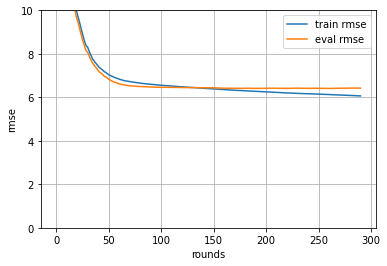

In [36]:
plt.plot(train_metric, label='train rmse')
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.ylim(0, 10)

plt.xlabel('rounds')
plt.ylabel('rmse')
plt.grid(True)
plt.show()

In [37]:
y_total_pred = y_lasso_pred*0.0 + y_ridge_pred*0.0 + y_svc_pred*0.0 + y_lgb_oof_train*1.0

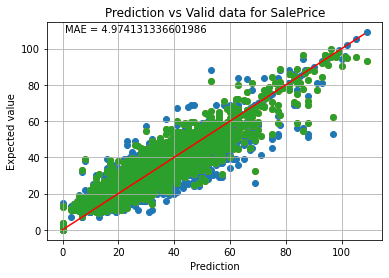

In [38]:
#plt.scatter(y_train, y_lasso_pred)
#plt.scatter(y_train, y_ridge_pred)
plt.scatter(y_train, y_svc_pred)
plt.scatter(y_train, y_lgb_oof_train)
plt.scatter(y_train, y_total_pred)



plt.title("Prediction vs Valid data for SalePrice")
plt.xlabel("Prediction")
plt.ylabel("Expected value")
# Fitting line
x = np.arange(0, max(y_train))
y = x
plt.plot(x,y,color='red')

# MAE
result_mae = mean_absolute_error(y_train, y_total_pred)
#result_mae = mean_absolute_error(y_train, y_lgb_oof_train)
#result_rmsle = rmsle(y_train.values, y_lgb_oof_train)

plt.text(1, max(y_train), 'MAE = {}'.format(result_mae))

# Grid on
plt.grid(True)

In [39]:
# Average of Prediction data (LightGBM)
y_lgb_test_pred = sum(y_lgb_preds)/len(y_lgb_preds)

In [40]:
submit_sample[1] = y_lgb_test_pred
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [41]:
submit_sample.head()

,0,1
0,2016-04-01,67.944318
1,2016-04-02,78.690754
2,2016-04-03,65.265130
3,2016-04-04,65.565084
4,2016-04-05,58.151936
